# Prediction of bookings based on user behavior
Data Scientist – User Profiling, Hotel Search

- Author: Kai Chen
- Date:   Apr, 2018

In [16]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore", DeprecationWarning)

import numpy as np
import pandas as pd
from datetime import datetime
import operator
from collections import OrderedDict
import time
import csv
import gc
from multiprocessing import Pool

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef, classification_report, confusion_matrix, f1_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.externals import joblib
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import linear_model
from sklearn.metrics import accuracy_score

import xgboost as xgb
from xgboost import XGBClassifier

import lightgbm as lgb

import catboost
from catboost import CatBoostClassifier

from keras.preprocessing import sequence
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.datasets import imdb
from keras.utils import to_categorical

np.random.seed(42)

Using TensorFlow backend.


In [4]:
train_user_df = pd.read_csv('train_user_df.csv')
print(train_user_df.describe())
print(train_user_df.head(3))

target_user_df = pd.read_csv('target_user_df.csv')


            user_id    session_id  referer_code        is_app      agent_id  \
count  5.864434e+06  5.864434e+06  5.864434e+06  5.864434e+06  5.864434e+06   
mean   4.612515e+18  4.607873e+18  1.050245e+01  1.247070e-01  7.267086e+00   
std    2.657178e+18  2.656793e+18  2.855244e+01  3.303864e-01  3.802190e+00   
min    3.883091e+14  1.097161e+14  0.000000e+00  0.000000e+00  0.000000e+00   
25%    2.307265e+18  2.310716e+18  0.000000e+00  0.000000e+00  6.000000e+00   
50%    4.624574e+18  4.606553e+18  1.000000e+00  0.000000e+00  9.000000e+00   
75%    6.897454e+18  6.892477e+18  1.000000e+00  0.000000e+00  1.000000e+01   
max    9.223267e+18  9.223359e+18  9.900000e+01  1.000000e+00  1.400000e+01   

       traffic_type   has_booking     action_id     reference          step  
count  5.864434e+06  5.864434e+06  5.864434e+06  5.864434e+06  5.864434e+06  
mean   1.882018e+00  1.301094e-01  2.812956e+03  4.897366e+05  5.463159e+01  
std    1.407386e+00  3.364238e-01  1.636151e+03  2.865

In [10]:
for name, group in train_user_df.groupby('session_id'):
    nb_bookings = group[group['has_booking'] == 1].shape[0]
    if (nb_bookings > 0 and nb_bookings != group.shape[0] and np.max(group['step']) != group.shape[0]):
        print(group)

In [11]:
action_id_list = list(train_user_df.action_id.unique())
print(len(action_id_list))

reference_list = list(train_user_df.reference.unique())
print(len(reference_list))

211
121529


In [13]:
nb_steps_booking_list = []

for name, group in train_user_df.groupby('session_id'):
    nb_bookings = group[group['has_booking'] == 1].shape[0]
    if (nb_bookings > 0):
        nb_steps_booking_list.append(group.shape[0])

print('min nb steps: {}'.format(np.min(nb_steps_booking_list)))
print('max nb steps: {}'.format(np.max(nb_steps_booking_list)))
print('std nb steps: {}'.format(np.std(nb_steps_booking_list)))

min nb steps: 1
max nb steps: 2924
std nb steps: 70.27699664977659


In [14]:
# Is there a common action_id in the sessions with bookings?
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

inter_actions = []

for name, group in train_user_df.groupby('session_id'):
    nb_bookings = group[group['has_booking'] == 1].shape[0]
    if (nb_bookings > 0):
        actions = list(group['action_id'].values)
        inter_actions = intersection(inter_actions, actions)
    
print(inter_actions)

[]


In [15]:
# Is there a common reference in the sessions with bookings?
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

inter_actions = []

for name, group in train_user_df.groupby('session_id'):
    nb_bookings = group[group['has_booking'] == 1].shape[0]
    if (nb_bookings > 0):
        actions = list(group['reference'].values)
        inter_actions = intersection(inter_actions, actions)
    
print(inter_actions)

[]


## Feature engineering

In order to predict if a session has a booking or not, it is not sufficient to take only the session information (i.e., referer_code, is_app, agent_id, traffic_type) and the action information (i.e., action_id, reference) of the last step as features. Ideally, we have to take not only the session information but also all the action information in the session as features. Due to the limitation of the computation resource, for each session, I take the last n steps action information with the session information as features. 


In [17]:
# ---
# Define file paths
TRAIN_BOOKING_FILE_PATH = 'data/case_study_bookings_train.csv'    # training sessions for bookings
TARGET_BOOKING_FILE_PATH = 'data/case_study_bookings_target.csv'  # target sessions to predict bookings

TRAIN_ACTION_FILE_PATH = 'data/case_study_actions_train.csv'      # training set of user actions
TARGET_ACTION_FILE_PATH = 'data/case_study_actions_target.csv'    # user actions in the target sessions

# replace the NAN values by a specific value
NA_ACTION_ID = -10
NA_REFERENCE_ID = -10
NA_STEP = 0

# feature_columns = ['ymd', 'referer_code', 'is_app', 'agent_id', 'traffic_type', 'action_id', 'reference', 'step']
feature_columns = ['referer_code', 'is_app', 'agent_id', 'traffic_type', 'action_id', 'reference', 'step']
target_column   = ['has_booking']

In [ ]:
def prepare_data(df, nb_pre_steps=1,
                 feature_columns = ['referer_code', 'is_app', 'agent_id', 'traffic_type', 'action_id', 'reference', 'step'],
                 # feature_columns = ['ymd', 'referer_code', 'is_app', 'agent_id', 'traffic_type', 'action_id', 'reference', 'step'],
                 previous_action_names=['action_id', 'reference'],
                 target_column = 'has_booking',
                 default_action_values = [-10, -10]):
    """
    Create a dataframe, such that each row contains the information of a session.
    Since for each session, there is a sequence of information.
    In this dataframe, for each session,
    I take only the last n steps information with its nb_pre_steps number of previous steps information.
    """
    print('\n== prepare data ==')

    total_nb_rows = len(df['session_id'].unique())

    # initialize the column names
    # columns_add = ['duration'] # add new features
    columns_add = [f_name for f_name in feature_columns]

    for i in range(0, nb_pre_steps):
        for previous_action_name in previous_action_names:
            col_name = '{}_{}'.format(previous_action_name, (i+1))
            columns_add.append(col_name)

    if target_column in df.columns:
        columns_add.append(target_column)

    df_new = pd.DataFrame(columns=columns_add)

    start_time = time.time()
    index = 0 # index of each row
    for name, group in df.groupby('session_id'):
        max_step = np.max(group['step'])

        # get start time
        # min_step = np.min(group['step'])
        # start_time = pd.to_datetime(group[group['step'] == max_step]['ymd'].values[0].astype('str'))
        # get end time
        # end_time = pd.to_datetime(group[group['step'] == min_step]['ymd'].values[0].astype('str'))
        # compute the duration of the session
        # duration = (end_time-start_time).total_seconds()

        # for each session, get its information in the last step
        sub_df = group[group['step'] == max_step]

        # set the initial values of this session
        val_add = []

        # duration
        # val_add.append(duration)

        for feature_column in feature_columns:
            val_add.append(sub_df[feature_column].values[0])

        for i in range(0, nb_pre_steps):
            for j, previous_action_name in enumerate(previous_action_names):
                val_add.append(default_action_values[j])

        if target_column in sub_df.columns:
            val_add.append(sub_df[target_column].values[0])

        df_new = df_new.append(pd.DataFrame([val_add], columns=columns_add))

        # get the session previous steps information and add it to the new row
        for i in range(0, nb_pre_steps):
            step = max_step - i - 1
            sub_df = group[group['step'] == step]
            if (not sub_df is None) and (not sub_df.empty):
                for previous_action_name in previous_action_names:
                    col_name = '{}_{}'.format(previous_action_name, step)
                    # print('previous')
                    # print(previous_df[previous_action].values)
                    # print('----')
                    df_new.iloc[index][col_name] = sub_df[previous_action_name].values[0]


        index += 1

        if index % 20000 == 0:
            time_used = time.time() - start_time
            time_needed = time_used / index * (total_nb_rows-index)
            print('\n{} / {}'.format(index, total_nb_rows))
            print('time used (mins): {}'.format(round(time_used / 60)))
            print('time needed (mins): {}'.format(round(time_needed / 60)))
            print(df_new.iloc[random.randint(0, index-1)][columns_add])
            if target_column in df_new.columns:
                print('{}: {}'.format(target_column, df_new.iloc[random.randint(0, index-1)][target_column]))

    return df_new

def prepare_datasets(param_dict):
    train_user_df = param_dict['train']
    target_user_df = param_dict['target']
    nb_prev_step = param_dict['nb_prev_step']

    print('\n{}'.format(nb_prev_step))

    train_user_df_new = prepare_data(train_user_df, nb_pre_steps=nb_prev_step)
    df_path = '{}-{}.csv'.format('train_user_df', nb_prev_step)
    train_user_df_new.to_csv(df_path, index=False)
    print('\nsave train dataframe to {}'.format(df_path))
    print(train_user_df_new.head(2))

    target_user_df_new = prepare_data(target_user_df, nb_pre_steps=nb_prev_step)
    df_path = '{}-{}.csv'.format('target_user_df', nb_prev_step)
    target_user_df_new.to_csv(df_path, index=False)
    print('\nsave test dataframe to {}'.format(df_path))
    print(target_user_df_new.head(2))

    del train_user_df_new
    del target_user_df_new
    gc.collect()

In [ ]:
# ----------
# read train data
train_booking_df = pd.read_csv(TRAIN_BOOKING_FILE_PATH, sep='\t')
train_booking_df['ymd'] = pd.to_datetime(train_booking_df['ymd'].astype('str'))
train_action_df = pd.read_csv(TRAIN_ACTION_FILE_PATH, sep='\t')
train_action_df['ymd'] = pd.to_datetime(train_action_df['ymd'].astype('str'))
train_user_df = pd.merge(train_booking_df, train_action_df, on=['ymd', 'user_id', 'session_id'], how='left')
train_user_df = preprocessing(train_user_df)
train_user_df.to_csv('train_user_df.csv')

# ----------
# read test data
target_booking_df = pd.read_csv(TARGET_BOOKING_FILE_PATH, sep='\t')
target_booking_df['ymd'] = pd.to_datetime(target_booking_df['ymd'].astype('str'))
target_action_df = pd.read_csv(TARGET_ACTION_FILE_PATH, sep='\t')
target_action_df['ymd'] = pd.to_datetime(target_action_df['ymd'].astype('str'))
target_user_df = pd.merge(target_booking_df, target_action_df, on=['ymd', 'user_id', 'session_id'], how='left')
target_user_df = preprocessing(target_user_df)
target_user_df.to_csv('target_user_df.csv')

In [ ]:
train_user_df = pd.read_csv('train_user_df.csv')
# train_user_df['ymd'] = pd.to_datetime(train_user_df['ymd'].astype('str'))
target_user_df = pd.read_csv('target_user_df.csv')
# target_user_df['ymd'] = pd.to_datetime(target_user_df['ymd'].astype('str'))

# print(train_user_df.shape)
# print(train_user_df.head(3))
# print(target_user_df.head(3))


# nb_prev_step_list = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
nb_prev_step_list = [32]
param_dict_list = []
for nb_prev_step in nb_prev_step_list:
    param_dict = dict()
    param_dict['train'] = train_user_df
    param_dict['target'] = target_user_df
    param_dict['nb_prev_step'] = nb_prev_step
    param_dict_list.append(param_dict)

n_jobs = 1
with Pool(n_jobs) as p:
    p.map(prepare_datasets, param_dict_list)

## Define machine learning models

In [18]:
feature_columns = ['referer_code', 'is_app', 'agent_id', 'traffic_type', 'action_id', 'reference', 'step']
target_column = ['has_booking']


def get_train_set(df, feature_columns, target_column):
    print('\n === get train set === \n')

    train_df = df[feature_columns + target_column]

    train_x = train_df[feature_columns]
    train_y = train_df[target_column].values

    # https://stackoverflow.com/questions/31995175/scikit-learn-cross-val-score-too-many-indices-for-array
    """
    When we do cross validation in scikit-learn, the process requires an (R,) shape label instead of (R,1). 
    Although they are the same thing to some extend, their indexing mechanisms are different. So in your case, just add:
    c, r = labels.shape
    labels = labels.reshape(c,)
    """
    c, r = train_y.shape
    train_y = train_y.reshape(c, )

    return train_x, train_y


def get_test_set(df, feature_columns):
    print('\n === get test set === \n')

    test_x = df[feature_columns]

    return test_x


def timer(start_time=None):
    # fork from https://www.kaggle.com/tilii7/hyperparameter-grid-search-with-xgboost
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))


def train_xgb(X_train, Y_train, hyperparameter_tuning=False, model_path=None, n_jobs=3, folds=3, param_comb=5, n_estimators=100):
    """
    train a xgb model

    Reference
    https://www.kaggle.com/tilii7/hyperparameter-grid-search-with-xgboost
    """

    # xgb_clf = XGBClassifier(learning_rate=0.01,
    #                     n_estimators=200,
    #                     objective='binary:logistic',
    #                     silent=True, nthread=nthread)

    print('\n === train a xgb model === \n')

    xgb_clf = XGBClassifier(n_estimators=n_estimators, nthread=n_jobs, objective='binary:logistic', silent=True,)

    if hyperparameter_tuning:
        print('xgb hyperparameter tuning ...')

        params = {
            'n_estimators': [5, 10, 80, 100, 200],
            'min_child_weight': [1, 5, 10],
            # 'gamma': [0.5, 1, 1.5, 2, 5],
            'gamma': [0.5, 1, 1.5, 2],
            # 'subsample': [0.6, 0.8, 1.0],
            'subsample': [0.6, 0.8, 1],
            # 'colsample_bytree': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1],
            # 'max_depth': [3, 4, 5]
            'max_depth': [2, 4, 6],
        }

        skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)

        random_search = RandomizedSearchCV(xgb_clf, param_distributions=params, n_iter=param_comb, scoring='roc_auc',
                                           n_jobs=n_jobs,
                                           cv=skf.split(X_train, Y_train),
                                           verbose=3, random_state=42)

        start_time = timer(None)
        random_search.fit(X_train, Y_train)
        timer(start_time)

        print('--------------')
        print('\n all results:')
        print(random_search.cv_results_)

        print('\n best estimator:')
        print(random_search.best_estimator_)

        print('\n best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
        print(random_search.best_score_ * 2 - 1)

        print('\n best xgb hyperparameters:')
        print(random_search.best_params_)

        result_csv_path = 'xgb-random-grid-search-results.csv'
        results = pd.DataFrame(random_search.cv_results_)
        results.to_csv(result_csv_path, index=False)
        print('save xgb random search results to {}'.format(result_csv_path))
        print('--------------')

        #xgb_clf = random_search
        xgb_clf = random_search.best_estimator_
    else:
        xgb_clf.fit(X_train, Y_train)

    if model_path is None:
        xgb_model_path = 'xgb.model'
        if hyperparameter_tuning:
            xgb_model_path = 'xgb.ht.model'
    else:
        xgb_model_path = model_path
        # xgb_clf.save_model(xgb_model_path)
    joblib.dump(xgb_clf, xgb_model_path)
    print('\n save the xgb model to {}'.format(xgb_model_path))

    return xgb_clf, xgb_model_path


def train_rf(X_train, Y_train, hyperparameter_tuning=False, model_path=None, n_jobs=3, folds=3, n_estimators=100):
    """
    train a RF classifier

    Reference
    https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
    """
    print('\n === train a random forest model === \n')

    model = RandomForestClassifier(n_estimators=n_estimators, random_state=42, n_jobs=n_jobs)

    if hyperparameter_tuning:
        # Number of trees in random forest
        #n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
        n_estimators = [5, 10, 80, 100, 200]
        # Number of features to consider at every split
        max_features = ['auto', 'sqrt']
        # Maximum number of levels in tree
        #max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
        max_depth = [4, 6, 8]
        max_depth.append(None)
        # Minimum number of samples required to split a node
        min_samples_split = [2, 5, 10]
        # Minimum number of samples required at each leaf node
        min_samples_leaf = [1, 2, 4]
        # Method of selecting samples for training each tree
        bootstrap = [True, False]
        # Create the random grid
        random_grid = {'n_estimators': n_estimators,
                       'max_features': max_features,
                       'max_depth': max_depth,
                       'min_samples_split': min_samples_split,
                       'min_samples_leaf': min_samples_leaf,
                       'bootstrap': bootstrap}
        #print(random_grid)

        rf_random = RandomizedSearchCV(estimator=model, param_distributions=random_grid,
                                       n_iter=100, cv=folds, verbose=2, random_state=42, n_jobs=n_jobs)

        rf_random.fit(X_train, X_train)


        print('--------------')
        print('\n all results:')
        print(rf_random.cv_results_)

        print('\n best estimator:')
        print(rf_random.best_estimator_)

        print('\n best rf parameters:')
        print(rf_random.best_params_)

        print('\n best scores:')
        rf_random.best_score_

        result_cv_path = 'rf-random-grid-search-results.csv'
        results = pd.DataFrame(rf_random.cv_results_)
        results.to_csv(result_cv_path, index=False)
        print('\n save rf random search results to {}'.format(result_cv_path))
        print('--------------')

        model = rf_random.best_estimator_
    else:
        model.fit(X_train, Y_train)

    if model_path is None:
        model_path = 'rf.model'
        if hyperparameter_tuning:
            model_path = 'rf.ht.model'


    joblib.dump(model, model_path)
    print('\n save the rf model to {}'.format(model_path))

    return model, model_path


def train_nb(X_train, Y_train, model_path=None):
    """
    train a naive bayes classifier
    """
    # reference https://www.analyticsvidhya.com/blog/2017/09/naive-bayes-explained/

    print('\n === train a gaussian naive bayes model === \n')

    model = GaussianNB()
    model.fit(X_train, Y_train,)

    if model_path is None:
        model_path = 'nb.model'

    joblib.dump(model, model_path)
    print('\n save the GaussianNB model to {}'.format(model_path))

    return model, model_path


def train_lgbm(X_train, Y_train,
               # categorical_feature=['referer_code', 'is_app', 'agent_id', 'traffic_type', 'action_id', 'reference'],
               categorical_feature='auto',
               model_path=None, n_jobs=3, hyperparameter_tuning=False, num_boost_round=100, folds=3):
    """
    train a lightGBM model

    Reference
    https://github.com/Microsoft/LightGBM/blob/master/examples/python-guide/advanced_example.py
    https://www.kaggle.com/garethjns/microsoft-lightgbm-with-parameter-tuning-0-823?scriptVersionId=1751960
    """

    print('\n === train a lightGBM === \n')

    d_train = lgb.Dataset(X_train, label=Y_train,
                          # categorical_feature=['aisle_id', 'department_id']
                          categorical_feature=categorical_feature,
                          )


    if not hyperparameter_tuning:
        # params = {
        #     'boosting_type': 'gbdt',
        #     'objective': 'binary',
        #     'num_class': 1,                # must be 1 for non-multiclass training
        #     'metric': 'binary_error',
        #     #'metric': 'binary_logloss',
        #     #'n_jobs': n_jobs,
        #     'nthread': n_jobs,
        #     #'num_leaves': 31,
        #
        #     'num_leaves': 64,
        #     'min_child_weight': 1,
        #     'min_child_samples': 5,
        #     'scale_pos_weight': 1,
        #     'reg_alpha': 5,
        #     'learning_rate': 0.05,
        #     'max_bin': 512,
        #
        #     #'feature_fraction': 0.9,
        #     #'bagging_fraction': 0.8,
        #     #'bagging_freq': 5,
        #     #'verbose': 0
        # }

        params = {'boosting_type': 'gbdt',
                  'max_depth': -1,
                  'objective': 'binary',
                  'nthread': n_jobs,  # Updated from nthread
                  'num_leaves': 64,
                  'learning_rate': 0.05,
                  'max_bin': 512,
                  'subsample_for_bin': 200,
                  'subsample': 1,
                  'subsample_freq': 1,
                  'colsample_bytree': 0.8,
                  'reg_alpha': 5,
                  'reg_lambda': 10,
                  'min_split_gain': 0.5,
                  'min_child_weight': 1,
                  'min_child_samples': 5,
                  'scale_pos_weight': 1,
                  'num_class': 1,
                  'metric': 'binary_error'}

        gbm = lgb.train(params,
                        d_train,
                        num_boost_round=num_boost_round,
                        categorical_feature=categorical_feature)

    else:
        params = {'boosting_type': 'gbdt',
                  'max_depth': -1,
                  'objective': 'binary',
                  'nthread': n_jobs,  # Updated from nthread
                  'num_leaves': 64,
                  'learning_rate': 0.05,
                  'max_bin': 512,
                  'subsample_for_bin': 200,
                  'subsample': 1,
                  'subsample_freq': 1,
                  'colsample_bytree': 0.8,
                  'reg_alpha': 5,
                  'reg_lambda': 10,
                  'min_split_gain': 0.5,
                  'min_child_weight': 1,
                  'min_child_samples': 5,
                  'scale_pos_weight': 1,
                  'num_class': 1,
                  'metric': 'binary_error'}

        gridParams = {
            'learning_rate': [0.005],
            'n_estimators': [8, 16, 24],
            'num_leaves': [6, 8, 12, 16],
            'boosting_type': ['gbdt'],
            'objective': ['binary'],
            'random_state': [42],  # Updated from 'seed'
            'colsample_bytree': [0.64, 0.65, 0.66],
            'subsample': [0.7, 0.75],
            'reg_alpha': [1, 1.2],
            'reg_lambda': [1, 1.2, 1.4],
        }

        mdl = lgb.LGBMClassifier(boosting_type='gbdt',
                                 objective='binary',
                                 n_jobs=n_jobs,  # Updated from 'nthread'
                                 silent=True,
                                 max_depth=params['max_depth'],
                                 max_bin=params['max_bin'],
                                 subsample_for_bin=params['subsample_for_bin'],
                                 subsample=params['subsample'],
                                 subsample_freq=params['subsample_freq'],
                                 min_split_gain=params['min_split_gain'],
                                 min_child_weight=params['min_child_weight'],
                                 min_child_samples=params['min_child_samples'],
                                 scale_pos_weight=params['scale_pos_weight'])

        print(mdl.get_params().keys())

        grid = RandomizedSearchCV(estimator=mdl, param_distributions=gridParams,
                                       n_iter=100, cv=folds, verbose=2, random_state=42, n_jobs=n_jobs)

        #grid = GridSearchCV(mdl, gridParams, verbose=2, cv=folds, n_jobs=n_jobs)
        grid.fit(X_train, Y_train)

        print('best parameters:')
        print(grid.best_params_)
        print('best score: ')
        print(grid.best_score_)

        # using parameters already set above, replace in the best from the grid search
        params['colsample_bytree'] = grid.best_params_['colsample_bytree']
        params['learning_rate'] = grid.best_params_['learning_rate']
        #params['max_bin'] = grid.best_params_['max_bin']
        params['num_leaves'] = grid.best_params_['num_leaves']
        params['reg_alpha'] = grid.best_params_['reg_alpha']
        params['reg_lambda'] = grid.best_params_['reg_lambda']
        params['subsample'] = grid.best_params_['subsample']
        #params['subsample_for_bin'] = grid.best_params_['subsample_for_bin']

        print('Fitting with params: ')
        print(params)

        X_train_sub, X_val, Y_train_sub, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

        d_train_sub = lgb.Dataset(X_train_sub, label=Y_train_sub,
                              # categorical_feature=['aisle_id', 'department_id']
                              categorical_feature=categorical_feature,
                              #categorical_feature='auto'
                              )

        d_val_sub = lgb.Dataset(X_val, label=Y_val,
                              # categorical_feature=['aisle_id', 'department_id']
                              categorical_feature=categorical_feature,
                              #categorical_feature='auto'
                              )

        gbm = lgb.train(params,
                        d_train_sub,
                        num_boost_round=1000,
                        valid_sets=[d_train_sub, d_val_sub],
                        early_stopping_rounds=50,
                        verbose_eval=4)

        # Plot importance
        #lgb.plot_importance(gbm)

    if model_path is None:
        model_path = 'lgbm.model'
        if hyperparameter_tuning:
            model_path = 'lgbm.ht.model'

    # save model to file
    gbm.save_model(model_path)
    print('save the lightGBM model to {}'.format(model_path))

    # load model to predict
    # print('Load model to predict')
    # bst = lgb.Booster(model_file='model.txt')
    # can only predict with the best iteration (or the saving iteration)
    # y_pred = bst.predict(X_test)

    return gbm, model_path


def train_catboost(X_train, Y_train,
                   categorical_feature=[0, 1, 2, 3, 4, 5],
                   #categorical_feature=['referer_code', 'is_app', 'agent_id', 'traffic_type', 'action_id', 'reference'],
                   model_path=None, hyperparameter_tuning=False, num_boost_round=100):
    """
    train a catboost model

    Reference:
    https://tech.yandex.com/catboost/doc/dg/concepts/python-usages-examples-docpage/
    """

    print('\n === train a catboost === \n')

    model = CatBoostClassifier(loss_function='Logloss',
                               iterations=num_boost_round,
                               #learning_rate=1,
                               #depth=2
                               )
    model.fit(X_train, Y_train, categorical_feature)

    if model_path is None:
        model_path = 'catboost.model'
        if hyperparameter_tuning:
            model_path = 'catboost.ht.model'

    model.save_model(model_path)

    print('\n save the catboost model to {}'.format(model_path))

    return model, model_path

def train_cnn(X_train, Y_train, model_path, maxlen = 400, epochs = 2):
    # max_features = 5000
    max_features = 1000
    batch_size = 64
    embedding_dims = 20
    filters = 250
    kernel_size = 3
    hidden_dims = 100

    # X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
    # Y_train = to_categorical(Y_train)

    print('Build model...')
    model = Sequential()
    model.add(Embedding(max_features,
                        embedding_dims,
                        input_length=maxlen))
    model.add(Dropout(0.2))

    # we add a Convolution1D, which will learn filters
    # word group filters of size filter_length:
    model.add(Conv1D(filters,
                     kernel_size,
                     padding='valid',
                     activation='relu',
                     strides=1))
    # we use max pooling:
    model.add(GlobalMaxPooling1D())

    # We add a vanilla hidden layer:
    model.add(Dense(hidden_dims))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))

    # We project onto a single unit output layer, and squash it with a sigmoid:
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    model.fit(X_train, Y_train,
              batch_size=batch_size,
              epochs=epochs,
              # validation_data=(x_test, y_test),
              verbose=2,
              )

    model.save(model_path)

    return model, model_path


def predict(model_path, X_test, is_lgbm=False, is_catboost=False, is_cnn=False, maxlen=400, lgbm_threshold=0.5):
    """
    load the model and predict unseen data
    """

    print('\n === predict === \n')

    if is_lgbm:
        # lightgbm
        model = lgb.Booster(model_file=model_path)
    elif is_catboost:
        model = CatBoostClassifier()
        model = model.load_model(model_path)
    elif is_cnn:
        model = load_model(model_path)
    else:
        # sklearn
        # xgboost
        model = joblib.load(model_path)

    # y_pred = model.predict_prob(X_test)
    y_pred = model.predict(X_test)

    if is_lgbm:
        #print('==')
        #print(y_pred)
        y_output = []
        for y in y_pred:
            if y > lgbm_threshold:
                y_output.append(1)
            else:
                y_output.append(0)
        #print('==')
        #print(y_output)
        return(np.array(y_output))
        #return np.array([np.argmax(y) for y in y_pred])
    elif is_cnn:
        # X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
        y_pred = model.predict(X_test)
        y_pred = [np.argmax(y) for y in y_pred]
        return np.array(y_pred)
    else:
        return y_pred


def blend_predictions(y_pred_list, threshold=0.5):
    """
    blend the predictions
    """

    print('\n === blend predictions === \n')

    y_pred = y_pred_list[0]

    for i in range(1, len(y_pred_list)):
        for j in range(len(y_pred)):
            y_pred[j] += y_pred_list[i][j]

    # average the predictions
    y_pred = y_pred*1.0 / len(y_pred_list)

    y_output = []
    for y in y_pred:
        if y > threshold:
            y_output.append(1)
        else:
            y_output.append(0)

    return np.array(y_output)


def evaluate(y_true, y_pred):
    """
    evaluate the prediction
    """
    print('\n === evaluate === \n')

    nb_bookings_true = 0
    for y in y_true:
        if y == 1:
            nb_bookings_true += 1
    print('\n number of bookings in y_true: {}'.format(nb_bookings_true))
    print('\n y_true shape:')
    print(y_true.shape)

    nb_bookings_pred = 0
    for y in y_pred:
        if y == 1:
            nb_bookings_pred += 1
    print('\n number of bookings in y_pred {}'.format(nb_bookings_pred))
    print('\n y_pred shape:')
    print(y_pred.shape)

    mcc_score = matthews_corrcoef(y_true, y_pred)
    print('\n matthews corrcoef score {}'.format(mcc_score))

    """
      tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
      print(tn)
      print(fp)
      print(fn)
      print(tp)
      print('---')

      mcc = (tp*tn - fp*fn) / np.math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
      print(mcc)
      print(matthews_corrcoef(y_true, y_pred))
      """

    accuracy = accuracy_score(y_true, y_pred)
    print('\n accuracy: {}'.format(accuracy))
    print('\n classification report:')
    print(classification_report(y_true, y_pred))

    f1score = f1_score(y_true, y_pred, average='binary')
    print('\n f1 score: {}'.format(f1score))

    #roc_auc_score(y_true, y_pred)

    return mcc_score, accuracy, f1score


def plot_performance(x_list, y_list, title, x_label, y_label):
    """
    define the plotting function
    """
    plt.plot(x_list, y_list)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

    
def save_prediction(session_id_list, y_pred, file_path):
    """
    save predictions to a csv file
    """
    prediciton_df = pd.DataFrame(columns=['session_id', 'has_booking'])
    prediciton_df['session_id'] = session_id_list
    prediciton_df['has_booking'] = [int(y) for y in y_pred]

    print('prediction:')
    print(prediciton_df['has_booking'].unique())

    prediciton_df.to_csv(file_path, '\t', index=False)
    print('save prediction to {}'.format(file_path))


## Evaluation

In [20]:
def evaluation(model_name, train_sub_x, val_x, train_sub_y, val_y, nb_prev_step, num_boost_rounds, hyperparameter_tuning,
               category_feature_index_list,):
    """
    define the model evaluation function
    """
    
    mcc_list = []
    acc_list = []
    f1_list  = []
    dict_mcc_score = dict()
        
    for num_boost_round in num_boost_rounds:
        print('\nnum boost round: {}'.format(num_boost_round))

        y_pred = None

        if model_name == 'catboost':
            model_path = 'catboost-[num_boost_round]{}-[ht]{}-[nb_prev]{}-sub.model'.format(num_boost_round,
                                                                                             hyperparameter_tuning,
                                                                                             nb_prev_step)

            model, model_path = train_catboost(train_sub_x, train_sub_y, hyperparameter_tuning=hyperparameter_tuning,
                                               categorical_feature=category_feature_index_list,
                                               model_path=model_path, num_boost_round=num_boost_round)
            y_pred = predict(model_path, val_x, is_catboost=True)
            
        elif model_name == 'xgb':
            model_path = 'xgb-[num_boost_round]{}-[ht]{}-[nb_prev]{}-sub.model'.format(num_boost_round,
                                                                                       hyperparameter_tuning,
                                                                                       nb_prev_step)
            model, model_path = train_xgb(X_train=train_sub_x, Y_train=train_sub_y,
                                          hyperparameter_tuning=hyperparameter_tuning,
                                          model_path=model_path, n_estimators=num_boost_round)
            y_pred = predict(model_path, val_x)

        elif model_name == 'lgbm':
            model_path = 'lgbm-[num_boost_round]{}-[ht]{}-[nb_prev]{}-sub.model'.format(num_boost_round,
                                                                                       hyperparameter_tuning,
                                                                                       nb_prev_step)

            model, model_path = train_lgbm(train_sub_x, train_sub_y, hyperparameter_tuning=hyperparameter_tuning,
                                           categorical_feature=categorical_feature,
                                           model_path=model_path, num_boost_round=num_boost_round)
            
            y_pred = predict(model_path, val_x, is_lgbm=True)
        
        elif model_name == 'rf':
            model_path = 'rf-[num_boost_round]{}-[ht]{}-[nb_prev]{}-sub.model'.format(num_boost_round,
                                                                                      hyperparameter_tuning,
                                                                                      nb_prev_step)
            
            model, model_path = train_rf(X_train=train_sub_x, Y_train=train_sub_y, 
                                         hyperparameter_tuning=hyperparameter_tuning,
                                         model_path=model_path, n_jobs=2, n_estimators=num_boost_round)
            
            y_pred = predict(model_path, val_x)
            
        elif model_name == 'cnn':
            epochs = 100
            model_path = 'cnn-[epochs]{}-[nb_prev]{}-sub.model'.format(epochs, nb_prev_step)
            maxlen = train_sub_x.shape[1]
            model, model_path = train_cnn(train_sub_x, train_sub_y,
                                           model_path=model_path, epochs=epochs, maxlen=maxlen)
            y_pred = predict(model_path, val_x, is_cnn=True, maxlen=maxlen)

        mcc_score, accuracy, f1score = evaluate(val_y, y_pred)
        
        dict_mcc_score[num_boost_round] = mcc_score
        
        mcc_list.append(mcc_score)
        acc_list.append(accuracy)
        f1_list.append(f1score)

    plot_performance(num_boost_rounds, mcc_list, 'mcc score (model: {} #steps: {})'.format(model_name, nb_prev_step), 
                     'num_boost_round', 'mcc score')
    
    plot_performance(num_boost_rounds, acc_list, 'accuracy (model: {} #steps: {})'.format(model_name, nb_prev_step), 
                     'num_boost_round', 'accuracy')
    
    plot_performance(num_boost_rounds, f1_list, 'f1 score (model: {} #steps: {})'.format(model_name, nb_prev_step), 
                     'num_boost_round', 'f1 score')
    
    return dict_mcc_score

In [22]:
# --------------
# Prepare the datasets

nb_prev_step = 32

no_feature_name_list = ['ymd', 'user_id', 'session_id', 'has_booking',]
no_cat_feature_name  = ['step']

target_columns       = ['has_booking']
feature_columns      = ['referer_code', 'is_app', 'agent_id', 'traffic_type', 'action_id', 'reference', 'step']
    
    
train_user_df = pd.read_csv('train_user_df-{}.csv'.format(nb_prev_step))
target_user_df = pd.read_csv('target_user_df-{}.csv'.format(nb_prev_step))

# get all features names
feature_columns = [feature for feature in train_user_df.columns if not (feature in no_feature_name_list)]
print('feature columns: ')
print(feature_columns)

# get all category features names
categorical_feature = [feature for feature in feature_columns if (not feature in no_cat_feature_name)]
print('category feature columns: ')
print(categorical_feature)

category_feature_index_list = [i for i, feature in enumerate(feature_columns) if not (feature in no_cat_feature_name)]
print('category feature index list:')
print(category_feature_index_list)

# shuffle the train set
train_user_df = train_user_df.reindex(np.random.permutation(train_user_df.index))

train_x, train_y = get_train_set(train_user_df, feature_columns, target_columns)
print('\n -----')
print('train set size:')
print(train_x.shape)
print(train_y.shape)

print('feature columns: ')
print(train_x.columns)   

# prepare validation set
train_sub_x, val_x, train_sub_y, val_y = train_test_split(train_x, train_y, test_size=0.1, random_state=42)


feature columns: 
['referer_code', 'is_app', 'agent_id', 'traffic_type', 'action_id', 'reference', 'step', 'action_id_1', 'reference_1', 'action_id_2', 'reference_2', 'action_id_3', 'reference_3', 'action_id_4', 'reference_4', 'action_id_5', 'reference_5', 'action_id_6', 'reference_6', 'action_id_7', 'reference_7', 'action_id_8', 'reference_8', 'action_id_9', 'reference_9', 'action_id_10', 'reference_10', 'action_id_11', 'reference_11', 'action_id_12', 'reference_12', 'action_id_13', 'reference_13', 'action_id_14', 'reference_14', 'action_id_15', 'reference_15', 'action_id_16', 'reference_16', 'action_id_17', 'reference_17', 'action_id_18', 'reference_18', 'action_id_19', 'reference_19', 'action_id_20', 'reference_20', 'action_id_21', 'reference_21', 'action_id_22', 'reference_22', 'action_id_23', 'reference_23', 'action_id_24', 'reference_24', 'action_id_25', 'reference_25', 'action_id_26', 'reference_26', 'action_id_27', 'reference_27', 'action_id_28', 'reference_28', 'action_id_29',


num boost round: 100

 === train a xgb model === 


 save the xgb model to xgb-[num_boost_round]100-[ht]False-[nb_prev]32-sub.model

 === predict === 


 === evaluate === 


 number of bookings in y_true: 2001

 y_true shape:
(30768,)

 number of bookings in y_pred 67

 y_pred shape:
(30768,)

 matthews corrcoef score 0.11774788466590541

 accuracy: 0.9357774310972439

 classification report:
             precision    recall  f1-score   support

          0       0.94      1.00      0.97     28767
          1       0.69      0.02      0.04      2001

avg / total       0.92      0.94      0.91     30768


 f1 score: 0.04448742746615087

num boost round: 200

 === train a xgb model === 


 save the xgb model to xgb-[num_boost_round]200-[ht]False-[nb_prev]32-sub.model

 === predict === 


 === evaluate === 


 number of bookings in y_true: 2001

 y_true shape:
(30768,)

 number of bookings in y_pred 127

 y_pred shape:
(30768,)

 matthews corrcoef score 0.17009575297938734

 accuracy: 0.


 save the xgb model to xgb-[num_boost_round]10000-[ht]False-[nb_prev]32-sub.model

 === predict === 


 === evaluate === 


 number of bookings in y_true: 2001

 y_true shape:
(30768,)

 number of bookings in y_pred 614

 y_pred shape:
(30768,)

 matthews corrcoef score 0.3355871140696597

 accuracy: 0.9407501300052002

 classification report:
             precision    recall  f1-score   support

          0       0.95      0.99      0.97     28767
          1       0.64      0.20      0.30      2001

avg / total       0.93      0.94      0.93     30768


 f1 score: 0.302868068833652


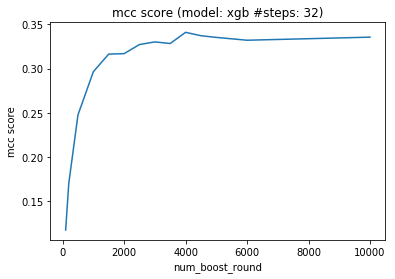

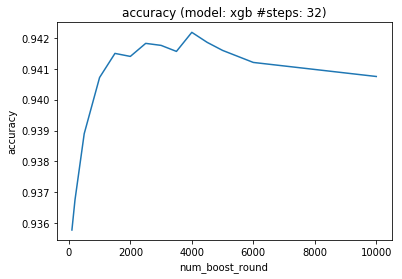

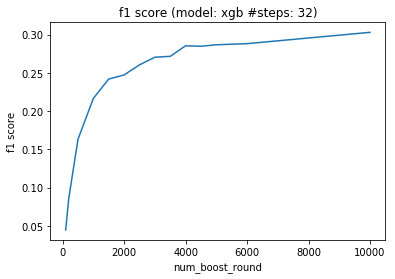


num boost round: 100

 === train a catboost === 

0:	learn: 0.6373208	total: 4.12s	remaining: 6m 48s
1:	learn: 0.5884299	total: 8.32s	remaining: 6m 47s
2:	learn: 0.5451849	total: 12s	remaining: 6m 29s
3:	learn: 0.5061161	total: 15.7s	remaining: 6m 17s
4:	learn: 0.4718939	total: 19.5s	remaining: 6m 11s
5:	learn: 0.4416860	total: 23.4s	remaining: 6m 6s
6:	learn: 0.4149196	total: 27.4s	remaining: 6m 3s
7:	learn: 0.3910644	total: 31.2s	remaining: 5m 58s
8:	learn: 0.3702284	total: 34.9s	remaining: 5m 52s
9:	learn: 0.3518030	total: 38.5s	remaining: 5m 46s
10:	learn: 0.3354867	total: 42.7s	remaining: 5m 45s
11:	learn: 0.3209154	total: 46.4s	remaining: 5m 40s
12:	learn: 0.3080532	total: 50.3s	remaining: 5m 36s
13:	learn: 0.2965153	total: 54.3s	remaining: 5m 33s
14:	learn: 0.2862838	total: 58.2s	remaining: 5m 29s
15:	learn: 0.2771225	total: 1m 1s	remaining: 5m 25s
16:	learn: 0.2688456	total: 1m 5s	remaining: 5m 20s
17:	learn: 0.2614643	total: 1m 9s	remaining: 5m 16s
18:	learn: 0.2548199	total:

43:	learn: 0.1917993	total: 3m 10s	remaining: 11m 15s
44:	learn: 0.1906896	total: 3m 14s	remaining: 11m 10s
45:	learn: 0.1896280	total: 3m 19s	remaining: 11m 7s
46:	learn: 0.1887799	total: 3m 23s	remaining: 11m 2s
47:	learn: 0.1879330	total: 3m 27s	remaining: 10m 57s
48:	learn: 0.1871000	total: 3m 31s	remaining: 10m 52s
49:	learn: 0.1863593	total: 3m 35s	remaining: 10m 47s
50:	learn: 0.1856726	total: 3m 40s	remaining: 10m 43s
51:	learn: 0.1850776	total: 3m 44s	remaining: 10m 40s
52:	learn: 0.1844611	total: 3m 49s	remaining: 10m 36s
53:	learn: 0.1838529	total: 3m 54s	remaining: 10m 33s
54:	learn: 0.1833277	total: 3m 59s	remaining: 10m 31s
55:	learn: 0.1828007	total: 4m 3s	remaining: 10m 26s
56:	learn: 0.1823270	total: 4m 8s	remaining: 10m 22s
57:	learn: 0.1819319	total: 4m 12s	remaining: 10m 17s
58:	learn: 0.1815308	total: 4m 17s	remaining: 10m 14s
59:	learn: 0.1811793	total: 4m 21s	remaining: 10m 10s
60:	learn: 0.1808112	total: 4m 26s	remaining: 10m 7s
61:	learn: 0.1804768	total: 4m 30

196:	learn: 0.1687012	total: 16m 23s	remaining: 15s
197:	learn: 0.1686245	total: 16m 28s	remaining: 9.98s
198:	learn: 0.1685718	total: 16m 33s	remaining: 4.99s
199:	learn: 0.1685299	total: 16m 38s	remaining: 0us

 save the catboost model to catboost-[num_boost_round]200-[ht]False-[nb_prev]32-sub.model

 === predict === 


 === evaluate === 


 number of bookings in y_true: 2001

 y_true shape:
(30768,)

 number of bookings in y_pred 123

 y_pred shape:
(30768,)

 matthews corrcoef score 0.18799308305641751

 accuracy: 0.9373374934997399

 classification report:
             precision    recall  f1-score   support

          0       0.94      1.00      0.97     28767
          1       0.80      0.05      0.09      2001

avg / total       0.93      0.94      0.91     30768


 f1 score: 0.09227871939736347

num boost round: 500

 === train a catboost === 

0:	learn: 0.6373066	total: 4.2s	remaining: 34m 56s
1:	learn: 0.5881403	total: 8.56s	remaining: 35m 31s
2:	learn: 0.5448606	total: 12.3

137:	learn: 0.1717322	total: 11m 1s	remaining: 28m 54s
138:	learn: 0.1716682	total: 11m 6s	remaining: 28m 51s
139:	learn: 0.1716218	total: 11m 12s	remaining: 28m 48s
140:	learn: 0.1715810	total: 11m 17s	remaining: 28m 45s
141:	learn: 0.1715066	total: 11m 23s	remaining: 28m 41s
142:	learn: 0.1714735	total: 11m 28s	remaining: 28m 39s
143:	learn: 0.1714404	total: 11m 33s	remaining: 28m 35s
144:	learn: 0.1713817	total: 11m 39s	remaining: 28m 31s
145:	learn: 0.1713220	total: 11m 43s	remaining: 28m 26s
146:	learn: 0.1712659	total: 11m 49s	remaining: 28m 22s
147:	learn: 0.1712205	total: 11m 54s	remaining: 28m 19s
148:	learn: 0.1711690	total: 11m 59s	remaining: 28m 15s
149:	learn: 0.1711252	total: 12m 4s	remaining: 28m 11s
150:	learn: 0.1710699	total: 12m 10s	remaining: 28m 8s
151:	learn: 0.1709596	total: 12m 15s	remaining: 28m 4s
152:	learn: 0.1708650	total: 12m 20s	remaining: 28m
153:	learn: 0.1707996	total: 12m 25s	remaining: 27m 55s
154:	learn: 0.1707452	total: 12m 31s	remaining: 27m 51s
1

285:	learn: 0.1652881	total: 24m 2s	remaining: 17m 59s
286:	learn: 0.1652729	total: 24m 7s	remaining: 17m 54s
287:	learn: 0.1652486	total: 24m 12s	remaining: 17m 49s
288:	learn: 0.1652321	total: 24m 17s	remaining: 17m 44s
289:	learn: 0.1651928	total: 24m 23s	remaining: 17m 39s
290:	learn: 0.1651779	total: 24m 27s	remaining: 17m 34s
291:	learn: 0.1651625	total: 24m 32s	remaining: 17m 29s
292:	learn: 0.1651421	total: 24m 38s	remaining: 17m 24s
293:	learn: 0.1651199	total: 24m 43s	remaining: 17m 19s
294:	learn: 0.1650999	total: 24m 48s	remaining: 17m 14s
295:	learn: 0.1650652	total: 24m 54s	remaining: 17m 9s
296:	learn: 0.1650539	total: 24m 59s	remaining: 17m 4s
297:	learn: 0.1650343	total: 25m 4s	remaining: 16m 59s
298:	learn: 0.1650007	total: 25m 9s	remaining: 16m 54s
299:	learn: 0.1649890	total: 25m 14s	remaining: 16m 49s
300:	learn: 0.1649631	total: 25m 19s	remaining: 16m 44s
301:	learn: 0.1649196	total: 25m 25s	remaining: 16m 40s
302:	learn: 0.1648933	total: 25m 30s	remaining: 16m 35

434:	learn: 0.1611996	total: 37m 1s	remaining: 5m 31s
435:	learn: 0.1611728	total: 37m 7s	remaining: 5m 26s
436:	learn: 0.1611576	total: 37m 11s	remaining: 5m 21s
437:	learn: 0.1611518	total: 37m 17s	remaining: 5m 16s
438:	learn: 0.1610997	total: 37m 22s	remaining: 5m 11s
439:	learn: 0.1610875	total: 37m 27s	remaining: 5m 6s
440:	learn: 0.1610326	total: 37m 32s	remaining: 5m 1s
441:	learn: 0.1610206	total: 37m 38s	remaining: 4m 56s
442:	learn: 0.1610013	total: 37m 43s	remaining: 4m 51s
443:	learn: 0.1609924	total: 37m 49s	remaining: 4m 46s
444:	learn: 0.1609747	total: 37m 53s	remaining: 4m 41s
445:	learn: 0.1609663	total: 37m 59s	remaining: 4m 35s
446:	learn: 0.1609092	total: 38m 4s	remaining: 4m 30s
447:	learn: 0.1608851	total: 38m 9s	remaining: 4m 25s
448:	learn: 0.1608420	total: 38m 14s	remaining: 4m 20s
449:	learn: 0.1608343	total: 38m 19s	remaining: 4m 15s
450:	learn: 0.1608184	total: 38m 24s	remaining: 4m 10s
451:	learn: 0.1607872	total: 38m 29s	remaining: 4m 5s
452:	learn: 0.160

72:	learn: 0.1780508	total: 5m 14s	remaining: 1h 6m 37s
73:	learn: 0.1778489	total: 5m 18s	remaining: 1h 6m 31s
74:	learn: 0.1776984	total: 5m 22s	remaining: 1h 6m 22s
75:	learn: 0.1775353	total: 5m 27s	remaining: 1h 6m 20s
76:	learn: 0.1774061	total: 5m 32s	remaining: 1h 6m 30s
77:	learn: 0.1772621	total: 5m 37s	remaining: 1h 6m 29s
78:	learn: 0.1770972	total: 5m 42s	remaining: 1h 6m 37s
79:	learn: 0.1769712	total: 5m 47s	remaining: 1h 6m 41s
80:	learn: 0.1768456	total: 5m 53s	remaining: 1h 6m 48s
81:	learn: 0.1767428	total: 5m 58s	remaining: 1h 6m 52s
82:	learn: 0.1766512	total: 6m 3s	remaining: 1h 7m
83:	learn: 0.1765487	total: 6m 8s	remaining: 1h 7m 2s
84:	learn: 0.1763721	total: 6m 13s	remaining: 1h 7m 2s
85:	learn: 0.1762553	total: 6m 19s	remaining: 1h 7m 9s
86:	learn: 0.1761839	total: 6m 24s	remaining: 1h 7m 15s
87:	learn: 0.1760850	total: 6m 29s	remaining: 1h 7m 20s
88:	learn: 0.1759361	total: 6m 35s	remaining: 1h 7m 26s
89:	learn: 0.1758503	total: 6m 40s	remaining: 1h 7m 32s
9

216:	learn: 0.1676576	total: 17m 52s	remaining: 1h 4m 29s
217:	learn: 0.1676236	total: 17m 57s	remaining: 1h 4m 26s
218:	learn: 0.1675879	total: 18m 3s	remaining: 1h 4m 23s
219:	learn: 0.1675377	total: 18m 8s	remaining: 1h 4m 18s
220:	learn: 0.1675013	total: 18m 13s	remaining: 1h 4m 15s
221:	learn: 0.1674563	total: 18m 19s	remaining: 1h 4m 12s
222:	learn: 0.1674338	total: 18m 24s	remaining: 1h 4m 9s
223:	learn: 0.1673553	total: 18m 29s	remaining: 1h 4m 5s
224:	learn: 0.1673369	total: 18m 35s	remaining: 1h 4m 1s
225:	learn: 0.1673107	total: 18m 40s	remaining: 1h 3m 57s
226:	learn: 0.1672482	total: 18m 45s	remaining: 1h 3m 53s
227:	learn: 0.1671873	total: 18m 51s	remaining: 1h 3m 51s
228:	learn: 0.1671438	total: 18m 56s	remaining: 1h 3m 47s
229:	learn: 0.1671231	total: 19m 2s	remaining: 1h 3m 43s
230:	learn: 0.1670868	total: 19m 7s	remaining: 1h 3m 39s
231:	learn: 0.1670575	total: 19m 12s	remaining: 1h 3m 35s
232:	learn: 0.1670371	total: 19m 17s	remaining: 1h 3m 31s
233:	learn: 0.1670177

362:	learn: 0.1628483	total: 30m 41s	remaining: 53m 52s
363:	learn: 0.1628382	total: 30m 47s	remaining: 53m 47s
364:	learn: 0.1628247	total: 30m 52s	remaining: 53m 43s
365:	learn: 0.1628078	total: 30m 58s	remaining: 53m 39s
366:	learn: 0.1627948	total: 31m 3s	remaining: 53m 34s
367:	learn: 0.1627836	total: 31m 9s	remaining: 53m 30s
368:	learn: 0.1627648	total: 31m 15s	remaining: 53m 26s
369:	learn: 0.1627501	total: 31m 19s	remaining: 53m 21s
370:	learn: 0.1627375	total: 31m 25s	remaining: 53m 16s
371:	learn: 0.1627218	total: 31m 30s	remaining: 53m 12s
372:	learn: 0.1627052	total: 31m 36s	remaining: 53m 7s
373:	learn: 0.1626970	total: 31m 41s	remaining: 53m 3s
374:	learn: 0.1626545	total: 31m 46s	remaining: 52m 57s
375:	learn: 0.1626447	total: 31m 52s	remaining: 52m 53s
376:	learn: 0.1626325	total: 31m 57s	remaining: 52m 48s
377:	learn: 0.1626179	total: 32m 2s	remaining: 52m 44s
378:	learn: 0.1625916	total: 32m 8s	remaining: 52m 39s
379:	learn: 0.1625637	total: 32m 13s	remaining: 52m 35

510:	learn: 0.1602854	total: 43m 48s	remaining: 41m 55s
511:	learn: 0.1602795	total: 43m 54s	remaining: 41m 50s
512:	learn: 0.1602592	total: 43m 59s	remaining: 41m 45s
513:	learn: 0.1602493	total: 44m 4s	remaining: 41m 40s
514:	learn: 0.1602398	total: 44m 10s	remaining: 41m 36s
515:	learn: 0.1602231	total: 44m 16s	remaining: 41m 31s
516:	learn: 0.1602173	total: 44m 21s	remaining: 41m 26s
517:	learn: 0.1602005	total: 44m 27s	remaining: 41m 21s
518:	learn: 0.1601926	total: 44m 32s	remaining: 41m 16s
519:	learn: 0.1601593	total: 44m 38s	remaining: 41m 12s
520:	learn: 0.1601505	total: 44m 43s	remaining: 41m 7s
521:	learn: 0.1601472	total: 44m 47s	remaining: 41m 1s
522:	learn: 0.1601166	total: 44m 52s	remaining: 40m 55s
523:	learn: 0.1601086	total: 44m 58s	remaining: 40m 50s
524:	learn: 0.1600974	total: 45m 3s	remaining: 40m 45s
525:	learn: 0.1600867	total: 45m 7s	remaining: 40m 39s
526:	learn: 0.1600766	total: 45m 12s	remaining: 40m 34s
527:	learn: 0.1600633	total: 45m 18s	remaining: 40m 2

658:	learn: 0.1581599	total: 56m 51s	remaining: 29m 25s
659:	learn: 0.1581455	total: 56m 56s	remaining: 29m 20s
660:	learn: 0.1581217	total: 57m 2s	remaining: 29m 15s
661:	learn: 0.1580828	total: 57m 6s	remaining: 29m 9s
662:	learn: 0.1580781	total: 57m 12s	remaining: 29m 4s
663:	learn: 0.1580442	total: 57m 17s	remaining: 28m 59s
664:	learn: 0.1580329	total: 57m 22s	remaining: 28m 54s
665:	learn: 0.1580206	total: 57m 28s	remaining: 28m 49s
666:	learn: 0.1580140	total: 57m 33s	remaining: 28m 44s
667:	learn: 0.1580102	total: 57m 38s	remaining: 28m 39s
668:	learn: 0.1580061	total: 57m 44s	remaining: 28m 33s
669:	learn: 0.1580056	total: 57m 49s	remaining: 28m 28s
670:	learn: 0.1579950	total: 57m 54s	remaining: 28m 23s
671:	learn: 0.1579868	total: 58m	remaining: 28m 18s
672:	learn: 0.1579832	total: 58m 6s	remaining: 28m 13s
673:	learn: 0.1579765	total: 58m 11s	remaining: 28m 8s
674:	learn: 0.1579611	total: 58m 17s	remaining: 28m 3s
675:	learn: 0.1579569	total: 58m 22s	remaining: 27m 58s
676

803:	learn: 0.1564947	total: 1h 9m 41s	remaining: 16m 59s
804:	learn: 0.1564902	total: 1h 9m 46s	remaining: 16m 54s
805:	learn: 0.1564839	total: 1h 9m 52s	remaining: 16m 49s
806:	learn: 0.1564773	total: 1h 9m 57s	remaining: 16m 43s
807:	learn: 0.1564666	total: 1h 10m 1s	remaining: 16m 38s
808:	learn: 0.1564535	total: 1h 10m 7s	remaining: 16m 33s
809:	learn: 0.1564466	total: 1h 10m 11s	remaining: 16m 27s
810:	learn: 0.1564430	total: 1h 10m 16s	remaining: 16m 22s
811:	learn: 0.1564314	total: 1h 10m 22s	remaining: 16m 17s
812:	learn: 0.1564233	total: 1h 10m 27s	remaining: 16m 12s
813:	learn: 0.1564183	total: 1h 10m 33s	remaining: 16m 7s
814:	learn: 0.1564126	total: 1h 10m 38s	remaining: 16m 2s
815:	learn: 0.1564026	total: 1h 10m 44s	remaining: 15m 57s
816:	learn: 0.1563986	total: 1h 10m 49s	remaining: 15m 51s
817:	learn: 0.1563859	total: 1h 10m 55s	remaining: 15m 46s
818:	learn: 0.1563551	total: 1h 11m	remaining: 15m 41s
819:	learn: 0.1563443	total: 1h 11m 5s	remaining: 15m 36s
820:	learn

944:	learn: 0.1551888	total: 1h 22m 2s	remaining: 4m 46s
945:	learn: 0.1551819	total: 1h 22m 7s	remaining: 4m 41s
946:	learn: 0.1551778	total: 1h 22m 12s	remaining: 4m 36s
947:	learn: 0.1551487	total: 1h 22m 17s	remaining: 4m 30s
948:	learn: 0.1551424	total: 1h 22m 23s	remaining: 4m 25s
949:	learn: 0.1551384	total: 1h 22m 28s	remaining: 4m 20s
950:	learn: 0.1551280	total: 1h 22m 33s	remaining: 4m 15s
951:	learn: 0.1551262	total: 1h 22m 38s	remaining: 4m 10s
952:	learn: 0.1551214	total: 1h 22m 43s	remaining: 4m 4s
953:	learn: 0.1550982	total: 1h 22m 48s	remaining: 3m 59s
954:	learn: 0.1550966	total: 1h 22m 54s	remaining: 3m 54s
955:	learn: 0.1550864	total: 1h 22m 59s	remaining: 3m 49s
956:	learn: 0.1550795	total: 1h 23m 5s	remaining: 3m 44s
957:	learn: 0.1550773	total: 1h 23m 10s	remaining: 3m 38s
958:	learn: 0.1550758	total: 1h 23m 16s	remaining: 3m 33s
959:	learn: 0.1550737	total: 1h 23m 21s	remaining: 3m 28s
960:	learn: 0.1550715	total: 1h 23m 26s	remaining: 3m 23s
961:	learn: 0.1550

77:	learn: 0.1778630	total: 5m 41s	remaining: 1h 43m 50s
78:	learn: 0.1777064	total: 5m 47s	remaining: 1h 44m 2s
79:	learn: 0.1775708	total: 5m 52s	remaining: 1h 44m 15s
80:	learn: 0.1774372	total: 5m 57s	remaining: 1h 44m 27s
81:	learn: 0.1773237	total: 6m 3s	remaining: 1h 44m 44s
82:	learn: 0.1771974	total: 6m 9s	remaining: 1h 45m
83:	learn: 0.1771077	total: 6m 14s	remaining: 1h 45m 11s
84:	learn: 0.1770133	total: 6m 19s	remaining: 1h 45m 22s
85:	learn: 0.1768928	total: 6m 23s	remaining: 1h 45m 13s
86:	learn: 0.1767660	total: 6m 28s	remaining: 1h 45m 15s
87:	learn: 0.1766652	total: 6m 34s	remaining: 1h 45m 23s
88:	learn: 0.1765633	total: 6m 39s	remaining: 1h 45m 35s
89:	learn: 0.1763747	total: 6m 44s	remaining: 1h 45m 43s
90:	learn: 0.1762770	total: 6m 50s	remaining: 1h 45m 52s
91:	learn: 0.1761863	total: 6m 55s	remaining: 1h 45m 54s
92:	learn: 0.1760981	total: 7m	remaining: 1h 46m 2s
93:	learn: 0.1760273	total: 7m 6s	remaining: 1h 46m 12s
94:	learn: 0.1759563	total: 7m 11s	remaining

218:	learn: 0.1681850	total: 18m 11s	remaining: 1h 46m 22s
219:	learn: 0.1681474	total: 18m 16s	remaining: 1h 46m 20s
220:	learn: 0.1680979	total: 18m 21s	remaining: 1h 46m 17s
221:	learn: 0.1680809	total: 18m 27s	remaining: 1h 46m 13s
222:	learn: 0.1679706	total: 18m 31s	remaining: 1h 46m 7s
223:	learn: 0.1679043	total: 18m 36s	remaining: 1h 46m
224:	learn: 0.1678614	total: 18m 42s	remaining: 1h 45m 58s
225:	learn: 0.1678346	total: 18m 47s	remaining: 1h 45m 56s
226:	learn: 0.1678025	total: 18m 53s	remaining: 1h 45m 56s
227:	learn: 0.1677772	total: 18m 58s	remaining: 1h 45m 53s
228:	learn: 0.1677446	total: 19m 4s	remaining: 1h 45m 51s
229:	learn: 0.1677276	total: 19m 9s	remaining: 1h 45m 49s
230:	learn: 0.1676961	total: 19m 15s	remaining: 1h 45m 46s
231:	learn: 0.1675981	total: 19m 20s	remaining: 1h 45m 42s
232:	learn: 0.1675624	total: 19m 25s	remaining: 1h 45m 38s
233:	learn: 0.1675155	total: 19m 31s	remaining: 1h 45m 37s
234:	learn: 0.1674476	total: 19m 36s	remaining: 1h 45m 32s
235:

358:	learn: 0.1635664	total: 30m 32s	remaining: 1h 37m 2s
359:	learn: 0.1635485	total: 30m 37s	remaining: 1h 36m 59s
360:	learn: 0.1635416	total: 30m 42s	remaining: 1h 36m 54s
361:	learn: 0.1635277	total: 30m 48s	remaining: 1h 36m 50s
362:	learn: 0.1635121	total: 30m 53s	remaining: 1h 36m 46s
363:	learn: 0.1634963	total: 30m 58s	remaining: 1h 36m 40s
364:	learn: 0.1634800	total: 31m 4s	remaining: 1h 36m 37s
365:	learn: 0.1634531	total: 31m 9s	remaining: 1h 36m 33s
366:	learn: 0.1634285	total: 31m 15s	remaining: 1h 36m 28s
367:	learn: 0.1634208	total: 31m 20s	remaining: 1h 36m 24s
368:	learn: 0.1634106	total: 31m 25s	remaining: 1h 36m 19s
369:	learn: 0.1633982	total: 31m 30s	remaining: 1h 36m 15s
370:	learn: 0.1633553	total: 31m 36s	remaining: 1h 36m 10s
371:	learn: 0.1633347	total: 31m 41s	remaining: 1h 36m 4s
372:	learn: 0.1633126	total: 31m 46s	remaining: 1h 35m 59s
373:	learn: 0.1632916	total: 31m 51s	remaining: 1h 35m 55s
374:	learn: 0.1632571	total: 31m 56s	remaining: 1h 35m 48s
3

498:	learn: 0.1610131	total: 42m 51s	remaining: 1h 25m 59s
499:	learn: 0.1610032	total: 42m 57s	remaining: 1h 25m 54s
500:	learn: 0.1609930	total: 43m 3s	remaining: 1h 25m 50s
501:	learn: 0.1609675	total: 43m 8s	remaining: 1h 25m 45s
502:	learn: 0.1609576	total: 43m 13s	remaining: 1h 25m 40s
503:	learn: 0.1609455	total: 43m 18s	remaining: 1h 25m 35s
504:	learn: 0.1609362	total: 43m 23s	remaining: 1h 25m 28s
505:	learn: 0.1609277	total: 43m 27s	remaining: 1h 25m 23s
506:	learn: 0.1609200	total: 43m 33s	remaining: 1h 25m 18s
507:	learn: 0.1608941	total: 43m 38s	remaining: 1h 25m 13s
508:	learn: 0.1608680	total: 43m 43s	remaining: 1h 25m 7s
509:	learn: 0.1608645	total: 43m 49s	remaining: 1h 25m 3s
510:	learn: 0.1608532	total: 43m 54s	remaining: 1h 24m 58s
511:	learn: 0.1608344	total: 43m 59s	remaining: 1h 24m 53s
512:	learn: 0.1607977	total: 44m 4s	remaining: 1h 24m 47s
513:	learn: 0.1607837	total: 44m 9s	remaining: 1h 24m 41s
514:	learn: 0.1607675	total: 44m 14s	remaining: 1h 24m 36s
515

638:	learn: 0.1588913	total: 55m 10s	remaining: 1h 14m 20s
639:	learn: 0.1588868	total: 55m 16s	remaining: 1h 14m 15s
640:	learn: 0.1588774	total: 55m 21s	remaining: 1h 14m 10s
641:	learn: 0.1588717	total: 55m 26s	remaining: 1h 14m 6s
642:	learn: 0.1588639	total: 55m 32s	remaining: 1h 14m
643:	learn: 0.1588590	total: 55m 36s	remaining: 1h 13m 54s
644:	learn: 0.1588206	total: 55m 41s	remaining: 1h 13m 49s
645:	learn: 0.1588114	total: 55m 46s	remaining: 1h 13m 44s
646:	learn: 0.1587909	total: 55m 52s	remaining: 1h 13m 40s
647:	learn: 0.1587837	total: 55m 58s	remaining: 1h 13m 35s
648:	learn: 0.1587743	total: 56m 3s	remaining: 1h 13m 29s
649:	learn: 0.1587670	total: 56m 8s	remaining: 1h 13m 24s
650:	learn: 0.1587592	total: 56m 13s	remaining: 1h 13m 20s
651:	learn: 0.1587465	total: 56m 18s	remaining: 1h 13m 14s
652:	learn: 0.1587285	total: 56m 24s	remaining: 1h 13m 9s
653:	learn: 0.1587198	total: 56m 28s	remaining: 1h 13m 3s
654:	learn: 0.1586871	total: 56m 34s	remaining: 1h 12m 58s
655:	l

778:	learn: 0.1574183	total: 1h 7m 27s	remaining: 1h 2m 25s
779:	learn: 0.1574145	total: 1h 7m 32s	remaining: 1h 2m 20s
780:	learn: 0.1574057	total: 1h 7m 38s	remaining: 1h 2m 15s
781:	learn: 0.1574007	total: 1h 7m 43s	remaining: 1h 2m 11s
782:	learn: 0.1573977	total: 1h 7m 49s	remaining: 1h 2m 6s
783:	learn: 0.1573935	total: 1h 7m 54s	remaining: 1h 2m
784:	learn: 0.1573843	total: 1h 7m 59s	remaining: 1h 1m 56s
785:	learn: 0.1573769	total: 1h 8m 5s	remaining: 1h 1m 51s
786:	learn: 0.1573613	total: 1h 8m 9s	remaining: 1h 1m 45s
787:	learn: 0.1573594	total: 1h 8m 15s	remaining: 1h 1m 40s
788:	learn: 0.1573538	total: 1h 8m 21s	remaining: 1h 1m 35s
789:	learn: 0.1573444	total: 1h 8m 26s	remaining: 1h 1m 30s
790:	learn: 0.1573400	total: 1h 8m 31s	remaining: 1h 1m 25s
791:	learn: 0.1573269	total: 1h 8m 37s	remaining: 1h 1m 20s
792:	learn: 0.1573211	total: 1h 8m 42s	remaining: 1h 1m 15s
793:	learn: 0.1573146	total: 1h 8m 48s	remaining: 1h 1m 10s
794:	learn: 0.1573116	total: 1h 8m 53s	remainin

918:	learn: 0.1561797	total: 1h 19m 50s	remaining: 50m 28s
919:	learn: 0.1561737	total: 1h 19m 56s	remaining: 50m 23s
920:	learn: 0.1561563	total: 1h 20m 1s	remaining: 50m 18s
921:	learn: 0.1561483	total: 1h 20m 6s	remaining: 50m 13s
922:	learn: 0.1561426	total: 1h 20m 11s	remaining: 50m 8s
923:	learn: 0.1561274	total: 1h 20m 17s	remaining: 50m 3s
924:	learn: 0.1561212	total: 1h 20m 22s	remaining: 49m 58s
925:	learn: 0.1561133	total: 1h 20m 28s	remaining: 49m 53s
926:	learn: 0.1561071	total: 1h 20m 33s	remaining: 49m 47s
927:	learn: 0.1561007	total: 1h 20m 38s	remaining: 49m 42s
928:	learn: 0.1560937	total: 1h 20m 44s	remaining: 49m 37s
929:	learn: 0.1560630	total: 1h 20m 49s	remaining: 49m 32s
930:	learn: 0.1560431	total: 1h 20m 55s	remaining: 49m 27s
931:	learn: 0.1560378	total: 1h 21m	remaining: 49m 22s
932:	learn: 0.1560316	total: 1h 21m 6s	remaining: 49m 17s
933:	learn: 0.1560235	total: 1h 21m 12s	remaining: 49m 12s
934:	learn: 0.1560204	total: 1h 21m 17s	remaining: 49m 7s
935:	le

1057:	learn: 0.1549894	total: 1h 32m 10s	remaining: 38m 30s
1058:	learn: 0.1549843	total: 1h 32m 15s	remaining: 38m 25s
1059:	learn: 0.1549827	total: 1h 32m 21s	remaining: 38m 20s
1060:	learn: 0.1549795	total: 1h 32m 26s	remaining: 38m 14s
1061:	learn: 0.1549743	total: 1h 32m 32s	remaining: 38m 9s
1062:	learn: 0.1549678	total: 1h 32m 37s	remaining: 38m 4s
1063:	learn: 0.1549643	total: 1h 32m 42s	remaining: 37m 59s
1064:	learn: 0.1549602	total: 1h 32m 48s	remaining: 37m 54s
1065:	learn: 0.1549307	total: 1h 32m 52s	remaining: 37m 48s
1066:	learn: 0.1549286	total: 1h 32m 57s	remaining: 37m 43s
1067:	learn: 0.1549271	total: 1h 33m 2s	remaining: 37m 38s
1068:	learn: 0.1549250	total: 1h 33m 7s	remaining: 37m 32s
1069:	learn: 0.1549204	total: 1h 33m 13s	remaining: 37m 27s
1070:	learn: 0.1549158	total: 1h 33m 18s	remaining: 37m 22s
1071:	learn: 0.1548962	total: 1h 33m 23s	remaining: 37m 17s
1072:	learn: 0.1548836	total: 1h 33m 28s	remaining: 37m 11s
1073:	learn: 0.1548814	total: 1h 33m 33s	rem

1195:	learn: 0.1540261	total: 1h 44m 21s	remaining: 26m 31s
1196:	learn: 0.1540221	total: 1h 44m 26s	remaining: 26m 26s
1197:	learn: 0.1540181	total: 1h 44m 32s	remaining: 26m 21s
1198:	learn: 0.1540174	total: 1h 44m 38s	remaining: 26m 16s
1199:	learn: 0.1540152	total: 1h 44m 42s	remaining: 26m 10s
1200:	learn: 0.1540124	total: 1h 44m 48s	remaining: 26m 5s
1201:	learn: 0.1539906	total: 1h 44m 53s	remaining: 26m
1202:	learn: 0.1539888	total: 1h 44m 59s	remaining: 25m 55s
1203:	learn: 0.1539849	total: 1h 45m 4s	remaining: 25m 49s
1204:	learn: 0.1539759	total: 1h 45m 9s	remaining: 25m 44s
1205:	learn: 0.1539629	total: 1h 45m 14s	remaining: 25m 39s
1206:	learn: 0.1539580	total: 1h 45m 20s	remaining: 25m 34s
1207:	learn: 0.1539554	total: 1h 45m 25s	remaining: 25m 29s
1208:	learn: 0.1539539	total: 1h 45m 31s	remaining: 25m 23s
1209:	learn: 0.1539460	total: 1h 45m 36s	remaining: 25m 18s
1210:	learn: 0.1539430	total: 1h 45m 42s	remaining: 25m 13s
1211:	learn: 0.1539361	total: 1h 45m 47s	remain

1333:	learn: 0.1532187	total: 1h 56m 52s	remaining: 14m 32s
1334:	learn: 0.1532156	total: 1h 56m 57s	remaining: 14m 27s
1335:	learn: 0.1532133	total: 1h 57m 3s	remaining: 14m 22s
1336:	learn: 0.1532066	total: 1h 57m 8s	remaining: 14m 16s
1337:	learn: 0.1532027	total: 1h 57m 14s	remaining: 14m 11s
1338:	learn: 0.1531981	total: 1h 57m 19s	remaining: 14m 6s
1339:	learn: 0.1531957	total: 1h 57m 25s	remaining: 14m 1s
1340:	learn: 0.1531938	total: 1h 57m 30s	remaining: 13m 55s
1341:	learn: 0.1531848	total: 1h 57m 35s	remaining: 13m 50s
1342:	learn: 0.1531805	total: 1h 57m 41s	remaining: 13m 45s
1343:	learn: 0.1531780	total: 1h 57m 46s	remaining: 13m 40s
1344:	learn: 0.1531739	total: 1h 57m 52s	remaining: 13m 35s
1345:	learn: 0.1531665	total: 1h 57m 58s	remaining: 13m 29s
1346:	learn: 0.1531622	total: 1h 58m 3s	remaining: 13m 24s
1347:	learn: 0.1531598	total: 1h 58m 9s	remaining: 13m 19s
1348:	learn: 0.1531521	total: 1h 58m 14s	remaining: 13m 14s
1349:	learn: 0.1531479	total: 1h 58m 19s	remai

1475:	learn: 0.1524464	total: 2h 9m 27s	remaining: 2m 6s
1476:	learn: 0.1524436	total: 2h 9m 33s	remaining: 2m 1s
1477:	learn: 0.1524276	total: 2h 9m 38s	remaining: 1m 55s
1478:	learn: 0.1524131	total: 2h 9m 43s	remaining: 1m 50s
1479:	learn: 0.1524101	total: 2h 9m 49s	remaining: 1m 45s
1480:	learn: 0.1524053	total: 2h 9m 54s	remaining: 1m 39s
1481:	learn: 0.1523992	total: 2h 9m 59s	remaining: 1m 34s
1482:	learn: 0.1523973	total: 2h 10m 5s	remaining: 1m 29s
1483:	learn: 0.1523962	total: 2h 10m 10s	remaining: 1m 24s
1484:	learn: 0.1523947	total: 2h 10m 16s	remaining: 1m 18s
1485:	learn: 0.1523922	total: 2h 10m 21s	remaining: 1m 13s
1486:	learn: 0.1523895	total: 2h 10m 26s	remaining: 1m 8s
1487:	learn: 0.1523885	total: 2h 10m 31s	remaining: 1m 3s
1488:	learn: 0.1523827	total: 2h 10m 37s	remaining: 57.9s
1489:	learn: 0.1523806	total: 2h 10m 42s	remaining: 52.6s
1490:	learn: 0.1523623	total: 2h 10m 47s	remaining: 47.4s
1491:	learn: 0.1523555	total: 2h 10m 53s	remaining: 42.1s
1492:	learn: 

109:	learn: 0.1737680	total: 8m 33s	remaining: 2h 27m 1s
110:	learn: 0.1736901	total: 8m 38s	remaining: 2h 27m 11s
111:	learn: 0.1736395	total: 8m 44s	remaining: 2h 27m 20s
112:	learn: 0.1735747	total: 8m 50s	remaining: 2h 27m 31s
113:	learn: 0.1735261	total: 8m 55s	remaining: 2h 27m 43s
114:	learn: 0.1734471	total: 9m	remaining: 2h 27m 46s
115:	learn: 0.1733131	total: 9m 6s	remaining: 2h 27m 48s
116:	learn: 0.1732396	total: 9m 11s	remaining: 2h 27m 56s
117:	learn: 0.1731891	total: 9m 16s	remaining: 2h 27m 59s
118:	learn: 0.1731279	total: 9m 22s	remaining: 2h 28m 13s
119:	learn: 0.1730597	total: 9m 28s	remaining: 2h 28m 22s
120:	learn: 0.1729778	total: 9m 32s	remaining: 2h 28m 13s
121:	learn: 0.1728800	total: 9m 38s	remaining: 2h 28m 17s
122:	learn: 0.1727856	total: 9m 42s	remaining: 2h 28m 8s
123:	learn: 0.1727266	total: 9m 47s	remaining: 2h 28m 12s
124:	learn: 0.1726418	total: 9m 53s	remaining: 2h 28m 18s
125:	learn: 0.1725573	total: 9m 58s	remaining: 2h 28m 20s
126:	learn: 0.1725124

249:	learn: 0.1663100	total: 20m 58s	remaining: 2h 26m 52s
250:	learn: 0.1662765	total: 21m 4s	remaining: 2h 26m 50s
251:	learn: 0.1662473	total: 21m 9s	remaining: 2h 26m 45s
252:	learn: 0.1662195	total: 21m 14s	remaining: 2h 26m 42s
253:	learn: 0.1661899	total: 21m 19s	remaining: 2h 26m 33s
254:	learn: 0.1661635	total: 21m 24s	remaining: 2h 26m 30s
255:	learn: 0.1661437	total: 21m 29s	remaining: 2h 26m 26s
256:	learn: 0.1661095	total: 21m 35s	remaining: 2h 26m 24s
257:	learn: 0.1660763	total: 21m 40s	remaining: 2h 26m 21s
258:	learn: 0.1660546	total: 21m 46s	remaining: 2h 26m 20s
259:	learn: 0.1660263	total: 21m 51s	remaining: 2h 26m 15s
260:	learn: 0.1660042	total: 21m 56s	remaining: 2h 26m 10s
261:	learn: 0.1659880	total: 22m 1s	remaining: 2h 26m 8s
262:	learn: 0.1659094	total: 22m 7s	remaining: 2h 26m 4s
263:	learn: 0.1658498	total: 22m 12s	remaining: 2h 25m 59s
264:	learn: 0.1657944	total: 22m 17s	remaining: 2h 25m 56s
265:	learn: 0.1657432	total: 22m 22s	remaining: 2h 25m 53s
266

389:	learn: 0.1624820	total: 33m 11s	remaining: 2h 17m
390:	learn: 0.1624745	total: 33m 16s	remaining: 2h 16m 56s
391:	learn: 0.1624633	total: 33m 21s	remaining: 2h 16m 52s
392:	learn: 0.1624481	total: 33m 27s	remaining: 2h 16m 48s
393:	learn: 0.1624348	total: 33m 32s	remaining: 2h 16m 44s
394:	learn: 0.1624256	total: 33m 37s	remaining: 2h 16m 38s
395:	learn: 0.1623817	total: 33m 42s	remaining: 2h 16m 32s
396:	learn: 0.1623563	total: 33m 47s	remaining: 2h 16m 27s
397:	learn: 0.1623048	total: 33m 52s	remaining: 2h 16m 22s
398:	learn: 0.1622832	total: 33m 58s	remaining: 2h 16m 18s
399:	learn: 0.1622531	total: 34m 3s	remaining: 2h 16m 12s
400:	learn: 0.1622386	total: 34m 7s	remaining: 2h 16m 6s
401:	learn: 0.1621963	total: 34m 13s	remaining: 2h 16m 2s
402:	learn: 0.1621832	total: 34m 18s	remaining: 2h 15m 59s
403:	learn: 0.1621739	total: 34m 23s	remaining: 2h 15m 52s
404:	learn: 0.1621604	total: 34m 28s	remaining: 2h 15m 46s
405:	learn: 0.1621497	total: 34m 35s	remaining: 2h 15m 47s
406:	

530:	learn: 0.1597247	total: 45m 36s	remaining: 2h 6m 10s
531:	learn: 0.1597176	total: 45m 41s	remaining: 2h 6m 5s
532:	learn: 0.1597090	total: 45m 47s	remaining: 2h 6m 1s
533:	learn: 0.1597033	total: 45m 52s	remaining: 2h 5m 56s
534:	learn: 0.1596772	total: 45m 57s	remaining: 2h 5m 51s
535:	learn: 0.1596612	total: 46m 2s	remaining: 2h 5m 46s
536:	learn: 0.1596562	total: 46m 8s	remaining: 2h 5m 41s
537:	learn: 0.1596475	total: 46m 13s	remaining: 2h 5m 36s
538:	learn: 0.1596373	total: 46m 17s	remaining: 2h 5m 29s
539:	learn: 0.1596313	total: 46m 22s	remaining: 2h 5m 24s
540:	learn: 0.1595925	total: 46m 27s	remaining: 2h 5m 18s
541:	learn: 0.1595856	total: 46m 33s	remaining: 2h 5m 13s
542:	learn: 0.1595777	total: 46m 37s	remaining: 2h 5m 7s
543:	learn: 0.1595700	total: 46m 43s	remaining: 2h 5m 3s
544:	learn: 0.1595517	total: 46m 48s	remaining: 2h 4m 58s
545:	learn: 0.1595441	total: 46m 53s	remaining: 2h 4m 52s
546:	learn: 0.1595309	total: 46m 58s	remaining: 2h 4m 47s
547:	learn: 0.159521

672:	learn: 0.1579312	total: 58m 3s	remaining: 1h 54m 28s
673:	learn: 0.1579223	total: 58m 9s	remaining: 1h 54m 24s
674:	learn: 0.1579161	total: 58m 14s	remaining: 1h 54m 19s
675:	learn: 0.1579123	total: 58m 20s	remaining: 1h 54m 15s
676:	learn: 0.1579015	total: 58m 25s	remaining: 1h 54m 10s
677:	learn: 0.1578932	total: 58m 30s	remaining: 1h 54m 5s
678:	learn: 0.1578765	total: 58m 35s	remaining: 1h 53m 59s
679:	learn: 0.1578616	total: 58m 40s	remaining: 1h 53m 54s
680:	learn: 0.1578444	total: 58m 45s	remaining: 1h 53m 47s
681:	learn: 0.1578346	total: 58m 50s	remaining: 1h 53m 43s
682:	learn: 0.1578220	total: 58m 56s	remaining: 1h 53m 38s
683:	learn: 0.1578172	total: 59m 1s	remaining: 1h 53m 33s
684:	learn: 0.1578045	total: 59m 6s	remaining: 1h 53m 27s
685:	learn: 0.1577995	total: 59m 11s	remaining: 1h 53m 23s
686:	learn: 0.1577927	total: 59m 17s	remaining: 1h 53m 18s
687:	learn: 0.1577880	total: 59m 22s	remaining: 1h 53m 14s
688:	learn: 0.1577836	total: 59m 28s	remaining: 1h 53m 9s
689

809:	learn: 0.1564217	total: 1h 10m 10s	remaining: 1h 43m 6s
810:	learn: 0.1564183	total: 1h 10m 16s	remaining: 1h 43m 1s
811:	learn: 0.1564021	total: 1h 10m 20s	remaining: 1h 42m 55s
812:	learn: 0.1563949	total: 1h 10m 26s	remaining: 1h 42m 50s
813:	learn: 0.1563621	total: 1h 10m 31s	remaining: 1h 42m 45s
814:	learn: 0.1563589	total: 1h 10m 36s	remaining: 1h 42m 40s
815:	learn: 0.1563475	total: 1h 10m 41s	remaining: 1h 42m 34s
816:	learn: 0.1563413	total: 1h 10m 47s	remaining: 1h 42m 30s
817:	learn: 0.1563364	total: 1h 10m 52s	remaining: 1h 42m 25s
818:	learn: 0.1563322	total: 1h 10m 58s	remaining: 1h 42m 20s
819:	learn: 0.1563263	total: 1h 11m 3s	remaining: 1h 42m 15s
820:	learn: 0.1563197	total: 1h 11m 9s	remaining: 1h 42m 10s
821:	learn: 0.1562916	total: 1h 11m 14s	remaining: 1h 42m 5s
822:	learn: 0.1562860	total: 1h 11m 19s	remaining: 1h 42m
823:	learn: 0.1562703	total: 1h 11m 24s	remaining: 1h 41m 55s
824:	learn: 0.1562643	total: 1h 11m 30s	remaining: 1h 41m 50s
825:	learn: 0.156

942:	learn: 0.1552848	total: 1h 21m 54s	remaining: 1h 31m 48s
943:	learn: 0.1552714	total: 1h 21m 59s	remaining: 1h 31m 43s
944:	learn: 0.1552559	total: 1h 22m 4s	remaining: 1h 31m 37s
945:	learn: 0.1552520	total: 1h 22m 10s	remaining: 1h 31m 33s
946:	learn: 0.1552352	total: 1h 22m 15s	remaining: 1h 31m 27s
947:	learn: 0.1552235	total: 1h 22m 20s	remaining: 1h 31m 22s
948:	learn: 0.1552047	total: 1h 22m 25s	remaining: 1h 31m 17s
949:	learn: 0.1551996	total: 1h 22m 31s	remaining: 1h 31m 12s
950:	learn: 0.1551982	total: 1h 22m 36s	remaining: 1h 31m 7s
951:	learn: 0.1551856	total: 1h 22m 41s	remaining: 1h 31m 1s
952:	learn: 0.1551795	total: 1h 22m 47s	remaining: 1h 30m 57s
953:	learn: 0.1551731	total: 1h 22m 52s	remaining: 1h 30m 52s
954:	learn: 0.1551559	total: 1h 22m 58s	remaining: 1h 30m 47s
955:	learn: 0.1551434	total: 1h 23m 3s	remaining: 1h 30m 42s
956:	learn: 0.1551375	total: 1h 23m 8s	remaining: 1h 30m 37s
957:	learn: 0.1551337	total: 1h 23m 14s	remaining: 1h 30m 32s
958:	learn: 0

1075:	learn: 0.1542290	total: 1h 33m 44s	remaining: 1h 20m 30s
1076:	learn: 0.1542195	total: 1h 33m 50s	remaining: 1h 20m 25s
1077:	learn: 0.1542135	total: 1h 33m 55s	remaining: 1h 20m 20s
1078:	learn: 0.1542049	total: 1h 34m 1s	remaining: 1h 20m 15s
1079:	learn: 0.1542012	total: 1h 34m 6s	remaining: 1h 20m 10s
1080:	learn: 0.1541944	total: 1h 34m 11s	remaining: 1h 20m 4s
1081:	learn: 0.1541902	total: 1h 34m 17s	remaining: 1h 20m
1082:	learn: 0.1541854	total: 1h 34m 23s	remaining: 1h 19m 54s
1083:	learn: 0.1541668	total: 1h 34m 28s	remaining: 1h 19m 49s
1084:	learn: 0.1541639	total: 1h 34m 33s	remaining: 1h 19m 44s
1085:	learn: 0.1541605	total: 1h 34m 39s	remaining: 1h 19m 40s
1086:	learn: 0.1541535	total: 1h 34m 45s	remaining: 1h 19m 35s
1087:	learn: 0.1541467	total: 1h 34m 50s	remaining: 1h 19m 30s
1088:	learn: 0.1541335	total: 1h 34m 56s	remaining: 1h 19m 25s
1089:	learn: 0.1541257	total: 1h 35m 2s	remaining: 1h 19m 20s
1090:	learn: 0.1541176	total: 1h 35m 7s	remaining: 1h 19m 15s
1

1207:	learn: 0.1534027	total: 1h 45m 33s	remaining: 1h 9m 12s
1208:	learn: 0.1534012	total: 1h 45m 38s	remaining: 1h 9m 7s
1209:	learn: 0.1533996	total: 1h 45m 44s	remaining: 1h 9m 1s
1210:	learn: 0.1533916	total: 1h 45m 49s	remaining: 1h 8m 56s
1211:	learn: 0.1533912	total: 1h 45m 54s	remaining: 1h 8m 51s
1212:	learn: 0.1533893	total: 1h 46m	remaining: 1h 8m 46s
1213:	learn: 0.1533840	total: 1h 46m 5s	remaining: 1h 8m 41s
1214:	learn: 0.1533783	total: 1h 46m 10s	remaining: 1h 8m 35s
1215:	learn: 0.1533726	total: 1h 46m 15s	remaining: 1h 8m 30s
1216:	learn: 0.1533677	total: 1h 46m 21s	remaining: 1h 8m 25s
1217:	learn: 0.1533596	total: 1h 46m 27s	remaining: 1h 8m 20s
1218:	learn: 0.1533543	total: 1h 46m 32s	remaining: 1h 8m 15s
1219:	learn: 0.1533509	total: 1h 46m 38s	remaining: 1h 8m 10s
1220:	learn: 0.1533430	total: 1h 46m 42s	remaining: 1h 8m 4s
1221:	learn: 0.1533410	total: 1h 46m 48s	remaining: 1h 7m 59s
1222:	learn: 0.1533376	total: 1h 46m 53s	remaining: 1h 7m 54s
1223:	learn: 0.1

1342:	learn: 0.1526429	total: 1h 57m 30s	remaining: 57m 29s
1343:	learn: 0.1526384	total: 1h 57m 35s	remaining: 57m 23s
1344:	learn: 0.1526361	total: 1h 57m 41s	remaining: 57m 18s
1345:	learn: 0.1526338	total: 1h 57m 47s	remaining: 57m 13s
1346:	learn: 0.1526292	total: 1h 57m 52s	remaining: 57m 8s
1347:	learn: 0.1526214	total: 1h 57m 58s	remaining: 57m 3s
1348:	learn: 0.1526015	total: 1h 58m 3s	remaining: 56m 58s
1349:	learn: 0.1525950	total: 1h 58m 9s	remaining: 56m 53s
1350:	learn: 0.1525902	total: 1h 58m 14s	remaining: 56m 48s
1351:	learn: 0.1525784	total: 1h 58m 19s	remaining: 56m 42s
1352:	learn: 0.1525703	total: 1h 58m 24s	remaining: 56m 37s
1353:	learn: 0.1525676	total: 1h 58m 30s	remaining: 56m 32s
1354:	learn: 0.1525623	total: 1h 58m 35s	remaining: 56m 27s
1355:	learn: 0.1525592	total: 1h 58m 40s	remaining: 56m 21s
1356:	learn: 0.1525528	total: 1h 58m 45s	remaining: 56m 16s
1357:	learn: 0.1525485	total: 1h 58m 50s	remaining: 56m 11s
1358:	learn: 0.1525477	total: 1h 58m 56s	rem

1482:	learn: 0.1518918	total: 2h 9m 58s	remaining: 45m 18s
1483:	learn: 0.1518874	total: 2h 10m 3s	remaining: 45m 13s
1484:	learn: 0.1518817	total: 2h 10m 8s	remaining: 45m 8s
1485:	learn: 0.1518766	total: 2h 10m 13s	remaining: 45m 2s
1486:	learn: 0.1518657	total: 2h 10m 18s	remaining: 44m 57s
1487:	learn: 0.1518608	total: 2h 10m 24s	remaining: 44m 52s
1488:	learn: 0.1518501	total: 2h 10m 28s	remaining: 44m 46s
1489:	learn: 0.1518451	total: 2h 10m 34s	remaining: 44m 41s
1490:	learn: 0.1518425	total: 2h 10m 40s	remaining: 44m 36s
1491:	learn: 0.1518397	total: 2h 10m 45s	remaining: 44m 31s
1492:	learn: 0.1518368	total: 2h 10m 51s	remaining: 44m 26s
1493:	learn: 0.1518356	total: 2h 10m 56s	remaining: 44m 21s
1494:	learn: 0.1518217	total: 2h 11m 1s	remaining: 44m 15s
1495:	learn: 0.1518172	total: 2h 11m 7s	remaining: 44m 10s
1496:	learn: 0.1518120	total: 2h 11m 12s	remaining: 44m 5s
1497:	learn: 0.1518055	total: 2h 11m 17s	remaining: 43m 59s
1498:	learn: 0.1517983	total: 2h 11m 23s	remaini

1620:	learn: 0.1512271	total: 2h 22m 10s	remaining: 33m 14s
1621:	learn: 0.1512208	total: 2h 22m 16s	remaining: 33m 9s
1622:	learn: 0.1511997	total: 2h 22m 21s	remaining: 33m 4s
1623:	learn: 0.1511947	total: 2h 22m 26s	remaining: 32m 58s
1624:	learn: 0.1511915	total: 2h 22m 31s	remaining: 32m 53s
1625:	learn: 0.1511898	total: 2h 22m 37s	remaining: 32m 48s
1626:	learn: 0.1511880	total: 2h 22m 42s	remaining: 32m 42s
1627:	learn: 0.1511821	total: 2h 22m 48s	remaining: 32m 37s
1628:	learn: 0.1511805	total: 2h 22m 54s	remaining: 32m 32s
1629:	learn: 0.1511587	total: 2h 22m 59s	remaining: 32m 27s
1630:	learn: 0.1511572	total: 2h 23m 4s	remaining: 32m 22s
1631:	learn: 0.1511530	total: 2h 23m 10s	remaining: 32m 16s
1632:	learn: 0.1511510	total: 2h 23m 15s	remaining: 32m 11s
1633:	learn: 0.1511426	total: 2h 23m 20s	remaining: 32m 6s
1634:	learn: 0.1511259	total: 2h 23m 25s	remaining: 32m 1s
1635:	learn: 0.1511225	total: 2h 23m 30s	remaining: 31m 55s
1636:	learn: 0.1511195	total: 2h 23m 36s	rema

1758:	learn: 0.1505064	total: 2h 34m 27s	remaining: 21m 9s
1759:	learn: 0.1505021	total: 2h 34m 33s	remaining: 21m 4s
1760:	learn: 0.1504991	total: 2h 34m 38s	remaining: 20m 59s
1761:	learn: 0.1504959	total: 2h 34m 45s	remaining: 20m 54s
1762:	learn: 0.1504933	total: 2h 34m 50s	remaining: 20m 48s
1763:	learn: 0.1504850	total: 2h 34m 56s	remaining: 20m 43s
1764:	learn: 0.1504834	total: 2h 35m 1s	remaining: 20m 38s
1765:	learn: 0.1504819	total: 2h 35m 6s	remaining: 20m 33s
1766:	learn: 0.1504755	total: 2h 35m 12s	remaining: 20m 27s
1767:	learn: 0.1504672	total: 2h 35m 17s	remaining: 20m 22s
1768:	learn: 0.1504643	total: 2h 35m 23s	remaining: 20m 17s
1769:	learn: 0.1504617	total: 2h 35m 28s	remaining: 20m 12s
1770:	learn: 0.1504573	total: 2h 35m 33s	remaining: 20m 6s
1771:	learn: 0.1504417	total: 2h 35m 38s	remaining: 20m 1s
1772:	learn: 0.1504349	total: 2h 35m 44s	remaining: 19m 56s
1773:	learn: 0.1504324	total: 2h 35m 49s	remaining: 19m 51s
1774:	learn: 0.1504265	total: 2h 35m 53s	remai

1896:	learn: 0.1498200	total: 2h 46m 44s	remaining: 9m 3s
1897:	learn: 0.1498155	total: 2h 46m 49s	remaining: 8m 57s
1898:	learn: 0.1498129	total: 2h 46m 55s	remaining: 8m 52s
1899:	learn: 0.1498125	total: 2h 47m	remaining: 8m 47s
1900:	learn: 0.1498091	total: 2h 47m 6s	remaining: 8m 42s
1901:	learn: 0.1498082	total: 2h 47m 11s	remaining: 8m 36s
1902:	learn: 0.1498016	total: 2h 47m 16s	remaining: 8m 31s
1903:	learn: 0.1497988	total: 2h 47m 21s	remaining: 8m 26s
1904:	learn: 0.1497961	total: 2h 47m 27s	remaining: 8m 21s
1905:	learn: 0.1497934	total: 2h 47m 32s	remaining: 8m 15s
1906:	learn: 0.1497903	total: 2h 47m 38s	remaining: 8m 10s
1907:	learn: 0.1497843	total: 2h 47m 43s	remaining: 8m 5s
1908:	learn: 0.1497821	total: 2h 47m 49s	remaining: 7m 59s
1909:	learn: 0.1497751	total: 2h 47m 54s	remaining: 7m 54s
1910:	learn: 0.1497663	total: 2h 47m 59s	remaining: 7m 49s
1911:	learn: 0.1497640	total: 2h 48m 5s	remaining: 7m 44s
1912:	learn: 0.1497615	total: 2h 48m 10s	remaining: 7m 38s
1913:

27:	learn: 0.2167982	total: 1m 55s	remaining: 2h 50m 14s
28:	learn: 0.2142067	total: 2m	remaining: 2h 51m
29:	learn: 0.2118134	total: 2m 4s	remaining: 2h 51m 31s
30:	learn: 0.2095966	total: 2m 9s	remaining: 2h 51m 36s
31:	learn: 0.2075904	total: 2m 13s	remaining: 2h 52m 10s
32:	learn: 0.2057561	total: 2m 18s	remaining: 2h 52m 8s
33:	learn: 0.2040248	total: 2m 23s	remaining: 2h 52m 52s
34:	learn: 0.2022906	total: 2m 27s	remaining: 2h 53m 15s
35:	learn: 0.2007921	total: 2m 32s	remaining: 2h 53m 45s
36:	learn: 0.1993961	total: 2m 37s	remaining: 2h 54m 12s
37:	learn: 0.1981473	total: 2m 41s	remaining: 2h 54m 38s
38:	learn: 0.1969589	total: 2m 46s	remaining: 2h 55m 1s
39:	learn: 0.1958293	total: 2m 51s	remaining: 2h 55m 38s
40:	learn: 0.1948291	total: 2m 56s	remaining: 2h 56m 2s
41:	learn: 0.1939128	total: 3m	remaining: 2h 56m 25s
42:	learn: 0.1930237	total: 3m 5s	remaining: 2h 56m 45s
43:	learn: 0.1918543	total: 3m 9s	remaining: 2h 56m 40s
44:	learn: 0.1907484	total: 3m 13s	remaining: 2h 5

172:	learn: 0.1698804	total: 14m 16s	remaining: 3h 11m 56s
173:	learn: 0.1698492	total: 14m 21s	remaining: 3h 11m 58s
174:	learn: 0.1698149	total: 14m 26s	remaining: 3h 11m 57s
175:	learn: 0.1697443	total: 14m 31s	remaining: 3h 11m 53s
176:	learn: 0.1696105	total: 14m 36s	remaining: 3h 11m 49s
177:	learn: 0.1695730	total: 14m 42s	remaining: 3h 11m 50s
178:	learn: 0.1695121	total: 14m 47s	remaining: 3h 11m 52s
179:	learn: 0.1694819	total: 14m 53s	remaining: 3h 11m 55s
180:	learn: 0.1694487	total: 14m 58s	remaining: 3h 11m 56s
181:	learn: 0.1694097	total: 15m 3s	remaining: 3h 11m 50s
182:	learn: 0.1693366	total: 15m 8s	remaining: 3h 11m 46s
183:	learn: 0.1693074	total: 15m 14s	remaining: 3h 11m 52s
184:	learn: 0.1692496	total: 15m 20s	remaining: 3h 11m 54s
185:	learn: 0.1692173	total: 15m 25s	remaining: 3h 11m 53s
186:	learn: 0.1691812	total: 15m 30s	remaining: 3h 11m 52s
187:	learn: 0.1691327	total: 15m 35s	remaining: 3h 11m 50s
188:	learn: 0.1690813	total: 15m 41s	remaining: 3h 11m 47s

313:	learn: 0.1645662	total: 26m 45s	remaining: 3h 6m 19s
314:	learn: 0.1645059	total: 26m 51s	remaining: 3h 6m 15s
315:	learn: 0.1644834	total: 26m 56s	remaining: 3h 6m 12s
316:	learn: 0.1644667	total: 27m 2s	remaining: 3h 6m 11s
317:	learn: 0.1644182	total: 27m 7s	remaining: 3h 6m 5s
318:	learn: 0.1644077	total: 27m 12s	remaining: 3h 6m 1s
319:	learn: 0.1643581	total: 27m 17s	remaining: 3h 5m 58s
320:	learn: 0.1643209	total: 27m 22s	remaining: 3h 5m 52s
321:	learn: 0.1643028	total: 27m 27s	remaining: 3h 5m 46s
322:	learn: 0.1642887	total: 27m 33s	remaining: 3h 5m 45s
323:	learn: 0.1642817	total: 27m 39s	remaining: 3h 5m 43s
324:	learn: 0.1642703	total: 27m 44s	remaining: 3h 5m 39s
325:	learn: 0.1642579	total: 27m 49s	remaining: 3h 5m 36s
326:	learn: 0.1642164	total: 27m 54s	remaining: 3h 5m 30s
327:	learn: 0.1641786	total: 27m 59s	remaining: 3h 5m 20s
328:	learn: 0.1641583	total: 28m 5s	remaining: 3h 5m 19s
329:	learn: 0.1641335	total: 28m 10s	remaining: 3h 5m 16s
330:	learn: 0.16411

456:	learn: 0.1613573	total: 39m 22s	remaining: 2h 55m 59s
457:	learn: 0.1613434	total: 39m 27s	remaining: 2h 55m 56s
458:	learn: 0.1613146	total: 39m 32s	remaining: 2h 55m 48s
459:	learn: 0.1612956	total: 39m 37s	remaining: 2h 55m 41s
460:	learn: 0.1612857	total: 39m 42s	remaining: 2h 55m 36s
461:	learn: 0.1612500	total: 39m 47s	remaining: 2h 55m 29s
462:	learn: 0.1612444	total: 39m 51s	remaining: 2h 55m 22s
463:	learn: 0.1612056	total: 39m 56s	remaining: 2h 55m 14s
464:	learn: 0.1611492	total: 40m 1s	remaining: 2h 55m 9s
465:	learn: 0.1611287	total: 40m 6s	remaining: 2h 55m 6s
466:	learn: 0.1611054	total: 40m 12s	remaining: 2h 55m 2s
467:	learn: 0.1610925	total: 40m 18s	remaining: 2h 54m 59s
468:	learn: 0.1610774	total: 40m 23s	remaining: 2h 54m 54s
469:	learn: 0.1610695	total: 40m 28s	remaining: 2h 54m 50s
470:	learn: 0.1610599	total: 40m 34s	remaining: 2h 54m 46s
471:	learn: 0.1610143	total: 40m 39s	remaining: 2h 54m 40s
472:	learn: 0.1610042	total: 40m 44s	remaining: 2h 54m 36s
47

596:	learn: 0.1590852	total: 51m 42s	remaining: 2h 44m 49s
597:	learn: 0.1590793	total: 51m 48s	remaining: 2h 44m 45s
598:	learn: 0.1590729	total: 51m 53s	remaining: 2h 44m 40s
599:	learn: 0.1590605	total: 51m 58s	remaining: 2h 44m 36s
600:	learn: 0.1590436	total: 52m 3s	remaining: 2h 44m 30s
601:	learn: 0.1590317	total: 52m 9s	remaining: 2h 44m 25s
602:	learn: 0.1590240	total: 52m 14s	remaining: 2h 44m 20s
603:	learn: 0.1590142	total: 52m 19s	remaining: 2h 44m 15s
604:	learn: 0.1589987	total: 52m 24s	remaining: 2h 44m 10s
605:	learn: 0.1589864	total: 52m 30s	remaining: 2h 44m 6s
606:	learn: 0.1589775	total: 52m 35s	remaining: 2h 44m
607:	learn: 0.1589659	total: 52m 40s	remaining: 2h 43m 55s
608:	learn: 0.1589525	total: 52m 45s	remaining: 2h 43m 50s
609:	learn: 0.1589459	total: 52m 51s	remaining: 2h 43m 45s
610:	learn: 0.1589423	total: 52m 56s	remaining: 2h 43m 41s
611:	learn: 0.1589226	total: 53m 2s	remaining: 2h 43m 36s
612:	learn: 0.1589087	total: 53m 7s	remaining: 2h 43m 31s
613:	l

735:	learn: 0.1575479	total: 1h 3m 58s	remaining: 2h 33m 18s
736:	learn: 0.1575345	total: 1h 4m 3s	remaining: 2h 33m 13s
737:	learn: 0.1575234	total: 1h 4m 8s	remaining: 2h 33m 9s
738:	learn: 0.1575142	total: 1h 4m 13s	remaining: 2h 33m 3s
739:	learn: 0.1574990	total: 1h 4m 18s	remaining: 2h 32m 57s
740:	learn: 0.1574684	total: 1h 4m 24s	remaining: 2h 32m 53s
741:	learn: 0.1574606	total: 1h 4m 29s	remaining: 2h 32m 48s
742:	learn: 0.1574420	total: 1h 4m 35s	remaining: 2h 32m 43s
743:	learn: 0.1574347	total: 1h 4m 40s	remaining: 2h 32m 39s
744:	learn: 0.1574193	total: 1h 4m 45s	remaining: 2h 32m 33s
745:	learn: 0.1574131	total: 1h 4m 51s	remaining: 2h 32m 29s
746:	learn: 0.1574042	total: 1h 4m 55s	remaining: 2h 32m 22s
747:	learn: 0.1573746	total: 1h 5m 1s	remaining: 2h 32m 17s
748:	learn: 0.1573697	total: 1h 5m 6s	remaining: 2h 32m 13s
749:	learn: 0.1573529	total: 1h 5m 12s	remaining: 2h 32m 9s
750:	learn: 0.1573468	total: 1h 5m 18s	remaining: 2h 32m 5s
751:	learn: 0.1573390	total: 1h 

870:	learn: 0.1561688	total: 1h 16m	remaining: 2h 22m 8s
871:	learn: 0.1561617	total: 1h 16m 5s	remaining: 2h 22m 3s
872:	learn: 0.1561299	total: 1h 16m 10s	remaining: 2h 21m 57s
873:	learn: 0.1561189	total: 1h 16m 15s	remaining: 2h 21m 52s
874:	learn: 0.1561000	total: 1h 16m 21s	remaining: 2h 21m 47s
875:	learn: 0.1560890	total: 1h 16m 26s	remaining: 2h 21m 42s
876:	learn: 0.1560865	total: 1h 16m 32s	remaining: 2h 21m 38s
877:	learn: 0.1560824	total: 1h 16m 37s	remaining: 2h 21m 32s
878:	learn: 0.1560776	total: 1h 16m 42s	remaining: 2h 21m 27s
879:	learn: 0.1560720	total: 1h 16m 48s	remaining: 2h 21m 23s
880:	learn: 0.1560669	total: 1h 16m 53s	remaining: 2h 21m 18s
881:	learn: 0.1560615	total: 1h 16m 59s	remaining: 2h 21m 13s
882:	learn: 0.1560316	total: 1h 17m 4s	remaining: 2h 21m 8s
883:	learn: 0.1560287	total: 1h 17m 9s	remaining: 2h 21m 3s
884:	learn: 0.1560063	total: 1h 17m 14s	remaining: 2h 20m 57s
885:	learn: 0.1559928	total: 1h 17m 20s	remaining: 2h 20m 52s
886:	learn: 0.15595

1004:	learn: 0.1550321	total: 1h 27m 54s	remaining: 2h 10m 46s
1005:	learn: 0.1550136	total: 1h 27m 59s	remaining: 2h 10m 40s
1006:	learn: 0.1550105	total: 1h 28m 5s	remaining: 2h 10m 35s
1007:	learn: 0.1550017	total: 1h 28m 10s	remaining: 2h 10m 31s
1008:	learn: 0.1549764	total: 1h 28m 15s	remaining: 2h 10m 24s
1009:	learn: 0.1549668	total: 1h 28m 20s	remaining: 2h 10m 19s
1010:	learn: 0.1549623	total: 1h 28m 25s	remaining: 2h 10m 14s
1011:	learn: 0.1549401	total: 1h 28m 31s	remaining: 2h 10m 9s
1012:	learn: 0.1549376	total: 1h 28m 36s	remaining: 2h 10m 3s
1013:	learn: 0.1549133	total: 1h 28m 41s	remaining: 2h 9m 58s
1014:	learn: 0.1548913	total: 1h 28m 46s	remaining: 2h 9m 53s
1015:	learn: 0.1548839	total: 1h 28m 51s	remaining: 2h 9m 47s
1016:	learn: 0.1548777	total: 1h 28m 57s	remaining: 2h 9m 42s
1017:	learn: 0.1548708	total: 1h 29m 2s	remaining: 2h 9m 37s
1018:	learn: 0.1548592	total: 1h 29m 7s	remaining: 2h 9m 32s
1019:	learn: 0.1548535	total: 1h 29m 13s	remaining: 2h 9m 27s
1020

1138:	learn: 0.1539705	total: 1h 40m 3s	remaining: 1h 59m 33s
1139:	learn: 0.1539676	total: 1h 40m 9s	remaining: 1h 59m 28s
1140:	learn: 0.1539548	total: 1h 40m 14s	remaining: 1h 59m 23s
1141:	learn: 0.1539515	total: 1h 40m 19s	remaining: 1h 59m 18s
1142:	learn: 0.1539510	total: 1h 40m 25s	remaining: 1h 59m 13s
1143:	learn: 0.1539508	total: 1h 40m 30s	remaining: 1h 59m 8s
1144:	learn: 0.1539231	total: 1h 40m 36s	remaining: 1h 59m 3s
1145:	learn: 0.1539188	total: 1h 40m 42s	remaining: 1h 58m 59s
1146:	learn: 0.1539141	total: 1h 40m 47s	remaining: 1h 58m 54s
1147:	learn: 0.1539022	total: 1h 40m 52s	remaining: 1h 58m 48s
1148:	learn: 0.1538968	total: 1h 40m 58s	remaining: 1h 58m 43s
1149:	learn: 0.1538940	total: 1h 41m 4s	remaining: 1h 58m 38s
1150:	learn: 0.1538784	total: 1h 41m 9s	remaining: 1h 58m 34s
1151:	learn: 0.1538741	total: 1h 41m 15s	remaining: 1h 58m 29s
1152:	learn: 0.1538703	total: 1h 41m 21s	remaining: 1h 58m 24s
1153:	learn: 0.1538641	total: 1h 41m 26s	remaining: 1h 58m 19

1269:	learn: 0.1531988	total: 1h 51m 44s	remaining: 1h 48m 13s
1270:	learn: 0.1531910	total: 1h 51m 49s	remaining: 1h 48m 8s
1271:	learn: 0.1531877	total: 1h 51m 55s	remaining: 1h 48m 2s
1272:	learn: 0.1531830	total: 1h 52m	remaining: 1h 47m 57s
1273:	learn: 0.1531725	total: 1h 52m 5s	remaining: 1h 47m 52s
1274:	learn: 0.1531659	total: 1h 52m 11s	remaining: 1h 47m 47s
1275:	learn: 0.1531630	total: 1h 52m 16s	remaining: 1h 47m 42s
1276:	learn: 0.1531592	total: 1h 52m 22s	remaining: 1h 47m 36s
1277:	learn: 0.1531566	total: 1h 52m 27s	remaining: 1h 47m 31s
1278:	learn: 0.1531503	total: 1h 52m 33s	remaining: 1h 47m 26s
1279:	learn: 0.1531481	total: 1h 52m 38s	remaining: 1h 47m 21s
1280:	learn: 0.1531419	total: 1h 52m 43s	remaining: 1h 47m 16s
1281:	learn: 0.1531376	total: 1h 52m 49s	remaining: 1h 47m 11s
1282:	learn: 0.1531339	total: 1h 52m 55s	remaining: 1h 47m 6s
1283:	learn: 0.1531307	total: 1h 53m	remaining: 1h 47m 1s
1284:	learn: 0.1531276	total: 1h 53m 6s	remaining: 1h 46m 56s
1285:	

1402:	learn: 0.1524117	total: 2h 3m 40s	remaining: 1h 36m 42s
1403:	learn: 0.1524036	total: 2h 3m 46s	remaining: 1h 36m 37s
1404:	learn: 0.1524012	total: 2h 3m 51s	remaining: 1h 36m 32s
1405:	learn: 0.1523972	total: 2h 3m 57s	remaining: 1h 36m 26s
1406:	learn: 0.1523945	total: 2h 4m 2s	remaining: 1h 36m 21s
1407:	learn: 0.1523875	total: 2h 4m 7s	remaining: 1h 36m 16s
1408:	learn: 0.1523834	total: 2h 4m 13s	remaining: 1h 36m 11s
1409:	learn: 0.1523799	total: 2h 4m 19s	remaining: 1h 36m 6s
1410:	learn: 0.1523606	total: 2h 4m 24s	remaining: 1h 36m
1411:	learn: 0.1523568	total: 2h 4m 28s	remaining: 1h 35m 55s
1412:	learn: 0.1523532	total: 2h 4m 33s	remaining: 1h 35m 49s
1413:	learn: 0.1523344	total: 2h 4m 39s	remaining: 1h 35m 44s
1414:	learn: 0.1523307	total: 2h 4m 44s	remaining: 1h 35m 38s
1415:	learn: 0.1523287	total: 2h 4m 49s	remaining: 1h 35m 33s
1416:	learn: 0.1523267	total: 2h 4m 55s	remaining: 1h 35m 28s
1417:	learn: 0.1523249	total: 2h 5m	remaining: 1h 35m 22s
1418:	learn: 0.1523

1535:	learn: 0.1516490	total: 2h 15m 34s	remaining: 1h 25m 5s
1536:	learn: 0.1516451	total: 2h 15m 38s	remaining: 1h 24m 59s
1537:	learn: 0.1516418	total: 2h 15m 44s	remaining: 1h 24m 54s
1538:	learn: 0.1516368	total: 2h 15m 49s	remaining: 1h 24m 48s
1539:	learn: 0.1516251	total: 2h 15m 54s	remaining: 1h 24m 43s
1540:	learn: 0.1516208	total: 2h 16m	remaining: 1h 24m 38s
1541:	learn: 0.1516187	total: 2h 16m 6s	remaining: 1h 24m 33s
1542:	learn: 0.1516156	total: 2h 16m 11s	remaining: 1h 24m 28s
1543:	learn: 0.1516089	total: 2h 16m 16s	remaining: 1h 24m 22s
1544:	learn: 0.1515877	total: 2h 16m 21s	remaining: 1h 24m 17s
1545:	learn: 0.1515836	total: 2h 16m 25s	remaining: 1h 24m 11s
1546:	learn: 0.1515810	total: 2h 16m 31s	remaining: 1h 24m 6s
1547:	learn: 0.1515798	total: 2h 16m 37s	remaining: 1h 24m 1s
1548:	learn: 0.1515762	total: 2h 16m 42s	remaining: 1h 23m 55s
1549:	learn: 0.1515573	total: 2h 16m 47s	remaining: 1h 23m 50s
1550:	learn: 0.1515539	total: 2h 16m 53s	remaining: 1h 23m 45s


1666:	learn: 0.1509729	total: 2h 27m 15s	remaining: 1h 13m 35s
1667:	learn: 0.1509695	total: 2h 27m 21s	remaining: 1h 13m 30s
1668:	learn: 0.1509661	total: 2h 27m 26s	remaining: 1h 13m 24s
1669:	learn: 0.1509645	total: 2h 27m 31s	remaining: 1h 13m 19s
1670:	learn: 0.1509601	total: 2h 27m 37s	remaining: 1h 13m 14s
1671:	learn: 0.1509565	total: 2h 27m 42s	remaining: 1h 13m 8s
1672:	learn: 0.1509536	total: 2h 27m 48s	remaining: 1h 13m 3s
1673:	learn: 0.1509485	total: 2h 27m 53s	remaining: 1h 12m 58s
1674:	learn: 0.1509464	total: 2h 27m 59s	remaining: 1h 12m 53s
1675:	learn: 0.1509397	total: 2h 28m 4s	remaining: 1h 12m 48s
1676:	learn: 0.1509311	total: 2h 28m 8s	remaining: 1h 12m 42s
1677:	learn: 0.1509222	total: 2h 28m 13s	remaining: 1h 12m 36s
1678:	learn: 0.1509212	total: 2h 28m 18s	remaining: 1h 12m 31s
1679:	learn: 0.1509175	total: 2h 28m 23s	remaining: 1h 12m 25s
1680:	learn: 0.1509167	total: 2h 28m 29s	remaining: 1h 12m 20s
1681:	learn: 0.1509034	total: 2h 28m 34s	remaining: 1h 12m 

1799:	learn: 0.1503002	total: 2h 39m 6s	remaining: 1h 1m 52s
1800:	learn: 0.1502940	total: 2h 39m 11s	remaining: 1h 1m 47s
1801:	learn: 0.1502915	total: 2h 39m 17s	remaining: 1h 1m 42s
1802:	learn: 0.1502880	total: 2h 39m 22s	remaining: 1h 1m 36s
1803:	learn: 0.1502851	total: 2h 39m 27s	remaining: 1h 1m 31s
1804:	learn: 0.1502805	total: 2h 39m 33s	remaining: 1h 1m 26s
1805:	learn: 0.1502746	total: 2h 39m 38s	remaining: 1h 1m 20s
1806:	learn: 0.1502711	total: 2h 39m 44s	remaining: 1h 1m 15s
1807:	learn: 0.1502698	total: 2h 39m 49s	remaining: 1h 1m 10s
1808:	learn: 0.1502675	total: 2h 39m 54s	remaining: 1h 1m 5s
1809:	learn: 0.1502623	total: 2h 40m	remaining: 1h 59s
1810:	learn: 0.1502554	total: 2h 40m 5s	remaining: 1h 54s
1811:	learn: 0.1502503	total: 2h 40m 11s	remaining: 1h 49s
1812:	learn: 0.1502495	total: 2h 40m 17s	remaining: 1h 44s
1813:	learn: 0.1502445	total: 2h 40m 23s	remaining: 1h 39s
1814:	learn: 0.1502406	total: 2h 40m 28s	remaining: 1h 33s
1815:	learn: 0.1502349	total: 2h 

1937:	learn: 0.1496644	total: 2h 51m 34s	remaining: 49m 45s
1938:	learn: 0.1496597	total: 2h 51m 38s	remaining: 49m 39s
1939:	learn: 0.1496555	total: 2h 51m 43s	remaining: 49m 34s
1940:	learn: 0.1496452	total: 2h 51m 49s	remaining: 49m 28s
1941:	learn: 0.1496411	total: 2h 51m 54s	remaining: 49m 23s
1942:	learn: 0.1496390	total: 2h 52m	remaining: 49m 18s
1943:	learn: 0.1496345	total: 2h 52m 6s	remaining: 49m 13s
1944:	learn: 0.1496332	total: 2h 52m 11s	remaining: 49m 8s
1945:	learn: 0.1496291	total: 2h 52m 16s	remaining: 49m 2s
1946:	learn: 0.1496244	total: 2h 52m 22s	remaining: 48m 57s
1947:	learn: 0.1496220	total: 2h 52m 27s	remaining: 48m 52s
1948:	learn: 0.1496172	total: 2h 52m 32s	remaining: 48m 46s
1949:	learn: 0.1496131	total: 2h 52m 38s	remaining: 48m 41s
1950:	learn: 0.1496080	total: 2h 52m 43s	remaining: 48m 36s
1951:	learn: 0.1496063	total: 2h 52m 49s	remaining: 48m 31s
1952:	learn: 0.1496033	total: 2h 52m 54s	remaining: 48m 25s
1953:	learn: 0.1496013	total: 2h 52m 59s	remain

2076:	learn: 0.1490541	total: 3h 4m 6s	remaining: 37m 29s
2077:	learn: 0.1490487	total: 3h 4m 11s	remaining: 37m 24s
2078:	learn: 0.1490467	total: 3h 4m 17s	remaining: 37m 19s
2079:	learn: 0.1490390	total: 3h 4m 23s	remaining: 37m 13s
2080:	learn: 0.1490368	total: 3h 4m 28s	remaining: 37m 8s
2081:	learn: 0.1490329	total: 3h 4m 33s	remaining: 37m 3s
2082:	learn: 0.1490322	total: 3h 4m 38s	remaining: 36m 57s
2083:	learn: 0.1490294	total: 3h 4m 44s	remaining: 36m 52s
2084:	learn: 0.1490136	total: 3h 4m 48s	remaining: 36m 47s
2085:	learn: 0.1490096	total: 3h 4m 53s	remaining: 36m 41s
2086:	learn: 0.1490060	total: 3h 4m 59s	remaining: 36m 36s
2087:	learn: 0.1490016	total: 3h 5m 4s	remaining: 36m 31s
2088:	learn: 0.1489988	total: 3h 5m 10s	remaining: 36m 25s
2089:	learn: 0.1489958	total: 3h 5m 16s	remaining: 36m 20s
2090:	learn: 0.1489939	total: 3h 5m 21s	remaining: 36m 15s
2091:	learn: 0.1489898	total: 3h 5m 26s	remaining: 36m 10s
2092:	learn: 0.1489881	total: 3h 5m 32s	remaining: 36m 4s
20

2215:	learn: 0.1485033	total: 3h 16m 38s	remaining: 25m 12s
2216:	learn: 0.1484992	total: 3h 16m 44s	remaining: 25m 6s
2217:	learn: 0.1484960	total: 3h 16m 49s	remaining: 25m 1s
2218:	learn: 0.1484940	total: 3h 16m 55s	remaining: 24m 56s
2219:	learn: 0.1484910	total: 3h 17m 1s	remaining: 24m 50s
2220:	learn: 0.1484880	total: 3h 17m 6s	remaining: 24m 45s
2221:	learn: 0.1484841	total: 3h 17m 11s	remaining: 24m 40s
2222:	learn: 0.1484820	total: 3h 17m 17s	remaining: 24m 35s
2223:	learn: 0.1484770	total: 3h 17m 23s	remaining: 24m 29s
2224:	learn: 0.1484746	total: 3h 17m 28s	remaining: 24m 24s
2225:	learn: 0.1484705	total: 3h 17m 34s	remaining: 24m 19s
2226:	learn: 0.1484672	total: 3h 17m 39s	remaining: 24m 13s
2227:	learn: 0.1484540	total: 3h 17m 45s	remaining: 24m 8s
2228:	learn: 0.1484506	total: 3h 17m 50s	remaining: 24m 3s
2229:	learn: 0.1484447	total: 3h 17m 56s	remaining: 23m 57s
2230:	learn: 0.1484423	total: 3h 18m 1s	remaining: 23m 52s
2231:	learn: 0.1484398	total: 3h 18m 5s	remaini

2353:	learn: 0.1479561	total: 3h 29m 8s	remaining: 12m 58s
2354:	learn: 0.1479487	total: 3h 29m 13s	remaining: 12m 52s
2355:	learn: 0.1479475	total: 3h 29m 18s	remaining: 12m 47s
2356:	learn: 0.1479464	total: 3h 29m 24s	remaining: 12m 42s
2357:	learn: 0.1479430	total: 3h 29m 29s	remaining: 12m 36s
2358:	learn: 0.1479385	total: 3h 29m 35s	remaining: 12m 31s
2359:	learn: 0.1479350	total: 3h 29m 40s	remaining: 12m 26s
2360:	learn: 0.1479329	total: 3h 29m 46s	remaining: 12m 20s
2361:	learn: 0.1479318	total: 3h 29m 51s	remaining: 12m 15s
2362:	learn: 0.1479304	total: 3h 29m 56s	remaining: 12m 10s
2363:	learn: 0.1479275	total: 3h 30m 2s	remaining: 12m 4s
2364:	learn: 0.1479223	total: 3h 30m 7s	remaining: 11m 59s
2365:	learn: 0.1479218	total: 3h 30m 13s	remaining: 11m 54s
2366:	learn: 0.1479086	total: 3h 30m 18s	remaining: 11m 49s
2367:	learn: 0.1478965	total: 3h 30m 24s	remaining: 11m 43s
2368:	learn: 0.1478925	total: 3h 30m 29s	remaining: 11m 38s
2369:	learn: 0.1478900	total: 3h 30m 34s	rem

2493:	learn: 0.1474535	total: 3h 41m 42s	remaining: 32s
2494:	learn: 0.1474459	total: 3h 41m 47s	remaining: 26.7s
2495:	learn: 0.1474405	total: 3h 41m 53s	remaining: 21.3s
2496:	learn: 0.1474396	total: 3h 41m 59s	remaining: 16s
2497:	learn: 0.1474363	total: 3h 42m 4s	remaining: 10.7s
2498:	learn: 0.1474339	total: 3h 42m 9s	remaining: 5.33s
2499:	learn: 0.1474296	total: 3h 42m 15s	remaining: 0us

 save the catboost model to catboost-[num_boost_round]2500-[ht]False-[nb_prev]32-sub.model

 === predict === 


 === evaluate === 


 number of bookings in y_true: 2001

 y_true shape:
(30768,)

 number of bookings in y_pred 493

 y_pred shape:
(30768,)

 matthews corrcoef score 0.3347871278617897

 accuracy: 0.9417576703068122

 classification report:
             precision    recall  f1-score   support

          0       0.95      1.00      0.97     28767
          1       0.71      0.18      0.28      2001

avg / total       0.93      0.94      0.92     30768


 f1 score: 0.2814755412991179


126:	learn: 0.1727228	total: 10m 14s	remaining: 3h 51m 39s
127:	learn: 0.1726680	total: 10m 19s	remaining: 3h 51m 43s
128:	learn: 0.1726133	total: 10m 25s	remaining: 3h 51m 50s
129:	learn: 0.1725498	total: 10m 30s	remaining: 3h 52m
130:	learn: 0.1724969	total: 10m 35s	remaining: 3h 52m 2s
131:	learn: 0.1723608	total: 10m 40s	remaining: 3h 51m 59s
132:	learn: 0.1723136	total: 10m 45s	remaining: 3h 52m 4s
133:	learn: 0.1722116	total: 10m 51s	remaining: 3h 52m 8s
134:	learn: 0.1721460	total: 10m 56s	remaining: 3h 52m 19s
135:	learn: 0.1720770	total: 11m 2s	remaining: 3h 52m 31s
136:	learn: 0.1720354	total: 11m 7s	remaining: 3h 52m 37s
137:	learn: 0.1719309	total: 11m 13s	remaining: 3h 52m 51s
138:	learn: 0.1718155	total: 11m 19s	remaining: 3h 52m 56s
139:	learn: 0.1717777	total: 11m 24s	remaining: 3h 53m 5s
140:	learn: 0.1716901	total: 11m 30s	remaining: 3h 53m 12s
141:	learn: 0.1716440	total: 11m 35s	remaining: 3h 53m 18s
142:	learn: 0.1715888	total: 11m 40s	remaining: 3h 53m 20s
143:	le

266:	learn: 0.1660518	total: 22m 40s	remaining: 3h 52m 1s
267:	learn: 0.1659824	total: 22m 45s	remaining: 3h 51m 56s
268:	learn: 0.1659451	total: 22m 50s	remaining: 3h 51m 51s
269:	learn: 0.1659097	total: 22m 55s	remaining: 3h 51m 43s
270:	learn: 0.1658924	total: 23m	remaining: 3h 51m 41s
271:	learn: 0.1658792	total: 23m 6s	remaining: 3h 51m 43s
272:	learn: 0.1658379	total: 23m 12s	remaining: 3h 51m 44s
273:	learn: 0.1657987	total: 23m 17s	remaining: 3h 51m 44s
274:	learn: 0.1657492	total: 23m 22s	remaining: 3h 51m 39s
275:	learn: 0.1657043	total: 23m 27s	remaining: 3h 51m 35s
276:	learn: 0.1656445	total: 23m 33s	remaining: 3h 51m 33s
277:	learn: 0.1656293	total: 23m 39s	remaining: 3h 51m 36s
278:	learn: 0.1656010	total: 23m 44s	remaining: 3h 51m 35s
279:	learn: 0.1655877	total: 23m 50s	remaining: 3h 51m 36s
280:	learn: 0.1655663	total: 23m 56s	remaining: 3h 51m 35s
281:	learn: 0.1655427	total: 24m 1s	remaining: 3h 51m 34s
282:	learn: 0.1655180	total: 24m 6s	remaining: 3h 51m 31s
283:	

406:	learn: 0.1625231	total: 35m 1s	remaining: 3h 43m 9s
407:	learn: 0.1624903	total: 35m 6s	remaining: 3h 43m 4s
408:	learn: 0.1624803	total: 35m 12s	remaining: 3h 43m 2s
409:	learn: 0.1624522	total: 35m 17s	remaining: 3h 42m 58s
410:	learn: 0.1624445	total: 35m 22s	remaining: 3h 42m 53s
411:	learn: 0.1624263	total: 35m 28s	remaining: 3h 42m 49s
412:	learn: 0.1624116	total: 35m 32s	remaining: 3h 42m 39s
413:	learn: 0.1623861	total: 35m 38s	remaining: 3h 42m 37s
414:	learn: 0.1623604	total: 35m 43s	remaining: 3h 42m 34s
415:	learn: 0.1623107	total: 35m 49s	remaining: 3h 42m 30s
416:	learn: 0.1622641	total: 35m 54s	remaining: 3h 42m 25s
417:	learn: 0.1622494	total: 35m 59s	remaining: 3h 42m 22s
418:	learn: 0.1622391	total: 36m 5s	remaining: 3h 42m 17s
419:	learn: 0.1622256	total: 36m 11s	remaining: 3h 42m 16s
420:	learn: 0.1622129	total: 36m 16s	remaining: 3h 42m 10s
421:	learn: 0.1621905	total: 36m 21s	remaining: 3h 42m 7s
422:	learn: 0.1621787	total: 36m 26s	remaining: 3h 42m 2s
423:	

546:	learn: 0.1598867	total: 47m 23s	remaining: 3h 32m 30s
547:	learn: 0.1598484	total: 47m 28s	remaining: 3h 32m 26s
548:	learn: 0.1598334	total: 47m 33s	remaining: 3h 32m 18s
549:	learn: 0.1598182	total: 47m 38s	remaining: 3h 32m 13s
550:	learn: 0.1597957	total: 47m 43s	remaining: 3h 32m 7s
551:	learn: 0.1597874	total: 47m 49s	remaining: 3h 32m 4s
552:	learn: 0.1597831	total: 47m 54s	remaining: 3h 32m
553:	learn: 0.1597736	total: 48m	remaining: 3h 31m 56s
554:	learn: 0.1597560	total: 48m 5s	remaining: 3h 31m 52s
555:	learn: 0.1597217	total: 48m 11s	remaining: 3h 31m 48s
556:	learn: 0.1597150	total: 48m 16s	remaining: 3h 31m 43s
557:	learn: 0.1597112	total: 48m 22s	remaining: 3h 31m 40s
558:	learn: 0.1596862	total: 48m 26s	remaining: 3h 31m 31s
559:	learn: 0.1596531	total: 48m 31s	remaining: 3h 31m 27s
560:	learn: 0.1596445	total: 48m 37s	remaining: 3h 31m 24s
561:	learn: 0.1595997	total: 48m 42s	remaining: 3h 31m 18s
562:	learn: 0.1595920	total: 48m 46s	remaining: 3h 31m 9s
563:	lear

686:	learn: 0.1580368	total: 59m 49s	remaining: 3h 21m 26s
687:	learn: 0.1580317	total: 59m 55s	remaining: 3h 21m 21s
688:	learn: 0.1580277	total: 1h	remaining: 3h 21m 17s
689:	learn: 0.1580209	total: 1h 6s	remaining: 3h 21m 12s
690:	learn: 0.1579940	total: 1h 11s	remaining: 3h 21m 7s
691:	learn: 0.1579736	total: 1h 16s	remaining: 3h 21m 2s
692:	learn: 0.1579606	total: 1h 22s	remaining: 3h 20m 57s
693:	learn: 0.1579464	total: 1h 26s	remaining: 3h 20m 50s
694:	learn: 0.1579338	total: 1h 32s	remaining: 3h 20m 46s
695:	learn: 0.1579307	total: 1h 37s	remaining: 3h 20m 40s
696:	learn: 0.1579274	total: 1h 42s	remaining: 3h 20m 36s
697:	learn: 0.1579250	total: 1h 48s	remaining: 3h 20m 32s
698:	learn: 0.1579190	total: 1h 52s	remaining: 3h 20m 23s
699:	learn: 0.1579083	total: 1h 57s	remaining: 3h 20m 18s
700:	learn: 0.1578950	total: 1h 1m 3s	remaining: 3h 20m 13s
701:	learn: 0.1578866	total: 1h 1m 8s	remaining: 3h 20m 8s
702:	learn: 0.1578762	total: 1h 1m 14s	remaining: 3h 20m 4s
703:	learn: 0.

822:	learn: 0.1565756	total: 1h 11m 53s	remaining: 3h 10m 9s
823:	learn: 0.1565704	total: 1h 11m 58s	remaining: 3h 10m 4s
824:	learn: 0.1565642	total: 1h 12m 3s	remaining: 3h 9m 59s
825:	learn: 0.1565565	total: 1h 12m 9s	remaining: 3h 9m 54s
826:	learn: 0.1565310	total: 1h 12m 14s	remaining: 3h 9m 48s
827:	learn: 0.1565175	total: 1h 12m 19s	remaining: 3h 9m 42s
828:	learn: 0.1565116	total: 1h 12m 24s	remaining: 3h 9m 37s
829:	learn: 0.1565082	total: 1h 12m 30s	remaining: 3h 9m 33s
830:	learn: 0.1564932	total: 1h 12m 35s	remaining: 3h 9m 29s
831:	learn: 0.1564916	total: 1h 12m 40s	remaining: 3h 9m 23s
832:	learn: 0.1564875	total: 1h 12m 45s	remaining: 3h 9m 16s
833:	learn: 0.1564834	total: 1h 12m 50s	remaining: 3h 9m 11s
834:	learn: 0.1564756	total: 1h 12m 54s	remaining: 3h 9m 3s
835:	learn: 0.1564522	total: 1h 13m	remaining: 3h 8m 58s
836:	learn: 0.1564453	total: 1h 13m 4s	remaining: 3h 8m 51s
837:	learn: 0.1564387	total: 1h 13m 9s	remaining: 3h 8m 45s
838:	learn: 0.1564306	total: 1h 1

958:	learn: 0.1554546	total: 1h 23m 55s	remaining: 2h 58m 36s
959:	learn: 0.1554346	total: 1h 24m	remaining: 2h 58m 30s
960:	learn: 0.1554297	total: 1h 24m 4s	remaining: 2h 58m 24s
961:	learn: 0.1554247	total: 1h 24m 10s	remaining: 2h 58m 19s
962:	learn: 0.1554142	total: 1h 24m 15s	remaining: 2h 58m 14s
963:	learn: 0.1554102	total: 1h 24m 20s	remaining: 2h 58m 7s
964:	learn: 0.1554069	total: 1h 24m 25s	remaining: 2h 58m 2s
965:	learn: 0.1554058	total: 1h 24m 31s	remaining: 2h 57m 57s
966:	learn: 0.1553918	total: 1h 24m 36s	remaining: 2h 57m 52s
967:	learn: 0.1553858	total: 1h 24m 41s	remaining: 2h 57m 47s
968:	learn: 0.1553775	total: 1h 24m 46s	remaining: 2h 57m 41s
969:	learn: 0.1553627	total: 1h 24m 51s	remaining: 2h 57m 35s
970:	learn: 0.1553308	total: 1h 24m 56s	remaining: 2h 57m 29s
971:	learn: 0.1553305	total: 1h 25m 2s	remaining: 2h 57m 24s
972:	learn: 0.1552948	total: 1h 25m 7s	remaining: 2h 57m 19s
973:	learn: 0.1552885	total: 1h 25m 12s	remaining: 2h 57m 14s
974:	learn: 0.155

1090:	learn: 0.1545501	total: 1h 35m 36s	remaining: 2h 47m 17s
1091:	learn: 0.1545165	total: 1h 35m 41s	remaining: 2h 47m 11s
1092:	learn: 0.1545136	total: 1h 35m 46s	remaining: 2h 47m 6s
1093:	learn: 0.1545095	total: 1h 35m 51s	remaining: 2h 47m
1094:	learn: 0.1545048	total: 1h 35m 57s	remaining: 2h 46m 56s
1095:	learn: 0.1545042	total: 1h 36m 2s	remaining: 2h 46m 51s
1096:	learn: 0.1544952	total: 1h 36m 8s	remaining: 2h 46m 46s
1097:	learn: 0.1544905	total: 1h 36m 14s	remaining: 2h 46m 42s
1098:	learn: 0.1544771	total: 1h 36m 19s	remaining: 2h 46m 37s
1099:	learn: 0.1544670	total: 1h 36m 25s	remaining: 2h 46m 32s
1100:	learn: 0.1544599	total: 1h 36m 30s	remaining: 2h 46m 27s
1101:	learn: 0.1544556	total: 1h 36m 35s	remaining: 2h 46m 21s
1102:	learn: 0.1544295	total: 1h 36m 40s	remaining: 2h 46m 16s
1103:	learn: 0.1544245	total: 1h 36m 46s	remaining: 2h 46m 12s
1104:	learn: 0.1544187	total: 1h 36m 52s	remaining: 2h 46m 7s
1105:	learn: 0.1544145	total: 1h 36m 57s	remaining: 2h 46m 2s
1

1222:	learn: 0.1536268	total: 1h 47m 25s	remaining: 2h 36m 4s
1223:	learn: 0.1536237	total: 1h 47m 30s	remaining: 2h 35m 59s
1224:	learn: 0.1536213	total: 1h 47m 36s	remaining: 2h 35m 54s
1225:	learn: 0.1536194	total: 1h 47m 41s	remaining: 2h 35m 49s
1226:	learn: 0.1536101	total: 1h 47m 47s	remaining: 2h 35m 45s
1227:	learn: 0.1536062	total: 1h 47m 52s	remaining: 2h 35m 39s
1228:	learn: 0.1535986	total: 1h 47m 58s	remaining: 2h 35m 34s
1229:	learn: 0.1535913	total: 1h 48m 3s	remaining: 2h 35m 29s
1230:	learn: 0.1535863	total: 1h 48m 9s	remaining: 2h 35m 25s
1231:	learn: 0.1535840	total: 1h 48m 13s	remaining: 2h 35m 18s
1232:	learn: 0.1535799	total: 1h 48m 19s	remaining: 2h 35m 13s
1233:	learn: 0.1535744	total: 1h 48m 24s	remaining: 2h 35m 8s
1234:	learn: 0.1535732	total: 1h 48m 29s	remaining: 2h 35m 3s
1235:	learn: 0.1535652	total: 1h 48m 35s	remaining: 2h 34m 58s
1236:	learn: 0.1535632	total: 1h 48m 40s	remaining: 2h 34m 53s
1237:	learn: 0.1535573	total: 1h 48m 44s	remaining: 2h 34m 4

1353:	learn: 0.1528534	total: 1h 59m 10s	remaining: 2h 24m 52s
1354:	learn: 0.1528467	total: 1h 59m 15s	remaining: 2h 24m 46s
1355:	learn: 0.1528395	total: 1h 59m 20s	remaining: 2h 24m 41s
1356:	learn: 0.1528330	total: 1h 59m 25s	remaining: 2h 24m 36s
1357:	learn: 0.1528283	total: 1h 59m 31s	remaining: 2h 24m 31s
1358:	learn: 0.1528171	total: 1h 59m 36s	remaining: 2h 24m 26s
1359:	learn: 0.1528135	total: 1h 59m 42s	remaining: 2h 24m 21s
1360:	learn: 0.1528118	total: 1h 59m 47s	remaining: 2h 24m 16s
1361:	learn: 0.1528070	total: 1h 59m 53s	remaining: 2h 24m 11s
1362:	learn: 0.1528040	total: 1h 59m 58s	remaining: 2h 24m 6s
1363:	learn: 0.1527983	total: 2h 3s	remaining: 2h 24m
1364:	learn: 0.1527952	total: 2h 9s	remaining: 2h 23m 55s
1365:	learn: 0.1527809	total: 2h 14s	remaining: 2h 23m 50s
1366:	learn: 0.1527752	total: 2h 20s	remaining: 2h 23m 45s
1367:	learn: 0.1527703	total: 2h 25s	remaining: 2h 23m 40s
1368:	learn: 0.1527696	total: 2h 31s	remaining: 2h 23m 35s
1369:	learn: 0.1527680	

1487:	learn: 0.1521696	total: 2h 11m 12s	remaining: 2h 13m 19s
1488:	learn: 0.1521668	total: 2h 11m 18s	remaining: 2h 13m 15s
1489:	learn: 0.1521454	total: 2h 11m 23s	remaining: 2h 13m 9s
1490:	learn: 0.1521421	total: 2h 11m 29s	remaining: 2h 13m 4s
1491:	learn: 0.1521409	total: 2h 11m 34s	remaining: 2h 12m 59s
1492:	learn: 0.1521328	total: 2h 11m 40s	remaining: 2h 12m 54s
1493:	learn: 0.1521271	total: 2h 11m 45s	remaining: 2h 12m 48s
1494:	learn: 0.1521214	total: 2h 11m 50s	remaining: 2h 12m 43s
1495:	learn: 0.1521155	total: 2h 11m 56s	remaining: 2h 12m 38s
1496:	learn: 0.1521095	total: 2h 12m 1s	remaining: 2h 12m 33s
1497:	learn: 0.1521052	total: 2h 12m 6s	remaining: 2h 12m 27s
1498:	learn: 0.1521012	total: 2h 12m 11s	remaining: 2h 12m 22s
1499:	learn: 0.1520972	total: 2h 12m 17s	remaining: 2h 12m 17s
1500:	learn: 0.1520956	total: 2h 12m 21s	remaining: 2h 12m 11s
1501:	learn: 0.1520860	total: 2h 12m 26s	remaining: 2h 12m 5s
1502:	learn: 0.1520824	total: 2h 12m 32s	remaining: 2h 12m
1

1620:	learn: 0.1515221	total: 2h 23m 8s	remaining: 2h 1m 46s
1621:	learn: 0.1515179	total: 2h 23m 13s	remaining: 2h 1m 41s
1622:	learn: 0.1515037	total: 2h 23m 19s	remaining: 2h 1m 36s
1623:	learn: 0.1514993	total: 2h 23m 25s	remaining: 2h 1m 31s
1624:	learn: 0.1514949	total: 2h 23m 30s	remaining: 2h 1m 26s
1625:	learn: 0.1514916	total: 2h 23m 36s	remaining: 2h 1m 21s
1626:	learn: 0.1514855	total: 2h 23m 41s	remaining: 2h 1m 15s
1627:	learn: 0.1514783	total: 2h 23m 46s	remaining: 2h 1m 10s
1628:	learn: 0.1514739	total: 2h 23m 53s	remaining: 2h 1m 6s
1629:	learn: 0.1514638	total: 2h 23m 57s	remaining: 2h 59s
1630:	learn: 0.1514556	total: 2h 24m 3s	remaining: 2h 54s
1631:	learn: 0.1514543	total: 2h 24m 8s	remaining: 2h 49s
1632:	learn: 0.1514506	total: 2h 24m 14s	remaining: 2h 44s
1633:	learn: 0.1514475	total: 2h 24m 19s	remaining: 2h 39s
1634:	learn: 0.1514433	total: 2h 24m 25s	remaining: 2h 34s
1635:	learn: 0.1514396	total: 2h 24m 31s	remaining: 2h 29s
1636:	learn: 0.1514358	total: 2h 

1752:	learn: 0.1508959	total: 2h 34m 59s	remaining: 1h 50m 14s
1753:	learn: 0.1508933	total: 2h 35m 4s	remaining: 1h 50m 9s
1754:	learn: 0.1508850	total: 2h 35m 10s	remaining: 1h 50m 4s
1755:	learn: 0.1508753	total: 2h 35m 15s	remaining: 1h 49m 59s
1756:	learn: 0.1508696	total: 2h 35m 21s	remaining: 1h 49m 54s
1757:	learn: 0.1508648	total: 2h 35m 26s	remaining: 1h 49m 49s
1758:	learn: 0.1508600	total: 2h 35m 31s	remaining: 1h 49m 43s
1759:	learn: 0.1508553	total: 2h 35m 36s	remaining: 1h 49m 38s
1760:	learn: 0.1508439	total: 2h 35m 42s	remaining: 1h 49m 32s
1761:	learn: 0.1508393	total: 2h 35m 47s	remaining: 1h 49m 27s
1762:	learn: 0.1508363	total: 2h 35m 51s	remaining: 1h 49m 21s
1763:	learn: 0.1508300	total: 2h 35m 57s	remaining: 1h 49m 16s
1764:	learn: 0.1508201	total: 2h 36m 3s	remaining: 1h 49m 11s
1765:	learn: 0.1508176	total: 2h 36m 8s	remaining: 1h 49m 6s
1766:	learn: 0.1508155	total: 2h 36m 14s	remaining: 1h 49m 1s
1767:	learn: 0.1508108	total: 2h 36m 20s	remaining: 1h 48m 56s

1883:	learn: 0.1502341	total: 2h 46m 40s	remaining: 1h 38m 43s
1884:	learn: 0.1502308	total: 2h 46m 46s	remaining: 1h 38m 38s
1885:	learn: 0.1502278	total: 2h 46m 51s	remaining: 1h 38m 33s
1886:	learn: 0.1502228	total: 2h 46m 57s	remaining: 1h 38m 28s
1887:	learn: 0.1502172	total: 2h 47m 2s	remaining: 1h 38m 23s
1888:	learn: 0.1502158	total: 2h 47m 8s	remaining: 1h 38m 18s
1889:	learn: 0.1502127	total: 2h 47m 13s	remaining: 1h 38m 12s
1890:	learn: 0.1502076	total: 2h 47m 19s	remaining: 1h 38m 7s
1891:	learn: 0.1502041	total: 2h 47m 24s	remaining: 1h 38m 2s
1892:	learn: 0.1502023	total: 2h 47m 29s	remaining: 1h 37m 57s
1893:	learn: 0.1501994	total: 2h 47m 35s	remaining: 1h 37m 51s
1894:	learn: 0.1501894	total: 2h 47m 41s	remaining: 1h 37m 46s
1895:	learn: 0.1501876	total: 2h 47m 46s	remaining: 1h 37m 41s
1896:	learn: 0.1501840	total: 2h 47m 52s	remaining: 1h 37m 36s
1897:	learn: 0.1501761	total: 2h 47m 57s	remaining: 1h 37m 31s
1898:	learn: 0.1501749	total: 2h 48m 2s	remaining: 1h 37m 2

2014:	learn: 0.1496596	total: 2h 58m 30s	remaining: 1h 27m 15s
2015:	learn: 0.1496547	total: 2h 58m 35s	remaining: 1h 27m 10s
2016:	learn: 0.1496531	total: 2h 58m 41s	remaining: 1h 27m 5s
2017:	learn: 0.1496388	total: 2h 58m 46s	remaining: 1h 26m 59s
2018:	learn: 0.1496262	total: 2h 58m 52s	remaining: 1h 26m 54s
2019:	learn: 0.1496235	total: 2h 58m 57s	remaining: 1h 26m 49s
2020:	learn: 0.1496211	total: 2h 59m 2s	remaining: 1h 26m 44s
2021:	learn: 0.1496187	total: 2h 59m 8s	remaining: 1h 26m 38s
2022:	learn: 0.1496162	total: 2h 59m 12s	remaining: 1h 26m 33s
2023:	learn: 0.1496088	total: 2h 59m 18s	remaining: 1h 26m 27s
2024:	learn: 0.1496061	total: 2h 59m 23s	remaining: 1h 26m 22s
2025:	learn: 0.1496049	total: 2h 59m 28s	remaining: 1h 26m 17s
2026:	learn: 0.1496012	total: 2h 59m 34s	remaining: 1h 26m 12s
2027:	learn: 0.1495935	total: 2h 59m 40s	remaining: 1h 26m 6s
2028:	learn: 0.1495917	total: 2h 59m 45s	remaining: 1h 26m 1s
2029:	learn: 0.1495874	total: 2h 59m 51s	remaining: 1h 25m 5

2148:	learn: 0.1490937	total: 3h 10m 40s	remaining: 1h 15m 30s
2149:	learn: 0.1490896	total: 3h 10m 46s	remaining: 1h 15m 25s
2150:	learn: 0.1490883	total: 3h 10m 50s	remaining: 1h 15m 19s
2151:	learn: 0.1490845	total: 3h 10m 56s	remaining: 1h 15m 14s
2152:	learn: 0.1490765	total: 3h 11m 1s	remaining: 1h 15m 9s
2153:	learn: 0.1490710	total: 3h 11m 6s	remaining: 1h 15m 3s
2154:	learn: 0.1490685	total: 3h 11m 12s	remaining: 1h 14m 58s
2155:	learn: 0.1490643	total: 3h 11m 17s	remaining: 1h 14m 53s
2156:	learn: 0.1490619	total: 3h 11m 22s	remaining: 1h 14m 47s
2157:	learn: 0.1490607	total: 3h 11m 28s	remaining: 1h 14m 42s
2158:	learn: 0.1490573	total: 3h 11m 33s	remaining: 1h 14m 37s
2159:	learn: 0.1490531	total: 3h 11m 39s	remaining: 1h 14m 31s
2160:	learn: 0.1490509	total: 3h 11m 45s	remaining: 1h 14m 26s
2161:	learn: 0.1490501	total: 3h 11m 50s	remaining: 1h 14m 21s
2162:	learn: 0.1490448	total: 3h 11m 55s	remaining: 1h 14m 16s
2163:	learn: 0.1490419	total: 3h 12m 1s	remaining: 1h 14m 1

2280:	learn: 0.1486015	total: 3h 22m 32s	remaining: 1h 3m 50s
2281:	learn: 0.1485994	total: 3h 22m 38s	remaining: 1h 3m 45s
2282:	learn: 0.1485961	total: 3h 22m 43s	remaining: 1h 3m 40s
2283:	learn: 0.1485952	total: 3h 22m 49s	remaining: 1h 3m 34s
2284:	learn: 0.1485924	total: 3h 22m 54s	remaining: 1h 3m 29s
2285:	learn: 0.1485896	total: 3h 22m 59s	remaining: 1h 3m 24s
2286:	learn: 0.1485842	total: 3h 23m 4s	remaining: 1h 3m 18s
2287:	learn: 0.1485818	total: 3h 23m 10s	remaining: 1h 3m 13s
2288:	learn: 0.1485802	total: 3h 23m 16s	remaining: 1h 3m 8s
2289:	learn: 0.1485772	total: 3h 23m 21s	remaining: 1h 3m 3s
2290:	learn: 0.1485748	total: 3h 23m 26s	remaining: 1h 2m 57s
2291:	learn: 0.1485634	total: 3h 23m 32s	remaining: 1h 2m 52s
2292:	learn: 0.1485524	total: 3h 23m 37s	remaining: 1h 2m 47s
2293:	learn: 0.1485516	total: 3h 23m 42s	remaining: 1h 2m 41s
2294:	learn: 0.1485500	total: 3h 23m 47s	remaining: 1h 2m 36s
2295:	learn: 0.1485486	total: 3h 23m 53s	remaining: 1h 2m 31s
2296:	learn

2417:	learn: 0.1480654	total: 3h 34m 52s	remaining: 51m 43s
2418:	learn: 0.1480649	total: 3h 34m 58s	remaining: 51m 37s
2419:	learn: 0.1480599	total: 3h 35m 3s	remaining: 51m 32s
2420:	learn: 0.1480550	total: 3h 35m 9s	remaining: 51m 27s
2421:	learn: 0.1480522	total: 3h 35m 15s	remaining: 51m 22s
2422:	learn: 0.1480504	total: 3h 35m 20s	remaining: 51m 16s
2423:	learn: 0.1480476	total: 3h 35m 25s	remaining: 51m 11s
2424:	learn: 0.1480431	total: 3h 35m 31s	remaining: 51m 6s
2425:	learn: 0.1480403	total: 3h 35m 36s	remaining: 51m
2426:	learn: 0.1480386	total: 3h 35m 42s	remaining: 50m 55s
2427:	learn: 0.1480361	total: 3h 35m 47s	remaining: 50m 50s
2428:	learn: 0.1480317	total: 3h 35m 53s	remaining: 50m 45s
2429:	learn: 0.1480278	total: 3h 35m 58s	remaining: 50m 39s
2430:	learn: 0.1480265	total: 3h 36m 4s	remaining: 50m 34s
2431:	learn: 0.1480216	total: 3h 36m 10s	remaining: 50m 29s
2432:	learn: 0.1480208	total: 3h 36m 16s	remaining: 50m 24s
2433:	learn: 0.1480129	total: 3h 36m 21s	remaini

2555:	learn: 0.1475801	total: 3h 47m 22s	remaining: 39m 29s
2556:	learn: 0.1475754	total: 3h 47m 27s	remaining: 39m 24s
2557:	learn: 0.1475726	total: 3h 47m 32s	remaining: 39m 19s
2558:	learn: 0.1475696	total: 3h 47m 38s	remaining: 39m 13s
2559:	learn: 0.1475657	total: 3h 47m 43s	remaining: 39m 8s
2560:	learn: 0.1475632	total: 3h 47m 49s	remaining: 39m 3s
2561:	learn: 0.1475602	total: 3h 47m 54s	remaining: 38m 57s
2562:	learn: 0.1475560	total: 3h 47m 59s	remaining: 38m 52s
2563:	learn: 0.1475511	total: 3h 48m 5s	remaining: 38m 47s
2564:	learn: 0.1475451	total: 3h 48m 10s	remaining: 38m 41s
2565:	learn: 0.1475429	total: 3h 48m 16s	remaining: 38m 36s
2566:	learn: 0.1475395	total: 3h 48m 22s	remaining: 38m 31s
2567:	learn: 0.1475359	total: 3h 48m 27s	remaining: 38m 25s
2568:	learn: 0.1475337	total: 3h 48m 32s	remaining: 38m 20s
2569:	learn: 0.1475294	total: 3h 48m 37s	remaining: 38m 15s
2570:	learn: 0.1475258	total: 3h 48m 42s	remaining: 38m 9s
2571:	learn: 0.1475221	total: 3h 48m 48s	rem

2693:	learn: 0.1470630	total: 3h 59m 49s	remaining: 27m 14s
2694:	learn: 0.1470584	total: 3h 59m 54s	remaining: 27m 9s
2695:	learn: 0.1470575	total: 4h	remaining: 27m 3s
2696:	learn: 0.1470535	total: 4h 4s	remaining: 26m 58s
2697:	learn: 0.1470450	total: 4h 9s	remaining: 26m 52s
2698:	learn: 0.1470430	total: 4h 15s	remaining: 26m 47s
2699:	learn: 0.1470414	total: 4h 21s	remaining: 26m 42s
2700:	learn: 0.1470384	total: 4h 26s	remaining: 26m 37s
2701:	learn: 0.1470348	total: 4h 31s	remaining: 26m 31s
2702:	learn: 0.1470284	total: 4h 37s	remaining: 26m 26s
2703:	learn: 0.1470277	total: 4h 42s	remaining: 26m 21s
2704:	learn: 0.1470239	total: 4h 48s	remaining: 26m 15s
2705:	learn: 0.1470220	total: 4h 53s	remaining: 26m 10s
2706:	learn: 0.1470198	total: 4h 58s	remaining: 26m 4s
2707:	learn: 0.1470147	total: 4h 1m 4s	remaining: 25m 59s
2708:	learn: 0.1470117	total: 4h 1m 10s	remaining: 25m 54s
2709:	learn: 0.1470086	total: 4h 1m 15s	remaining: 25m 49s
2710:	learn: 0.1470068	total: 4h 1m 21s	r

2833:	learn: 0.1465264	total: 4h 12m 32s	remaining: 14m 47s
2834:	learn: 0.1465250	total: 4h 12m 38s	remaining: 14m 42s
2835:	learn: 0.1465181	total: 4h 12m 43s	remaining: 14m 36s
2836:	learn: 0.1465135	total: 4h 12m 48s	remaining: 14m 31s
2837:	learn: 0.1465104	total: 4h 12m 54s	remaining: 14m 26s
2838:	learn: 0.1465057	total: 4h 12m 59s	remaining: 14m 20s
2839:	learn: 0.1465042	total: 4h 13m 5s	remaining: 14m 15s
2840:	learn: 0.1465022	total: 4h 13m 10s	remaining: 14m 10s
2841:	learn: 0.1464973	total: 4h 13m 16s	remaining: 14m 4s
2842:	learn: 0.1464863	total: 4h 13m 21s	remaining: 13m 59s
2843:	learn: 0.1464759	total: 4h 13m 27s	remaining: 13m 54s
2844:	learn: 0.1464736	total: 4h 13m 32s	remaining: 13m 48s
2845:	learn: 0.1464726	total: 4h 13m 38s	remaining: 13m 43s
2846:	learn: 0.1464633	total: 4h 13m 43s	remaining: 13m 38s
2847:	learn: 0.1464610	total: 4h 13m 48s	remaining: 13m 32s
2848:	learn: 0.1464542	total: 4h 13m 52s	remaining: 13m 27s
2849:	learn: 0.1464520	total: 4h 13m 58s	r

2972:	learn: 0.1460296	total: 4h 25m 18s	remaining: 2m 24s
2973:	learn: 0.1460216	total: 4h 25m 23s	remaining: 2m 19s
2974:	learn: 0.1460208	total: 4h 25m 28s	remaining: 2m 13s
2975:	learn: 0.1460193	total: 4h 25m 34s	remaining: 2m 8s
2976:	learn: 0.1460176	total: 4h 25m 39s	remaining: 2m 3s
2977:	learn: 0.1460161	total: 4h 25m 44s	remaining: 1m 57s
2978:	learn: 0.1460144	total: 4h 25m 50s	remaining: 1m 52s
2979:	learn: 0.1460102	total: 4h 25m 55s	remaining: 1m 47s
2980:	learn: 0.1460068	total: 4h 26m	remaining: 1m 41s
2981:	learn: 0.1460060	total: 4h 26m 6s	remaining: 1m 36s
2982:	learn: 0.1460029	total: 4h 26m 12s	remaining: 1m 31s
2983:	learn: 0.1460011	total: 4h 26m 17s	remaining: 1m 25s
2984:	learn: 0.1459996	total: 4h 26m 23s	remaining: 1m 20s
2985:	learn: 0.1459987	total: 4h 26m 29s	remaining: 1m 14s
2986:	learn: 0.1459942	total: 4h 26m 34s	remaining: 1m 9s
2987:	learn: 0.1459788	total: 4h 26m 39s	remaining: 1m 4s
2988:	learn: 0.1459780	total: 4h 26m 44s	remaining: 58.9s
2989:	l

106:	learn: 0.1744695	total: 8m 23s	remaining: 4h 25m 59s
107:	learn: 0.1743900	total: 8m 28s	remaining: 4h 26m 6s
108:	learn: 0.1742810	total: 8m 33s	remaining: 4h 26m 22s
109:	learn: 0.1742150	total: 8m 39s	remaining: 4h 26m 39s
110:	learn: 0.1740843	total: 8m 44s	remaining: 4h 26m 50s
111:	learn: 0.1740334	total: 8m 49s	remaining: 4h 27m 1s
112:	learn: 0.1739235	total: 8m 54s	remaining: 4h 27m 1s
113:	learn: 0.1737925	total: 8m 59s	remaining: 4h 27m 13s
114:	learn: 0.1736783	total: 9m 5s	remaining: 4h 27m 24s
115:	learn: 0.1736222	total: 9m 9s	remaining: 4h 27m 19s
116:	learn: 0.1735314	total: 9m 15s	remaining: 4h 27m 43s
117:	learn: 0.1734645	total: 9m 20s	remaining: 4h 27m 42s
118:	learn: 0.1733567	total: 9m 25s	remaining: 4h 27m 49s
119:	learn: 0.1732209	total: 9m 30s	remaining: 4h 27m 54s
120:	learn: 0.1731706	total: 9m 36s	remaining: 4h 28m 8s
121:	learn: 0.1731126	total: 9m 41s	remaining: 4h 28m 28s
122:	learn: 0.1730493	total: 9m 47s	remaining: 4h 28m 52s
123:	learn: 0.172953

247:	learn: 0.1666536	total: 20m 54s	remaining: 4h 34m 5s
248:	learn: 0.1666086	total: 20m 59s	remaining: 4h 34m 5s
249:	learn: 0.1665789	total: 21m 5s	remaining: 4h 34m 7s
250:	learn: 0.1665351	total: 21m 10s	remaining: 4h 34m 2s
251:	learn: 0.1665167	total: 21m 15s	remaining: 4h 34m 2s
252:	learn: 0.1664346	total: 21m 20s	remaining: 4h 34m
253:	learn: 0.1663760	total: 21m 26s	remaining: 4h 33m 58s
254:	learn: 0.1663467	total: 21m 31s	remaining: 4h 33m 57s
255:	learn: 0.1663192	total: 21m 37s	remaining: 4h 33m 59s
256:	learn: 0.1662993	total: 21m 42s	remaining: 4h 33m 59s
257:	learn: 0.1662801	total: 21m 48s	remaining: 4h 33m 59s
258:	learn: 0.1661986	total: 21m 53s	remaining: 4h 33m 52s
259:	learn: 0.1661636	total: 21m 58s	remaining: 4h 33m 50s
260:	learn: 0.1661445	total: 22m 4s	remaining: 4h 33m 54s
261:	learn: 0.1661120	total: 22m 9s	remaining: 4h 33m 52s
262:	learn: 0.1660664	total: 22m 14s	remaining: 4h 33m 47s
263:	learn: 0.1660434	total: 22m 20s	remaining: 4h 33m 48s
264:	lear

387:	learn: 0.1624373	total: 33m 21s	remaining: 4h 27m 31s
388:	learn: 0.1624274	total: 33m 26s	remaining: 4h 27m 28s
389:	learn: 0.1623891	total: 33m 32s	remaining: 4h 27m 24s
390:	learn: 0.1623761	total: 33m 37s	remaining: 4h 27m 20s
391:	learn: 0.1623658	total: 33m 42s	remaining: 4h 27m 19s
392:	learn: 0.1623557	total: 33m 48s	remaining: 4h 27m 17s
393:	learn: 0.1623438	total: 33m 54s	remaining: 4h 27m 14s
394:	learn: 0.1623304	total: 33m 59s	remaining: 4h 27m 9s
395:	learn: 0.1622692	total: 34m 4s	remaining: 4h 27m 3s
396:	learn: 0.1622572	total: 34m 9s	remaining: 4h 27m 1s
397:	learn: 0.1622265	total: 34m 14s	remaining: 4h 26m 54s
398:	learn: 0.1621973	total: 34m 19s	remaining: 4h 26m 47s
399:	learn: 0.1621843	total: 34m 24s	remaining: 4h 26m 43s
400:	learn: 0.1621619	total: 34m 30s	remaining: 4h 26m 39s
401:	learn: 0.1621070	total: 34m 35s	remaining: 4h 26m 36s
402:	learn: 0.1620899	total: 34m 41s	remaining: 4h 26m 34s
403:	learn: 0.1620773	total: 34m 46s	remaining: 4h 26m 30s
40

527:	learn: 0.1599638	total: 45m 50s	remaining: 4h 18m 2s
528:	learn: 0.1599364	total: 45m 56s	remaining: 4h 17m 58s
529:	learn: 0.1599297	total: 46m 1s	remaining: 4h 17m 55s
530:	learn: 0.1599141	total: 46m 7s	remaining: 4h 17m 51s
531:	learn: 0.1598767	total: 46m 12s	remaining: 4h 17m 46s
532:	learn: 0.1598692	total: 46m 17s	remaining: 4h 17m 39s
533:	learn: 0.1598537	total: 46m 22s	remaining: 4h 17m 34s
534:	learn: 0.1598417	total: 46m 27s	remaining: 4h 17m 29s
535:	learn: 0.1598333	total: 46m 33s	remaining: 4h 17m 26s
536:	learn: 0.1598268	total: 46m 38s	remaining: 4h 17m 22s
537:	learn: 0.1598094	total: 46m 44s	remaining: 4h 17m 18s
538:	learn: 0.1597963	total: 46m 49s	remaining: 4h 17m 15s
539:	learn: 0.1597869	total: 46m 55s	remaining: 4h 17m 12s
540:	learn: 0.1597792	total: 47m	remaining: 4h 17m 6s
541:	learn: 0.1597727	total: 47m 6s	remaining: 4h 17m 4s
542:	learn: 0.1597373	total: 47m 11s	remaining: 4h 16m 57s
543:	learn: 0.1597253	total: 47m 16s	remaining: 4h 16m 52s
544:	le

668:	learn: 0.1582303	total: 58m 24s	remaining: 4h 7m 10s
669:	learn: 0.1582236	total: 58m 29s	remaining: 4h 7m 5s
670:	learn: 0.1582177	total: 58m 34s	remaining: 4h 6m 58s
671:	learn: 0.1581806	total: 58m 39s	remaining: 4h 6m 52s
672:	learn: 0.1581673	total: 58m 45s	remaining: 4h 6m 49s
673:	learn: 0.1581615	total: 58m 50s	remaining: 4h 6m 43s
674:	learn: 0.1581539	total: 58m 56s	remaining: 4h 6m 39s
675:	learn: 0.1581450	total: 59m 1s	remaining: 4h 6m 35s
676:	learn: 0.1581412	total: 59m 7s	remaining: 4h 6m 31s
677:	learn: 0.1581338	total: 59m 12s	remaining: 4h 6m 27s
678:	learn: 0.1580975	total: 59m 17s	remaining: 4h 6m 18s
679:	learn: 0.1580937	total: 59m 22s	remaining: 4h 6m 14s
680:	learn: 0.1580778	total: 59m 28s	remaining: 4h 6m 10s
681:	learn: 0.1580706	total: 59m 33s	remaining: 4h 6m 5s
682:	learn: 0.1580642	total: 59m 39s	remaining: 4h 6m 2s
683:	learn: 0.1580558	total: 59m 44s	remaining: 4h 5m 59s
684:	learn: 0.1580429	total: 59m 50s	remaining: 4h 5m 55s
685:	learn: 0.15804

807:	learn: 0.1567164	total: 1h 10m 48s	remaining: 3h 55m 54s
808:	learn: 0.1567112	total: 1h 10m 53s	remaining: 3h 55m 50s
809:	learn: 0.1567040	total: 1h 10m 59s	remaining: 3h 55m 44s
810:	learn: 0.1566924	total: 1h 11m 4s	remaining: 3h 55m 40s
811:	learn: 0.1566762	total: 1h 11m 9s	remaining: 3h 55m 32s
812:	learn: 0.1566704	total: 1h 11m 14s	remaining: 3h 55m 28s
813:	learn: 0.1566628	total: 1h 11m 20s	remaining: 3h 55m 24s
814:	learn: 0.1566327	total: 1h 11m 24s	remaining: 3h 55m 15s
815:	learn: 0.1566283	total: 1h 11m 30s	remaining: 3h 55m 11s
816:	learn: 0.1566237	total: 1h 11m 35s	remaining: 3h 55m 6s
817:	learn: 0.1566091	total: 1h 11m 40s	remaining: 3h 55m 1s
818:	learn: 0.1565989	total: 1h 11m 46s	remaining: 3h 54m 56s
819:	learn: 0.1565894	total: 1h 11m 50s	remaining: 3h 54m 48s
820:	learn: 0.1565641	total: 1h 11m 55s	remaining: 3h 54m 42s
821:	learn: 0.1565544	total: 1h 12m 1s	remaining: 3h 54m 37s
822:	learn: 0.1565384	total: 1h 12m 6s	remaining: 3h 54m 32s
823:	learn: 0.

940:	learn: 0.1554578	total: 1h 22m 41s	remaining: 3h 44m 53s
941:	learn: 0.1554535	total: 1h 22m 47s	remaining: 3h 44m 48s
942:	learn: 0.1554441	total: 1h 22m 52s	remaining: 3h 44m 42s
943:	learn: 0.1554313	total: 1h 22m 57s	remaining: 3h 44m 38s
944:	learn: 0.1553936	total: 1h 23m 2s	remaining: 3h 44m 31s
945:	learn: 0.1553847	total: 1h 23m 8s	remaining: 3h 44m 27s
946:	learn: 0.1553782	total: 1h 23m 13s	remaining: 3h 44m 22s
947:	learn: 0.1553775	total: 1h 23m 19s	remaining: 3h 44m 17s
948:	learn: 0.1553627	total: 1h 23m 24s	remaining: 3h 44m 11s
949:	learn: 0.1553585	total: 1h 23m 29s	remaining: 3h 44m 6s
950:	learn: 0.1553527	total: 1h 23m 34s	remaining: 3h 44m 1s
951:	learn: 0.1553469	total: 1h 23m 40s	remaining: 3h 43m 57s
952:	learn: 0.1553400	total: 1h 23m 45s	remaining: 3h 43m 52s
953:	learn: 0.1553380	total: 1h 23m 51s	remaining: 3h 43m 46s
954:	learn: 0.1553311	total: 1h 23m 56s	remaining: 3h 43m 40s
955:	learn: 0.1553253	total: 1h 24m	remaining: 3h 43m 33s
956:	learn: 0.15

1072:	learn: 0.1543476	total: 1h 34m 32s	remaining: 3h 33m 50s
1073:	learn: 0.1543261	total: 1h 34m 37s	remaining: 3h 33m 44s
1074:	learn: 0.1543213	total: 1h 34m 43s	remaining: 3h 33m 40s
1075:	learn: 0.1543100	total: 1h 34m 48s	remaining: 3h 33m 36s
1076:	learn: 0.1543054	total: 1h 34m 54s	remaining: 3h 33m 31s
1077:	learn: 0.1542979	total: 1h 34m 59s	remaining: 3h 33m 25s
1078:	learn: 0.1542834	total: 1h 35m 4s	remaining: 3h 33m 20s
1079:	learn: 0.1542651	total: 1h 35m 9s	remaining: 3h 33m 13s
1080:	learn: 0.1542638	total: 1h 35m 14s	remaining: 3h 33m 8s
1081:	learn: 0.1542596	total: 1h 35m 20s	remaining: 3h 33m 3s
1082:	learn: 0.1542526	total: 1h 35m 25s	remaining: 3h 32m 56s
1083:	learn: 0.1542476	total: 1h 35m 30s	remaining: 3h 32m 52s
1084:	learn: 0.1542427	total: 1h 35m 36s	remaining: 3h 32m 47s
1085:	learn: 0.1542358	total: 1h 35m 41s	remaining: 3h 32m 43s
1086:	learn: 0.1542323	total: 1h 35m 47s	remaining: 3h 32m 38s
1087:	learn: 0.1542280	total: 1h 35m 52s	remaining: 3h 32m 

1203:	learn: 0.1534782	total: 1h 46m 15s	remaining: 3h 22m 38s
1204:	learn: 0.1534760	total: 1h 46m 21s	remaining: 3h 22m 33s
1205:	learn: 0.1534648	total: 1h 46m 26s	remaining: 3h 22m 28s
1206:	learn: 0.1534591	total: 1h 46m 32s	remaining: 3h 22m 23s
1207:	learn: 0.1534536	total: 1h 46m 38s	remaining: 3h 22m 20s
1208:	learn: 0.1534491	total: 1h 46m 43s	remaining: 3h 22m 15s
1209:	learn: 0.1534468	total: 1h 46m 49s	remaining: 3h 22m 10s
1210:	learn: 0.1534389	total: 1h 46m 54s	remaining: 3h 22m 3s
1211:	learn: 0.1534369	total: 1h 46m 59s	remaining: 3h 21m 58s
1212:	learn: 0.1534310	total: 1h 47m 4s	remaining: 3h 21m 53s
1213:	learn: 0.1534241	total: 1h 47m 10s	remaining: 3h 21m 49s
1214:	learn: 0.1534224	total: 1h 47m 16s	remaining: 3h 21m 44s
1215:	learn: 0.1534085	total: 1h 47m 21s	remaining: 3h 21m 39s
1216:	learn: 0.1533988	total: 1h 47m 26s	remaining: 3h 21m 33s
1217:	learn: 0.1533944	total: 1h 47m 32s	remaining: 3h 21m 28s
1218:	learn: 0.1533908	total: 1h 47m 37s	remaining: 3h 21

1334:	learn: 0.1526093	total: 1h 57m 59s	remaining: 3h 11m 21s
1335:	learn: 0.1526020	total: 1h 58m 4s	remaining: 3h 11m 15s
1336:	learn: 0.1525972	total: 1h 58m 10s	remaining: 3h 11m 11s
1337:	learn: 0.1525938	total: 1h 58m 16s	remaining: 3h 11m 6s
1338:	learn: 0.1525844	total: 1h 58m 20s	remaining: 3h 11m
1339:	learn: 0.1525816	total: 1h 58m 26s	remaining: 3h 10m 55s
1340:	learn: 0.1525785	total: 1h 58m 32s	remaining: 3h 10m 50s
1341:	learn: 0.1525757	total: 1h 58m 37s	remaining: 3h 10m 45s
1342:	learn: 0.1525708	total: 1h 58m 42s	remaining: 3h 10m 40s
1343:	learn: 0.1525678	total: 1h 58m 48s	remaining: 3h 10m 35s
1344:	learn: 0.1525595	total: 1h 58m 53s	remaining: 3h 10m 28s
1345:	learn: 0.1525579	total: 1h 58m 58s	remaining: 3h 10m 23s
1346:	learn: 0.1525559	total: 1h 59m 3s	remaining: 3h 10m 18s
1347:	learn: 0.1525361	total: 1h 59m 9s	remaining: 3h 10m 13s
1348:	learn: 0.1525305	total: 1h 59m 14s	remaining: 3h 10m 7s
1349:	learn: 0.1525270	total: 1h 59m 20s	remaining: 3h 10m 3s
13

1470:	learn: 0.1518880	total: 2h 10m 8s	remaining: 2h 59m 31s
1471:	learn: 0.1518792	total: 2h 10m 13s	remaining: 2h 59m 25s
1472:	learn: 0.1518782	total: 2h 10m 19s	remaining: 2h 59m 20s
1473:	learn: 0.1518736	total: 2h 10m 24s	remaining: 2h 59m 14s
1474:	learn: 0.1518720	total: 2h 10m 29s	remaining: 2h 59m 9s
1475:	learn: 0.1518680	total: 2h 10m 35s	remaining: 2h 59m 4s
1476:	learn: 0.1518576	total: 2h 10m 40s	remaining: 2h 58m 59s
1477:	learn: 0.1518442	total: 2h 10m 45s	remaining: 2h 58m 53s
1478:	learn: 0.1518416	total: 2h 10m 51s	remaining: 2h 58m 48s
1479:	learn: 0.1518396	total: 2h 10m 56s	remaining: 2h 58m 43s
1480:	learn: 0.1518362	total: 2h 11m 1s	remaining: 2h 58m 37s
1481:	learn: 0.1518122	total: 2h 11m 7s	remaining: 2h 58m 32s
1482:	learn: 0.1517883	total: 2h 11m 11s	remaining: 2h 58m 26s
1483:	learn: 0.1517820	total: 2h 11m 17s	remaining: 2h 58m 21s
1484:	learn: 0.1517798	total: 2h 11m 22s	remaining: 2h 58m 15s
1485:	learn: 0.1517659	total: 2h 11m 27s	remaining: 2h 58m 9

1602:	learn: 0.1511643	total: 2h 21m 54s	remaining: 2h 47m 55s
1603:	learn: 0.1511618	total: 2h 21m 59s	remaining: 2h 47m 50s
1604:	learn: 0.1511585	total: 2h 22m 4s	remaining: 2h 47m 45s
1605:	learn: 0.1511565	total: 2h 22m 9s	remaining: 2h 47m 39s
1606:	learn: 0.1511541	total: 2h 22m 15s	remaining: 2h 47m 34s
1607:	learn: 0.1511494	total: 2h 22m 20s	remaining: 2h 47m 29s
1608:	learn: 0.1511361	total: 2h 22m 26s	remaining: 2h 47m 24s
1609:	learn: 0.1511283	total: 2h 22m 30s	remaining: 2h 47m 17s
1610:	learn: 0.1511261	total: 2h 22m 35s	remaining: 2h 47m 12s
1611:	learn: 0.1511231	total: 2h 22m 41s	remaining: 2h 47m 7s
1612:	learn: 0.1511226	total: 2h 22m 46s	remaining: 2h 47m 1s
1613:	learn: 0.1511219	total: 2h 22m 51s	remaining: 2h 46m 56s
1614:	learn: 0.1511206	total: 2h 22m 57s	remaining: 2h 46m 51s
1615:	learn: 0.1511096	total: 2h 23m 1s	remaining: 2h 46m 45s
1616:	learn: 0.1511034	total: 2h 23m 7s	remaining: 2h 46m 39s
1617:	learn: 0.1510965	total: 2h 23m 12s	remaining: 2h 46m 34

1733:	learn: 0.1505207	total: 2h 33m 32s	remaining: 2h 36m 22s
1734:	learn: 0.1505106	total: 2h 33m 37s	remaining: 2h 36m 17s
1735:	learn: 0.1505093	total: 2h 33m 43s	remaining: 2h 36m 12s
1736:	learn: 0.1505063	total: 2h 33m 49s	remaining: 2h 36m 7s
1737:	learn: 0.1504872	total: 2h 33m 54s	remaining: 2h 36m 2s
1738:	learn: 0.1504844	total: 2h 33m 59s	remaining: 2h 35m 56s
1739:	learn: 0.1504805	total: 2h 34m 5s	remaining: 2h 35m 51s
1740:	learn: 0.1504703	total: 2h 34m 10s	remaining: 2h 35m 46s
1741:	learn: 0.1504514	total: 2h 34m 15s	remaining: 2h 35m 40s
1742:	learn: 0.1504458	total: 2h 34m 20s	remaining: 2h 35m 35s
1743:	learn: 0.1504411	total: 2h 34m 25s	remaining: 2h 35m 29s
1744:	learn: 0.1504336	total: 2h 34m 30s	remaining: 2h 35m 24s
1745:	learn: 0.1504073	total: 2h 34m 35s	remaining: 2h 35m 18s
1746:	learn: 0.1504036	total: 2h 34m 41s	remaining: 2h 35m 13s
1747:	learn: 0.1504009	total: 2h 34m 46s	remaining: 2h 35m 8s
1748:	learn: 0.1503991	total: 2h 34m 52s	remaining: 2h 35m 

1864:	learn: 0.1498780	total: 2h 45m 12s	remaining: 2h 24m 49s
1865:	learn: 0.1498745	total: 2h 45m 17s	remaining: 2h 24m 44s
1866:	learn: 0.1498711	total: 2h 45m 23s	remaining: 2h 24m 39s
1867:	learn: 0.1498684	total: 2h 45m 28s	remaining: 2h 24m 34s
1868:	learn: 0.1498649	total: 2h 45m 34s	remaining: 2h 24m 29s
1869:	learn: 0.1498618	total: 2h 45m 39s	remaining: 2h 24m 24s
1870:	learn: 0.1498581	total: 2h 45m 45s	remaining: 2h 24m 18s
1871:	learn: 0.1498561	total: 2h 45m 49s	remaining: 2h 24m 12s
1872:	learn: 0.1498528	total: 2h 45m 54s	remaining: 2h 24m 7s
1873:	learn: 0.1498504	total: 2h 46m	remaining: 2h 24m 2s
1874:	learn: 0.1498490	total: 2h 46m 5s	remaining: 2h 23m 56s
1875:	learn: 0.1498470	total: 2h 46m 10s	remaining: 2h 23m 51s
1876:	learn: 0.1498419	total: 2h 46m 15s	remaining: 2h 23m 45s
1877:	learn: 0.1498379	total: 2h 46m 21s	remaining: 2h 23m 40s
1878:	learn: 0.1498238	total: 2h 46m 26s	remaining: 2h 23m 35s
1879:	learn: 0.1498212	total: 2h 46m 32s	remaining: 2h 23m 30s

1995:	learn: 0.1493342	total: 2h 56m 50s	remaining: 2h 13m 15s
1996:	learn: 0.1493328	total: 2h 56m 56s	remaining: 2h 13m 10s
1997:	learn: 0.1493314	total: 2h 57m 1s	remaining: 2h 13m 4s
1998:	learn: 0.1493298	total: 2h 57m 7s	remaining: 2h 12m 59s
1999:	learn: 0.1493260	total: 2h 57m 12s	remaining: 2h 12m 54s
2000:	learn: 0.1493244	total: 2h 57m 18s	remaining: 2h 12m 49s
2001:	learn: 0.1493223	total: 2h 57m 23s	remaining: 2h 12m 43s
2002:	learn: 0.1493153	total: 2h 57m 28s	remaining: 2h 12m 38s
2003:	learn: 0.1492960	total: 2h 57m 33s	remaining: 2h 12m 33s
2004:	learn: 0.1492933	total: 2h 57m 39s	remaining: 2h 12m 27s
2005:	learn: 0.1492920	total: 2h 57m 44s	remaining: 2h 12m 22s
2006:	learn: 0.1492899	total: 2h 57m 50s	remaining: 2h 12m 17s
2007:	learn: 0.1492834	total: 2h 57m 56s	remaining: 2h 12m 12s
2008:	learn: 0.1492804	total: 2h 58m 1s	remaining: 2h 12m 7s
2009:	learn: 0.1492748	total: 2h 58m 6s	remaining: 2h 12m 2s
2010:	learn: 0.1492698	total: 2h 58m 12s	remaining: 2h 11m 56s

2130:	learn: 0.1487487	total: 3h 8m 53s	remaining: 2h 1m 20s
2131:	learn: 0.1487465	total: 3h 8m 58s	remaining: 2h 1m 15s
2132:	learn: 0.1487455	total: 3h 9m 4s	remaining: 2h 1m 10s
2133:	learn: 0.1487435	total: 3h 9m 9s	remaining: 2h 1m 5s
2134:	learn: 0.1487395	total: 3h 9m 15s	remaining: 2h 59s
2135:	learn: 0.1487371	total: 3h 9m 20s	remaining: 2h 54s
2136:	learn: 0.1487332	total: 3h 9m 25s	remaining: 2h 49s
2137:	learn: 0.1487321	total: 3h 9m 31s	remaining: 2h 43s
2138:	learn: 0.1487285	total: 3h 9m 36s	remaining: 2h 38s
2139:	learn: 0.1487262	total: 3h 9m 41s	remaining: 2h 33s
2140:	learn: 0.1487236	total: 3h 9m 47s	remaining: 2h 27s
2141:	learn: 0.1487204	total: 3h 9m 52s	remaining: 2h 22s
2142:	learn: 0.1487189	total: 3h 9m 58s	remaining: 2h 17s
2143:	learn: 0.1487164	total: 3h 10m 3s	remaining: 2h 12s
2144:	learn: 0.1487113	total: 3h 10m 8s	remaining: 2h 6s
2145:	learn: 0.1487084	total: 3h 10m 13s	remaining: 2h 1s
2146:	learn: 0.1487012	total: 3h 10m 19s	remaining: 1h 59m 56s
2

2262:	learn: 0.1482443	total: 3h 20m 41s	remaining: 1h 49m 41s
2263:	learn: 0.1482433	total: 3h 20m 46s	remaining: 1h 49m 36s
2264:	learn: 0.1482383	total: 3h 20m 52s	remaining: 1h 49m 31s
2265:	learn: 0.1482362	total: 3h 20m 58s	remaining: 1h 49m 26s
2266:	learn: 0.1482317	total: 3h 21m 3s	remaining: 1h 49m 21s
2267:	learn: 0.1482275	total: 3h 21m 8s	remaining: 1h 49m 15s
2268:	learn: 0.1482262	total: 3h 21m 13s	remaining: 1h 49m 10s
2269:	learn: 0.1482240	total: 3h 21m 19s	remaining: 1h 49m 5s
2270:	learn: 0.1482224	total: 3h 21m 24s	remaining: 1h 48m 59s
2271:	learn: 0.1482182	total: 3h 21m 30s	remaining: 1h 48m 54s
2272:	learn: 0.1482176	total: 3h 21m 36s	remaining: 1h 48m 49s
2273:	learn: 0.1482129	total: 3h 21m 42s	remaining: 1h 48m 44s
2274:	learn: 0.1482099	total: 3h 21m 47s	remaining: 1h 48m 39s
2275:	learn: 0.1482036	total: 3h 21m 52s	remaining: 1h 48m 34s
2276:	learn: 0.1481962	total: 3h 21m 57s	remaining: 1h 48m 28s
2277:	learn: 0.1481949	total: 3h 22m 3s	remaining: 1h 48m 

2393:	learn: 0.1477260	total: 3h 32m 29s	remaining: 1h 38m 10s
2394:	learn: 0.1477226	total: 3h 32m 34s	remaining: 1h 38m 4s
2395:	learn: 0.1477187	total: 3h 32m 39s	remaining: 1h 37m 59s
2396:	learn: 0.1477123	total: 3h 32m 45s	remaining: 1h 37m 54s
2397:	learn: 0.1477111	total: 3h 32m 50s	remaining: 1h 37m 48s
2398:	learn: 0.1477045	total: 3h 32m 56s	remaining: 1h 37m 43s
2399:	learn: 0.1477013	total: 3h 33m 1s	remaining: 1h 37m 38s
2400:	learn: 0.1476945	total: 3h 33m 7s	remaining: 1h 37m 32s
2401:	learn: 0.1476921	total: 3h 33m 12s	remaining: 1h 37m 27s
2402:	learn: 0.1476873	total: 3h 33m 17s	remaining: 1h 37m 22s
2403:	learn: 0.1476827	total: 3h 33m 23s	remaining: 1h 37m 16s
2404:	learn: 0.1476789	total: 3h 33m 27s	remaining: 1h 37m 11s
2405:	learn: 0.1476722	total: 3h 33m 33s	remaining: 1h 37m 6s
2406:	learn: 0.1476675	total: 3h 33m 38s	remaining: 1h 37m
2407:	learn: 0.1476629	total: 3h 33m 44s	remaining: 1h 36m 55s
2408:	learn: 0.1476612	total: 3h 33m 49s	remaining: 1h 36m 50s


2524:	learn: 0.1471609	total: 3h 44m 13s	remaining: 1h 26m 34s
2525:	learn: 0.1471516	total: 3h 44m 18s	remaining: 1h 26m 29s
2526:	learn: 0.1471435	total: 3h 44m 23s	remaining: 1h 26m 24s
2527:	learn: 0.1471413	total: 3h 44m 28s	remaining: 1h 26m 18s
2528:	learn: 0.1471248	total: 3h 44m 34s	remaining: 1h 26m 13s
2529:	learn: 0.1471243	total: 3h 44m 39s	remaining: 1h 26m 8s
2530:	learn: 0.1471206	total: 3h 44m 45s	remaining: 1h 26m 2s
2531:	learn: 0.1471136	total: 3h 44m 50s	remaining: 1h 25m 57s
2532:	learn: 0.1471103	total: 3h 44m 55s	remaining: 1h 25m 52s
2533:	learn: 0.1471085	total: 3h 45m	remaining: 1h 25m 46s
2534:	learn: 0.1471071	total: 3h 45m 6s	remaining: 1h 25m 41s
2535:	learn: 0.1471037	total: 3h 45m 11s	remaining: 1h 25m 36s
2536:	learn: 0.1471022	total: 3h 45m 17s	remaining: 1h 25m 30s
2537:	learn: 0.1470999	total: 3h 45m 22s	remaining: 1h 25m 25s
2538:	learn: 0.1470969	total: 3h 45m 28s	remaining: 1h 25m 20s
2539:	learn: 0.1470951	total: 3h 45m 32s	remaining: 1h 25m 14s

2655:	learn: 0.1466317	total: 3h 55m 59s	remaining: 1h 14m 59s
2656:	learn: 0.1466276	total: 3h 56m 4s	remaining: 1h 14m 53s
2657:	learn: 0.1466206	total: 3h 56m 9s	remaining: 1h 14m 48s
2658:	learn: 0.1466154	total: 3h 56m 15s	remaining: 1h 14m 43s
2659:	learn: 0.1466147	total: 3h 56m 20s	remaining: 1h 14m 38s
2660:	learn: 0.1466137	total: 3h 56m 26s	remaining: 1h 14m 32s
2661:	learn: 0.1466111	total: 3h 56m 31s	remaining: 1h 14m 27s
2662:	learn: 0.1466051	total: 3h 56m 36s	remaining: 1h 14m 22s
2663:	learn: 0.1466008	total: 3h 56m 41s	remaining: 1h 14m 16s
2664:	learn: 0.1466002	total: 3h 56m 47s	remaining: 1h 14m 11s
2665:	learn: 0.1465943	total: 3h 56m 53s	remaining: 1h 14m 6s
2666:	learn: 0.1465917	total: 3h 56m 58s	remaining: 1h 14m 1s
2667:	learn: 0.1465896	total: 3h 57m 4s	remaining: 1h 13m 55s
2668:	learn: 0.1465825	total: 3h 57m 9s	remaining: 1h 13m 50s
2669:	learn: 0.1465808	total: 3h 57m 15s	remaining: 1h 13m 45s
2670:	learn: 0.1465776	total: 3h 57m 20s	remaining: 1h 13m 39

2790:	learn: 0.1461219	total: 4h 8m 5s	remaining: 1h 3m 1s
2791:	learn: 0.1461192	total: 4h 8m 10s	remaining: 1h 2m 56s
2792:	learn: 0.1461140	total: 4h 8m 16s	remaining: 1h 2m 50s
2793:	learn: 0.1461108	total: 4h 8m 21s	remaining: 1h 2m 45s
2794:	learn: 0.1461086	total: 4h 8m 27s	remaining: 1h 2m 40s
2795:	learn: 0.1461069	total: 4h 8m 32s	remaining: 1h 2m 34s
2796:	learn: 0.1461059	total: 4h 8m 38s	remaining: 1h 2m 29s
2797:	learn: 0.1461036	total: 4h 8m 43s	remaining: 1h 2m 24s
2798:	learn: 0.1461013	total: 4h 8m 49s	remaining: 1h 2m 18s
2799:	learn: 0.1460992	total: 4h 8m 54s	remaining: 1h 2m 13s
2800:	learn: 0.1460956	total: 4h 9m	remaining: 1h 2m 8s
2801:	learn: 0.1460927	total: 4h 9m 5s	remaining: 1h 2m 3s
2802:	learn: 0.1460907	total: 4h 9m 11s	remaining: 1h 1m 57s
2803:	learn: 0.1460851	total: 4h 9m 16s	remaining: 1h 1m 52s
2804:	learn: 0.1460799	total: 4h 9m 21s	remaining: 1h 1m 47s
2805:	learn: 0.1460785	total: 4h 9m 26s	remaining: 1h 1m 41s
2806:	learn: 0.1460754	total: 4h 

2928:	learn: 0.1456480	total: 4h 20m 32s	remaining: 50m 47s
2929:	learn: 0.1456461	total: 4h 20m 37s	remaining: 50m 42s
2930:	learn: 0.1456414	total: 4h 20m 43s	remaining: 50m 36s
2931:	learn: 0.1456363	total: 4h 20m 48s	remaining: 50m 31s
2932:	learn: 0.1456328	total: 4h 20m 54s	remaining: 50m 26s
2933:	learn: 0.1456296	total: 4h 21m	remaining: 50m 21s
2934:	learn: 0.1456202	total: 4h 21m 5s	remaining: 50m 15s
2935:	learn: 0.1456190	total: 4h 21m 11s	remaining: 50m 10s
2936:	learn: 0.1456155	total: 4h 21m 16s	remaining: 50m 4s
2937:	learn: 0.1456130	total: 4h 21m 21s	remaining: 49m 59s
2938:	learn: 0.1456091	total: 4h 21m 26s	remaining: 49m 54s
2939:	learn: 0.1456068	total: 4h 21m 31s	remaining: 49m 48s
2940:	learn: 0.1456019	total: 4h 21m 36s	remaining: 49m 43s
2941:	learn: 0.1455975	total: 4h 21m 42s	remaining: 49m 38s
2942:	learn: 0.1455969	total: 4h 21m 48s	remaining: 49m 32s
2943:	learn: 0.1455953	total: 4h 21m 53s	remaining: 49m 27s
2944:	learn: 0.1455947	total: 4h 21m 58s	remai

3066:	learn: 0.1451843	total: 4h 32m 59s	remaining: 38m 32s
3067:	learn: 0.1451820	total: 4h 33m 5s	remaining: 38m 27s
3068:	learn: 0.1451795	total: 4h 33m 11s	remaining: 38m 21s
3069:	learn: 0.1451777	total: 4h 33m 16s	remaining: 38m 16s
3070:	learn: 0.1451737	total: 4h 33m 22s	remaining: 38m 11s
3071:	learn: 0.1451696	total: 4h 33m 28s	remaining: 38m 6s
3072:	learn: 0.1451679	total: 4h 33m 32s	remaining: 38m
3073:	learn: 0.1451652	total: 4h 33m 37s	remaining: 37m 55s
3074:	learn: 0.1451631	total: 4h 33m 43s	remaining: 37m 49s
3075:	learn: 0.1451552	total: 4h 33m 48s	remaining: 37m 44s
3076:	learn: 0.1451545	total: 4h 33m 54s	remaining: 37m 39s
3077:	learn: 0.1451532	total: 4h 33m 59s	remaining: 37m 33s
3078:	learn: 0.1451487	total: 4h 34m 5s	remaining: 37m 28s
3079:	learn: 0.1451453	total: 4h 34m 10s	remaining: 37m 23s
3080:	learn: 0.1451434	total: 4h 34m 16s	remaining: 37m 17s
3081:	learn: 0.1451372	total: 4h 34m 21s	remaining: 37m 12s
3082:	learn: 0.1451350	total: 4h 34m 27s	remain

3204:	learn: 0.1447641	total: 4h 45m 25s	remaining: 26m 16s
3205:	learn: 0.1447625	total: 4h 45m 30s	remaining: 26m 10s
3206:	learn: 0.1447586	total: 4h 45m 36s	remaining: 26m 5s
3207:	learn: 0.1447531	total: 4h 45m 41s	remaining: 26m
3208:	learn: 0.1447522	total: 4h 45m 46s	remaining: 25m 54s
3209:	learn: 0.1447490	total: 4h 45m 52s	remaining: 25m 49s
3210:	learn: 0.1447452	total: 4h 45m 57s	remaining: 25m 44s
3211:	learn: 0.1447405	total: 4h 46m 3s	remaining: 25m 38s
3212:	learn: 0.1447384	total: 4h 46m 9s	remaining: 25m 33s
3213:	learn: 0.1447335	total: 4h 46m 14s	remaining: 25m 28s
3214:	learn: 0.1447303	total: 4h 46m 19s	remaining: 25m 22s
3215:	learn: 0.1447295	total: 4h 46m 25s	remaining: 25m 17s
3216:	learn: 0.1447280	total: 4h 46m 30s	remaining: 25m 12s
3217:	learn: 0.1447236	total: 4h 46m 35s	remaining: 25m 6s
3218:	learn: 0.1447225	total: 4h 46m 41s	remaining: 25m 1s
3219:	learn: 0.1447205	total: 4h 46m 46s	remaining: 24m 56s
3220:	learn: 0.1447191	total: 4h 46m 51s	remainin

3342:	learn: 0.1442733	total: 4h 57m 51s	remaining: 13m 59s
3343:	learn: 0.1442700	total: 4h 57m 57s	remaining: 13m 53s
3344:	learn: 0.1442666	total: 4h 58m 3s	remaining: 13m 48s
3345:	learn: 0.1442630	total: 4h 58m 7s	remaining: 13m 43s
3346:	learn: 0.1442622	total: 4h 58m 13s	remaining: 13m 37s
3347:	learn: 0.1442616	total: 4h 58m 18s	remaining: 13m 32s
3348:	learn: 0.1442569	total: 4h 58m 24s	remaining: 13m 27s
3349:	learn: 0.1442543	total: 4h 58m 29s	remaining: 13m 21s
3350:	learn: 0.1442493	total: 4h 58m 34s	remaining: 13m 16s
3351:	learn: 0.1442470	total: 4h 58m 40s	remaining: 13m 11s
3352:	learn: 0.1442438	total: 4h 58m 45s	remaining: 13m 5s
3353:	learn: 0.1442416	total: 4h 58m 51s	remaining: 13m
3354:	learn: 0.1442374	total: 4h 58m 56s	remaining: 12m 55s
3355:	learn: 0.1442349	total: 4h 59m 1s	remaining: 12m 49s
3356:	learn: 0.1442334	total: 4h 59m 6s	remaining: 12m 44s
3357:	learn: 0.1442307	total: 4h 59m 12s	remaining: 12m 39s
3358:	learn: 0.1442282	total: 4h 59m 17s	remainin

3484:	learn: 0.1438248	total: 5h 10m 39s	remaining: 1m 20s
3485:	learn: 0.1438216	total: 5h 10m 44s	remaining: 1m 14s
3486:	learn: 0.1438199	total: 5h 10m 50s	remaining: 1m 9s
3487:	learn: 0.1438147	total: 5h 10m 55s	remaining: 1m 4s
3488:	learn: 0.1438128	total: 5h 11m 1s	remaining: 58.8s
3489:	learn: 0.1438115	total: 5h 11m 7s	remaining: 53.5s
3490:	learn: 0.1438084	total: 5h 11m 11s	remaining: 48.1s
3491:	learn: 0.1438061	total: 5h 11m 16s	remaining: 42.8s
3492:	learn: 0.1438058	total: 5h 11m 22s	remaining: 37.4s
3493:	learn: 0.1438037	total: 5h 11m 27s	remaining: 32.1s
3494:	learn: 0.1437953	total: 5h 11m 33s	remaining: 26.7s
3495:	learn: 0.1437928	total: 5h 11m 38s	remaining: 21.4s
3496:	learn: 0.1437905	total: 5h 11m 43s	remaining: 16s
3497:	learn: 0.1437884	total: 5h 11m 48s	remaining: 10.7s
3498:	learn: 0.1437868	total: 5h 11m 54s	remaining: 5.35s
3499:	learn: 0.1437841	total: 5h 12m	remaining: 0us

 save the catboost model to catboost-[num_boost_round]3500-[ht]False-[nb_prev]3

118:	learn: 0.1729851	total: 9m 24s	remaining: 5h 6m 56s
119:	learn: 0.1729115	total: 9m 30s	remaining: 5h 7m 17s
120:	learn: 0.1728518	total: 9m 35s	remaining: 5h 7m 34s
121:	learn: 0.1727703	total: 9m 41s	remaining: 5h 7m 50s
122:	learn: 0.1727117	total: 9m 46s	remaining: 5h 7m 59s
123:	learn: 0.1726449	total: 9m 51s	remaining: 5h 8m 20s
124:	learn: 0.1725457	total: 9m 57s	remaining: 5h 8m 33s
125:	learn: 0.1724857	total: 10m 2s	remaining: 5h 8m 47s
126:	learn: 0.1723973	total: 10m 7s	remaining: 5h 8m 56s
127:	learn: 0.1723332	total: 10m 13s	remaining: 5h 9m 7s
128:	learn: 0.1722516	total: 10m 18s	remaining: 5h 9m 22s
129:	learn: 0.1721857	total: 10m 23s	remaining: 5h 9m 33s
130:	learn: 0.1721457	total: 10m 29s	remaining: 5h 9m 46s
131:	learn: 0.1720466	total: 10m 34s	remaining: 5h 9m 51s
132:	learn: 0.1719739	total: 10m 39s	remaining: 5h 10m 4s
133:	learn: 0.1719217	total: 10m 45s	remaining: 5h 10m 20s
134:	learn: 0.1718537	total: 10m 51s	remaining: 5h 10m 40s
135:	learn: 0.1717807	

259:	learn: 0.1661817	total: 21m 57s	remaining: 5h 15m 51s
260:	learn: 0.1661538	total: 22m 3s	remaining: 5h 15m 54s
261:	learn: 0.1661149	total: 22m 8s	remaining: 5h 15m 54s
262:	learn: 0.1660570	total: 22m 13s	remaining: 5h 15m 49s
263:	learn: 0.1660302	total: 22m 18s	remaining: 5h 15m 45s
264:	learn: 0.1660128	total: 22m 24s	remaining: 5h 15m 45s
265:	learn: 0.1659819	total: 22m 29s	remaining: 5h 15m 45s
266:	learn: 0.1659603	total: 22m 35s	remaining: 5h 15m 48s
267:	learn: 0.1659422	total: 22m 40s	remaining: 5h 15m 51s
268:	learn: 0.1659089	total: 22m 45s	remaining: 5h 15m 42s
269:	learn: 0.1658924	total: 22m 50s	remaining: 5h 15m 31s
270:	learn: 0.1658776	total: 22m 55s	remaining: 5h 15m 30s
271:	learn: 0.1658191	total: 23m	remaining: 5h 15m 21s
272:	learn: 0.1657608	total: 23m 6s	remaining: 5h 15m 22s
273:	learn: 0.1657368	total: 23m 11s	remaining: 5h 15m 18s
274:	learn: 0.1657153	total: 23m 15s	remaining: 5h 15m 3s
275:	learn: 0.1656811	total: 23m 20s	remaining: 5h 15m 3s
276:	l

400:	learn: 0.1623470	total: 34m 25s	remaining: 5h 9m
401:	learn: 0.1623105	total: 34m 30s	remaining: 5h 8m 52s
402:	learn: 0.1622983	total: 34m 36s	remaining: 5h 8m 51s
403:	learn: 0.1622897	total: 34m 41s	remaining: 5h 8m 49s
404:	learn: 0.1622298	total: 34m 47s	remaining: 5h 8m 45s
405:	learn: 0.1621824	total: 34m 52s	remaining: 5h 8m 44s
406:	learn: 0.1621622	total: 34m 57s	remaining: 5h 8m 39s
407:	learn: 0.1621387	total: 35m 3s	remaining: 5h 8m 36s
408:	learn: 0.1621217	total: 35m 8s	remaining: 5h 8m 34s
409:	learn: 0.1620964	total: 35m 14s	remaining: 5h 8m 30s
410:	learn: 0.1620801	total: 35m 19s	remaining: 5h 8m 25s
411:	learn: 0.1620700	total: 35m 24s	remaining: 5h 8m 22s
412:	learn: 0.1620263	total: 35m 29s	remaining: 5h 8m 17s
413:	learn: 0.1620094	total: 35m 34s	remaining: 5h 8m 11s
414:	learn: 0.1619986	total: 35m 39s	remaining: 5h 8m 3s
415:	learn: 0.1619834	total: 35m 45s	remaining: 5h 8m 2s
416:	learn: 0.1619765	total: 35m 50s	remaining: 5h 7m 58s
417:	learn: 0.1619666	

543:	learn: 0.1598472	total: 47m 4s	remaining: 4h 59m 3s
544:	learn: 0.1598307	total: 47m 9s	remaining: 4h 58m 56s
545:	learn: 0.1598257	total: 47m 14s	remaining: 4h 58m 51s
546:	learn: 0.1598155	total: 47m 19s	remaining: 4h 58m 44s
547:	learn: 0.1598037	total: 47m 24s	remaining: 4h 58m 35s
548:	learn: 0.1597938	total: 47m 28s	remaining: 4h 58m 27s
549:	learn: 0.1597620	total: 47m 33s	remaining: 4h 58m 21s
550:	learn: 0.1597570	total: 47m 39s	remaining: 4h 58m 20s
551:	learn: 0.1597458	total: 47m 45s	remaining: 4h 58m 18s
552:	learn: 0.1597386	total: 47m 50s	remaining: 4h 58m 15s
553:	learn: 0.1597298	total: 47m 56s	remaining: 4h 58m 13s
554:	learn: 0.1597117	total: 48m 1s	remaining: 4h 58m 8s
555:	learn: 0.1597027	total: 48m 7s	remaining: 4h 58m 6s
556:	learn: 0.1596965	total: 48m 13s	remaining: 4h 58m 2s
557:	learn: 0.1596934	total: 48m 18s	remaining: 4h 57m 59s
558:	learn: 0.1596800	total: 48m 23s	remaining: 4h 57m 51s
559:	learn: 0.1596771	total: 48m 27s	remaining: 4h 57m 41s
560:	

683:	learn: 0.1579455	total: 59m 24s	remaining: 4h 48m 2s
684:	learn: 0.1579320	total: 59m 30s	remaining: 4h 47m 57s
685:	learn: 0.1579221	total: 59m 35s	remaining: 4h 47m 53s
686:	learn: 0.1579163	total: 59m 40s	remaining: 4h 47m 49s
687:	learn: 0.1579090	total: 59m 46s	remaining: 4h 47m 46s
688:	learn: 0.1579022	total: 59m 51s	remaining: 4h 47m 41s
689:	learn: 0.1578981	total: 59m 57s	remaining: 4h 47m 37s
690:	learn: 0.1578897	total: 1h 1s	remaining: 4h 47m 28s
691:	learn: 0.1578821	total: 1h 7s	remaining: 4h 47m 22s
692:	learn: 0.1578781	total: 1h 12s	remaining: 4h 47m 19s
693:	learn: 0.1578702	total: 1h 17s	remaining: 4h 47m 15s
694:	learn: 0.1578660	total: 1h 23s	remaining: 4h 47m 10s
695:	learn: 0.1578303	total: 1h 28s	remaining: 4h 47m 5s
696:	learn: 0.1578213	total: 1h 33s	remaining: 4h 47m 1s
697:	learn: 0.1578116	total: 1h 39s	remaining: 4h 46m 57s
698:	learn: 0.1578069	total: 1h 44s	remaining: 4h 46m 52s
699:	learn: 0.1577914	total: 1h 49s	remaining: 4h 46m 46s
700:	learn: 

819:	learn: 0.1565284	total: 1h 11m 24s	remaining: 4h 36m 56s
820:	learn: 0.1565219	total: 1h 11m 30s	remaining: 4h 36m 52s
821:	learn: 0.1565164	total: 1h 11m 35s	remaining: 4h 36m 48s
822:	learn: 0.1565121	total: 1h 11m 41s	remaining: 4h 36m 43s
823:	learn: 0.1565005	total: 1h 11m 46s	remaining: 4h 36m 39s
824:	learn: 0.1564898	total: 1h 11m 52s	remaining: 4h 36m 34s
825:	learn: 0.1564803	total: 1h 11m 57s	remaining: 4h 36m 29s
826:	learn: 0.1564738	total: 1h 12m 2s	remaining: 4h 36m 25s
827:	learn: 0.1564723	total: 1h 12m 8s	remaining: 4h 36m 21s
828:	learn: 0.1564636	total: 1h 12m 13s	remaining: 4h 36m 17s
829:	learn: 0.1564318	total: 1h 12m 18s	remaining: 4h 36m 11s
830:	learn: 0.1564270	total: 1h 12m 24s	remaining: 4h 36m 6s
831:	learn: 0.1564169	total: 1h 12m 28s	remaining: 4h 35m 59s
832:	learn: 0.1564117	total: 1h 12m 34s	remaining: 4h 35m 56s
833:	learn: 0.1564037	total: 1h 12m 40s	remaining: 4h 35m 54s
834:	learn: 0.1563983	total: 1h 12m 46s	remaining: 4h 35m 50s
835:	learn:

953:	learn: 0.1552662	total: 1h 23m 17s	remaining: 4h 25m 57s
954:	learn: 0.1552437	total: 1h 23m 23s	remaining: 4h 25m 53s
955:	learn: 0.1552255	total: 1h 23m 28s	remaining: 4h 25m 47s
956:	learn: 0.1552170	total: 1h 23m 33s	remaining: 4h 25m 42s
957:	learn: 0.1552079	total: 1h 23m 39s	remaining: 4h 25m 38s
958:	learn: 0.1552018	total: 1h 23m 44s	remaining: 4h 25m 34s
959:	learn: 0.1551988	total: 1h 23m 50s	remaining: 4h 25m 29s
960:	learn: 0.1551925	total: 1h 23m 55s	remaining: 4h 25m 25s
961:	learn: 0.1551872	total: 1h 24m 1s	remaining: 4h 25m 21s
962:	learn: 0.1551847	total: 1h 24m 7s	remaining: 4h 25m 17s
963:	learn: 0.1551774	total: 1h 24m 12s	remaining: 4h 25m 12s
964:	learn: 0.1551713	total: 1h 24m 18s	remaining: 4h 25m 8s
965:	learn: 0.1551684	total: 1h 24m 23s	remaining: 4h 25m 3s
966:	learn: 0.1551525	total: 1h 24m 28s	remaining: 4h 24m 58s
967:	learn: 0.1551501	total: 1h 24m 34s	remaining: 4h 24m 54s
968:	learn: 0.1551441	total: 1h 24m 39s	remaining: 4h 24m 49s
969:	learn: 

1085:	learn: 0.1542863	total: 1h 34m 59s	remaining: 4h 14m 53s
1086:	learn: 0.1542793	total: 1h 35m 5s	remaining: 4h 14m 48s
1087:	learn: 0.1542766	total: 1h 35m 10s	remaining: 4h 14m 44s
1088:	learn: 0.1542692	total: 1h 35m 16s	remaining: 4h 14m 39s
1089:	learn: 0.1542646	total: 1h 35m 21s	remaining: 4h 14m 35s
1090:	learn: 0.1542618	total: 1h 35m 26s	remaining: 4h 14m 30s
1091:	learn: 0.1542413	total: 1h 35m 32s	remaining: 4h 14m 24s
1092:	learn: 0.1542375	total: 1h 35m 37s	remaining: 4h 14m 19s
1093:	learn: 0.1542297	total: 1h 35m 42s	remaining: 4h 14m 14s
1094:	learn: 0.1542237	total: 1h 35m 48s	remaining: 4h 14m 10s
1095:	learn: 0.1542137	total: 1h 35m 53s	remaining: 4h 14m 4s
1096:	learn: 0.1542094	total: 1h 35m 58s	remaining: 4h 13m 58s
1097:	learn: 0.1542033	total: 1h 36m 3s	remaining: 4h 13m 53s
1098:	learn: 0.1541913	total: 1h 36m 8s	remaining: 4h 13m 47s
1099:	learn: 0.1541816	total: 1h 36m 14s	remaining: 4h 13m 42s
1100:	learn: 0.1541728	total: 1h 36m 19s	remaining: 4h 13m 

1218:	learn: 0.1534207	total: 1h 46m 53s	remaining: 4h 3m 51s
1219:	learn: 0.1534026	total: 1h 46m 58s	remaining: 4h 3m 45s
1220:	learn: 0.1533991	total: 1h 47m 3s	remaining: 4h 3m 41s
1221:	learn: 0.1533902	total: 1h 47m 8s	remaining: 4h 3m 34s
1222:	learn: 0.1533831	total: 1h 47m 14s	remaining: 4h 3m 29s
1223:	learn: 0.1533814	total: 1h 47m 19s	remaining: 4h 3m 24s
1224:	learn: 0.1533732	total: 1h 47m 24s	remaining: 4h 3m 18s
1225:	learn: 0.1533700	total: 1h 47m 29s	remaining: 4h 3m 13s
1226:	learn: 0.1533638	total: 1h 47m 34s	remaining: 4h 3m 6s
1227:	learn: 0.1533401	total: 1h 47m 40s	remaining: 4h 3m 3s
1228:	learn: 0.1533386	total: 1h 47m 45s	remaining: 4h 2m 58s
1229:	learn: 0.1533213	total: 1h 47m 51s	remaining: 4h 2m 52s
1230:	learn: 0.1533122	total: 1h 47m 56s	remaining: 4h 2m 47s
1231:	learn: 0.1532893	total: 1h 48m 1s	remaining: 4h 2m 41s
1232:	learn: 0.1532865	total: 1h 48m 6s	remaining: 4h 2m 36s
1233:	learn: 0.1532722	total: 1h 48m 11s	remaining: 4h 2m 30s
1234:	learn: 0

1351:	learn: 0.1524808	total: 1h 58m 40s	remaining: 3h 52m 26s
1352:	learn: 0.1524768	total: 1h 58m 46s	remaining: 3h 52m 21s
1353:	learn: 0.1524653	total: 1h 58m 51s	remaining: 3h 52m 17s
1354:	learn: 0.1524613	total: 1h 58m 57s	remaining: 3h 52m 11s
1355:	learn: 0.1524559	total: 1h 59m 2s	remaining: 3h 52m 7s
1356:	learn: 0.1524540	total: 1h 59m 8s	remaining: 3h 52m 3s
1357:	learn: 0.1524491	total: 1h 59m 14s	remaining: 3h 51m 58s
1358:	learn: 0.1524415	total: 1h 59m 19s	remaining: 3h 51m 53s
1359:	learn: 0.1524255	total: 1h 59m 24s	remaining: 3h 51m 47s
1360:	learn: 0.1524183	total: 1h 59m 30s	remaining: 3h 51m 42s
1361:	learn: 0.1523923	total: 1h 59m 35s	remaining: 3h 51m 37s
1362:	learn: 0.1523910	total: 1h 59m 40s	remaining: 3h 51m 32s
1363:	learn: 0.1523839	total: 1h 59m 46s	remaining: 3h 51m 27s
1364:	learn: 0.1523806	total: 1h 59m 51s	remaining: 3h 51m 22s
1365:	learn: 0.1523766	total: 1h 59m 56s	remaining: 3h 51m 15s
1366:	learn: 0.1523659	total: 2h 1s	remaining: 3h 51m 10s
1

1485:	learn: 0.1516664	total: 2h 10m 36s	remaining: 3h 40m 57s
1486:	learn: 0.1516631	total: 2h 10m 41s	remaining: 3h 40m 52s
1487:	learn: 0.1516591	total: 2h 10m 47s	remaining: 3h 40m 47s
1488:	learn: 0.1516570	total: 2h 10m 53s	remaining: 3h 40m 43s
1489:	learn: 0.1516429	total: 2h 10m 57s	remaining: 3h 40m 36s
1490:	learn: 0.1516401	total: 2h 11m 3s	remaining: 3h 40m 32s
1491:	learn: 0.1516359	total: 2h 11m 8s	remaining: 3h 40m 27s
1492:	learn: 0.1516288	total: 2h 11m 14s	remaining: 3h 40m 21s
1493:	learn: 0.1516201	total: 2h 11m 20s	remaining: 3h 40m 17s
1494:	learn: 0.1516174	total: 2h 11m 26s	remaining: 3h 40m 14s
1495:	learn: 0.1516121	total: 2h 11m 31s	remaining: 3h 40m 8s
1496:	learn: 0.1516103	total: 2h 11m 36s	remaining: 3h 40m 3s
1497:	learn: 0.1516072	total: 2h 11m 42s	remaining: 3h 39m 58s
1498:	learn: 0.1516043	total: 2h 11m 47s	remaining: 3h 39m 53s
1499:	learn: 0.1516004	total: 2h 11m 53s	remaining: 3h 39m 48s
1500:	learn: 0.1515940	total: 2h 11m 57s	remaining: 3h 39m 

1616:	learn: 0.1510293	total: 2h 22m 22s	remaining: 3h 29m 49s
1617:	learn: 0.1510250	total: 2h 22m 27s	remaining: 3h 29m 44s
1618:	learn: 0.1510216	total: 2h 22m 33s	remaining: 3h 29m 39s
1619:	learn: 0.1510104	total: 2h 22m 38s	remaining: 3h 29m 33s
1620:	learn: 0.1510054	total: 2h 22m 44s	remaining: 3h 29m 28s
1621:	learn: 0.1510018	total: 2h 22m 49s	remaining: 3h 29m 23s
1622:	learn: 0.1509989	total: 2h 22m 55s	remaining: 3h 29m 18s
1623:	learn: 0.1509975	total: 2h 23m	remaining: 3h 29m 13s
1624:	learn: 0.1509920	total: 2h 23m 5s	remaining: 3h 29m 8s
1625:	learn: 0.1509850	total: 2h 23m 10s	remaining: 3h 29m 2s
1626:	learn: 0.1509780	total: 2h 23m 15s	remaining: 3h 28m 56s
1627:	learn: 0.1509749	total: 2h 23m 20s	remaining: 3h 28m 51s
1628:	learn: 0.1509687	total: 2h 23m 26s	remaining: 3h 28m 46s
1629:	learn: 0.1509655	total: 2h 23m 31s	remaining: 3h 28m 41s
1630:	learn: 0.1509630	total: 2h 23m 37s	remaining: 3h 28m 36s
1631:	learn: 0.1509555	total: 2h 23m 42s	remaining: 3h 28m 31s

1747:	learn: 0.1504261	total: 2h 34m 11s	remaining: 3h 18m 39s
1748:	learn: 0.1504218	total: 2h 34m 16s	remaining: 3h 18m 33s
1749:	learn: 0.1504197	total: 2h 34m 22s	remaining: 3h 18m 28s
1750:	learn: 0.1504114	total: 2h 34m 27s	remaining: 3h 18m 23s
1751:	learn: 0.1504021	total: 2h 34m 32s	remaining: 3h 18m 17s
1752:	learn: 0.1504009	total: 2h 34m 38s	remaining: 3h 18m 12s
1753:	learn: 0.1503981	total: 2h 34m 43s	remaining: 3h 18m 7s
1754:	learn: 0.1503942	total: 2h 34m 49s	remaining: 3h 18m 3s
1755:	learn: 0.1503901	total: 2h 34m 54s	remaining: 3h 17m 57s
1756:	learn: 0.1503841	total: 2h 34m 59s	remaining: 3h 17m 52s
1757:	learn: 0.1503819	total: 2h 35m 5s	remaining: 3h 17m 47s
1758:	learn: 0.1503811	total: 2h 35m 10s	remaining: 3h 17m 42s
1759:	learn: 0.1503710	total: 2h 35m 16s	remaining: 3h 17m 36s
1760:	learn: 0.1503550	total: 2h 35m 21s	remaining: 3h 17m 31s
1761:	learn: 0.1503503	total: 2h 35m 26s	remaining: 3h 17m 25s
1762:	learn: 0.1503452	total: 2h 35m 31s	remaining: 3h 17m

1879:	learn: 0.1498448	total: 2h 46m 12s	remaining: 3h 7m 25s
1880:	learn: 0.1498387	total: 2h 46m 17s	remaining: 3h 7m 20s
1881:	learn: 0.1498366	total: 2h 46m 23s	remaining: 3h 7m 14s
1882:	learn: 0.1498344	total: 2h 46m 28s	remaining: 3h 7m 10s
1883:	learn: 0.1498304	total: 2h 46m 33s	remaining: 3h 7m 4s
1884:	learn: 0.1498270	total: 2h 46m 39s	remaining: 3h 6m 59s
1885:	learn: 0.1498228	total: 2h 46m 44s	remaining: 3h 6m 54s
1886:	learn: 0.1498211	total: 2h 46m 50s	remaining: 3h 6m 49s
1887:	learn: 0.1498197	total: 2h 46m 55s	remaining: 3h 6m 44s
1888:	learn: 0.1498167	total: 2h 47m 1s	remaining: 3h 6m 38s
1889:	learn: 0.1498138	total: 2h 47m 6s	remaining: 3h 6m 33s
1890:	learn: 0.1498059	total: 2h 47m 11s	remaining: 3h 6m 28s
1891:	learn: 0.1498027	total: 2h 47m 16s	remaining: 3h 6m 22s
1892:	learn: 0.1498004	total: 2h 47m 22s	remaining: 3h 6m 17s
1893:	learn: 0.1497949	total: 2h 47m 28s	remaining: 3h 6m 12s
1894:	learn: 0.1497920	total: 2h 47m 33s	remaining: 3h 6m 7s
1895:	learn:

2012:	learn: 0.1492983	total: 2h 58m 6s	remaining: 2h 55m 48s
2013:	learn: 0.1492861	total: 2h 58m 11s	remaining: 2h 55m 42s
2014:	learn: 0.1492659	total: 2h 58m 16s	remaining: 2h 55m 36s
2015:	learn: 0.1492648	total: 2h 58m 21s	remaining: 2h 55m 31s
2016:	learn: 0.1492603	total: 2h 58m 26s	remaining: 2h 55m 26s
2017:	learn: 0.1492555	total: 2h 58m 32s	remaining: 2h 55m 20s
2018:	learn: 0.1492532	total: 2h 58m 37s	remaining: 2h 55m 15s
2019:	learn: 0.1492512	total: 2h 58m 42s	remaining: 2h 55m 9s
2020:	learn: 0.1492486	total: 2h 58m 47s	remaining: 2h 55m 4s
2021:	learn: 0.1492415	total: 2h 58m 52s	remaining: 2h 54m 59s
2022:	learn: 0.1492380	total: 2h 58m 58s	remaining: 2h 54m 54s
2023:	learn: 0.1492280	total: 2h 59m 3s	remaining: 2h 54m 48s
2024:	learn: 0.1492253	total: 2h 59m 9s	remaining: 2h 54m 43s
2025:	learn: 0.1492204	total: 2h 59m 14s	remaining: 2h 54m 38s
2026:	learn: 0.1492182	total: 2h 59m 20s	remaining: 2h 54m 33s
2027:	learn: 0.1492139	total: 2h 59m 25s	remaining: 2h 54m 2

2146:	learn: 0.1487263	total: 3h 10m 9s	remaining: 2h 44m 7s
2147:	learn: 0.1487212	total: 3h 10m 15s	remaining: 2h 44m 2s
2148:	learn: 0.1487193	total: 3h 10m 21s	remaining: 2h 43m 57s
2149:	learn: 0.1487170	total: 3h 10m 26s	remaining: 2h 43m 51s
2150:	learn: 0.1487163	total: 3h 10m 31s	remaining: 2h 43m 46s
2151:	learn: 0.1487117	total: 3h 10m 37s	remaining: 2h 43m 41s
2152:	learn: 0.1487090	total: 3h 10m 42s	remaining: 2h 43m 36s
2153:	learn: 0.1487072	total: 3h 10m 47s	remaining: 2h 43m 30s
2154:	learn: 0.1487034	total: 3h 10m 52s	remaining: 2h 43m 25s
2155:	learn: 0.1486774	total: 3h 10m 56s	remaining: 2h 43m 18s
2156:	learn: 0.1486748	total: 3h 11m 1s	remaining: 2h 43m 13s
2157:	learn: 0.1486734	total: 3h 11m 7s	remaining: 2h 43m 8s
2158:	learn: 0.1486711	total: 3h 11m 12s	remaining: 2h 43m 3s
2159:	learn: 0.1486663	total: 3h 11m 18s	remaining: 2h 42m 57s
2160:	learn: 0.1486621	total: 3h 11m 23s	remaining: 2h 42m 52s
2161:	learn: 0.1486573	total: 3h 11m 29s	remaining: 2h 42m 48s

2277:	learn: 0.1481675	total: 3h 21m 53s	remaining: 2h 32m 36s
2278:	learn: 0.1481653	total: 3h 21m 57s	remaining: 2h 32m 30s
2279:	learn: 0.1481610	total: 3h 22m 3s	remaining: 2h 32m 25s
2280:	learn: 0.1481580	total: 3h 22m 8s	remaining: 2h 32m 20s
2281:	learn: 0.1481561	total: 3h 22m 14s	remaining: 2h 32m 15s
2282:	learn: 0.1481529	total: 3h 22m 20s	remaining: 2h 32m 10s
2283:	learn: 0.1481444	total: 3h 22m 25s	remaining: 2h 32m 5s
2284:	learn: 0.1481427	total: 3h 22m 31s	remaining: 2h 32m
2285:	learn: 0.1481402	total: 3h 22m 35s	remaining: 2h 31m 53s
2286:	learn: 0.1481370	total: 3h 22m 40s	remaining: 2h 31m 48s
2287:	learn: 0.1481324	total: 3h 22m 46s	remaining: 2h 31m 43s
2288:	learn: 0.1481294	total: 3h 22m 50s	remaining: 2h 31m 37s
2289:	learn: 0.1481266	total: 3h 22m 56s	remaining: 2h 31m 32s
2290:	learn: 0.1481243	total: 3h 23m 1s	remaining: 2h 31m 27s
2291:	learn: 0.1481200	total: 3h 23m 7s	remaining: 2h 31m 22s
2292:	learn: 0.1481162	total: 3h 23m 12s	remaining: 2h 31m 16s
2

2409:	learn: 0.1477166	total: 3h 33m 49s	remaining: 2h 21m 4s
2410:	learn: 0.1477070	total: 3h 33m 54s	remaining: 2h 20m 58s
2411:	learn: 0.1476996	total: 3h 33m 59s	remaining: 2h 20m 53s
2412:	learn: 0.1476965	total: 3h 34m 5s	remaining: 2h 20m 48s
2413:	learn: 0.1476915	total: 3h 34m 10s	remaining: 2h 20m 43s
2414:	learn: 0.1476807	total: 3h 34m 16s	remaining: 2h 20m 37s
2415:	learn: 0.1476779	total: 3h 34m 21s	remaining: 2h 20m 32s
2416:	learn: 0.1476748	total: 3h 34m 26s	remaining: 2h 20m 27s
2417:	learn: 0.1476652	total: 3h 34m 31s	remaining: 2h 20m 21s
2418:	learn: 0.1476599	total: 3h 34m 37s	remaining: 2h 20m 16s
2419:	learn: 0.1476557	total: 3h 34m 42s	remaining: 2h 20m 11s
2420:	learn: 0.1476536	total: 3h 34m 47s	remaining: 2h 20m 5s
2421:	learn: 0.1476522	total: 3h 34m 53s	remaining: 2h 20m
2422:	learn: 0.1476487	total: 3h 34m 58s	remaining: 2h 19m 55s
2423:	learn: 0.1476451	total: 3h 35m 4s	remaining: 2h 19m 50s
2424:	learn: 0.1476406	total: 3h 35m 9s	remaining: 2h 19m 44s
2

2541:	learn: 0.1471617	total: 3h 45m 38s	remaining: 2h 9m 25s
2542:	learn: 0.1471610	total: 3h 45m 43s	remaining: 2h 9m 19s
2543:	learn: 0.1471588	total: 3h 45m 48s	remaining: 2h 9m 14s
2544:	learn: 0.1471572	total: 3h 45m 54s	remaining: 2h 9m 9s
2545:	learn: 0.1471534	total: 3h 45m 59s	remaining: 2h 9m 3s
2546:	learn: 0.1471506	total: 3h 46m 5s	remaining: 2h 8m 58s
2547:	learn: 0.1471460	total: 3h 46m 10s	remaining: 2h 8m 53s
2548:	learn: 0.1471430	total: 3h 46m 16s	remaining: 2h 8m 48s
2549:	learn: 0.1471411	total: 3h 46m 21s	remaining: 2h 8m 43s
2550:	learn: 0.1471363	total: 3h 46m 27s	remaining: 2h 8m 37s
2551:	learn: 0.1471316	total: 3h 46m 32s	remaining: 2h 8m 32s
2552:	learn: 0.1471301	total: 3h 46m 38s	remaining: 2h 8m 27s
2553:	learn: 0.1471288	total: 3h 46m 43s	remaining: 2h 8m 22s
2554:	learn: 0.1471269	total: 3h 46m 49s	remaining: 2h 8m 16s
2555:	learn: 0.1471227	total: 3h 46m 54s	remaining: 2h 8m 11s
2556:	learn: 0.1471186	total: 3h 47m	remaining: 2h 8m 6s
2557:	learn: 0.1

2675:	learn: 0.1466768	total: 3h 57m 41s	remaining: 1h 57m 35s
2676:	learn: 0.1466751	total: 3h 57m 46s	remaining: 1h 57m 30s
2677:	learn: 0.1466726	total: 3h 57m 52s	remaining: 1h 57m 25s
2678:	learn: 0.1466695	total: 3h 57m 57s	remaining: 1h 57m 20s
2679:	learn: 0.1466662	total: 3h 58m 3s	remaining: 1h 57m 14s
2680:	learn: 0.1466603	total: 3h 58m 8s	remaining: 1h 57m 9s
2681:	learn: 0.1466557	total: 3h 58m 13s	remaining: 1h 57m 3s
2682:	learn: 0.1466515	total: 3h 58m 18s	remaining: 1h 56m 58s
2683:	learn: 0.1466486	total: 3h 58m 23s	remaining: 1h 56m 53s
2684:	learn: 0.1466472	total: 3h 58m 28s	remaining: 1h 56m 47s
2685:	learn: 0.1466450	total: 3h 58m 34s	remaining: 1h 56m 42s
2686:	learn: 0.1466416	total: 3h 58m 39s	remaining: 1h 56m 37s
2687:	learn: 0.1466401	total: 3h 58m 45s	remaining: 1h 56m 32s
2688:	learn: 0.1466388	total: 3h 58m 50s	remaining: 1h 56m 26s
2689:	learn: 0.1466368	total: 3h 58m 56s	remaining: 1h 56m 21s
2690:	learn: 0.1466357	total: 3h 59m 2s	remaining: 1h 56m 1

2809:	learn: 0.1462737	total: 4h 9m 49s	remaining: 1h 45m 48s
2810:	learn: 0.1462630	total: 4h 9m 55s	remaining: 1h 45m 42s
2811:	learn: 0.1462624	total: 4h 10m	remaining: 1h 45m 37s
2812:	learn: 0.1462570	total: 4h 10m 5s	remaining: 1h 45m 31s
2813:	learn: 0.1462518	total: 4h 10m 11s	remaining: 1h 45m 26s
2814:	learn: 0.1462493	total: 4h 10m 16s	remaining: 1h 45m 21s
2815:	learn: 0.1462456	total: 4h 10m 22s	remaining: 1h 45m 16s
2816:	learn: 0.1462426	total: 4h 10m 27s	remaining: 1h 45m 10s
2817:	learn: 0.1462397	total: 4h 10m 32s	remaining: 1h 45m 5s
2818:	learn: 0.1462367	total: 4h 10m 38s	remaining: 1h 45m
2819:	learn: 0.1462344	total: 4h 10m 44s	remaining: 1h 44m 55s
2820:	learn: 0.1462313	total: 4h 10m 49s	remaining: 1h 44m 49s
2821:	learn: 0.1462283	total: 4h 10m 55s	remaining: 1h 44m 44s
2822:	learn: 0.1462277	total: 4h 11m	remaining: 1h 44m 39s
2823:	learn: 0.1462248	total: 4h 11m 6s	remaining: 1h 44m 34s
2824:	learn: 0.1462223	total: 4h 11m 11s	remaining: 1h 44m 28s
2825:	lea

2941:	learn: 0.1457936	total: 4h 21m 46s	remaining: 1h 34m 8s
2942:	learn: 0.1457887	total: 4h 21m 51s	remaining: 1h 34m 2s
2943:	learn: 0.1457866	total: 4h 21m 56s	remaining: 1h 33m 57s
2944:	learn: 0.1457825	total: 4h 22m 2s	remaining: 1h 33m 52s
2945:	learn: 0.1457783	total: 4h 22m 7s	remaining: 1h 33m 46s
2946:	learn: 0.1457704	total: 4h 22m 12s	remaining: 1h 33m 41s
2947:	learn: 0.1457669	total: 4h 22m 17s	remaining: 1h 33m 36s
2948:	learn: 0.1457613	total: 4h 22m 23s	remaining: 1h 33m 30s
2949:	learn: 0.1457587	total: 4h 22m 28s	remaining: 1h 33m 25s
2950:	learn: 0.1457560	total: 4h 22m 34s	remaining: 1h 33m 20s
2951:	learn: 0.1457545	total: 4h 22m 39s	remaining: 1h 33m 14s
2952:	learn: 0.1457536	total: 4h 22m 45s	remaining: 1h 33m 9s
2953:	learn: 0.1457518	total: 4h 22m 51s	remaining: 1h 33m 4s
2954:	learn: 0.1457503	total: 4h 22m 56s	remaining: 1h 32m 59s
2955:	learn: 0.1457476	total: 4h 23m 1s	remaining: 1h 32m 53s
2956:	learn: 0.1457445	total: 4h 23m 7s	remaining: 1h 32m 48s


3072:	learn: 0.1453567	total: 4h 33m 41s	remaining: 1h 22m 33s
3073:	learn: 0.1453540	total: 4h 33m 45s	remaining: 1h 22m 28s
3074:	learn: 0.1453525	total: 4h 33m 51s	remaining: 1h 22m 22s
3075:	learn: 0.1453495	total: 4h 33m 57s	remaining: 1h 22m 17s
3076:	learn: 0.1453397	total: 4h 34m 2s	remaining: 1h 22m 12s
3077:	learn: 0.1453371	total: 4h 34m 8s	remaining: 1h 22m 6s
3078:	learn: 0.1453330	total: 4h 34m 14s	remaining: 1h 22m 1s
3079:	learn: 0.1453316	total: 4h 34m 19s	remaining: 1h 21m 56s
3080:	learn: 0.1453297	total: 4h 34m 25s	remaining: 1h 21m 51s
3081:	learn: 0.1453218	total: 4h 34m 30s	remaining: 1h 21m 45s
3082:	learn: 0.1453188	total: 4h 34m 36s	remaining: 1h 21m 40s
3083:	learn: 0.1453131	total: 4h 34m 41s	remaining: 1h 21m 35s
3084:	learn: 0.1453104	total: 4h 34m 47s	remaining: 1h 21m 30s
3085:	learn: 0.1453087	total: 4h 34m 52s	remaining: 1h 21m 24s
3086:	learn: 0.1453070	total: 4h 34m 58s	remaining: 1h 21m 19s
3087:	learn: 0.1453051	total: 4h 35m 3s	remaining: 1h 21m 1

3204:	learn: 0.1449145	total: 4h 45m 33s	remaining: 1h 10m 49s
3205:	learn: 0.1449112	total: 4h 45m 38s	remaining: 1h 10m 44s
3206:	learn: 0.1449078	total: 4h 45m 44s	remaining: 1h 10m 39s
3207:	learn: 0.1449056	total: 4h 45m 50s	remaining: 1h 10m 34s
3208:	learn: 0.1449029	total: 4h 45m 55s	remaining: 1h 10m 28s
3209:	learn: 0.1449001	total: 4h 46m	remaining: 1h 10m 23s
3210:	learn: 0.1448973	total: 4h 46m 5s	remaining: 1h 10m 17s
3211:	learn: 0.1448945	total: 4h 46m 10s	remaining: 1h 10m 12s
3212:	learn: 0.1448828	total: 4h 46m 16s	remaining: 1h 10m 7s
3213:	learn: 0.1448800	total: 4h 46m 21s	remaining: 1h 10m 1s
3214:	learn: 0.1448764	total: 4h 46m 27s	remaining: 1h 9m 56s
3215:	learn: 0.1448719	total: 4h 46m 32s	remaining: 1h 9m 51s
3216:	learn: 0.1448693	total: 4h 46m 38s	remaining: 1h 9m 45s
3217:	learn: 0.1448675	total: 4h 46m 43s	remaining: 1h 9m 40s
3218:	learn: 0.1448658	total: 4h 46m 49s	remaining: 1h 9m 35s
3219:	learn: 0.1448629	total: 4h 46m 54s	remaining: 1h 9m 30s
3220:

3338:	learn: 0.1444794	total: 4h 57m 41s	remaining: 58m 55s
3339:	learn: 0.1444774	total: 4h 57m 46s	remaining: 58m 50s
3340:	learn: 0.1444760	total: 4h 57m 52s	remaining: 58m 45s
3341:	learn: 0.1444726	total: 4h 57m 57s	remaining: 58m 39s
3342:	learn: 0.1444684	total: 4h 58m 3s	remaining: 58m 34s
3343:	learn: 0.1444659	total: 4h 58m 8s	remaining: 58m 29s
3344:	learn: 0.1444645	total: 4h 58m 13s	remaining: 58m 23s
3345:	learn: 0.1444473	total: 4h 58m 18s	remaining: 58m 18s
3346:	learn: 0.1444463	total: 4h 58m 23s	remaining: 58m 13s
3347:	learn: 0.1444446	total: 4h 58m 29s	remaining: 58m 7s
3348:	learn: 0.1444404	total: 4h 58m 34s	remaining: 58m 2s
3349:	learn: 0.1444383	total: 4h 58m 39s	remaining: 57m 56s
3350:	learn: 0.1444325	total: 4h 58m 45s	remaining: 57m 51s
3351:	learn: 0.1444295	total: 4h 58m 49s	remaining: 57m 46s
3352:	learn: 0.1444274	total: 4h 58m 55s	remaining: 57m 40s
3353:	learn: 0.1444260	total: 4h 59m 1s	remaining: 57m 35s
3354:	learn: 0.1444236	total: 4h 59m 6s	remai

3479:	learn: 0.1440557	total: 5h 10m 23s	remaining: 46m 22s
3480:	learn: 0.1440540	total: 5h 10m 28s	remaining: 46m 17s
3481:	learn: 0.1440528	total: 5h 10m 34s	remaining: 46m 12s
3482:	learn: 0.1440495	total: 5h 10m 38s	remaining: 46m 6s
3483:	learn: 0.1440467	total: 5h 10m 43s	remaining: 46m 1s
3484:	learn: 0.1440427	total: 5h 10m 49s	remaining: 45m 55s
3485:	learn: 0.1440410	total: 5h 10m 55s	remaining: 45m 50s
3486:	learn: 0.1440344	total: 5h 11m 1s	remaining: 45m 45s
3487:	learn: 0.1440325	total: 5h 11m 6s	remaining: 45m 40s
3488:	learn: 0.1440310	total: 5h 11m 11s	remaining: 45m 34s
3489:	learn: 0.1440286	total: 5h 11m 16s	remaining: 45m 29s
3490:	learn: 0.1440260	total: 5h 11m 22s	remaining: 45m 23s
3491:	learn: 0.1440238	total: 5h 11m 27s	remaining: 45m 18s
3492:	learn: 0.1440230	total: 5h 11m 32s	remaining: 45m 13s
3493:	learn: 0.1440202	total: 5h 11m 38s	remaining: 45m 7s
3494:	learn: 0.1440176	total: 5h 11m 44s	remaining: 45m 2s
3495:	learn: 0.1440125	total: 5h 11m 50s	remai

3617:	learn: 0.1436644	total: 5h 22m 56s	remaining: 34m 5s
3618:	learn: 0.1436617	total: 5h 23m 1s	remaining: 34m
3619:	learn: 0.1436602	total: 5h 23m 7s	remaining: 33m 55s
3620:	learn: 0.1436582	total: 5h 23m 12s	remaining: 33m 49s
3621:	learn: 0.1436547	total: 5h 23m 18s	remaining: 33m 44s
3622:	learn: 0.1436521	total: 5h 23m 23s	remaining: 33m 39s
3623:	learn: 0.1436494	total: 5h 23m 29s	remaining: 33m 33s
3624:	learn: 0.1436484	total: 5h 23m 34s	remaining: 33m 28s
3625:	learn: 0.1436477	total: 5h 23m 40s	remaining: 33m 23s
3626:	learn: 0.1436454	total: 5h 23m 45s	remaining: 33m 17s
3627:	learn: 0.1436412	total: 5h 23m 51s	remaining: 33m 12s
3628:	learn: 0.1436387	total: 5h 23m 56s	remaining: 33m 7s
3629:	learn: 0.1436377	total: 5h 24m 2s	remaining: 33m 1s
3630:	learn: 0.1436345	total: 5h 24m 8s	remaining: 32m 56s
3631:	learn: 0.1436323	total: 5h 24m 13s	remaining: 32m 51s
3632:	learn: 0.1436307	total: 5h 24m 19s	remaining: 32m 45s
3633:	learn: 0.1436265	total: 5h 24m 25s	remaining:

3755:	learn: 0.1432498	total: 5h 35m 23s	remaining: 21m 47s
3756:	learn: 0.1432478	total: 5h 35m 28s	remaining: 21m 41s
3757:	learn: 0.1432473	total: 5h 35m 34s	remaining: 21m 36s
3758:	learn: 0.1432444	total: 5h 35m 39s	remaining: 21m 31s
3759:	learn: 0.1432404	total: 5h 35m 45s	remaining: 21m 25s
3760:	learn: 0.1432390	total: 5h 35m 50s	remaining: 21m 20s
3761:	learn: 0.1432371	total: 5h 35m 56s	remaining: 21m 15s
3762:	learn: 0.1432331	total: 5h 36m 2s	remaining: 21m 9s
3763:	learn: 0.1432302	total: 5h 36m 7s	remaining: 21m 4s
3764:	learn: 0.1432286	total: 5h 36m 12s	remaining: 20m 59s
3765:	learn: 0.1432255	total: 5h 36m 17s	remaining: 20m 53s
3766:	learn: 0.1432219	total: 5h 36m 22s	remaining: 20m 48s
3767:	learn: 0.1432184	total: 5h 36m 27s	remaining: 20m 42s
3768:	learn: 0.1432112	total: 5h 36m 32s	remaining: 20m 37s
3769:	learn: 0.1432025	total: 5h 36m 36s	remaining: 20m 32s
3770:	learn: 0.1432009	total: 5h 36m 41s	remaining: 20m 26s
3771:	learn: 0.1431980	total: 5h 36m 47s	rem

3893:	learn: 0.1427746	total: 5h 47m 51s	remaining: 9m 28s
3894:	learn: 0.1427723	total: 5h 47m 57s	remaining: 9m 22s
3895:	learn: 0.1427706	total: 5h 48m 3s	remaining: 9m 17s
3896:	learn: 0.1427698	total: 5h 48m 8s	remaining: 9m 12s
3897:	learn: 0.1427672	total: 5h 48m 14s	remaining: 9m 6s
3898:	learn: 0.1427648	total: 5h 48m 20s	remaining: 9m 1s
3899:	learn: 0.1427616	total: 5h 48m 25s	remaining: 8m 56s
3900:	learn: 0.1427573	total: 5h 48m 30s	remaining: 8m 50s
3901:	learn: 0.1427557	total: 5h 48m 35s	remaining: 8m 45s
3902:	learn: 0.1427537	total: 5h 48m 40s	remaining: 8m 39s
3903:	learn: 0.1427527	total: 5h 48m 46s	remaining: 8m 34s
3904:	learn: 0.1427496	total: 5h 48m 51s	remaining: 8m 29s
3905:	learn: 0.1427475	total: 5h 48m 57s	remaining: 8m 23s
3906:	learn: 0.1427456	total: 5h 49m 2s	remaining: 8m 18s
3907:	learn: 0.1427423	total: 5h 49m 7s	remaining: 8m 13s
3908:	learn: 0.1427392	total: 5h 49m 13s	remaining: 8m 7s
3909:	learn: 0.1427373	total: 5h 49m 18s	remaining: 8m 2s
3910:

24:	learn: 0.2260042	total: 1m 42s	remaining: 5h 6m 19s
25:	learn: 0.2225956	total: 1m 47s	remaining: 5h 7m 39s
26:	learn: 0.2194837	total: 1m 52s	remaining: 5h 9m 16s
27:	learn: 0.2166014	total: 1m 56s	remaining: 5h 10m 15s
28:	learn: 0.2138029	total: 2m 1s	remaining: 5h 11m 42s
29:	learn: 0.2114419	total: 2m 5s	remaining: 5h 12m 33s
30:	learn: 0.2092686	total: 2m 10s	remaining: 5h 13m 34s
31:	learn: 0.2072801	total: 2m 15s	remaining: 5h 14m 58s
32:	learn: 0.2054281	total: 2m 20s	remaining: 5h 16m 21s
33:	learn: 0.2037099	total: 2m 25s	remaining: 5h 17m 41s
34:	learn: 0.2020840	total: 2m 29s	remaining: 5h 18m 15s
35:	learn: 0.2006129	total: 2m 34s	remaining: 5h 18m 45s
36:	learn: 0.1991660	total: 2m 38s	remaining: 5h 19m 13s
37:	learn: 0.1978209	total: 2m 43s	remaining: 5h 20m 3s
38:	learn: 0.1966372	total: 2m 48s	remaining: 5h 20m 45s
39:	learn: 0.1954966	total: 2m 52s	remaining: 5h 21m 25s
40:	learn: 0.1945667	total: 2m 57s	remaining: 5h 22m 3s
41:	learn: 0.1933101	total: 3m 2s	rema

167:	learn: 0.1696768	total: 13m 52s	remaining: 5h 57m 36s
168:	learn: 0.1696403	total: 13m 57s	remaining: 5h 57m 45s
169:	learn: 0.1695997	total: 14m 2s	remaining: 5h 57m 51s
170:	learn: 0.1695506	total: 14m 8s	remaining: 5h 57m 54s
171:	learn: 0.1694977	total: 14m 13s	remaining: 5h 58m 6s
172:	learn: 0.1694548	total: 14m 19s	remaining: 5h 58m 16s
173:	learn: 0.1694105	total: 14m 24s	remaining: 5h 58m 2s
174:	learn: 0.1693803	total: 14m 29s	remaining: 5h 58m 4s
175:	learn: 0.1693246	total: 14m 34s	remaining: 5h 58m 7s
176:	learn: 0.1692966	total: 14m 40s	remaining: 5h 58m 13s
177:	learn: 0.1692389	total: 14m 45s	remaining: 5h 58m 20s
178:	learn: 0.1691875	total: 14m 51s	remaining: 5h 58m 29s
179:	learn: 0.1691454	total: 14m 56s	remaining: 5h 58m 43s
180:	learn: 0.1691153	total: 15m 2s	remaining: 5h 58m 53s
181:	learn: 0.1690082	total: 15m 7s	remaining: 5h 58m 51s
182:	learn: 0.1689538	total: 15m 12s	remaining: 5h 58m 50s
183:	learn: 0.1688879	total: 15m 18s	remaining: 5h 58m 54s
184:	

307:	learn: 0.1644737	total: 26m 18s	remaining: 5h 57m 57s
308:	learn: 0.1644141	total: 26m 23s	remaining: 5h 57m 54s
309:	learn: 0.1643800	total: 26m 28s	remaining: 5h 57m 48s
310:	learn: 0.1643534	total: 26m 33s	remaining: 5h 57m 45s
311:	learn: 0.1643093	total: 26m 38s	remaining: 5h 57m 43s
312:	learn: 0.1642477	total: 26m 44s	remaining: 5h 57m 38s
313:	learn: 0.1642215	total: 26m 50s	remaining: 5h 57m 43s
314:	learn: 0.1642084	total: 26m 55s	remaining: 5h 57m 44s
315:	learn: 0.1641809	total: 27m 1s	remaining: 5h 57m 47s
316:	learn: 0.1641409	total: 27m 6s	remaining: 5h 57m 44s
317:	learn: 0.1641070	total: 27m 11s	remaining: 5h 57m 38s
318:	learn: 0.1640794	total: 27m 17s	remaining: 5h 57m 37s
319:	learn: 0.1640600	total: 27m 22s	remaining: 5h 57m 40s
320:	learn: 0.1640175	total: 27m 28s	remaining: 5h 57m 41s
321:	learn: 0.1639876	total: 27m 34s	remaining: 5h 57m 41s
322:	learn: 0.1639263	total: 27m 39s	remaining: 5h 57m 34s
323:	learn: 0.1638665	total: 27m 44s	remaining: 5h 57m 29s

448:	learn: 0.1611962	total: 38m 52s	remaining: 5h 50m 46s
449:	learn: 0.1611801	total: 38m 58s	remaining: 5h 50m 43s
450:	learn: 0.1611049	total: 39m 3s	remaining: 5h 50m 35s
451:	learn: 0.1610979	total: 39m 8s	remaining: 5h 50m 31s
452:	learn: 0.1610921	total: 39m 12s	remaining: 5h 50m 20s
453:	learn: 0.1610857	total: 39m 18s	remaining: 5h 50m 15s
454:	learn: 0.1610799	total: 39m 23s	remaining: 5h 50m 13s
455:	learn: 0.1610548	total: 39m 29s	remaining: 5h 50m 11s
456:	learn: 0.1610432	total: 39m 34s	remaining: 5h 50m 2s
457:	learn: 0.1610125	total: 39m 39s	remaining: 5h 49m 56s
458:	learn: 0.1609934	total: 39m 44s	remaining: 5h 49m 52s
459:	learn: 0.1609818	total: 39m 49s	remaining: 5h 49m 43s
460:	learn: 0.1609632	total: 39m 54s	remaining: 5h 49m 38s
461:	learn: 0.1609317	total: 39m 59s	remaining: 5h 49m 30s
462:	learn: 0.1609158	total: 40m 4s	remaining: 5h 49m 29s
463:	learn: 0.1608855	total: 40m 10s	remaining: 5h 49m 23s
464:	learn: 0.1608639	total: 40m 15s	remaining: 5h 49m 20s
4

589:	learn: 0.1589866	total: 51m 18s	remaining: 5h 40m 4s
590:	learn: 0.1589810	total: 51m 24s	remaining: 5h 39m 59s
591:	learn: 0.1589601	total: 51m 29s	remaining: 5h 39m 55s
592:	learn: 0.1589531	total: 51m 35s	remaining: 5h 39m 51s
593:	learn: 0.1589457	total: 51m 40s	remaining: 5h 39m 47s
594:	learn: 0.1589222	total: 51m 45s	remaining: 5h 39m 43s
595:	learn: 0.1589104	total: 51m 51s	remaining: 5h 39m 40s
596:	learn: 0.1588712	total: 51m 56s	remaining: 5h 39m 35s
597:	learn: 0.1588473	total: 52m 2s	remaining: 5h 39m 32s
598:	learn: 0.1588190	total: 52m 7s	remaining: 5h 39m 26s
599:	learn: 0.1587967	total: 52m 12s	remaining: 5h 39m 23s
600:	learn: 0.1587795	total: 52m 18s	remaining: 5h 39m 20s
601:	learn: 0.1587712	total: 52m 23s	remaining: 5h 39m 15s
602:	learn: 0.1587584	total: 52m 29s	remaining: 5h 39m 12s
603:	learn: 0.1587538	total: 52m 34s	remaining: 5h 39m 10s
604:	learn: 0.1587234	total: 52m 40s	remaining: 5h 39m 4s
605:	learn: 0.1587072	total: 52m 45s	remaining: 5h 38m 58s
6

728:	learn: 0.1571409	total: 1h 3m 43s	remaining: 5h 29m 37s
729:	learn: 0.1571352	total: 1h 3m 48s	remaining: 5h 29m 29s
730:	learn: 0.1571320	total: 1h 3m 53s	remaining: 5h 29m 26s
731:	learn: 0.1571269	total: 1h 3m 59s	remaining: 5h 29m 21s
732:	learn: 0.1571169	total: 1h 4m 4s	remaining: 5h 29m 16s
733:	learn: 0.1571055	total: 1h 4m 9s	remaining: 5h 29m 12s
734:	learn: 0.1571026	total: 1h 4m 15s	remaining: 5h 29m 10s
735:	learn: 0.1571000	total: 1h 4m 21s	remaining: 5h 29m 7s
736:	learn: 0.1570957	total: 1h 4m 26s	remaining: 5h 28m 59s
737:	learn: 0.1570933	total: 1h 4m 31s	remaining: 5h 28m 55s
738:	learn: 0.1570634	total: 1h 4m 36s	remaining: 5h 28m 50s
739:	learn: 0.1570609	total: 1h 4m 42s	remaining: 5h 28m 46s
740:	learn: 0.1570589	total: 1h 4m 47s	remaining: 5h 28m 41s
741:	learn: 0.1570504	total: 1h 4m 53s	remaining: 5h 28m 39s
742:	learn: 0.1570374	total: 1h 4m 58s	remaining: 5h 28m 35s
743:	learn: 0.1570311	total: 1h 5m 4s	remaining: 5h 28m 30s
744:	learn: 0.1570262	total:

863:	learn: 0.1558258	total: 1h 15m 40s	remaining: 5h 18m 27s
864:	learn: 0.1558199	total: 1h 15m 45s	remaining: 5h 18m 22s
865:	learn: 0.1558161	total: 1h 15m 51s	remaining: 5h 18m 18s
866:	learn: 0.1558102	total: 1h 15m 56s	remaining: 5h 18m 13s
867:	learn: 0.1557982	total: 1h 16m 2s	remaining: 5h 18m 10s
868:	learn: 0.1557933	total: 1h 16m 7s	remaining: 5h 18m 5s
869:	learn: 0.1557848	total: 1h 16m 13s	remaining: 5h 18m 2s
870:	learn: 0.1557712	total: 1h 16m 18s	remaining: 5h 17m 56s
871:	learn: 0.1557642	total: 1h 16m 23s	remaining: 5h 17m 50s
872:	learn: 0.1557607	total: 1h 16m 28s	remaining: 5h 17m 45s
873:	learn: 0.1557554	total: 1h 16m 34s	remaining: 5h 17m 40s
874:	learn: 0.1557492	total: 1h 16m 39s	remaining: 5h 17m 36s
875:	learn: 0.1557400	total: 1h 16m 45s	remaining: 5h 17m 32s
876:	learn: 0.1557360	total: 1h 16m 51s	remaining: 5h 17m 29s
877:	learn: 0.1557298	total: 1h 16m 56s	remaining: 5h 17m 23s
878:	learn: 0.1557169	total: 1h 17m 1s	remaining: 5h 17m 18s
879:	learn: 0

997:	learn: 0.1546977	total: 1h 27m 33s	remaining: 5h 7m 14s
998:	learn: 0.1546883	total: 1h 27m 38s	remaining: 5h 7m 9s
999:	learn: 0.1546844	total: 1h 27m 44s	remaining: 5h 7m 4s
1000:	learn: 0.1546778	total: 1h 27m 49s	remaining: 5h 6m 59s
1001:	learn: 0.1546722	total: 1h 27m 55s	remaining: 5h 6m 55s
1002:	learn: 0.1546607	total: 1h 28m	remaining: 5h 6m 50s
1003:	learn: 0.1546538	total: 1h 28m 6s	remaining: 5h 6m 47s
1004:	learn: 0.1546419	total: 1h 28m 11s	remaining: 5h 6m 42s
1005:	learn: 0.1546379	total: 1h 28m 17s	remaining: 5h 6m 37s
1006:	learn: 0.1546347	total: 1h 28m 22s	remaining: 5h 6m 33s
1007:	learn: 0.1546321	total: 1h 28m 28s	remaining: 5h 6m 28s
1008:	learn: 0.1546237	total: 1h 28m 32s	remaining: 5h 6m 21s
1009:	learn: 0.1546189	total: 1h 28m 38s	remaining: 5h 6m 17s
1010:	learn: 0.1546043	total: 1h 28m 43s	remaining: 5h 6m 12s
1011:	learn: 0.1545995	total: 1h 28m 49s	remaining: 5h 6m 7s
1012:	learn: 0.1545767	total: 1h 28m 54s	remaining: 5h 6m 1s
1013:	learn: 0.15456

1131:	learn: 0.1536648	total: 1h 39m 26s	remaining: 4h 55m 51s
1132:	learn: 0.1536628	total: 1h 39m 32s	remaining: 4h 55m 47s
1133:	learn: 0.1536520	total: 1h 39m 37s	remaining: 4h 55m 43s
1134:	learn: 0.1536490	total: 1h 39m 43s	remaining: 4h 55m 38s
1135:	learn: 0.1536480	total: 1h 39m 48s	remaining: 4h 55m 34s
1136:	learn: 0.1536245	total: 1h 39m 53s	remaining: 4h 55m 28s
1137:	learn: 0.1536201	total: 1h 39m 59s	remaining: 4h 55m 23s
1138:	learn: 0.1536135	total: 1h 40m 4s	remaining: 4h 55m 18s
1139:	learn: 0.1536123	total: 1h 40m 10s	remaining: 4h 55m 14s
1140:	learn: 0.1536098	total: 1h 40m 15s	remaining: 4h 55m 10s
1141:	learn: 0.1536032	total: 1h 40m 21s	remaining: 4h 55m 5s
1142:	learn: 0.1535988	total: 1h 40m 26s	remaining: 4h 55m
1143:	learn: 0.1535726	total: 1h 40m 31s	remaining: 4h 54m 54s
1144:	learn: 0.1535686	total: 1h 40m 37s	remaining: 4h 54m 49s
1145:	learn: 0.1535565	total: 1h 40m 42s	remaining: 4h 54m 45s
1146:	learn: 0.1535478	total: 1h 40m 47s	remaining: 4h 54m 39

1263:	learn: 0.1527125	total: 1h 51m 17s	remaining: 4h 44m 55s
1264:	learn: 0.1527072	total: 1h 51m 22s	remaining: 4h 44m 48s
1265:	learn: 0.1527005	total: 1h 51m 27s	remaining: 4h 44m 43s
1266:	learn: 0.1526929	total: 1h 51m 32s	remaining: 4h 44m 38s
1267:	learn: 0.1526784	total: 1h 51m 37s	remaining: 4h 44m 32s
1268:	learn: 0.1526752	total: 1h 51m 43s	remaining: 4h 44m 28s
1269:	learn: 0.1526703	total: 1h 51m 49s	remaining: 4h 44m 23s
1270:	learn: 0.1526586	total: 1h 51m 53s	remaining: 4h 44m 16s
1271:	learn: 0.1526549	total: 1h 51m 58s	remaining: 4h 44m 10s
1272:	learn: 0.1526545	total: 1h 52m 4s	remaining: 4h 44m 5s
1273:	learn: 0.1526496	total: 1h 52m 9s	remaining: 4h 44m 1s
1274:	learn: 0.1526343	total: 1h 52m 14s	remaining: 4h 43m 55s
1275:	learn: 0.1526320	total: 1h 52m 20s	remaining: 4h 43m 50s
1276:	learn: 0.1526259	total: 1h 52m 24s	remaining: 4h 43m 42s
1277:	learn: 0.1526061	total: 1h 52m 29s	remaining: 4h 43m 36s
1278:	learn: 0.1525950	total: 1h 52m 34s	remaining: 4h 43m 

1395:	learn: 0.1519711	total: 2h 3m 6s	remaining: 4h 33m 44s
1396:	learn: 0.1519684	total: 2h 3m 11s	remaining: 4h 33m 38s
1397:	learn: 0.1519667	total: 2h 3m 17s	remaining: 4h 33m 33s
1398:	learn: 0.1519614	total: 2h 3m 22s	remaining: 4h 33m 28s
1399:	learn: 0.1519567	total: 2h 3m 28s	remaining: 4h 33m 24s
1400:	learn: 0.1519533	total: 2h 3m 33s	remaining: 4h 33m 19s
1401:	learn: 0.1519512	total: 2h 3m 39s	remaining: 4h 33m 14s
1402:	learn: 0.1519497	total: 2h 3m 44s	remaining: 4h 33m 9s
1403:	learn: 0.1519422	total: 2h 3m 49s	remaining: 4h 33m 3s
1404:	learn: 0.1519377	total: 2h 3m 55s	remaining: 4h 32m 58s
1405:	learn: 0.1519281	total: 2h 4m	remaining: 4h 32m 53s
1406:	learn: 0.1519256	total: 2h 4m 5s	remaining: 4h 32m 47s
1407:	learn: 0.1519202	total: 2h 4m 11s	remaining: 4h 32m 43s
1408:	learn: 0.1519179	total: 2h 4m 16s	remaining: 4h 32m 38s
1409:	learn: 0.1519070	total: 2h 4m 21s	remaining: 4h 32m 32s
1410:	learn: 0.1518977	total: 2h 4m 27s	remaining: 4h 32m 27s
1411:	learn: 0.1

1528:	learn: 0.1513582	total: 2h 15m 6s	remaining: 4h 22m 32s
1529:	learn: 0.1513516	total: 2h 15m 12s	remaining: 4h 22m 27s
1530:	learn: 0.1513461	total: 2h 15m 17s	remaining: 4h 22m 22s
1531:	learn: 0.1513424	total: 2h 15m 22s	remaining: 4h 22m 16s
1532:	learn: 0.1513383	total: 2h 15m 27s	remaining: 4h 22m 10s
1533:	learn: 0.1513352	total: 2h 15m 33s	remaining: 4h 22m 6s
1534:	learn: 0.1513260	total: 2h 15m 38s	remaining: 4h 22m
1535:	learn: 0.1513242	total: 2h 15m 44s	remaining: 4h 21m 55s
1536:	learn: 0.1513209	total: 2h 15m 49s	remaining: 4h 21m 49s
1537:	learn: 0.1513198	total: 2h 15m 54s	remaining: 4h 21m 45s
1538:	learn: 0.1513151	total: 2h 16m	remaining: 4h 21m 40s
1539:	learn: 0.1513129	total: 2h 16m 5s	remaining: 4h 21m 35s
1540:	learn: 0.1513118	total: 2h 16m 11s	remaining: 4h 21m 31s
1541:	learn: 0.1513087	total: 2h 16m 16s	remaining: 4h 21m 24s
1542:	learn: 0.1513054	total: 2h 16m 21s	remaining: 4h 21m 19s
1543:	learn: 0.1513023	total: 2h 16m 27s	remaining: 4h 21m 14s
154

1659:	learn: 0.1507169	total: 2h 26m 52s	remaining: 4h 11m 16s
1660:	learn: 0.1507155	total: 2h 26m 57s	remaining: 4h 11m 10s
1661:	learn: 0.1507094	total: 2h 27m 2s	remaining: 4h 11m 5s
1662:	learn: 0.1507017	total: 2h 27m 8s	remaining: 4h 11m
1663:	learn: 0.1506982	total: 2h 27m 13s	remaining: 4h 10m 54s
1664:	learn: 0.1506942	total: 2h 27m 18s	remaining: 4h 10m 50s
1665:	learn: 0.1506755	total: 2h 27m 24s	remaining: 4h 10m 44s
1666:	learn: 0.1506704	total: 2h 27m 29s	remaining: 4h 10m 39s
1667:	learn: 0.1506617	total: 2h 27m 35s	remaining: 4h 10m 34s
1668:	learn: 0.1506605	total: 2h 27m 40s	remaining: 4h 10m 30s
1669:	learn: 0.1506582	total: 2h 27m 46s	remaining: 4h 10m 24s
1670:	learn: 0.1506562	total: 2h 27m 51s	remaining: 4h 10m 19s
1671:	learn: 0.1506483	total: 2h 27m 56s	remaining: 4h 10m 14s
1672:	learn: 0.1506430	total: 2h 28m 2s	remaining: 4h 10m 9s
1673:	learn: 0.1506333	total: 2h 28m 7s	remaining: 4h 10m 3s
1674:	learn: 0.1506297	total: 2h 28m 13s	remaining: 4h 9m 59s
1675

1793:	learn: 0.1501099	total: 2h 38m 59s	remaining: 3h 59m 48s
1794:	learn: 0.1501077	total: 2h 39m 4s	remaining: 3h 59m 43s
1795:	learn: 0.1501049	total: 2h 39m 9s	remaining: 3h 59m 37s
1796:	learn: 0.1501013	total: 2h 39m 15s	remaining: 3h 59m 33s
1797:	learn: 0.1500960	total: 2h 39m 21s	remaining: 3h 59m 28s
1798:	learn: 0.1500907	total: 2h 39m 26s	remaining: 3h 59m 23s
1799:	learn: 0.1500853	total: 2h 39m 32s	remaining: 3h 59m 18s
1800:	learn: 0.1500807	total: 2h 39m 37s	remaining: 3h 59m 13s
1801:	learn: 0.1500772	total: 2h 39m 42s	remaining: 3h 59m 7s
1802:	learn: 0.1500758	total: 2h 39m 48s	remaining: 3h 59m 2s
1803:	learn: 0.1500664	total: 2h 39m 53s	remaining: 3h 58m 57s
1804:	learn: 0.1500586	total: 2h 39m 58s	remaining: 3h 58m 51s
1805:	learn: 0.1500576	total: 2h 40m 3s	remaining: 3h 58m 45s
1806:	learn: 0.1500545	total: 2h 40m 9s	remaining: 3h 58m 40s
1807:	learn: 0.1500501	total: 2h 40m 14s	remaining: 3h 58m 35s
1808:	learn: 0.1500472	total: 2h 40m 20s	remaining: 3h 58m 30

1924:	learn: 0.1495834	total: 2h 50m 49s	remaining: 3h 48m 30s
1925:	learn: 0.1495803	total: 2h 50m 55s	remaining: 3h 48m 25s
1926:	learn: 0.1495749	total: 2h 51m	remaining: 3h 48m 20s
1927:	learn: 0.1495744	total: 2h 51m 6s	remaining: 3h 48m 15s
1928:	learn: 0.1495566	total: 2h 51m 11s	remaining: 3h 48m 9s
1929:	learn: 0.1495489	total: 2h 51m 16s	remaining: 3h 48m 4s
1930:	learn: 0.1495352	total: 2h 51m 21s	remaining: 3h 47m 58s
1931:	learn: 0.1495340	total: 2h 51m 26s	remaining: 3h 47m 52s
1932:	learn: 0.1495307	total: 2h 51m 31s	remaining: 3h 47m 47s
1933:	learn: 0.1495286	total: 2h 51m 37s	remaining: 3h 47m 42s
1934:	learn: 0.1495263	total: 2h 51m 42s	remaining: 3h 47m 36s
1935:	learn: 0.1495194	total: 2h 51m 48s	remaining: 3h 47m 31s
1936:	learn: 0.1495184	total: 2h 51m 52s	remaining: 3h 47m 25s
1937:	learn: 0.1495139	total: 2h 51m 57s	remaining: 3h 47m 20s
1938:	learn: 0.1495121	total: 2h 52m 3s	remaining: 3h 47m 15s
1939:	learn: 0.1495109	total: 2h 52m 9s	remaining: 3h 47m 10s
1

2056:	learn: 0.1489895	total: 3h 2m 36s	remaining: 3h 36m 52s
2057:	learn: 0.1489866	total: 3h 2m 42s	remaining: 3h 36m 47s
2058:	learn: 0.1489805	total: 3h 2m 47s	remaining: 3h 36m 42s
2059:	learn: 0.1489724	total: 3h 2m 52s	remaining: 3h 36m 36s
2060:	learn: 0.1489700	total: 3h 2m 57s	remaining: 3h 36m 31s
2061:	learn: 0.1489673	total: 3h 3m 3s	remaining: 3h 36m 25s
2062:	learn: 0.1489649	total: 3h 3m 8s	remaining: 3h 36m 20s
2063:	learn: 0.1489623	total: 3h 3m 13s	remaining: 3h 36m 15s
2064:	learn: 0.1489581	total: 3h 3m 19s	remaining: 3h 36m 9s
2065:	learn: 0.1489553	total: 3h 3m 24s	remaining: 3h 36m 4s
2066:	learn: 0.1489506	total: 3h 3m 29s	remaining: 3h 35m 59s
2067:	learn: 0.1489458	total: 3h 3m 35s	remaining: 3h 35m 54s
2068:	learn: 0.1489434	total: 3h 3m 40s	remaining: 3h 35m 49s
2069:	learn: 0.1489386	total: 3h 3m 46s	remaining: 3h 35m 44s
2070:	learn: 0.1489355	total: 3h 3m 52s	remaining: 3h 35m 39s
2071:	learn: 0.1489313	total: 3h 3m 56s	remaining: 3h 35m 32s
2072:	learn:

2189:	learn: 0.1484664	total: 3h 14m 32s	remaining: 3h 25m 12s
2190:	learn: 0.1484637	total: 3h 14m 38s	remaining: 3h 25m 7s
2191:	learn: 0.1484613	total: 3h 14m 43s	remaining: 3h 25m 1s
2192:	learn: 0.1484554	total: 3h 14m 49s	remaining: 3h 24m 56s
2193:	learn: 0.1484511	total: 3h 14m 54s	remaining: 3h 24m 51s
2194:	learn: 0.1484495	total: 3h 14m 59s	remaining: 3h 24m 46s
2195:	learn: 0.1484486	total: 3h 15m 5s	remaining: 3h 24m 41s
2196:	learn: 0.1484411	total: 3h 15m 10s	remaining: 3h 24m 35s
2197:	learn: 0.1484311	total: 3h 15m 15s	remaining: 3h 24m 30s
2198:	learn: 0.1484292	total: 3h 15m 21s	remaining: 3h 24m 24s
2199:	learn: 0.1484280	total: 3h 15m 27s	remaining: 3h 24m 20s
2200:	learn: 0.1484261	total: 3h 15m 32s	remaining: 3h 24m 15s
2201:	learn: 0.1484204	total: 3h 15m 38s	remaining: 3h 24m 9s
2202:	learn: 0.1484030	total: 3h 15m 43s	remaining: 3h 24m 4s
2203:	learn: 0.1484017	total: 3h 15m 48s	remaining: 3h 23m 59s
2204:	learn: 0.1484008	total: 3h 15m 54s	remaining: 3h 23m 5

2320:	learn: 0.1479014	total: 3h 26m 21s	remaining: 3h 13m 44s
2321:	learn: 0.1478988	total: 3h 26m 27s	remaining: 3h 13m 39s
2322:	learn: 0.1478975	total: 3h 26m 32s	remaining: 3h 13m 34s
2323:	learn: 0.1478887	total: 3h 26m 38s	remaining: 3h 13m 28s
2324:	learn: 0.1478801	total: 3h 26m 43s	remaining: 3h 13m 23s
2325:	learn: 0.1478766	total: 3h 26m 49s	remaining: 3h 13m 18s
2326:	learn: 0.1478745	total: 3h 26m 54s	remaining: 3h 13m 13s
2327:	learn: 0.1478568	total: 3h 27m	remaining: 3h 13m 8s
2328:	learn: 0.1478536	total: 3h 27m 4s	remaining: 3h 13m 1s
2329:	learn: 0.1478490	total: 3h 27m 9s	remaining: 3h 12m 55s
2330:	learn: 0.1478462	total: 3h 27m 15s	remaining: 3h 12m 50s
2331:	learn: 0.1478424	total: 3h 27m 20s	remaining: 3h 12m 45s
2332:	learn: 0.1478318	total: 3h 27m 25s	remaining: 3h 12m 40s
2333:	learn: 0.1478294	total: 3h 27m 30s	remaining: 3h 12m 34s
2334:	learn: 0.1478231	total: 3h 27m 36s	remaining: 3h 12m 29s
2335:	learn: 0.1478210	total: 3h 27m 41s	remaining: 3h 12m 23s


2453:	learn: 0.1474158	total: 3h 38m 24s	remaining: 3h 2m 5s
2454:	learn: 0.1474108	total: 3h 38m 29s	remaining: 3h 2m
2455:	learn: 0.1474076	total: 3h 38m 35s	remaining: 3h 1m 55s
2456:	learn: 0.1474044	total: 3h 38m 40s	remaining: 3h 1m 49s
2457:	learn: 0.1473973	total: 3h 38m 45s	remaining: 3h 1m 44s
2458:	learn: 0.1473958	total: 3h 38m 51s	remaining: 3h 1m 38s
2459:	learn: 0.1473939	total: 3h 38m 56s	remaining: 3h 1m 33s
2460:	learn: 0.1473874	total: 3h 39m 1s	remaining: 3h 1m 28s
2461:	learn: 0.1473855	total: 3h 39m 7s	remaining: 3h 1m 23s
2462:	learn: 0.1473834	total: 3h 39m 13s	remaining: 3h 1m 18s
2463:	learn: 0.1473806	total: 3h 39m 18s	remaining: 3h 1m 12s
2464:	learn: 0.1473797	total: 3h 39m 24s	remaining: 3h 1m 8s
2465:	learn: 0.1473755	total: 3h 39m 30s	remaining: 3h 1m 3s
2466:	learn: 0.1473725	total: 3h 39m 35s	remaining: 3h 57s
2467:	learn: 0.1473689	total: 3h 39m 41s	remaining: 3h 52s
2468:	learn: 0.1473645	total: 3h 39m 46s	remaining: 3h 47s
2469:	learn: 0.1473517	tot

2585:	learn: 0.1469561	total: 3h 50m 20s	remaining: 2h 50m 29s
2586:	learn: 0.1469508	total: 3h 50m 25s	remaining: 2h 50m 23s
2587:	learn: 0.1469486	total: 3h 50m 31s	remaining: 2h 50m 18s
2588:	learn: 0.1469428	total: 3h 50m 36s	remaining: 2h 50m 13s
2589:	learn: 0.1469409	total: 3h 50m 42s	remaining: 2h 50m 8s
2590:	learn: 0.1469338	total: 3h 50m 48s	remaining: 2h 50m 3s
2591:	learn: 0.1469325	total: 3h 50m 53s	remaining: 2h 49m 57s
2592:	learn: 0.1469273	total: 3h 50m 58s	remaining: 2h 49m 52s
2593:	learn: 0.1469242	total: 3h 51m 3s	remaining: 2h 49m 46s
2594:	learn: 0.1469229	total: 3h 51m 9s	remaining: 2h 49m 41s
2595:	learn: 0.1469208	total: 3h 51m 15s	remaining: 2h 49m 36s
2596:	learn: 0.1469173	total: 3h 51m 20s	remaining: 2h 49m 31s
2597:	learn: 0.1469157	total: 3h 51m 25s	remaining: 2h 49m 25s
2598:	learn: 0.1469133	total: 3h 51m 31s	remaining: 2h 49m 20s
2599:	learn: 0.1469089	total: 3h 51m 36s	remaining: 2h 49m 14s
2600:	learn: 0.1469024	total: 3h 51m 41s	remaining: 2h 49m 

2717:	learn: 0.1464773	total: 4h 2m 16s	remaining: 2h 38m 50s
2718:	learn: 0.1464761	total: 4h 2m 21s	remaining: 2h 38m 45s
2719:	learn: 0.1464749	total: 4h 2m 26s	remaining: 2h 38m 39s
2720:	learn: 0.1464718	total: 4h 2m 31s	remaining: 2h 38m 33s
2721:	learn: 0.1464668	total: 4h 2m 36s	remaining: 2h 38m 28s
2722:	learn: 0.1464662	total: 4h 2m 42s	remaining: 2h 38m 23s
2723:	learn: 0.1464620	total: 4h 2m 48s	remaining: 2h 38m 18s
2724:	learn: 0.1464567	total: 4h 2m 54s	remaining: 2h 38m 13s
2725:	learn: 0.1464494	total: 4h 2m 59s	remaining: 2h 38m 8s
2726:	learn: 0.1464414	total: 4h 3m 5s	remaining: 2h 38m 2s
2727:	learn: 0.1464358	total: 4h 3m 11s	remaining: 2h 37m 57s
2728:	learn: 0.1464349	total: 4h 3m 16s	remaining: 2h 37m 52s
2729:	learn: 0.1464313	total: 4h 3m 22s	remaining: 2h 37m 47s
2730:	learn: 0.1464203	total: 4h 3m 27s	remaining: 2h 37m 42s
2731:	learn: 0.1464145	total: 4h 3m 33s	remaining: 2h 37m 36s
2732:	learn: 0.1464094	total: 4h 3m 39s	remaining: 2h 37m 31s
2733:	learn

2850:	learn: 0.1459837	total: 4h 14m 17s	remaining: 2h 27m 5s
2851:	learn: 0.1459791	total: 4h 14m 23s	remaining: 2h 26m 59s
2852:	learn: 0.1459755	total: 4h 14m 29s	remaining: 2h 26m 54s
2853:	learn: 0.1459744	total: 4h 14m 34s	remaining: 2h 26m 49s
2854:	learn: 0.1459701	total: 4h 14m 40s	remaining: 2h 26m 44s
2855:	learn: 0.1459624	total: 4h 14m 45s	remaining: 2h 26m 38s
2856:	learn: 0.1459607	total: 4h 14m 50s	remaining: 2h 26m 33s
2857:	learn: 0.1459580	total: 4h 14m 56s	remaining: 2h 26m 28s
2858:	learn: 0.1459496	total: 4h 15m 2s	remaining: 2h 26m 23s
2859:	learn: 0.1459483	total: 4h 15m 7s	remaining: 2h 26m 17s
2860:	learn: 0.1459467	total: 4h 15m 12s	remaining: 2h 26m 12s
2861:	learn: 0.1459427	total: 4h 15m 18s	remaining: 2h 26m 7s
2862:	learn: 0.1459401	total: 4h 15m 23s	remaining: 2h 26m 1s
2863:	learn: 0.1459356	total: 4h 15m 28s	remaining: 2h 25m 56s
2864:	learn: 0.1459335	total: 4h 15m 34s	remaining: 2h 25m 50s
2865:	learn: 0.1459281	total: 4h 15m 39s	remaining: 2h 25m 4

2982:	learn: 0.1455660	total: 4h 26m 15s	remaining: 2h 15m 24s
2983:	learn: 0.1455625	total: 4h 26m 20s	remaining: 2h 15m 18s
2984:	learn: 0.1455606	total: 4h 26m 25s	remaining: 2h 15m 13s
2985:	learn: 0.1455581	total: 4h 26m 31s	remaining: 2h 15m 8s
2986:	learn: 0.1455571	total: 4h 26m 37s	remaining: 2h 15m 2s
2987:	learn: 0.1455517	total: 4h 26m 42s	remaining: 2h 14m 57s
2988:	learn: 0.1455500	total: 4h 26m 47s	remaining: 2h 14m 52s
2989:	learn: 0.1455491	total: 4h 26m 52s	remaining: 2h 14m 46s
2990:	learn: 0.1455437	total: 4h 26m 58s	remaining: 2h 14m 41s
2991:	learn: 0.1455407	total: 4h 27m 4s	remaining: 2h 14m 36s
2992:	learn: 0.1455351	total: 4h 27m 9s	remaining: 2h 14m 31s
2993:	learn: 0.1455317	total: 4h 27m 15s	remaining: 2h 14m 25s
2994:	learn: 0.1455291	total: 4h 27m 20s	remaining: 2h 14m 20s
2995:	learn: 0.1455260	total: 4h 27m 26s	remaining: 2h 14m 15s
2996:	learn: 0.1455250	total: 4h 27m 31s	remaining: 2h 14m 9s
2997:	learn: 0.1455205	total: 4h 27m 37s	remaining: 2h 14m 4

3114:	learn: 0.1451445	total: 4h 38m 10s	remaining: 2h 3m 40s
3115:	learn: 0.1451404	total: 4h 38m 15s	remaining: 2h 3m 35s
3116:	learn: 0.1451392	total: 4h 38m 21s	remaining: 2h 3m 30s
3117:	learn: 0.1451376	total: 4h 38m 26s	remaining: 2h 3m 25s
3118:	learn: 0.1451362	total: 4h 38m 31s	remaining: 2h 3m 19s
3119:	learn: 0.1451353	total: 4h 38m 37s	remaining: 2h 3m 14s
3120:	learn: 0.1451332	total: 4h 38m 42s	remaining: 2h 3m 8s
3121:	learn: 0.1451313	total: 4h 38m 47s	remaining: 2h 3m 3s
3122:	learn: 0.1451252	total: 4h 38m 52s	remaining: 2h 2m 57s
3123:	learn: 0.1451192	total: 4h 38m 58s	remaining: 2h 2m 52s
3124:	learn: 0.1451180	total: 4h 39m 3s	remaining: 2h 2m 47s
3125:	learn: 0.1451153	total: 4h 39m 9s	remaining: 2h 2m 42s
3126:	learn: 0.1451098	total: 4h 39m 15s	remaining: 2h 2m 36s
3127:	learn: 0.1451086	total: 4h 39m 20s	remaining: 2h 2m 31s
3128:	learn: 0.1451051	total: 4h 39m 26s	remaining: 2h 2m 26s
3129:	learn: 0.1451009	total: 4h 39m 32s	remaining: 2h 2m 21s
3130:	learn:

3247:	learn: 0.1447134	total: 4h 50m 12s	remaining: 1h 51m 52s
3248:	learn: 0.1447104	total: 4h 50m 18s	remaining: 1h 51m 46s
3249:	learn: 0.1447089	total: 4h 50m 23s	remaining: 1h 51m 41s
3250:	learn: 0.1447083	total: 4h 50m 29s	remaining: 1h 51m 36s
3251:	learn: 0.1447044	total: 4h 50m 35s	remaining: 1h 51m 31s
3252:	learn: 0.1447016	total: 4h 50m 40s	remaining: 1h 51m 25s
3253:	learn: 0.1446952	total: 4h 50m 45s	remaining: 1h 51m 20s
3254:	learn: 0.1446930	total: 4h 50m 51s	remaining: 1h 51m 14s
3255:	learn: 0.1446878	total: 4h 50m 56s	remaining: 1h 51m 9s
3256:	learn: 0.1446845	total: 4h 51m 2s	remaining: 1h 51m 4s
3257:	learn: 0.1446824	total: 4h 51m 7s	remaining: 1h 50m 58s
3258:	learn: 0.1446769	total: 4h 51m 13s	remaining: 1h 50m 53s
3259:	learn: 0.1446728	total: 4h 51m 19s	remaining: 1h 50m 48s
3260:	learn: 0.1446713	total: 4h 51m 24s	remaining: 1h 50m 43s
3261:	learn: 0.1446705	total: 4h 51m 30s	remaining: 1h 50m 37s
3262:	learn: 0.1446681	total: 4h 51m 35s	remaining: 1h 50m 

3379:	learn: 0.1442950	total: 5h 2m 7s	remaining: 1h 40m 6s
3380:	learn: 0.1442936	total: 5h 2m 13s	remaining: 1h 40m 1s
3381:	learn: 0.1442911	total: 5h 2m 18s	remaining: 1h 39m 56s
3382:	learn: 0.1442897	total: 5h 2m 23s	remaining: 1h 39m 50s
3383:	learn: 0.1442806	total: 5h 2m 28s	remaining: 1h 39m 45s
3384:	learn: 0.1442772	total: 5h 2m 34s	remaining: 1h 39m 39s
3385:	learn: 0.1442700	total: 5h 2m 39s	remaining: 1h 39m 34s
3386:	learn: 0.1442679	total: 5h 2m 45s	remaining: 1h 39m 29s
3387:	learn: 0.1442630	total: 5h 2m 50s	remaining: 1h 39m 23s
3388:	learn: 0.1442591	total: 5h 2m 54s	remaining: 1h 39m 18s
3389:	learn: 0.1442587	total: 5h 3m	remaining: 1h 39m 12s
3390:	learn: 0.1442566	total: 5h 3m 6s	remaining: 1h 39m 7s
3391:	learn: 0.1442468	total: 5h 3m 11s	remaining: 1h 39m 2s
3392:	learn: 0.1442447	total: 5h 3m 17s	remaining: 1h 38m 56s
3393:	learn: 0.1442355	total: 5h 3m 21s	remaining: 1h 38m 51s
3394:	learn: 0.1442325	total: 5h 3m 26s	remaining: 1h 38m 45s
3395:	learn: 0.144

3512:	learn: 0.1439074	total: 5h 14m 8s	remaining: 1h 28m 15s
3513:	learn: 0.1439031	total: 5h 14m 14s	remaining: 1h 28m 10s
3514:	learn: 0.1439010	total: 5h 14m 19s	remaining: 1h 28m 4s
3515:	learn: 0.1438973	total: 5h 14m 24s	remaining: 1h 27m 59s
3516:	learn: 0.1438953	total: 5h 14m 30s	remaining: 1h 27m 54s
3517:	learn: 0.1438923	total: 5h 14m 35s	remaining: 1h 27m 48s
3518:	learn: 0.1438869	total: 5h 14m 40s	remaining: 1h 27m 43s
3519:	learn: 0.1438854	total: 5h 14m 44s	remaining: 1h 27m 37s
3520:	learn: 0.1438846	total: 5h 14m 50s	remaining: 1h 27m 32s
3521:	learn: 0.1438840	total: 5h 14m 55s	remaining: 1h 27m 26s
3522:	learn: 0.1438796	total: 5h 15m 1s	remaining: 1h 27m 21s
3523:	learn: 0.1438763	total: 5h 15m 6s	remaining: 1h 27m 16s
3524:	learn: 0.1438733	total: 5h 15m 12s	remaining: 1h 27m 11s
3525:	learn: 0.1438706	total: 5h 15m 18s	remaining: 1h 27m 5s
3526:	learn: 0.1438663	total: 5h 15m 23s	remaining: 1h 27m
3527:	learn: 0.1438635	total: 5h 15m 28s	remaining: 1h 26m 55s
3

3643:	learn: 0.1434577	total: 5h 26m	remaining: 1h 16m 34s
3644:	learn: 0.1434476	total: 5h 26m 6s	remaining: 1h 16m 29s
3645:	learn: 0.1434447	total: 5h 26m 11s	remaining: 1h 16m 24s
3646:	learn: 0.1434402	total: 5h 26m 17s	remaining: 1h 16m 18s
3647:	learn: 0.1434386	total: 5h 26m 22s	remaining: 1h 16m 13s
3648:	learn: 0.1434337	total: 5h 26m 27s	remaining: 1h 16m 8s
3649:	learn: 0.1434322	total: 5h 26m 32s	remaining: 1h 16m 2s
3650:	learn: 0.1434305	total: 5h 26m 38s	remaining: 1h 15m 57s
3651:	learn: 0.1434274	total: 5h 26m 43s	remaining: 1h 15m 51s
3652:	learn: 0.1434243	total: 5h 26m 48s	remaining: 1h 15m 46s
3653:	learn: 0.1434232	total: 5h 26m 54s	remaining: 1h 15m 41s
3654:	learn: 0.1434210	total: 5h 27m	remaining: 1h 15m 35s
3655:	learn: 0.1434175	total: 5h 27m 5s	remaining: 1h 15m 30s
3656:	learn: 0.1434153	total: 5h 27m 11s	remaining: 1h 15m 25s
3657:	learn: 0.1434109	total: 5h 27m 16s	remaining: 1h 15m 19s
3658:	learn: 0.1434089	total: 5h 27m 22s	remaining: 1h 15m 14s
3659

3775:	learn: 0.1430674	total: 5h 38m 5s	remaining: 1h 4m 49s
3776:	learn: 0.1430645	total: 5h 38m 11s	remaining: 1h 4m 44s
3777:	learn: 0.1430550	total: 5h 38m 16s	remaining: 1h 4m 38s
3778:	learn: 0.1430505	total: 5h 38m 21s	remaining: 1h 4m 33s
3779:	learn: 0.1430488	total: 5h 38m 27s	remaining: 1h 4m 28s
3780:	learn: 0.1430460	total: 5h 38m 33s	remaining: 1h 4m 22s
3781:	learn: 0.1430445	total: 5h 38m 39s	remaining: 1h 4m 17s
3782:	learn: 0.1430438	total: 5h 38m 44s	remaining: 1h 4m 12s
3783:	learn: 0.1430414	total: 5h 38m 50s	remaining: 1h 4m 6s
3784:	learn: 0.1430381	total: 5h 38m 56s	remaining: 1h 4m 1s
3785:	learn: 0.1430326	total: 5h 39m 1s	remaining: 1h 3m 56s
3786:	learn: 0.1430310	total: 5h 39m 7s	remaining: 1h 3m 50s
3787:	learn: 0.1430281	total: 5h 39m 12s	remaining: 1h 3m 45s
3788:	learn: 0.1430197	total: 5h 39m 17s	remaining: 1h 3m 40s
3789:	learn: 0.1430157	total: 5h 39m 23s	remaining: 1h 3m 34s
3790:	learn: 0.1430136	total: 5h 39m 27s	remaining: 1h 3m 29s
3791:	learn: 

3912:	learn: 0.1426499	total: 5h 50m 33s	remaining: 52m 35s
3913:	learn: 0.1426468	total: 5h 50m 37s	remaining: 52m 29s
3914:	learn: 0.1426451	total: 5h 50m 42s	remaining: 52m 24s
3915:	learn: 0.1426428	total: 5h 50m 48s	remaining: 52m 19s
3916:	learn: 0.1426398	total: 5h 50m 53s	remaining: 52m 13s
3917:	learn: 0.1426358	total: 5h 50m 58s	remaining: 52m 8s
3918:	learn: 0.1426341	total: 5h 51m 3s	remaining: 52m 2s
3919:	learn: 0.1426279	total: 5h 51m 9s	remaining: 51m 57s
3920:	learn: 0.1426246	total: 5h 51m 14s	remaining: 51m 51s
3921:	learn: 0.1426229	total: 5h 51m 19s	remaining: 51m 46s
3922:	learn: 0.1426219	total: 5h 51m 24s	remaining: 51m 41s
3923:	learn: 0.1426202	total: 5h 51m 30s	remaining: 51m 35s
3924:	learn: 0.1426183	total: 5h 51m 35s	remaining: 51m 30s
3925:	learn: 0.1426166	total: 5h 51m 41s	remaining: 51m 25s
3926:	learn: 0.1426123	total: 5h 51m 46s	remaining: 51m 19s
3927:	learn: 0.1426102	total: 5h 51m 52s	remaining: 51m 14s
3928:	learn: 0.1426087	total: 5h 51m 57s	rem

4051:	learn: 0.1422614	total: 6h 3m 12s	remaining: 40m 9s
4052:	learn: 0.1422586	total: 6h 3m 17s	remaining: 40m 4s
4053:	learn: 0.1422535	total: 6h 3m 23s	remaining: 39m 58s
4054:	learn: 0.1422505	total: 6h 3m 28s	remaining: 39m 53s
4055:	learn: 0.1422443	total: 6h 3m 34s	remaining: 39m 47s
4056:	learn: 0.1422417	total: 6h 3m 39s	remaining: 39m 42s
4057:	learn: 0.1422378	total: 6h 3m 44s	remaining: 39m 37s
4058:	learn: 0.1422352	total: 6h 3m 49s	remaining: 39m 31s
4059:	learn: 0.1422335	total: 6h 3m 55s	remaining: 39m 26s
4060:	learn: 0.1422320	total: 6h 4m	remaining: 39m 20s
4061:	learn: 0.1422269	total: 6h 4m 5s	remaining: 39m 15s
4062:	learn: 0.1422179	total: 6h 4m 10s	remaining: 39m 10s
4063:	learn: 0.1422156	total: 6h 4m 16s	remaining: 39m 4s
4064:	learn: 0.1422128	total: 6h 4m 21s	remaining: 38m 59s
4065:	learn: 0.1422102	total: 6h 4m 27s	remaining: 38m 54s
4066:	learn: 0.1422073	total: 6h 4m 32s	remaining: 38m 48s
4067:	learn: 0.1422049	total: 6h 4m 38s	remaining: 38m 43s
4068:

4190:	learn: 0.1418353	total: 6h 15m 56s	remaining: 27m 43s
4191:	learn: 0.1418311	total: 6h 16m 2s	remaining: 27m 37s
4192:	learn: 0.1418297	total: 6h 16m 7s	remaining: 27m 32s
4193:	learn: 0.1418263	total: 6h 16m 12s	remaining: 27m 26s
4194:	learn: 0.1418251	total: 6h 16m 17s	remaining: 27m 21s
4195:	learn: 0.1418237	total: 6h 16m 22s	remaining: 27m 16s
4196:	learn: 0.1418225	total: 6h 16m 28s	remaining: 27m 10s
4197:	learn: 0.1418118	total: 6h 16m 33s	remaining: 27m 5s
4198:	learn: 0.1418106	total: 6h 16m 38s	remaining: 26m 59s
4199:	learn: 0.1418094	total: 6h 16m 44s	remaining: 26m 54s
4200:	learn: 0.1418055	total: 6h 16m 50s	remaining: 26m 49s
4201:	learn: 0.1418005	total: 6h 16m 55s	remaining: 26m 43s
4202:	learn: 0.1417978	total: 6h 17m	remaining: 26m 38s
4203:	learn: 0.1417949	total: 6h 17m 5s	remaining: 26m 33s
4204:	learn: 0.1417919	total: 6h 17m 11s	remaining: 26m 27s
4205:	learn: 0.1417911	total: 6h 17m 17s	remaining: 26m 22s
4206:	learn: 0.1417892	total: 6h 17m 22s	remaini

4328:	learn: 0.1414670	total: 6h 28m 23s	remaining: 15m 20s
4329:	learn: 0.1414659	total: 6h 28m 28s	remaining: 15m 15s
4330:	learn: 0.1414647	total: 6h 28m 33s	remaining: 15m 9s
4331:	learn: 0.1414559	total: 6h 28m 38s	remaining: 15m 4s
4332:	learn: 0.1414508	total: 6h 28m 44s	remaining: 14m 58s
4333:	learn: 0.1414459	total: 6h 28m 49s	remaining: 14m 53s
4334:	learn: 0.1414440	total: 6h 28m 55s	remaining: 14m 48s
4335:	learn: 0.1414407	total: 6h 29m	remaining: 14m 42s
4336:	learn: 0.1414391	total: 6h 29m 6s	remaining: 14m 37s
4337:	learn: 0.1414369	total: 6h 29m 11s	remaining: 14m 32s
4338:	learn: 0.1414349	total: 6h 29m 16s	remaining: 14m 26s
4339:	learn: 0.1414340	total: 6h 29m 21s	remaining: 14m 21s
4340:	learn: 0.1414267	total: 6h 29m 27s	remaining: 14m 15s
4341:	learn: 0.1414256	total: 6h 29m 32s	remaining: 14m 10s
4342:	learn: 0.1414248	total: 6h 29m 37s	remaining: 14m 5s
4343:	learn: 0.1414217	total: 6h 29m 42s	remaining: 13m 59s
4344:	learn: 0.1414201	total: 6h 29m 47s	remaini

4467:	learn: 0.1410507	total: 6h 41m 2s	remaining: 2m 52s
4468:	learn: 0.1410473	total: 6h 41m 8s	remaining: 2m 46s
4469:	learn: 0.1410443	total: 6h 41m 13s	remaining: 2m 41s
4470:	learn: 0.1410403	total: 6h 41m 18s	remaining: 2m 36s
4471:	learn: 0.1410375	total: 6h 41m 23s	remaining: 2m 30s
4472:	learn: 0.1410351	total: 6h 41m 28s	remaining: 2m 25s
4473:	learn: 0.1410280	total: 6h 41m 33s	remaining: 2m 20s
4474:	learn: 0.1410251	total: 6h 41m 39s	remaining: 2m 14s
4475:	learn: 0.1410236	total: 6h 41m 44s	remaining: 2m 9s
4476:	learn: 0.1410211	total: 6h 41m 50s	remaining: 2m 3s
4477:	learn: 0.1410152	total: 6h 41m 56s	remaining: 1m 58s
4478:	learn: 0.1410138	total: 6h 42m 2s	remaining: 1m 53s
4479:	learn: 0.1410120	total: 6h 42m 7s	remaining: 1m 47s
4480:	learn: 0.1410114	total: 6h 42m 12s	remaining: 1m 42s
4481:	learn: 0.1410078	total: 6h 42m 17s	remaining: 1m 36s
4482:	learn: 0.1410072	total: 6h 42m 23s	remaining: 1m 31s
4483:	learn: 0.1410051	total: 6h 42m 28s	remaining: 1m 26s
448

101:	learn: 0.1745077	total: 8m	remaining: 6h 24m 30s
102:	learn: 0.1744215	total: 8m 6s	remaining: 6h 25m 29s
103:	learn: 0.1743665	total: 8m 12s	remaining: 6h 26m 5s
104:	learn: 0.1742761	total: 8m 17s	remaining: 6h 26m 29s
105:	learn: 0.1741860	total: 8m 22s	remaining: 6h 26m 52s
106:	learn: 0.1741031	total: 8m 28s	remaining: 6h 27m 23s
107:	learn: 0.1740357	total: 8m 33s	remaining: 6h 27m 56s
108:	learn: 0.1739643	total: 8m 39s	remaining: 6h 28m 21s
109:	learn: 0.1739122	total: 8m 44s	remaining: 6h 28m 38s
110:	learn: 0.1738352	total: 8m 49s	remaining: 6h 28m 53s
111:	learn: 0.1736943	total: 8m 54s	remaining: 6h 29m 4s
112:	learn: 0.1736026	total: 9m	remaining: 6h 29m 26s
113:	learn: 0.1735096	total: 9m 5s	remaining: 6h 29m 50s
114:	learn: 0.1734593	total: 9m 11s	remaining: 6h 30m 14s
115:	learn: 0.1733640	total: 9m 16s	remaining: 6h 30m 24s
116:	learn: 0.1733046	total: 9m 22s	remaining: 6h 31m 5s
117:	learn: 0.1732178	total: 9m 27s	remaining: 6h 31m 25s
118:	learn: 0.1730882	total

242:	learn: 0.1670245	total: 20m 36s	remaining: 6h 43m 18s
243:	learn: 0.1669824	total: 20m 41s	remaining: 6h 43m 14s
244:	learn: 0.1669144	total: 20m 46s	remaining: 6h 43m 10s
245:	learn: 0.1668899	total: 20m 52s	remaining: 6h 43m 16s
246:	learn: 0.1668671	total: 20m 57s	remaining: 6h 43m 19s
247:	learn: 0.1668375	total: 21m 3s	remaining: 6h 43m 27s
248:	learn: 0.1668213	total: 21m 8s	remaining: 6h 43m 27s
249:	learn: 0.1667742	total: 21m 14s	remaining: 6h 43m 26s
250:	learn: 0.1667190	total: 21m 18s	remaining: 6h 43m 12s
251:	learn: 0.1667045	total: 21m 23s	remaining: 6h 43m 10s
252:	learn: 0.1666709	total: 21m 29s	remaining: 6h 43m 9s
253:	learn: 0.1666506	total: 21m 34s	remaining: 6h 43m 12s
254:	learn: 0.1666141	total: 21m 40s	remaining: 6h 43m 14s
255:	learn: 0.1665778	total: 21m 46s	remaining: 6h 43m 22s
256:	learn: 0.1665435	total: 21m 51s	remaining: 6h 43m 25s
257:	learn: 0.1665035	total: 21m 56s	remaining: 6h 43m 18s
258:	learn: 0.1664862	total: 22m 2s	remaining: 6h 43m 26s
2

382:	learn: 0.1629285	total: 33m 10s	remaining: 6h 39m 50s
383:	learn: 0.1629049	total: 33m 15s	remaining: 6h 39m 49s
384:	learn: 0.1628852	total: 33m 20s	remaining: 6h 39m 38s
385:	learn: 0.1628654	total: 33m 25s	remaining: 6h 39m 35s
386:	learn: 0.1628396	total: 33m 31s	remaining: 6h 39m 33s
387:	learn: 0.1628235	total: 33m 36s	remaining: 6h 39m 26s
388:	learn: 0.1628048	total: 33m 41s	remaining: 6h 39m 23s
389:	learn: 0.1627535	total: 33m 47s	remaining: 6h 39m 21s
390:	learn: 0.1627327	total: 33m 52s	remaining: 6h 39m 18s
391:	learn: 0.1627201	total: 33m 57s	remaining: 6h 39m 16s
392:	learn: 0.1626875	total: 34m 3s	remaining: 6h 39m 12s
393:	learn: 0.1626543	total: 34m 8s	remaining: 6h 39m 9s
394:	learn: 0.1626395	total: 34m 14s	remaining: 6h 39m 6s
395:	learn: 0.1626167	total: 34m 19s	remaining: 6h 39m 6s
396:	learn: 0.1626087	total: 34m 25s	remaining: 6h 39m 3s
397:	learn: 0.1625601	total: 34m 30s	remaining: 6h 38m 59s
398:	learn: 0.1625521	total: 34m 35s	remaining: 6h 38m 57s
399

522:	learn: 0.1600705	total: 45m 33s	remaining: 6h 30m 1s
523:	learn: 0.1600594	total: 45m 39s	remaining: 6h 30m
524:	learn: 0.1600539	total: 45m 44s	remaining: 6h 29m 57s
525:	learn: 0.1600416	total: 45m 50s	remaining: 6h 29m 53s
526:	learn: 0.1600273	total: 45m 55s	remaining: 6h 29m 50s
527:	learn: 0.1600180	total: 46m 1s	remaining: 6h 29m 48s
528:	learn: 0.1600157	total: 46m 6s	remaining: 6h 29m 43s
529:	learn: 0.1600092	total: 46m 11s	remaining: 6h 29m 38s
530:	learn: 0.1599947	total: 46m 16s	remaining: 6h 29m 31s
531:	learn: 0.1599790	total: 46m 21s	remaining: 6h 29m 21s
532:	learn: 0.1599573	total: 46m 26s	remaining: 6h 29m 17s
533:	learn: 0.1599458	total: 46m 32s	remaining: 6h 29m 10s
534:	learn: 0.1599374	total: 46m 37s	remaining: 6h 29m 10s
535:	learn: 0.1599322	total: 46m 43s	remaining: 6h 29m 8s
536:	learn: 0.1599138	total: 46m 49s	remaining: 6h 29m 5s
537:	learn: 0.1598907	total: 46m 54s	remaining: 6h 29m 2s
538:	learn: 0.1598653	total: 47m	remaining: 6h 29m 3s
539:	learn: 

663:	learn: 0.1579795	total: 58m 9s	remaining: 6h 19m 49s
664:	learn: 0.1579556	total: 58m 15s	remaining: 6h 19m 44s
665:	learn: 0.1579506	total: 58m 20s	remaining: 6h 19m 40s
666:	learn: 0.1579481	total: 58m 25s	remaining: 6h 19m 35s
667:	learn: 0.1579421	total: 58m 31s	remaining: 6h 19m 34s
668:	learn: 0.1579353	total: 58m 36s	remaining: 6h 19m 26s
669:	learn: 0.1579103	total: 58m 41s	remaining: 6h 19m 21s
670:	learn: 0.1578959	total: 58m 47s	remaining: 6h 19m 16s
671:	learn: 0.1578931	total: 58m 52s	remaining: 6h 19m 9s
672:	learn: 0.1578641	total: 58m 57s	remaining: 6h 19m 3s
673:	learn: 0.1578585	total: 59m 3s	remaining: 6h 19m 2s
674:	learn: 0.1578539	total: 59m 8s	remaining: 6h 18m 59s
675:	learn: 0.1578478	total: 59m 14s	remaining: 6h 18m 54s
676:	learn: 0.1578428	total: 59m 19s	remaining: 6h 18m 49s
677:	learn: 0.1578241	total: 59m 24s	remaining: 6h 18m 44s
678:	learn: 0.1578198	total: 59m 30s	remaining: 6h 18m 39s
679:	learn: 0.1578095	total: 59m 35s	remaining: 6h 18m 34s
680

800:	learn: 0.1564747	total: 1h 10m 20s	remaining: 6h 8m 46s
801:	learn: 0.1564678	total: 1h 10m 26s	remaining: 6h 8m 44s
802:	learn: 0.1564602	total: 1h 10m 32s	remaining: 6h 8m 41s
803:	learn: 0.1564392	total: 1h 10m 38s	remaining: 6h 8m 38s
804:	learn: 0.1564328	total: 1h 10m 43s	remaining: 6h 8m 31s
805:	learn: 0.1563908	total: 1h 10m 48s	remaining: 6h 8m 24s
806:	learn: 0.1563886	total: 1h 10m 53s	remaining: 6h 8m 19s
807:	learn: 0.1563813	total: 1h 10m 58s	remaining: 6h 8m 15s
808:	learn: 0.1563730	total: 1h 11m 4s	remaining: 6h 8m 10s
809:	learn: 0.1563705	total: 1h 11m 9s	remaining: 6h 8m 7s
810:	learn: 0.1563667	total: 1h 11m 15s	remaining: 6h 8m 3s
811:	learn: 0.1563587	total: 1h 11m 21s	remaining: 6h 7m 59s
812:	learn: 0.1563462	total: 1h 11m 26s	remaining: 6h 7m 57s
813:	learn: 0.1563356	total: 1h 11m 32s	remaining: 6h 7m 53s
814:	learn: 0.1563251	total: 1h 11m 37s	remaining: 6h 7m 47s
815:	learn: 0.1563176	total: 1h 11m 42s	remaining: 6h 7m 42s
816:	learn: 0.1563160	total:

936:	learn: 0.1552617	total: 1h 22m 31s	remaining: 5h 57m 51s
937:	learn: 0.1552569	total: 1h 22m 36s	remaining: 5h 57m 45s
938:	learn: 0.1552215	total: 1h 22m 42s	remaining: 5h 57m 40s
939:	learn: 0.1552137	total: 1h 22m 47s	remaining: 5h 57m 35s
940:	learn: 0.1552067	total: 1h 22m 53s	remaining: 5h 57m 32s
941:	learn: 0.1551839	total: 1h 22m 58s	remaining: 5h 57m 28s
942:	learn: 0.1551755	total: 1h 23m 4s	remaining: 5h 57m 24s
943:	learn: 0.1551734	total: 1h 23m 9s	remaining: 5h 57m 19s
944:	learn: 0.1551512	total: 1h 23m 15s	remaining: 5h 57m 14s
945:	learn: 0.1551465	total: 1h 23m 20s	remaining: 5h 57m 9s
946:	learn: 0.1551416	total: 1h 23m 26s	remaining: 5h 57m 5s
947:	learn: 0.1551349	total: 1h 23m 31s	remaining: 5h 57m
948:	learn: 0.1551301	total: 1h 23m 37s	remaining: 5h 56m 56s
949:	learn: 0.1551247	total: 1h 23m 41s	remaining: 5h 56m 49s
950:	learn: 0.1551183	total: 1h 23m 46s	remaining: 5h 56m 42s
951:	learn: 0.1551099	total: 1h 23m 52s	remaining: 5h 56m 36s
952:	learn: 0.15

1068:	learn: 0.1542053	total: 1h 34m 16s	remaining: 5h 46m 38s
1069:	learn: 0.1541922	total: 1h 34m 21s	remaining: 5h 46m 34s
1070:	learn: 0.1541882	total: 1h 34m 26s	remaining: 5h 46m 29s
1071:	learn: 0.1541836	total: 1h 34m 31s	remaining: 5h 46m 23s
1072:	learn: 0.1541824	total: 1h 34m 37s	remaining: 5h 46m 18s
1073:	learn: 0.1541813	total: 1h 34m 42s	remaining: 5h 46m 14s
1074:	learn: 0.1541473	total: 1h 34m 47s	remaining: 5h 46m 7s
1075:	learn: 0.1541389	total: 1h 34m 53s	remaining: 5h 46m 3s
1076:	learn: 0.1541372	total: 1h 34m 58s	remaining: 5h 45m 58s
1077:	learn: 0.1541350	total: 1h 35m 4s	remaining: 5h 45m 54s
1078:	learn: 0.1541314	total: 1h 35m 9s	remaining: 5h 45m 46s
1079:	learn: 0.1541246	total: 1h 35m 14s	remaining: 5h 45m 41s
1080:	learn: 0.1541169	total: 1h 35m 20s	remaining: 5h 45m 37s
1081:	learn: 0.1541079	total: 1h 35m 25s	remaining: 5h 45m 31s
1082:	learn: 0.1541057	total: 1h 35m 30s	remaining: 5h 45m 26s
1083:	learn: 0.1540988	total: 1h 35m 35s	remaining: 5h 45m 

1199:	learn: 0.1535077	total: 1h 46m 10s	remaining: 5h 36m 14s
1200:	learn: 0.1535040	total: 1h 46m 16s	remaining: 5h 36m 9s
1201:	learn: 0.1535004	total: 1h 46m 21s	remaining: 5h 36m 3s
1202:	learn: 0.1534977	total: 1h 46m 26s	remaining: 5h 35m 57s
1203:	learn: 0.1534916	total: 1h 46m 32s	remaining: 5h 35m 52s
1204:	learn: 0.1534896	total: 1h 46m 37s	remaining: 5h 35m 48s
1205:	learn: 0.1534834	total: 1h 46m 42s	remaining: 5h 35m 40s
1206:	learn: 0.1534758	total: 1h 46m 47s	remaining: 5h 35m 35s
1207:	learn: 0.1534707	total: 1h 46m 52s	remaining: 5h 35m 30s
1208:	learn: 0.1534677	total: 1h 46m 57s	remaining: 5h 35m 24s
1209:	learn: 0.1534642	total: 1h 47m 3s	remaining: 5h 35m 20s
1210:	learn: 0.1534513	total: 1h 47m 8s	remaining: 5h 35m 14s
1211:	learn: 0.1534473	total: 1h 47m 13s	remaining: 5h 35m 8s
1212:	learn: 0.1534388	total: 1h 47m 18s	remaining: 5h 35m 2s
1213:	learn: 0.1534372	total: 1h 47m 24s	remaining: 5h 34m 57s
1214:	learn: 0.1534098	total: 1h 47m 29s	remaining: 5h 34m 50

1331:	learn: 0.1526818	total: 1h 57m 57s	remaining: 5h 24m 50s
1332:	learn: 0.1526795	total: 1h 58m 3s	remaining: 5h 24m 47s
1333:	learn: 0.1526764	total: 1h 58m 8s	remaining: 5h 24m 40s
1334:	learn: 0.1526688	total: 1h 58m 14s	remaining: 5h 24m 35s
1335:	learn: 0.1526657	total: 1h 58m 19s	remaining: 5h 24m 30s
1336:	learn: 0.1526626	total: 1h 58m 25s	remaining: 5h 24m 26s
1337:	learn: 0.1526575	total: 1h 58m 30s	remaining: 5h 24m 21s
1338:	learn: 0.1526548	total: 1h 58m 36s	remaining: 5h 24m 16s
1339:	learn: 0.1526516	total: 1h 58m 41s	remaining: 5h 24m 11s
1340:	learn: 0.1526434	total: 1h 58m 47s	remaining: 5h 24m 7s
1341:	learn: 0.1526414	total: 1h 58m 52s	remaining: 5h 24m 2s
1342:	learn: 0.1526401	total: 1h 58m 58s	remaining: 5h 23m 57s
1343:	learn: 0.1526384	total: 1h 59m 4s	remaining: 5h 23m 53s
1344:	learn: 0.1526352	total: 1h 59m 9s	remaining: 5h 23m 48s
1345:	learn: 0.1526297	total: 1h 59m 14s	remaining: 5h 23m 42s
1346:	learn: 0.1526245	total: 1h 59m 20s	remaining: 5h 23m 38

1465:	learn: 0.1518963	total: 2h 9m 58s	remaining: 5h 13m 19s
1466:	learn: 0.1518905	total: 2h 10m 4s	remaining: 5h 13m 15s
1467:	learn: 0.1518869	total: 2h 10m 9s	remaining: 5h 13m 8s
1468:	learn: 0.1518832	total: 2h 10m 14s	remaining: 5h 13m 4s
1469:	learn: 0.1518784	total: 2h 10m 20s	remaining: 5h 13m
1470:	learn: 0.1518727	total: 2h 10m 25s	remaining: 5h 12m 54s
1471:	learn: 0.1518704	total: 2h 10m 31s	remaining: 5h 12m 50s
1472:	learn: 0.1518672	total: 2h 10m 36s	remaining: 5h 12m 45s
1473:	learn: 0.1518455	total: 2h 10m 42s	remaining: 5h 12m 39s
1474:	learn: 0.1518402	total: 2h 10m 47s	remaining: 5h 12m 34s
1475:	learn: 0.1518332	total: 2h 10m 53s	remaining: 5h 12m 29s
1476:	learn: 0.1518266	total: 2h 10m 58s	remaining: 5h 12m 24s
1477:	learn: 0.1518240	total: 2h 11m 4s	remaining: 5h 12m 19s
1478:	learn: 0.1518221	total: 2h 11m 10s	remaining: 5h 12m 15s
1479:	learn: 0.1518184	total: 2h 11m 15s	remaining: 5h 12m 11s
1480:	learn: 0.1518133	total: 2h 11m 21s	remaining: 5h 12m 7s
148

1598:	learn: 0.1511264	total: 2h 21m 56s	remaining: 5h 1m 54s
1599:	learn: 0.1511208	total: 2h 22m 2s	remaining: 5h 1m 49s
1600:	learn: 0.1511178	total: 2h 22m 7s	remaining: 5h 1m 44s
1601:	learn: 0.1511127	total: 2h 22m 13s	remaining: 5h 1m 39s
1602:	learn: 0.1511109	total: 2h 22m 18s	remaining: 5h 1m 33s
1603:	learn: 0.1511079	total: 2h 22m 23s	remaining: 5h 1m 27s
1604:	learn: 0.1511058	total: 2h 22m 28s	remaining: 5h 1m 21s
1605:	learn: 0.1511015	total: 2h 22m 33s	remaining: 5h 1m 16s
1606:	learn: 0.1510951	total: 2h 22m 39s	remaining: 5h 1m 11s
1607:	learn: 0.1510940	total: 2h 22m 44s	remaining: 5h 1m 7s
1608:	learn: 0.1510919	total: 2h 22m 49s	remaining: 5h 1m 1s
1609:	learn: 0.1510726	total: 2h 22m 55s	remaining: 5h 55s
1610:	learn: 0.1510579	total: 2h 23m	remaining: 5h 50s
1611:	learn: 0.1510531	total: 2h 23m 5s	remaining: 5h 45s
1612:	learn: 0.1510408	total: 2h 23m 11s	remaining: 5h 39s
1613:	learn: 0.1510360	total: 2h 23m 16s	remaining: 5h 34s
1614:	learn: 0.1510143	total: 2h

1730:	learn: 0.1504549	total: 2h 33m 49s	remaining: 4h 50m 29s
1731:	learn: 0.1504541	total: 2h 33m 54s	remaining: 4h 50m 24s
1732:	learn: 0.1504523	total: 2h 34m	remaining: 4h 50m 19s
1733:	learn: 0.1504470	total: 2h 34m 5s	remaining: 4h 50m 14s
1734:	learn: 0.1504383	total: 2h 34m 10s	remaining: 4h 50m 8s
1735:	learn: 0.1504361	total: 2h 34m 16s	remaining: 4h 50m 3s
1736:	learn: 0.1504337	total: 2h 34m 21s	remaining: 4h 49m 57s
1737:	learn: 0.1504321	total: 2h 34m 26s	remaining: 4h 49m 52s
1738:	learn: 0.1504286	total: 2h 34m 32s	remaining: 4h 49m 48s
1739:	learn: 0.1504201	total: 2h 34m 38s	remaining: 4h 49m 43s
1740:	learn: 0.1504158	total: 2h 34m 43s	remaining: 4h 49m 37s
1741:	learn: 0.1503922	total: 2h 34m 48s	remaining: 4h 49m 31s
1742:	learn: 0.1503884	total: 2h 34m 52s	remaining: 4h 49m 24s
1743:	learn: 0.1503863	total: 2h 34m 58s	remaining: 4h 49m 20s
1744:	learn: 0.1503833	total: 2h 35m 4s	remaining: 4h 49m 15s
1745:	learn: 0.1503727	total: 2h 35m 9s	remaining: 4h 49m 9s
17

1861:	learn: 0.1498707	total: 2h 45m 33s	remaining: 4h 39m
1862:	learn: 0.1498692	total: 2h 45m 38s	remaining: 4h 38m 55s
1863:	learn: 0.1498664	total: 2h 45m 43s	remaining: 4h 38m 48s
1864:	learn: 0.1498632	total: 2h 45m 48s	remaining: 4h 38m 43s
1865:	learn: 0.1498532	total: 2h 45m 53s	remaining: 4h 38m 37s
1866:	learn: 0.1498480	total: 2h 45m 59s	remaining: 4h 38m 32s
1867:	learn: 0.1498458	total: 2h 46m 5s	remaining: 4h 38m 28s
1868:	learn: 0.1498411	total: 2h 46m 10s	remaining: 4h 38m 22s
1869:	learn: 0.1498378	total: 2h 46m 15s	remaining: 4h 38m 16s
1870:	learn: 0.1498362	total: 2h 46m 21s	remaining: 4h 38m 12s
1871:	learn: 0.1498305	total: 2h 46m 26s	remaining: 4h 38m 7s
1872:	learn: 0.1498263	total: 2h 46m 32s	remaining: 4h 38m 2s
1873:	learn: 0.1498234	total: 2h 46m 38s	remaining: 4h 37m 57s
1874:	learn: 0.1498110	total: 2h 46m 43s	remaining: 4h 37m 51s
1875:	learn: 0.1498098	total: 2h 46m 47s	remaining: 4h 37m 45s
1876:	learn: 0.1498079	total: 2h 46m 53s	remaining: 4h 37m 39s

1992:	learn: 0.1492551	total: 2h 57m 21s	remaining: 4h 27m 35s
1993:	learn: 0.1492529	total: 2h 57m 26s	remaining: 4h 27m 29s
1994:	learn: 0.1492505	total: 2h 57m 31s	remaining: 4h 27m 23s
1995:	learn: 0.1492442	total: 2h 57m 36s	remaining: 4h 27m 17s
1996:	learn: 0.1492398	total: 2h 57m 40s	remaining: 4h 27m 11s
1997:	learn: 0.1492368	total: 2h 57m 46s	remaining: 4h 27m 6s
1998:	learn: 0.1492344	total: 2h 57m 51s	remaining: 4h 27m 1s
1999:	learn: 0.1492322	total: 2h 57m 57s	remaining: 4h 26m 55s
2000:	learn: 0.1492311	total: 2h 58m 2s	remaining: 4h 26m 50s
2001:	learn: 0.1492286	total: 2h 58m 7s	remaining: 4h 26m 45s
2002:	learn: 0.1492273	total: 2h 58m 12s	remaining: 4h 26m 39s
2003:	learn: 0.1492235	total: 2h 58m 18s	remaining: 4h 26m 34s
2004:	learn: 0.1492189	total: 2h 58m 23s	remaining: 4h 26m 29s
2005:	learn: 0.1492143	total: 2h 58m 29s	remaining: 4h 26m 23s
2006:	learn: 0.1492096	total: 2h 58m 34s	remaining: 4h 26m 18s
2007:	learn: 0.1492047	total: 2h 58m 39s	remaining: 4h 26m 

2126:	learn: 0.1487577	total: 3h 9m 28s	remaining: 4h 15m 56s
2127:	learn: 0.1487556	total: 3h 9m 34s	remaining: 4h 15m 51s
2128:	learn: 0.1487408	total: 3h 9m 39s	remaining: 4h 15m 45s
2129:	learn: 0.1487383	total: 3h 9m 44s	remaining: 4h 15m 40s
2130:	learn: 0.1487340	total: 3h 9m 50s	remaining: 4h 15m 35s
2131:	learn: 0.1487294	total: 3h 9m 55s	remaining: 4h 15m 29s
2132:	learn: 0.1487131	total: 3h 10m	remaining: 4h 15m 24s
2133:	learn: 0.1487124	total: 3h 10m 6s	remaining: 4h 15m 19s
2134:	learn: 0.1487101	total: 3h 10m 12s	remaining: 4h 15m 14s
2135:	learn: 0.1487075	total: 3h 10m 17s	remaining: 4h 15m 9s
2136:	learn: 0.1487012	total: 3h 10m 23s	remaining: 4h 15m 3s
2137:	learn: 0.1486963	total: 3h 10m 27s	remaining: 4h 14m 56s
2138:	learn: 0.1486899	total: 3h 10m 32s	remaining: 4h 14m 51s
2139:	learn: 0.1486864	total: 3h 10m 38s	remaining: 4h 14m 46s
2140:	learn: 0.1486835	total: 3h 10m 43s	remaining: 4h 14m 41s
2141:	learn: 0.1486814	total: 3h 10m 48s	remaining: 4h 14m 35s
2142:

2259:	learn: 0.1482028	total: 3h 21m 26s	remaining: 4h 4m 13s
2260:	learn: 0.1482004	total: 3h 21m 31s	remaining: 4h 4m 8s
2261:	learn: 0.1481980	total: 3h 21m 37s	remaining: 4h 4m 2s
2262:	learn: 0.1481939	total: 3h 21m 42s	remaining: 4h 3m 57s
2263:	learn: 0.1481925	total: 3h 21m 48s	remaining: 4h 3m 53s
2264:	learn: 0.1481896	total: 3h 21m 54s	remaining: 4h 3m 47s
2265:	learn: 0.1481839	total: 3h 21m 59s	remaining: 4h 3m 42s
2266:	learn: 0.1481807	total: 3h 22m 5s	remaining: 4h 3m 37s
2267:	learn: 0.1481775	total: 3h 22m 10s	remaining: 4h 3m 32s
2268:	learn: 0.1481740	total: 3h 22m 16s	remaining: 4h 3m 27s
2269:	learn: 0.1481719	total: 3h 22m 21s	remaining: 4h 3m 22s
2270:	learn: 0.1481613	total: 3h 22m 27s	remaining: 4h 3m 17s
2271:	learn: 0.1481583	total: 3h 22m 33s	remaining: 4h 3m 12s
2272:	learn: 0.1481494	total: 3h 22m 38s	remaining: 4h 3m 6s
2273:	learn: 0.1481398	total: 3h 22m 43s	remaining: 4h 3m 1s
2274:	learn: 0.1481359	total: 3h 22m 49s	remaining: 4h 2m 56s
2275:	learn: 

2392:	learn: 0.1476601	total: 3h 33m 31s	remaining: 3h 52m 37s
2393:	learn: 0.1476563	total: 3h 33m 37s	remaining: 3h 52m 32s
2394:	learn: 0.1476442	total: 3h 33m 42s	remaining: 3h 52m 27s
2395:	learn: 0.1476401	total: 3h 33m 48s	remaining: 3h 52m 21s
2396:	learn: 0.1476349	total: 3h 33m 53s	remaining: 3h 52m 16s
2397:	learn: 0.1476276	total: 3h 33m 59s	remaining: 3h 52m 11s
2398:	learn: 0.1476261	total: 3h 34m 4s	remaining: 3h 52m 6s
2399:	learn: 0.1476222	total: 3h 34m 10s	remaining: 3h 52m 1s
2400:	learn: 0.1476194	total: 3h 34m 15s	remaining: 3h 51m 56s
2401:	learn: 0.1476170	total: 3h 34m 21s	remaining: 3h 51m 50s
2402:	learn: 0.1476076	total: 3h 34m 26s	remaining: 3h 51m 44s
2403:	learn: 0.1476040	total: 3h 34m 31s	remaining: 3h 51m 39s
2404:	learn: 0.1475996	total: 3h 34m 37s	remaining: 3h 51m 34s
2405:	learn: 0.1475972	total: 3h 34m 42s	remaining: 3h 51m 29s
2406:	learn: 0.1475941	total: 3h 34m 48s	remaining: 3h 51m 24s
2407:	learn: 0.1475927	total: 3h 34m 53s	remaining: 3h 51m

2523:	learn: 0.1471694	total: 3h 45m 23s	remaining: 3h 41m 6s
2524:	learn: 0.1471639	total: 3h 45m 28s	remaining: 3h 41m 1s
2525:	learn: 0.1471581	total: 3h 45m 34s	remaining: 3h 40m 55s
2526:	learn: 0.1471562	total: 3h 45m 39s	remaining: 3h 40m 50s
2527:	learn: 0.1471549	total: 3h 45m 45s	remaining: 3h 40m 45s
2528:	learn: 0.1471483	total: 3h 45m 50s	remaining: 3h 40m 39s
2529:	learn: 0.1471456	total: 3h 45m 55s	remaining: 3h 40m 34s
2530:	learn: 0.1471445	total: 3h 46m 1s	remaining: 3h 40m 29s
2531:	learn: 0.1471411	total: 3h 46m 7s	remaining: 3h 40m 24s
2532:	learn: 0.1471403	total: 3h 46m 12s	remaining: 3h 40m 18s
2533:	learn: 0.1471338	total: 3h 46m 17s	remaining: 3h 40m 13s
2534:	learn: 0.1471306	total: 3h 46m 23s	remaining: 3h 40m 8s
2535:	learn: 0.1471263	total: 3h 46m 28s	remaining: 3h 40m 2s
2536:	learn: 0.1471224	total: 3h 46m 33s	remaining: 3h 39m 57s
2537:	learn: 0.1471189	total: 3h 46m 38s	remaining: 3h 39m 51s
2538:	learn: 0.1471151	total: 3h 46m 44s	remaining: 3h 39m 46

2655:	learn: 0.1467396	total: 3h 57m 17s	remaining: 3h 29m 25s
2656:	learn: 0.1467375	total: 3h 57m 23s	remaining: 3h 29m 20s
2657:	learn: 0.1467346	total: 3h 57m 29s	remaining: 3h 29m 15s
2658:	learn: 0.1467317	total: 3h 57m 34s	remaining: 3h 29m 9s
2659:	learn: 0.1467288	total: 3h 57m 40s	remaining: 3h 29m 4s
2660:	learn: 0.1467244	total: 3h 57m 45s	remaining: 3h 28m 59s
2661:	learn: 0.1467217	total: 3h 57m 50s	remaining: 3h 28m 53s
2662:	learn: 0.1467197	total: 3h 57m 55s	remaining: 3h 28m 48s
2663:	learn: 0.1467178	total: 3h 58m 1s	remaining: 3h 28m 43s
2664:	learn: 0.1467131	total: 3h 58m 7s	remaining: 3h 28m 38s
2665:	learn: 0.1467089	total: 3h 58m 12s	remaining: 3h 28m 32s
2666:	learn: 0.1467071	total: 3h 58m 17s	remaining: 3h 28m 27s
2667:	learn: 0.1467019	total: 3h 58m 22s	remaining: 3h 28m 21s
2668:	learn: 0.1466959	total: 3h 58m 27s	remaining: 3h 28m 15s
2669:	learn: 0.1466897	total: 3h 58m 32s	remaining: 3h 28m 9s
2670:	learn: 0.1466880	total: 3h 58m 37s	remaining: 3h 28m 4

2788:	learn: 0.1462945	total: 4h 9m 16s	remaining: 3h 17m 37s
2789:	learn: 0.1462928	total: 4h 9m 21s	remaining: 3h 17m 31s
2790:	learn: 0.1462902	total: 4h 9m 26s	remaining: 3h 17m 25s
2791:	learn: 0.1462883	total: 4h 9m 31s	remaining: 3h 17m 19s
2792:	learn: 0.1462866	total: 4h 9m 36s	remaining: 3h 17m 14s
2793:	learn: 0.1462836	total: 4h 9m 42s	remaining: 3h 17m 9s
2794:	learn: 0.1462826	total: 4h 9m 48s	remaining: 3h 17m 4s
2795:	learn: 0.1462810	total: 4h 9m 53s	remaining: 3h 16m 59s
2796:	learn: 0.1462782	total: 4h 9m 59s	remaining: 3h 16m 53s
2797:	learn: 0.1462749	total: 4h 10m 5s	remaining: 3h 16m 48s
2798:	learn: 0.1462722	total: 4h 10m 9s	remaining: 3h 16m 42s
2799:	learn: 0.1462702	total: 4h 10m 15s	remaining: 3h 16m 37s
2800:	learn: 0.1462684	total: 4h 10m 20s	remaining: 3h 16m 32s
2801:	learn: 0.1462632	total: 4h 10m 26s	remaining: 3h 16m 27s
2802:	learn: 0.1462618	total: 4h 10m 31s	remaining: 3h 16m 22s
2803:	learn: 0.1462594	total: 4h 10m 37s	remaining: 3h 16m 16s
2804:

2920:	learn: 0.1458507	total: 4h 21m 19s	remaining: 3h 5m 59s
2921:	learn: 0.1458463	total: 4h 21m 25s	remaining: 3h 5m 54s
2922:	learn: 0.1458429	total: 4h 21m 31s	remaining: 3h 5m 49s
2923:	learn: 0.1458403	total: 4h 21m 36s	remaining: 3h 5m 44s
2924:	learn: 0.1458372	total: 4h 21m 42s	remaining: 3h 5m 39s
2925:	learn: 0.1458349	total: 4h 21m 47s	remaining: 3h 5m 34s
2926:	learn: 0.1458329	total: 4h 21m 53s	remaining: 3h 5m 28s
2927:	learn: 0.1458280	total: 4h 21m 58s	remaining: 3h 5m 23s
2928:	learn: 0.1458239	total: 4h 22m 3s	remaining: 3h 5m 17s
2929:	learn: 0.1458203	total: 4h 22m 9s	remaining: 3h 5m 12s
2930:	learn: 0.1458152	total: 4h 22m 14s	remaining: 3h 5m 7s
2931:	learn: 0.1458124	total: 4h 22m 21s	remaining: 3h 5m 2s
2932:	learn: 0.1458118	total: 4h 22m 27s	remaining: 3h 4m 57s
2933:	learn: 0.1458087	total: 4h 22m 33s	remaining: 3h 4m 52s
2934:	learn: 0.1458033	total: 4h 22m 38s	remaining: 3h 4m 47s
2935:	learn: 0.1458004	total: 4h 22m 43s	remaining: 3h 4m 42s
2936:	learn:

3053:	learn: 0.1453937	total: 4h 33m 31s	remaining: 2h 54m 17s
3054:	learn: 0.1453903	total: 4h 33m 36s	remaining: 2h 54m 11s
3055:	learn: 0.1453859	total: 4h 33m 41s	remaining: 2h 54m 6s
3056:	learn: 0.1453796	total: 4h 33m 47s	remaining: 2h 54m 1s
3057:	learn: 0.1453767	total: 4h 33m 53s	remaining: 2h 53m 56s
3058:	learn: 0.1453753	total: 4h 33m 58s	remaining: 2h 53m 50s
3059:	learn: 0.1453728	total: 4h 34m 4s	remaining: 2h 53m 45s
3060:	learn: 0.1453693	total: 4h 34m 10s	remaining: 2h 53m 40s
3061:	learn: 0.1453665	total: 4h 34m 15s	remaining: 2h 53m 34s
3062:	learn: 0.1453637	total: 4h 34m 20s	remaining: 2h 53m 29s
3063:	learn: 0.1453607	total: 4h 34m 25s	remaining: 2h 53m 24s
3064:	learn: 0.1453580	total: 4h 34m 31s	remaining: 2h 53m 18s
3065:	learn: 0.1453559	total: 4h 34m 37s	remaining: 2h 53m 13s
3066:	learn: 0.1453537	total: 4h 34m 42s	remaining: 2h 53m 8s
3067:	learn: 0.1453522	total: 4h 34m 47s	remaining: 2h 53m 2s
3068:	learn: 0.1453514	total: 4h 34m 52s	remaining: 2h 52m 5

3184:	learn: 0.1449842	total: 4h 45m 25s	remaining: 2h 42m 39s
3185:	learn: 0.1449810	total: 4h 45m 31s	remaining: 2h 42m 33s
3186:	learn: 0.1449785	total: 4h 45m 36s	remaining: 2h 42m 28s
3187:	learn: 0.1449753	total: 4h 45m 42s	remaining: 2h 42m 23s
3188:	learn: 0.1449714	total: 4h 45m 47s	remaining: 2h 42m 18s
3189:	learn: 0.1449669	total: 4h 45m 52s	remaining: 2h 42m 12s
3190:	learn: 0.1449622	total: 4h 45m 58s	remaining: 2h 42m 7s
3191:	learn: 0.1449595	total: 4h 46m 4s	remaining: 2h 42m 1s
3192:	learn: 0.1449587	total: 4h 46m 9s	remaining: 2h 41m 56s
3193:	learn: 0.1449564	total: 4h 46m 15s	remaining: 2h 41m 51s
3194:	learn: 0.1449527	total: 4h 46m 21s	remaining: 2h 41m 46s
3195:	learn: 0.1449503	total: 4h 46m 27s	remaining: 2h 41m 41s
3196:	learn: 0.1449483	total: 4h 46m 32s	remaining: 2h 41m 36s
3197:	learn: 0.1449433	total: 4h 46m 38s	remaining: 2h 41m 30s
3198:	learn: 0.1449425	total: 4h 46m 44s	remaining: 2h 41m 25s
3199:	learn: 0.1449393	total: 4h 46m 49s	remaining: 2h 41m 

3316:	learn: 0.1445529	total: 4h 57m 27s	remaining: 2h 30m 55s
3317:	learn: 0.1445508	total: 4h 57m 33s	remaining: 2h 30m 50s
3318:	learn: 0.1445492	total: 4h 57m 38s	remaining: 2h 30m 45s
3319:	learn: 0.1445455	total: 4h 57m 44s	remaining: 2h 30m 39s
3320:	learn: 0.1445438	total: 4h 57m 49s	remaining: 2h 30m 34s
3321:	learn: 0.1445405	total: 4h 57m 53s	remaining: 2h 30m 28s
3322:	learn: 0.1445379	total: 4h 57m 59s	remaining: 2h 30m 23s
3323:	learn: 0.1445370	total: 4h 58m 5s	remaining: 2h 30m 17s
3324:	learn: 0.1445360	total: 4h 58m 10s	remaining: 2h 30m 12s
3325:	learn: 0.1445328	total: 4h 58m 15s	remaining: 2h 30m 6s
3326:	learn: 0.1445242	total: 4h 58m 20s	remaining: 2h 30m 1s
3327:	learn: 0.1445224	total: 4h 58m 25s	remaining: 2h 29m 55s
3328:	learn: 0.1445196	total: 4h 58m 30s	remaining: 2h 29m 50s
3329:	learn: 0.1445174	total: 4h 58m 36s	remaining: 2h 29m 44s
3330:	learn: 0.1445149	total: 4h 58m 41s	remaining: 2h 29m 39s
3331:	learn: 0.1445125	total: 4h 58m 46s	remaining: 2h 29m

3450:	learn: 0.1441377	total: 5h 9m 30s	remaining: 2h 18m 55s
3451:	learn: 0.1441325	total: 5h 9m 36s	remaining: 2h 18m 50s
3452:	learn: 0.1441289	total: 5h 9m 42s	remaining: 2h 18m 45s
3453:	learn: 0.1441249	total: 5h 9m 48s	remaining: 2h 18m 39s
3454:	learn: 0.1441244	total: 5h 9m 53s	remaining: 2h 18m 34s
3455:	learn: 0.1441225	total: 5h 9m 59s	remaining: 2h 18m 29s
3456:	learn: 0.1441217	total: 5h 10m 4s	remaining: 2h 18m 24s
3457:	learn: 0.1441178	total: 5h 10m 10s	remaining: 2h 18m 18s
3458:	learn: 0.1441145	total: 5h 10m 15s	remaining: 2h 18m 13s
3459:	learn: 0.1441117	total: 5h 10m 22s	remaining: 2h 18m 8s
3460:	learn: 0.1441095	total: 5h 10m 28s	remaining: 2h 18m 3s
3461:	learn: 0.1441069	total: 5h 10m 34s	remaining: 2h 17m 58s
3462:	learn: 0.1441041	total: 5h 10m 40s	remaining: 2h 17m 53s
3463:	learn: 0.1441010	total: 5h 10m 46s	remaining: 2h 17m 48s
3464:	learn: 0.1440985	total: 5h 10m 51s	remaining: 2h 17m 42s
3465:	learn: 0.1440980	total: 5h 10m 56s	remaining: 2h 17m 37s
3

3582:	learn: 0.1437542	total: 5h 21m 30s	remaining: 2h 7m 9s
3583:	learn: 0.1437521	total: 5h 21m 35s	remaining: 2h 7m 3s
3584:	learn: 0.1437434	total: 5h 21m 41s	remaining: 2h 6m 58s
3585:	learn: 0.1437379	total: 5h 21m 46s	remaining: 2h 6m 52s
3586:	learn: 0.1437341	total: 5h 21m 52s	remaining: 2h 6m 47s
3587:	learn: 0.1437298	total: 5h 21m 58s	remaining: 2h 6m 42s
3588:	learn: 0.1437273	total: 5h 22m 4s	remaining: 2h 6m 37s
3589:	learn: 0.1437231	total: 5h 22m 9s	remaining: 2h 6m 31s
3590:	learn: 0.1437224	total: 5h 22m 15s	remaining: 2h 6m 26s
3591:	learn: 0.1437206	total: 5h 22m 21s	remaining: 2h 6m 21s
3592:	learn: 0.1437187	total: 5h 22m 27s	remaining: 2h 6m 16s
3593:	learn: 0.1437170	total: 5h 22m 32s	remaining: 2h 6m 10s
3594:	learn: 0.1437137	total: 5h 22m 38s	remaining: 2h 6m 5s
3595:	learn: 0.1437089	total: 5h 22m 43s	remaining: 2h 6m
3596:	learn: 0.1436951	total: 5h 22m 48s	remaining: 2h 5m 54s
3597:	learn: 0.1436922	total: 5h 22m 53s	remaining: 2h 5m 49s
3598:	learn: 0.14

3715:	learn: 0.1432947	total: 5h 33m 24s	remaining: 1h 55m 12s
3716:	learn: 0.1432908	total: 5h 33m 30s	remaining: 1h 55m 6s
3717:	learn: 0.1432901	total: 5h 33m 35s	remaining: 1h 55m 1s
3718:	learn: 0.1432880	total: 5h 33m 41s	remaining: 1h 54m 56s
3719:	learn: 0.1432848	total: 5h 33m 46s	remaining: 1h 54m 50s
3720:	learn: 0.1432814	total: 5h 33m 52s	remaining: 1h 54m 45s
3721:	learn: 0.1432788	total: 5h 33m 57s	remaining: 1h 54m 40s
3722:	learn: 0.1432770	total: 5h 34m 3s	remaining: 1h 54m 34s
3723:	learn: 0.1432752	total: 5h 34m 8s	remaining: 1h 54m 29s
3724:	learn: 0.1432745	total: 5h 34m 14s	remaining: 1h 54m 24s
3725:	learn: 0.1432730	total: 5h 34m 19s	remaining: 1h 54m 18s
3726:	learn: 0.1432685	total: 5h 34m 24s	remaining: 1h 54m 13s
3727:	learn: 0.1432650	total: 5h 34m 30s	remaining: 1h 54m 7s
3728:	learn: 0.1432598	total: 5h 34m 35s	remaining: 1h 54m 2s
3729:	learn: 0.1432584	total: 5h 34m 41s	remaining: 1h 53m 57s
3730:	learn: 0.1432569	total: 5h 34m 46s	remaining: 1h 53m 51

3847:	learn: 0.1429002	total: 5h 45m 20s	remaining: 1h 43m 23s
3848:	learn: 0.1428961	total: 5h 45m 25s	remaining: 1h 43m 17s
3849:	learn: 0.1428921	total: 5h 45m 30s	remaining: 1h 43m 12s
3850:	learn: 0.1428914	total: 5h 45m 35s	remaining: 1h 43m 6s
3851:	learn: 0.1428870	total: 5h 45m 40s	remaining: 1h 43m 1s
3852:	learn: 0.1428807	total: 5h 45m 46s	remaining: 1h 42m 55s
3853:	learn: 0.1428774	total: 5h 45m 51s	remaining: 1h 42m 50s
3854:	learn: 0.1428770	total: 5h 45m 57s	remaining: 1h 42m 45s
3855:	learn: 0.1428752	total: 5h 46m 3s	remaining: 1h 42m 40s
3856:	learn: 0.1428730	total: 5h 46m 9s	remaining: 1h 42m 34s
3857:	learn: 0.1428704	total: 5h 46m 15s	remaining: 1h 42m 29s
3858:	learn: 0.1428652	total: 5h 46m 20s	remaining: 1h 42m 24s
3859:	learn: 0.1428639	total: 5h 46m 26s	remaining: 1h 42m 18s
3860:	learn: 0.1428601	total: 5h 46m 32s	remaining: 1h 42m 13s
3861:	learn: 0.1428585	total: 5h 46m 37s	remaining: 1h 42m 8s
3862:	learn: 0.1428554	total: 5h 46m 43s	remaining: 1h 42m 3

3978:	learn: 0.1425143	total: 5h 57m 23s	remaining: 1h 31m 42s
3979:	learn: 0.1425124	total: 5h 57m 29s	remaining: 1h 31m 37s
3980:	learn: 0.1425074	total: 5h 57m 36s	remaining: 1h 31m 32s
3981:	learn: 0.1425063	total: 5h 57m 41s	remaining: 1h 31m 26s
3982:	learn: 0.1425038	total: 5h 57m 47s	remaining: 1h 31m 21s
3983:	learn: 0.1425019	total: 5h 57m 52s	remaining: 1h 31m 15s
3984:	learn: 0.1424978	total: 5h 57m 57s	remaining: 1h 31m 10s
3985:	learn: 0.1424934	total: 5h 58m 3s	remaining: 1h 31m 5s
3986:	learn: 0.1424921	total: 5h 58m 9s	remaining: 1h 30m 59s
3987:	learn: 0.1424912	total: 5h 58m 14s	remaining: 1h 30m 54s
3988:	learn: 0.1424876	total: 5h 58m 20s	remaining: 1h 30m 49s
3989:	learn: 0.1424865	total: 5h 58m 25s	remaining: 1h 30m 43s
3990:	learn: 0.1424847	total: 5h 58m 30s	remaining: 1h 30m 38s
3991:	learn: 0.1424826	total: 5h 58m 36s	remaining: 1h 30m 32s
3992:	learn: 0.1424802	total: 5h 58m 40s	remaining: 1h 30m 27s
3993:	learn: 0.1424792	total: 5h 58m 45s	remaining: 1h 30m

4112:	learn: 0.1421155	total: 6h 9m 36s	remaining: 1h 19m 42s
4113:	learn: 0.1421126	total: 6h 9m 42s	remaining: 1h 19m 37s
4114:	learn: 0.1421109	total: 6h 9m 48s	remaining: 1h 19m 31s
4115:	learn: 0.1421086	total: 6h 9m 54s	remaining: 1h 19m 26s
4116:	learn: 0.1421080	total: 6h 9m 59s	remaining: 1h 19m 21s
4117:	learn: 0.1421064	total: 6h 10m 5s	remaining: 1h 19m 16s
4118:	learn: 0.1421054	total: 6h 10m 11s	remaining: 1h 19m 10s
4119:	learn: 0.1421029	total: 6h 10m 16s	remaining: 1h 19m 5s
4120:	learn: 0.1421003	total: 6h 10m 22s	remaining: 1h 18m 59s
4121:	learn: 0.1420979	total: 6h 10m 27s	remaining: 1h 18m 54s
4122:	learn: 0.1420971	total: 6h 10m 32s	remaining: 1h 18m 49s
4123:	learn: 0.1420947	total: 6h 10m 38s	remaining: 1h 18m 43s
4124:	learn: 0.1420918	total: 6h 10m 44s	remaining: 1h 18m 38s
4125:	learn: 0.1420863	total: 6h 10m 49s	remaining: 1h 18m 33s
4126:	learn: 0.1420847	total: 6h 10m 54s	remaining: 1h 18m 27s
4127:	learn: 0.1420806	total: 6h 10m 59s	remaining: 1h 18m 22s

4244:	learn: 0.1417332	total: 6h 21m 32s	remaining: 1h 7m 51s
4245:	learn: 0.1417308	total: 6h 21m 38s	remaining: 1h 7m 46s
4246:	learn: 0.1417284	total: 6h 21m 42s	remaining: 1h 7m 40s
4247:	learn: 0.1417241	total: 6h 21m 48s	remaining: 1h 7m 35s
4248:	learn: 0.1417199	total: 6h 21m 53s	remaining: 1h 7m 29s
4249:	learn: 0.1417185	total: 6h 21m 58s	remaining: 1h 7m 24s
4250:	learn: 0.1417170	total: 6h 22m 4s	remaining: 1h 7m 19s
4251:	learn: 0.1417163	total: 6h 22m 9s	remaining: 1h 7m 13s
4252:	learn: 0.1417135	total: 6h 22m 15s	remaining: 1h 7m 8s
4253:	learn: 0.1417102	total: 6h 22m 20s	remaining: 1h 7m 2s
4254:	learn: 0.1417077	total: 6h 22m 25s	remaining: 1h 6m 57s
4255:	learn: 0.1417061	total: 6h 22m 30s	remaining: 1h 6m 52s
4256:	learn: 0.1417051	total: 6h 22m 36s	remaining: 1h 6m 46s
4257:	learn: 0.1417032	total: 6h 22m 41s	remaining: 1h 6m 41s
4258:	learn: 0.1416996	total: 6h 22m 46s	remaining: 1h 6m 35s
4259:	learn: 0.1416992	total: 6h 22m 51s	remaining: 1h 6m 30s
4260:	learn:

4380:	learn: 0.1413288	total: 6h 33m 43s	remaining: 55m 37s
4381:	learn: 0.1413276	total: 6h 33m 48s	remaining: 55m 32s
4382:	learn: 0.1413246	total: 6h 33m 53s	remaining: 55m 26s
4383:	learn: 0.1413205	total: 6h 33m 59s	remaining: 55m 21s
4384:	learn: 0.1413164	total: 6h 34m 4s	remaining: 55m 16s
4385:	learn: 0.1413093	total: 6h 34m 9s	remaining: 55m 10s
4386:	learn: 0.1413059	total: 6h 34m 15s	remaining: 55m 5s
4387:	learn: 0.1413031	total: 6h 34m 21s	remaining: 55m
4388:	learn: 0.1412993	total: 6h 34m 26s	remaining: 54m 54s
4389:	learn: 0.1412979	total: 6h 34m 32s	remaining: 54m 49s
4390:	learn: 0.1412960	total: 6h 34m 38s	remaining: 54m 44s
4391:	learn: 0.1412945	total: 6h 34m 44s	remaining: 54m 38s
4392:	learn: 0.1412893	total: 6h 34m 49s	remaining: 54m 33s
4393:	learn: 0.1412857	total: 6h 34m 55s	remaining: 54m 27s
4394:	learn: 0.1412815	total: 6h 34m 59s	remaining: 54m 22s
4395:	learn: 0.1412716	total: 6h 35m 5s	remaining: 54m 17s
4396:	learn: 0.1412692	total: 6h 35m 10s	remaini

4518:	learn: 0.1409440	total: 6h 46m 15s	remaining: 43m 14s
4519:	learn: 0.1409425	total: 6h 46m 20s	remaining: 43m 9s
4520:	learn: 0.1409414	total: 6h 46m 25s	remaining: 43m 3s
4521:	learn: 0.1409393	total: 6h 46m 30s	remaining: 42m 58s
4522:	learn: 0.1409356	total: 6h 46m 36s	remaining: 42m 52s
4523:	learn: 0.1409341	total: 6h 46m 42s	remaining: 42m 47s
4524:	learn: 0.1409301	total: 6h 46m 47s	remaining: 42m 42s
4525:	learn: 0.1409260	total: 6h 46m 52s	remaining: 42m 36s
4526:	learn: 0.1409221	total: 6h 46m 58s	remaining: 42m 31s
4527:	learn: 0.1409185	total: 6h 47m 3s	remaining: 42m 25s
4528:	learn: 0.1409155	total: 6h 47m 8s	remaining: 42m 20s
4529:	learn: 0.1409124	total: 6h 47m 13s	remaining: 42m 15s
4530:	learn: 0.1409067	total: 6h 47m 18s	remaining: 42m 9s
4531:	learn: 0.1409000	total: 6h 47m 24s	remaining: 42m 4s
4532:	learn: 0.1408989	total: 6h 47m 29s	remaining: 41m 58s
4533:	learn: 0.1408984	total: 6h 47m 35s	remaining: 41m 53s
4534:	learn: 0.1408950	total: 6h 47m 40s	remai

4656:	learn: 0.1405688	total: 6h 58m 37s	remaining: 30m 49s
4657:	learn: 0.1405670	total: 6h 58m 43s	remaining: 30m 44s
4658:	learn: 0.1405646	total: 6h 58m 48s	remaining: 30m 39s
4659:	learn: 0.1405619	total: 6h 58m 53s	remaining: 30m 33s
4660:	learn: 0.1405584	total: 6h 58m 59s	remaining: 30m 28s
4661:	learn: 0.1405574	total: 6h 59m 4s	remaining: 30m 23s
4662:	learn: 0.1405550	total: 6h 59m 9s	remaining: 30m 17s
4663:	learn: 0.1405542	total: 6h 59m 15s	remaining: 30m 12s
4664:	learn: 0.1405512	total: 6h 59m 20s	remaining: 30m 6s
4665:	learn: 0.1405481	total: 6h 59m 26s	remaining: 30m 1s
4666:	learn: 0.1405478	total: 6h 59m 32s	remaining: 29m 56s
4667:	learn: 0.1405415	total: 6h 59m 37s	remaining: 29m 50s
4668:	learn: 0.1405391	total: 6h 59m 43s	remaining: 29m 45s
4669:	learn: 0.1405347	total: 6h 59m 47s	remaining: 29m 39s
4670:	learn: 0.1405322	total: 6h 59m 53s	remaining: 29m 34s
4671:	learn: 0.1405314	total: 6h 59m 59s	remaining: 29m 29s
4672:	learn: 0.1405282	total: 7h 4s	remainin

4796:	learn: 0.1401945	total: 7h 11m 15s	remaining: 18m 15s
4797:	learn: 0.1401892	total: 7h 11m 21s	remaining: 18m 9s
4798:	learn: 0.1401871	total: 7h 11m 26s	remaining: 18m 4s
4799:	learn: 0.1401850	total: 7h 11m 31s	remaining: 17m 58s
4800:	learn: 0.1401838	total: 7h 11m 36s	remaining: 17m 53s
4801:	learn: 0.1401816	total: 7h 11m 41s	remaining: 17m 48s
4802:	learn: 0.1401763	total: 7h 11m 48s	remaining: 17m 42s
4803:	learn: 0.1401742	total: 7h 11m 53s	remaining: 17m 37s
4804:	learn: 0.1401712	total: 7h 11m 59s	remaining: 17m 31s
4805:	learn: 0.1401681	total: 7h 12m 5s	remaining: 17m 26s
4806:	learn: 0.1401674	total: 7h 12m 10s	remaining: 17m 21s
4807:	learn: 0.1401639	total: 7h 12m 16s	remaining: 17m 15s
4808:	learn: 0.1401601	total: 7h 12m 21s	remaining: 17m 10s
4809:	learn: 0.1401589	total: 7h 12m 26s	remaining: 17m 4s
4810:	learn: 0.1401550	total: 7h 12m 32s	remaining: 16m 59s
4811:	learn: 0.1401528	total: 7h 12m 36s	remaining: 16m 54s
4812:	learn: 0.1401478	total: 7h 12m 41s	rem

4935:	learn: 0.1398011	total: 7h 23m 48s	remaining: 5m 45s
4936:	learn: 0.1397991	total: 7h 23m 54s	remaining: 5m 39s
4937:	learn: 0.1397976	total: 7h 23m 59s	remaining: 5m 34s
4938:	learn: 0.1397928	total: 7h 24m 6s	remaining: 5m 29s
4939:	learn: 0.1397905	total: 7h 24m 11s	remaining: 5m 23s
4940:	learn: 0.1397893	total: 7h 24m 16s	remaining: 5m 18s
4941:	learn: 0.1397863	total: 7h 24m 22s	remaining: 5m 12s
4942:	learn: 0.1397850	total: 7h 24m 27s	remaining: 5m 7s
4943:	learn: 0.1397807	total: 7h 24m 33s	remaining: 5m 2s
4944:	learn: 0.1397786	total: 7h 24m 38s	remaining: 4m 56s
4945:	learn: 0.1397768	total: 7h 24m 44s	remaining: 4m 51s
4946:	learn: 0.1397731	total: 7h 24m 49s	remaining: 4m 45s
4947:	learn: 0.1397714	total: 7h 24m 55s	remaining: 4m 40s
4948:	learn: 0.1397709	total: 7h 25m 1s	remaining: 4m 35s
4949:	learn: 0.1397685	total: 7h 25m 6s	remaining: 4m 29s
4950:	learn: 0.1397673	total: 7h 25m 11s	remaining: 4m 24s
4951:	learn: 0.1397644	total: 7h 25m 17s	remaining: 4m 18s
49

68:	learn: 0.1790993	total: 5m 1s	remaining: 7h 11m 57s
69:	learn: 0.1788684	total: 5m 6s	remaining: 7h 12m 41s
70:	learn: 0.1786083	total: 5m 10s	remaining: 7h 12m 36s
71:	learn: 0.1784098	total: 5m 16s	remaining: 7h 13m 44s
72:	learn: 0.1782039	total: 5m 20s	remaining: 7h 14m 22s
73:	learn: 0.1780310	total: 5m 25s	remaining: 7h 14m 8s
74:	learn: 0.1778470	total: 5m 29s	remaining: 7h 13m 40s
75:	learn: 0.1777020	total: 5m 34s	remaining: 7h 14m 36s
76:	learn: 0.1775312	total: 5m 38s	remaining: 7h 14m 18s
77:	learn: 0.1773598	total: 5m 43s	remaining: 7h 14m 46s
78:	learn: 0.1772053	total: 5m 48s	remaining: 7h 15m 49s
79:	learn: 0.1770714	total: 5m 53s	remaining: 7h 16m 32s
80:	learn: 0.1769776	total: 5m 59s	remaining: 7h 17m 29s
81:	learn: 0.1768429	total: 6m 4s	remaining: 7h 18m 28s
82:	learn: 0.1767284	total: 6m 10s	remaining: 7h 20m 10s
83:	learn: 0.1766418	total: 6m 16s	remaining: 7h 21m 26s
84:	learn: 0.1764117	total: 6m 21s	remaining: 7h 22m 1s
85:	learn: 0.1762914	total: 6m 25s	r

210:	learn: 0.1682566	total: 17m 29s	remaining: 7h 59m 54s
211:	learn: 0.1682307	total: 17m 35s	remaining: 8h 11s
212:	learn: 0.1681760	total: 17m 40s	remaining: 8h 15s
213:	learn: 0.1681460	total: 17m 46s	remaining: 8h 26s
214:	learn: 0.1681002	total: 17m 51s	remaining: 8h 25s
215:	learn: 0.1680774	total: 17m 56s	remaining: 8h 18s
216:	learn: 0.1680245	total: 18m 1s	remaining: 8h 28s
217:	learn: 0.1679972	total: 18m 6s	remaining: 8h 16s
218:	learn: 0.1679605	total: 18m 12s	remaining: 8h 27s
219:	learn: 0.1679199	total: 18m 16s	remaining: 8h 18s
220:	learn: 0.1678842	total: 18m 22s	remaining: 8h 24s
221:	learn: 0.1678433	total: 18m 27s	remaining: 8h 24s
222:	learn: 0.1678001	total: 18m 32s	remaining: 8h 14s
223:	learn: 0.1677753	total: 18m 38s	remaining: 8h 29s
224:	learn: 0.1677184	total: 18m 43s	remaining: 8h 41s
225:	learn: 0.1676857	total: 18m 48s	remaining: 8h 44s
226:	learn: 0.1675999	total: 18m 53s	remaining: 8h 29s
227:	learn: 0.1675705	total: 18m 58s	remaining: 8h 29s
228:	lea

354:	learn: 0.1636310	total: 30m 17s	remaining: 8h 1m 39s
355:	learn: 0.1636101	total: 30m 22s	remaining: 8h 1m 37s
356:	learn: 0.1635936	total: 30m 28s	remaining: 8h 1m 34s
357:	learn: 0.1635751	total: 30m 33s	remaining: 8h 1m 33s
358:	learn: 0.1635252	total: 30m 38s	remaining: 8h 1m 24s
359:	learn: 0.1635032	total: 30m 43s	remaining: 8h 1m 28s
360:	learn: 0.1634827	total: 30m 49s	remaining: 8h 1m 27s
361:	learn: 0.1634492	total: 30m 54s	remaining: 8h 1m 18s
362:	learn: 0.1634220	total: 30m 59s	remaining: 8h 1m 16s
363:	learn: 0.1634040	total: 31m 5s	remaining: 8h 1m 18s
364:	learn: 0.1633953	total: 31m 10s	remaining: 8h 1m 16s
365:	learn: 0.1633514	total: 31m 15s	remaining: 8h 1m 3s
366:	learn: 0.1633351	total: 31m 20s	remaining: 8h 1m
367:	learn: 0.1633245	total: 31m 25s	remaining: 8h 1m 1s
368:	learn: 0.1633016	total: 31m 30s	remaining: 8h 53s
369:	learn: 0.1632924	total: 31m 36s	remaining: 8h 56s
370:	learn: 0.1632759	total: 31m 41s	remaining: 8h 47s
371:	learn: 0.1632461	total: 3

496:	learn: 0.1608858	total: 42m 51s	remaining: 7h 54m 34s
497:	learn: 0.1608758	total: 42m 56s	remaining: 7h 54m 28s
498:	learn: 0.1608615	total: 43m 1s	remaining: 7h 54m 21s
499:	learn: 0.1608528	total: 43m 7s	remaining: 7h 54m 17s
500:	learn: 0.1608197	total: 43m 12s	remaining: 7h 54m 10s
501:	learn: 0.1608113	total: 43m 17s	remaining: 7h 54m 6s
502:	learn: 0.1608029	total: 43m 21s	remaining: 7h 53m 52s
503:	learn: 0.1607861	total: 43m 27s	remaining: 7h 53m 49s
504:	learn: 0.1607507	total: 43m 32s	remaining: 7h 53m 43s
505:	learn: 0.1607084	total: 43m 35s	remaining: 7h 53m 21s
506:	learn: 0.1606938	total: 43m 41s	remaining: 7h 53m 20s
507:	learn: 0.1606815	total: 43m 46s	remaining: 7h 53m 18s
508:	learn: 0.1606725	total: 43m 52s	remaining: 7h 53m 16s
509:	learn: 0.1606638	total: 43m 57s	remaining: 7h 53m 15s
510:	learn: 0.1606542	total: 44m 3s	remaining: 7h 53m 14s
511:	learn: 0.1606448	total: 44m 9s	remaining: 7h 53m 15s
512:	learn: 0.1606268	total: 44m 14s	remaining: 7h 53m 11s
51

636:	learn: 0.1586969	total: 55m 12s	remaining: 7h 44m 48s
637:	learn: 0.1586913	total: 55m 17s	remaining: 7h 44m 45s
638:	learn: 0.1586672	total: 55m 23s	remaining: 7h 44m 41s
639:	learn: 0.1586602	total: 55m 28s	remaining: 7h 44m 39s
640:	learn: 0.1586501	total: 55m 34s	remaining: 7h 44m 39s
641:	learn: 0.1586394	total: 55m 39s	remaining: 7h 44m 33s
642:	learn: 0.1586134	total: 55m 44s	remaining: 7h 44m 26s
643:	learn: 0.1586003	total: 55m 50s	remaining: 7h 44m 22s
644:	learn: 0.1585769	total: 55m 55s	remaining: 7h 44m 16s
645:	learn: 0.1585531	total: 56m 1s	remaining: 7h 44m 17s
646:	learn: 0.1585260	total: 56m 6s	remaining: 7h 44m 10s
647:	learn: 0.1585106	total: 56m 11s	remaining: 7h 44m 9s
648:	learn: 0.1585020	total: 56m 17s	remaining: 7h 44m 7s
649:	learn: 0.1584774	total: 56m 21s	remaining: 7h 43m 55s
650:	learn: 0.1584694	total: 56m 27s	remaining: 7h 43m 53s
651:	learn: 0.1584407	total: 56m 32s	remaining: 7h 43m 48s
652:	learn: 0.1584350	total: 56m 38s	remaining: 7h 43m 44s
6

774:	learn: 0.1570754	total: 1h 7m 20s	remaining: 7h 33m 59s
775:	learn: 0.1570715	total: 1h 7m 25s	remaining: 7h 33m 55s
776:	learn: 0.1570686	total: 1h 7m 31s	remaining: 7h 33m 52s
777:	learn: 0.1570373	total: 1h 7m 35s	remaining: 7h 33m 43s
778:	learn: 0.1570353	total: 1h 7m 41s	remaining: 7h 33m 41s
779:	learn: 0.1570225	total: 1h 7m 47s	remaining: 7h 33m 39s
780:	learn: 0.1570084	total: 1h 7m 52s	remaining: 7h 33m 35s
781:	learn: 0.1570056	total: 1h 7m 58s	remaining: 7h 33m 31s
782:	learn: 0.1569965	total: 1h 8m 3s	remaining: 7h 33m 27s
783:	learn: 0.1569859	total: 1h 8m 8s	remaining: 7h 33m 20s
784:	learn: 0.1569449	total: 1h 8m 13s	remaining: 7h 33m 15s
785:	learn: 0.1569400	total: 1h 8m 19s	remaining: 7h 33m 13s
786:	learn: 0.1569349	total: 1h 8m 25s	remaining: 7h 33m 13s
787:	learn: 0.1569279	total: 1h 8m 31s	remaining: 7h 33m 11s
788:	learn: 0.1569194	total: 1h 8m 36s	remaining: 7h 33m 7s
789:	learn: 0.1568821	total: 1h 8m 41s	remaining: 7h 33m 1s
790:	learn: 0.1568789	total:

908:	learn: 0.1557838	total: 1h 19m 17s	remaining: 7h 24m 3s
909:	learn: 0.1557786	total: 1h 19m 22s	remaining: 7h 23m 58s
910:	learn: 0.1557759	total: 1h 19m 28s	remaining: 7h 23m 55s
911:	learn: 0.1557717	total: 1h 19m 33s	remaining: 7h 23m 53s
912:	learn: 0.1557663	total: 1h 19m 38s	remaining: 7h 23m 42s
913:	learn: 0.1557515	total: 1h 19m 43s	remaining: 7h 23m 37s
914:	learn: 0.1557456	total: 1h 19m 49s	remaining: 7h 23m 34s
915:	learn: 0.1557401	total: 1h 19m 54s	remaining: 7h 23m 31s
916:	learn: 0.1557352	total: 1h 19m 59s	remaining: 7h 23m 26s
917:	learn: 0.1557280	total: 1h 20m 6s	remaining: 7h 23m 28s
918:	learn: 0.1557202	total: 1h 20m 12s	remaining: 7h 23m 25s
919:	learn: 0.1557137	total: 1h 20m 17s	remaining: 7h 23m 21s
920:	learn: 0.1557066	total: 1h 20m 22s	remaining: 7h 23m 17s
921:	learn: 0.1557024	total: 1h 20m 28s	remaining: 7h 23m 13s
922:	learn: 0.1557001	total: 1h 20m 34s	remaining: 7h 23m 9s
923:	learn: 0.1556953	total: 1h 20m 39s	remaining: 7h 23m 3s
924:	learn: 

1041:	learn: 0.1546563	total: 1h 31m 9s	remaining: 7h 13m 42s
1042:	learn: 0.1546513	total: 1h 31m 14s	remaining: 7h 13m 37s
1043:	learn: 0.1546499	total: 1h 31m 19s	remaining: 7h 13m 32s
1044:	learn: 0.1546343	total: 1h 31m 24s	remaining: 7h 13m 27s
1045:	learn: 0.1546211	total: 1h 31m 29s	remaining: 7h 13m 20s
1046:	learn: 0.1546161	total: 1h 31m 35s	remaining: 7h 13m 17s
1047:	learn: 0.1546091	total: 1h 31m 41s	remaining: 7h 13m 13s
1048:	learn: 0.1546069	total: 1h 31m 46s	remaining: 7h 13m 7s
1049:	learn: 0.1545993	total: 1h 31m 51s	remaining: 7h 13m 1s
1050:	learn: 0.1545923	total: 1h 31m 56s	remaining: 7h 12m 57s
1051:	learn: 0.1545884	total: 1h 32m 2s	remaining: 7h 12m 53s
1052:	learn: 0.1545823	total: 1h 32m 7s	remaining: 7h 12m 50s
1053:	learn: 0.1545760	total: 1h 32m 12s	remaining: 7h 12m 43s
1054:	learn: 0.1545710	total: 1h 32m 18s	remaining: 7h 12m 39s
1055:	learn: 0.1545555	total: 1h 32m 23s	remaining: 7h 12m 33s
1056:	learn: 0.1545483	total: 1h 32m 28s	remaining: 7h 12m 2

1174:	learn: 0.1537590	total: 1h 43m 1s	remaining: 7h 3m 3s
1175:	learn: 0.1537408	total: 1h 43m 6s	remaining: 7h 2m 58s
1176:	learn: 0.1537336	total: 1h 43m 12s	remaining: 7h 2m 53s
1177:	learn: 0.1537178	total: 1h 43m 17s	remaining: 7h 2m 49s
1178:	learn: 0.1537109	total: 1h 43m 22s	remaining: 7h 2m 44s
1179:	learn: 0.1536880	total: 1h 43m 28s	remaining: 7h 2m 38s
1180:	learn: 0.1536678	total: 1h 43m 33s	remaining: 7h 2m 33s
1181:	learn: 0.1536596	total: 1h 43m 38s	remaining: 7h 2m 27s
1182:	learn: 0.1536382	total: 1h 43m 43s	remaining: 7h 2m 21s
1183:	learn: 0.1536337	total: 1h 43m 48s	remaining: 7h 2m 16s
1184:	learn: 0.1536163	total: 1h 43m 53s	remaining: 7h 2m 10s
1185:	learn: 0.1536078	total: 1h 43m 59s	remaining: 7h 2m 4s
1186:	learn: 0.1535985	total: 1h 44m 3s	remaining: 7h 1m 56s
1187:	learn: 0.1535939	total: 1h 44m 9s	remaining: 7h 1m 53s
1188:	learn: 0.1535901	total: 1h 44m 15s	remaining: 7h 1m 50s
1189:	learn: 0.1535823	total: 1h 44m 20s	remaining: 7h 1m 44s
1190:	learn: 0

1306:	learn: 0.1527736	total: 1h 54m 46s	remaining: 6h 52m 6s
1307:	learn: 0.1527687	total: 1h 54m 51s	remaining: 6h 52m 1s
1308:	learn: 0.1527642	total: 1h 54m 57s	remaining: 6h 51m 59s
1309:	learn: 0.1527597	total: 1h 55m 3s	remaining: 6h 51m 56s
1310:	learn: 0.1527576	total: 1h 55m 9s	remaining: 6h 51m 51s
1311:	learn: 0.1527544	total: 1h 55m 14s	remaining: 6h 51m 48s
1312:	learn: 0.1527473	total: 1h 55m 20s	remaining: 6h 51m 43s
1313:	learn: 0.1527461	total: 1h 55m 25s	remaining: 6h 51m 38s
1314:	learn: 0.1527445	total: 1h 55m 31s	remaining: 6h 51m 34s
1315:	learn: 0.1527365	total: 1h 55m 36s	remaining: 6h 51m 29s
1316:	learn: 0.1527351	total: 1h 55m 41s	remaining: 6h 51m 23s
1317:	learn: 0.1527312	total: 1h 55m 47s	remaining: 6h 51m 19s
1318:	learn: 0.1527249	total: 1h 55m 52s	remaining: 6h 51m 14s
1319:	learn: 0.1527234	total: 1h 55m 58s	remaining: 6h 51m 9s
1320:	learn: 0.1527211	total: 1h 56m 4s	remaining: 6h 51m 7s
1321:	learn: 0.1527155	total: 1h 56m 9s	remaining: 6h 51m 1s
1

1439:	learn: 0.1520714	total: 2h 6m 37s	remaining: 6h 40m 57s
1440:	learn: 0.1520659	total: 2h 6m 42s	remaining: 6h 40m 52s
1441:	learn: 0.1520596	total: 2h 6m 47s	remaining: 6h 40m 46s
1442:	learn: 0.1520541	total: 2h 6m 52s	remaining: 6h 40m 41s
1443:	learn: 0.1520523	total: 2h 6m 58s	remaining: 6h 40m 36s
1444:	learn: 0.1520475	total: 2h 7m 3s	remaining: 6h 40m 31s
1445:	learn: 0.1520409	total: 2h 7m 9s	remaining: 6h 40m 26s
1446:	learn: 0.1520349	total: 2h 7m 14s	remaining: 6h 40m 22s
1447:	learn: 0.1520309	total: 2h 7m 19s	remaining: 6h 40m 17s
1448:	learn: 0.1520279	total: 2h 7m 25s	remaining: 6h 40m 13s
1449:	learn: 0.1520199	total: 2h 7m 31s	remaining: 6h 40m 9s
1450:	learn: 0.1520181	total: 2h 7m 36s	remaining: 6h 40m 5s
1451:	learn: 0.1520130	total: 2h 7m 42s	remaining: 6h 39m 59s
1452:	learn: 0.1520113	total: 2h 7m 47s	remaining: 6h 39m 54s
1453:	learn: 0.1520044	total: 2h 7m 52s	remaining: 6h 39m 49s
1454:	learn: 0.1519986	total: 2h 7m 58s	remaining: 6h 39m 45s
1455:	learn:

1571:	learn: 0.1514036	total: 2h 18m 27s	remaining: 6h 30m
1572:	learn: 0.1514003	total: 2h 18m 33s	remaining: 6h 29m 56s
1573:	learn: 0.1513855	total: 2h 18m 37s	remaining: 6h 29m 49s
1574:	learn: 0.1513828	total: 2h 18m 43s	remaining: 6h 29m 44s
1575:	learn: 0.1513808	total: 2h 18m 48s	remaining: 6h 29m 39s
1576:	learn: 0.1513796	total: 2h 18m 53s	remaining: 6h 29m 33s
1577:	learn: 0.1513773	total: 2h 18m 59s	remaining: 6h 29m 29s
1578:	learn: 0.1513766	total: 2h 19m 4s	remaining: 6h 29m 24s
1579:	learn: 0.1513731	total: 2h 19m 10s	remaining: 6h 29m 20s
1580:	learn: 0.1513630	total: 2h 19m 16s	remaining: 6h 29m 15s
1581:	learn: 0.1513606	total: 2h 19m 21s	remaining: 6h 29m 11s
1582:	learn: 0.1513580	total: 2h 19m 27s	remaining: 6h 29m 6s
1583:	learn: 0.1513576	total: 2h 19m 32s	remaining: 6h 29m 1s
1584:	learn: 0.1513536	total: 2h 19m 37s	remaining: 6h 28m 56s
1585:	learn: 0.1513496	total: 2h 19m 43s	remaining: 6h 28m 52s
1586:	learn: 0.1513434	total: 2h 19m 49s	remaining: 6h 28m 47s

1702:	learn: 0.1507713	total: 2h 30m 9s	remaining: 6h 18m 52s
1703:	learn: 0.1507477	total: 2h 30m 14s	remaining: 6h 18m 47s
1704:	learn: 0.1507418	total: 2h 30m 20s	remaining: 6h 18m 42s
1705:	learn: 0.1507391	total: 2h 30m 25s	remaining: 6h 18m 36s
1706:	learn: 0.1507337	total: 2h 30m 30s	remaining: 6h 18m 32s
1707:	learn: 0.1507305	total: 2h 30m 36s	remaining: 6h 18m 27s
1708:	learn: 0.1507243	total: 2h 30m 41s	remaining: 6h 18m 21s
1709:	learn: 0.1507218	total: 2h 30m 46s	remaining: 6h 18m 16s
1710:	learn: 0.1507171	total: 2h 30m 52s	remaining: 6h 18m 11s
1711:	learn: 0.1507120	total: 2h 30m 57s	remaining: 6h 18m 6s
1712:	learn: 0.1507070	total: 2h 31m 2s	remaining: 6h 17m 59s
1713:	learn: 0.1507040	total: 2h 31m 8s	remaining: 6h 17m 56s
1714:	learn: 0.1506998	total: 2h 31m 14s	remaining: 6h 17m 51s
1715:	learn: 0.1506984	total: 2h 31m 19s	remaining: 6h 17m 46s
1716:	learn: 0.1506957	total: 2h 31m 24s	remaining: 6h 17m 41s
1717:	learn: 0.1506943	total: 2h 31m 30s	remaining: 6h 17m 

1834:	learn: 0.1501222	total: 2h 42m 1s	remaining: 6h 7m 46s
1835:	learn: 0.1501203	total: 2h 42m 7s	remaining: 6h 7m 41s
1836:	learn: 0.1501144	total: 2h 42m 12s	remaining: 6h 7m 36s
1837:	learn: 0.1501113	total: 2h 42m 18s	remaining: 6h 7m 31s
1838:	learn: 0.1501092	total: 2h 42m 23s	remaining: 6h 7m 25s
1839:	learn: 0.1501074	total: 2h 42m 28s	remaining: 6h 7m 21s
1840:	learn: 0.1501031	total: 2h 42m 34s	remaining: 6h 7m 15s
1841:	learn: 0.1501009	total: 2h 42m 39s	remaining: 6h 7m 10s
1842:	learn: 0.1500882	total: 2h 42m 45s	remaining: 6h 7m 6s
1843:	learn: 0.1500868	total: 2h 42m 50s	remaining: 6h 7m 1s
1844:	learn: 0.1500816	total: 2h 42m 56s	remaining: 6h 6m 56s
1845:	learn: 0.1500775	total: 2h 43m 1s	remaining: 6h 6m 50s
1846:	learn: 0.1500767	total: 2h 43m 7s	remaining: 6h 6m 46s
1847:	learn: 0.1500732	total: 2h 43m 12s	remaining: 6h 6m 41s
1848:	learn: 0.1500695	total: 2h 43m 18s	remaining: 6h 6m 37s
1849:	learn: 0.1500663	total: 2h 43m 23s	remaining: 6h 6m 31s
1850:	learn: 0

1968:	learn: 0.1495209	total: 2h 54m 7s	remaining: 5h 56m 28s
1969:	learn: 0.1495182	total: 2h 54m 12s	remaining: 5h 56m 23s
1970:	learn: 0.1495138	total: 2h 54m 18s	remaining: 5h 56m 18s
1971:	learn: 0.1495092	total: 2h 54m 23s	remaining: 5h 56m 12s
1972:	learn: 0.1495008	total: 2h 54m 28s	remaining: 5h 56m 7s
1973:	learn: 0.1494991	total: 2h 54m 34s	remaining: 5h 56m 2s
1974:	learn: 0.1494937	total: 2h 54m 39s	remaining: 5h 55m 57s
1975:	learn: 0.1494917	total: 2h 54m 45s	remaining: 5h 55m 52s
1976:	learn: 0.1494890	total: 2h 54m 49s	remaining: 5h 55m 45s
1977:	learn: 0.1494850	total: 2h 54m 55s	remaining: 5h 55m 40s
1978:	learn: 0.1494832	total: 2h 55m	remaining: 5h 55m 36s
1979:	learn: 0.1494771	total: 2h 55m 6s	remaining: 5h 55m 31s
1980:	learn: 0.1494756	total: 2h 55m 12s	remaining: 5h 55m 26s
1981:	learn: 0.1494472	total: 2h 55m 17s	remaining: 5h 55m 20s
1982:	learn: 0.1494425	total: 2h 55m 22s	remaining: 5h 55m 15s
1983:	learn: 0.1494413	total: 2h 55m 27s	remaining: 5h 55m 10s


2101:	learn: 0.1489303	total: 3h 6m 9s	remaining: 5h 45m 13s
2102:	learn: 0.1489278	total: 3h 6m 14s	remaining: 5h 45m 6s
2103:	learn: 0.1489261	total: 3h 6m 20s	remaining: 5h 45m 2s
2104:	learn: 0.1489234	total: 3h 6m 25s	remaining: 5h 44m 56s
2105:	learn: 0.1489194	total: 3h 6m 30s	remaining: 5h 44m 51s
2106:	learn: 0.1489168	total: 3h 6m 35s	remaining: 5h 44m 46s
2107:	learn: 0.1489128	total: 3h 6m 41s	remaining: 5h 44m 40s
2108:	learn: 0.1489108	total: 3h 6m 46s	remaining: 5h 44m 35s
2109:	learn: 0.1489070	total: 3h 6m 51s	remaining: 5h 44m 30s
2110:	learn: 0.1489027	total: 3h 6m 57s	remaining: 5h 44m 24s
2111:	learn: 0.1489002	total: 3h 7m 2s	remaining: 5h 44m 19s
2112:	learn: 0.1488969	total: 3h 7m 7s	remaining: 5h 44m 12s
2113:	learn: 0.1488944	total: 3h 7m 12s	remaining: 5h 44m 7s
2114:	learn: 0.1488930	total: 3h 7m 18s	remaining: 5h 44m 2s
2115:	learn: 0.1488885	total: 3h 7m 23s	remaining: 5h 43m 57s
2116:	learn: 0.1488866	total: 3h 7m 29s	remaining: 5h 43m 53s
2117:	learn: 0.

2233:	learn: 0.1484238	total: 3h 17m 56s	remaining: 5h 33m 41s
2234:	learn: 0.1484182	total: 3h 18m 2s	remaining: 5h 33m 36s
2235:	learn: 0.1484155	total: 3h 18m 7s	remaining: 5h 33m 31s
2236:	learn: 0.1484130	total: 3h 18m 12s	remaining: 5h 33m 25s
2237:	learn: 0.1484116	total: 3h 18m 18s	remaining: 5h 33m 20s
2238:	learn: 0.1484091	total: 3h 18m 23s	remaining: 5h 33m 15s
2239:	learn: 0.1484043	total: 3h 18m 29s	remaining: 5h 33m 11s
2240:	learn: 0.1484016	total: 3h 18m 35s	remaining: 5h 33m 6s
2241:	learn: 0.1483997	total: 3h 18m 41s	remaining: 5h 33m 2s
2242:	learn: 0.1483942	total: 3h 18m 46s	remaining: 5h 32m 56s
2243:	learn: 0.1483891	total: 3h 18m 51s	remaining: 5h 32m 50s
2244:	learn: 0.1483850	total: 3h 18m 56s	remaining: 5h 32m 45s
2245:	learn: 0.1483798	total: 3h 19m 2s	remaining: 5h 32m 40s
2246:	learn: 0.1483760	total: 3h 19m 7s	remaining: 5h 32m 35s
2247:	learn: 0.1483726	total: 3h 19m 13s	remaining: 5h 32m 30s
2248:	learn: 0.1483702	total: 3h 19m 18s	remaining: 5h 32m 24

2365:	learn: 0.1479269	total: 3h 29m 47s	remaining: 5h 22m 13s
2366:	learn: 0.1479262	total: 3h 29m 53s	remaining: 5h 22m 8s
2367:	learn: 0.1479249	total: 3h 29m 58s	remaining: 5h 22m 3s
2368:	learn: 0.1479224	total: 3h 30m 4s	remaining: 5h 21m 58s
2369:	learn: 0.1479177	total: 3h 30m 9s	remaining: 5h 21m 54s
2370:	learn: 0.1479160	total: 3h 30m 15s	remaining: 5h 21m 48s
2371:	learn: 0.1479141	total: 3h 30m 21s	remaining: 5h 21m 44s
2372:	learn: 0.1479118	total: 3h 30m 25s	remaining: 5h 21m 37s
2373:	learn: 0.1479061	total: 3h 30m 30s	remaining: 5h 21m 32s
2374:	learn: 0.1479032	total: 3h 30m 36s	remaining: 5h 21m 27s
2375:	learn: 0.1478979	total: 3h 30m 41s	remaining: 5h 21m 22s
2376:	learn: 0.1478883	total: 3h 30m 47s	remaining: 5h 21m 16s
2377:	learn: 0.1478869	total: 3h 30m 52s	remaining: 5h 21m 11s
2378:	learn: 0.1478854	total: 3h 30m 58s	remaining: 5h 21m 7s
2379:	learn: 0.1478841	total: 3h 31m 3s	remaining: 5h 21m 1s
2380:	learn: 0.1478780	total: 3h 31m 8s	remaining: 5h 20m 56s


2496:	learn: 0.1474314	total: 3h 41m 30s	remaining: 5h 10m 45s
2497:	learn: 0.1474269	total: 3h 41m 36s	remaining: 5h 10m 40s
2498:	learn: 0.1474219	total: 3h 41m 41s	remaining: 5h 10m 34s
2499:	learn: 0.1474209	total: 3h 41m 47s	remaining: 5h 10m 29s
2500:	learn: 0.1474198	total: 3h 41m 52s	remaining: 5h 10m 24s
2501:	learn: 0.1474134	total: 3h 41m 57s	remaining: 5h 10m 19s
2502:	learn: 0.1474104	total: 3h 42m 2s	remaining: 5h 10m 13s
2503:	learn: 0.1474079	total: 3h 42m 8s	remaining: 5h 10m 8s
2504:	learn: 0.1474027	total: 3h 42m 13s	remaining: 5h 10m 3s
2505:	learn: 0.1474008	total: 3h 42m 19s	remaining: 5h 9m 58s
2506:	learn: 0.1473986	total: 3h 42m 24s	remaining: 5h 9m 52s
2507:	learn: 0.1473944	total: 3h 42m 30s	remaining: 5h 9m 47s
2508:	learn: 0.1473884	total: 3h 42m 34s	remaining: 5h 9m 41s
2509:	learn: 0.1473839	total: 3h 42m 40s	remaining: 5h 9m 36s
2510:	learn: 0.1473817	total: 3h 42m 45s	remaining: 5h 9m 31s
2511:	learn: 0.1473806	total: 3h 42m 51s	remaining: 5h 9m 26s
251

2630:	learn: 0.1469643	total: 3h 53m 34s	remaining: 4h 59m 5s
2631:	learn: 0.1469628	total: 3h 53m 39s	remaining: 4h 59m
2632:	learn: 0.1469612	total: 3h 53m 45s	remaining: 4h 58m 55s
2633:	learn: 0.1469565	total: 3h 53m 51s	remaining: 4h 58m 50s
2634:	learn: 0.1469557	total: 3h 53m 57s	remaining: 4h 58m 46s
2635:	learn: 0.1469408	total: 3h 54m 2s	remaining: 4h 58m 40s
2636:	learn: 0.1469371	total: 3h 54m 7s	remaining: 4h 58m 35s
2637:	learn: 0.1469353	total: 3h 54m 13s	remaining: 4h 58m 29s
2638:	learn: 0.1469320	total: 3h 54m 18s	remaining: 4h 58m 24s
2639:	learn: 0.1469266	total: 3h 54m 23s	remaining: 4h 58m 19s
2640:	learn: 0.1469248	total: 3h 54m 28s	remaining: 4h 58m 13s
2641:	learn: 0.1469236	total: 3h 54m 34s	remaining: 4h 58m 8s
2642:	learn: 0.1469178	total: 3h 54m 39s	remaining: 4h 58m 3s
2643:	learn: 0.1469168	total: 3h 54m 45s	remaining: 4h 57m 58s
2644:	learn: 0.1469155	total: 3h 54m 50s	remaining: 4h 57m 53s
2645:	learn: 0.1469134	total: 3h 54m 56s	remaining: 4h 57m 48s
2

2763:	learn: 0.1464591	total: 4h 5m 32s	remaining: 4h 47m 28s
2764:	learn: 0.1464567	total: 4h 5m 37s	remaining: 4h 47m 22s
2765:	learn: 0.1464547	total: 4h 5m 42s	remaining: 4h 47m 16s
2766:	learn: 0.1464415	total: 4h 5m 47s	remaining: 4h 47m 11s
2767:	learn: 0.1464395	total: 4h 5m 53s	remaining: 4h 47m 6s
2768:	learn: 0.1464380	total: 4h 5m 58s	remaining: 4h 47m 1s
2769:	learn: 0.1464339	total: 4h 6m 4s	remaining: 4h 46m 56s
2770:	learn: 0.1464311	total: 4h 6m 10s	remaining: 4h 46m 51s
2771:	learn: 0.1464277	total: 4h 6m 15s	remaining: 4h 46m 46s
2772:	learn: 0.1464239	total: 4h 6m 20s	remaining: 4h 46m 40s
2773:	learn: 0.1464213	total: 4h 6m 26s	remaining: 4h 46m 35s
2774:	learn: 0.1464188	total: 4h 6m 31s	remaining: 4h 46m 30s
2775:	learn: 0.1464168	total: 4h 6m 36s	remaining: 4h 46m 24s
2776:	learn: 0.1464115	total: 4h 6m 41s	remaining: 4h 46m 18s
2777:	learn: 0.1464082	total: 4h 6m 47s	remaining: 4h 46m 14s
2778:	learn: 0.1464068	total: 4h 6m 52s	remaining: 4h 46m 8s
2779:	learn:

2895:	learn: 0.1459997	total: 4h 17m 24s	remaining: 4h 35m 53s
2896:	learn: 0.1459963	total: 4h 17m 29s	remaining: 4h 35m 48s
2897:	learn: 0.1459918	total: 4h 17m 34s	remaining: 4h 35m 42s
2898:	learn: 0.1459885	total: 4h 17m 40s	remaining: 4h 35m 37s
2899:	learn: 0.1459851	total: 4h 17m 45s	remaining: 4h 35m 32s
2900:	learn: 0.1459836	total: 4h 17m 50s	remaining: 4h 35m 25s
2901:	learn: 0.1459824	total: 4h 17m 55s	remaining: 4h 35m 20s
2902:	learn: 0.1459599	total: 4h 18m	remaining: 4h 35m 14s
2903:	learn: 0.1459527	total: 4h 18m 5s	remaining: 4h 35m 9s
2904:	learn: 0.1459498	total: 4h 18m 10s	remaining: 4h 35m 4s
2905:	learn: 0.1459478	total: 4h 18m 16s	remaining: 4h 34m 58s
2906:	learn: 0.1459436	total: 4h 18m 21s	remaining: 4h 34m 53s
2907:	learn: 0.1459409	total: 4h 18m 26s	remaining: 4h 34m 48s
2908:	learn: 0.1459293	total: 4h 18m 32s	remaining: 4h 34m 42s
2909:	learn: 0.1459239	total: 4h 18m 37s	remaining: 4h 34m 37s
2910:	learn: 0.1459209	total: 4h 18m 42s	remaining: 4h 34m 32s

3026:	learn: 0.1455101	total: 4h 29m 10s	remaining: 4h 24m 22s
3027:	learn: 0.1455069	total: 4h 29m 16s	remaining: 4h 24m 17s
3028:	learn: 0.1455016	total: 4h 29m 21s	remaining: 4h 24m 12s
3029:	learn: 0.1454995	total: 4h 29m 27s	remaining: 4h 24m 6s
3030:	learn: 0.1454903	total: 4h 29m 31s	remaining: 4h 24m 1s
3031:	learn: 0.1454893	total: 4h 29m 37s	remaining: 4h 23m 55s
3032:	learn: 0.1454885	total: 4h 29m 42s	remaining: 4h 23m 50s
3033:	learn: 0.1454867	total: 4h 29m 48s	remaining: 4h 23m 45s
3034:	learn: 0.1454846	total: 4h 29m 53s	remaining: 4h 23m 40s
3035:	learn: 0.1454823	total: 4h 29m 59s	remaining: 4h 23m 35s
3036:	learn: 0.1454815	total: 4h 30m 4s	remaining: 4h 23m 29s
3037:	learn: 0.1454805	total: 4h 30m 9s	remaining: 4h 23m 24s
3038:	learn: 0.1454771	total: 4h 30m 15s	remaining: 4h 23m 19s
3039:	learn: 0.1454727	total: 4h 30m 20s	remaining: 4h 23m 13s
3040:	learn: 0.1454704	total: 4h 30m 25s	remaining: 4h 23m 7s
3041:	learn: 0.1454687	total: 4h 30m 30s	remaining: 4h 23m 2

3157:	learn: 0.1451102	total: 4h 41m	remaining: 4h 12m 53s
3158:	learn: 0.1451075	total: 4h 41m 6s	remaining: 4h 12m 48s
3159:	learn: 0.1451046	total: 4h 41m 11s	remaining: 4h 12m 43s
3160:	learn: 0.1451018	total: 4h 41m 17s	remaining: 4h 12m 38s
3161:	learn: 0.1450988	total: 4h 41m 22s	remaining: 4h 12m 32s
3162:	learn: 0.1450972	total: 4h 41m 27s	remaining: 4h 12m 27s
3163:	learn: 0.1450958	total: 4h 41m 32s	remaining: 4h 12m 21s
3164:	learn: 0.1450896	total: 4h 41m 38s	remaining: 4h 12m 16s
3165:	learn: 0.1450875	total: 4h 41m 43s	remaining: 4h 12m 11s
3166:	learn: 0.1450817	total: 4h 41m 48s	remaining: 4h 12m 5s
3167:	learn: 0.1450792	total: 4h 41m 54s	remaining: 4h 12m
3168:	learn: 0.1450775	total: 4h 41m 59s	remaining: 4h 11m 55s
3169:	learn: 0.1450738	total: 4h 42m 5s	remaining: 4h 11m 50s
3170:	learn: 0.1450706	total: 4h 42m 10s	remaining: 4h 11m 44s
3171:	learn: 0.1450664	total: 4h 42m 16s	remaining: 4h 11m 39s
3172:	learn: 0.1450629	total: 4h 42m 21s	remaining: 4h 11m 34s
317

3290:	learn: 0.1446985	total: 4h 53m 2s	remaining: 4h 1m 13s
3291:	learn: 0.1446956	total: 4h 53m 8s	remaining: 4h 1m 8s
3292:	learn: 0.1446919	total: 4h 53m 13s	remaining: 4h 1m 2s
3293:	learn: 0.1446856	total: 4h 53m 18s	remaining: 4h 57s
3294:	learn: 0.1446838	total: 4h 53m 24s	remaining: 4h 52s
3295:	learn: 0.1446821	total: 4h 53m 29s	remaining: 4h 46s
3296:	learn: 0.1446795	total: 4h 53m 34s	remaining: 4h 41s
3297:	learn: 0.1446769	total: 4h 53m 40s	remaining: 4h 36s
3298:	learn: 0.1446736	total: 4h 53m 44s	remaining: 4h 29s
3299:	learn: 0.1446709	total: 4h 53m 49s	remaining: 4h 23s
3300:	learn: 0.1446682	total: 4h 53m 54s	remaining: 4h 18s
3301:	learn: 0.1446667	total: 4h 54m	remaining: 4h 13s
3302:	learn: 0.1446662	total: 4h 54m 6s	remaining: 4h 8s
3303:	learn: 0.1446642	total: 4h 54m 11s	remaining: 4h 3s
3304:	learn: 0.1446608	total: 4h 54m 17s	remaining: 3h 59m 58s
3305:	learn: 0.1446590	total: 4h 54m 23s	remaining: 3h 59m 53s
3306:	learn: 0.1446564	total: 4h 54m 28s	remaining

3424:	learn: 0.1443160	total: 5h 5m 8s	remaining: 3h 49m 24s
3425:	learn: 0.1443134	total: 5h 5m 14s	remaining: 3h 49m 19s
3426:	learn: 0.1443111	total: 5h 5m 19s	remaining: 3h 49m 14s
3427:	learn: 0.1443102	total: 5h 5m 25s	remaining: 3h 49m 9s
3428:	learn: 0.1443073	total: 5h 5m 30s	remaining: 3h 49m 3s
3429:	learn: 0.1443058	total: 5h 5m 35s	remaining: 3h 48m 58s
3430:	learn: 0.1442985	total: 5h 5m 40s	remaining: 3h 48m 52s
3431:	learn: 0.1442975	total: 5h 5m 46s	remaining: 3h 48m 47s
3432:	learn: 0.1442946	total: 5h 5m 51s	remaining: 3h 48m 42s
3433:	learn: 0.1442891	total: 5h 5m 56s	remaining: 3h 48m 36s
3434:	learn: 0.1442856	total: 5h 6m 1s	remaining: 3h 48m 31s
3435:	learn: 0.1442837	total: 5h 6m 7s	remaining: 3h 48m 26s
3436:	learn: 0.1442737	total: 5h 6m 12s	remaining: 3h 48m 20s
3437:	learn: 0.1442695	total: 5h 6m 18s	remaining: 3h 48m 15s
3438:	learn: 0.1442670	total: 5h 6m 24s	remaining: 3h 48m 10s
3439:	learn: 0.1442654	total: 5h 6m 29s	remaining: 3h 48m 5s
3440:	learn: 0

3556:	learn: 0.1438578	total: 5h 17m 2s	remaining: 3h 37m 44s
3557:	learn: 0.1438547	total: 5h 17m 8s	remaining: 3h 37m 39s
3558:	learn: 0.1438519	total: 5h 17m 13s	remaining: 3h 37m 34s
3559:	learn: 0.1438482	total: 5h 17m 18s	remaining: 3h 37m 29s
3560:	learn: 0.1438475	total: 5h 17m 24s	remaining: 3h 37m 23s
3561:	learn: 0.1438446	total: 5h 17m 29s	remaining: 3h 37m 18s
3562:	learn: 0.1438430	total: 5h 17m 34s	remaining: 3h 37m 12s
3563:	learn: 0.1438394	total: 5h 17m 40s	remaining: 3h 37m 7s
3564:	learn: 0.1438367	total: 5h 17m 45s	remaining: 3h 37m 2s
3565:	learn: 0.1438350	total: 5h 17m 51s	remaining: 3h 36m 57s
3566:	learn: 0.1438333	total: 5h 17m 56s	remaining: 3h 36m 51s
3567:	learn: 0.1438298	total: 5h 18m 2s	remaining: 3h 36m 46s
3568:	learn: 0.1438284	total: 5h 18m 8s	remaining: 3h 36m 41s
3569:	learn: 0.1438262	total: 5h 18m 12s	remaining: 3h 36m 36s
3570:	learn: 0.1438235	total: 5h 18m 18s	remaining: 3h 36m 31s
3571:	learn: 0.1438107	total: 5h 18m 23s	remaining: 3h 36m 25

3687:	learn: 0.1434935	total: 5h 28m 48s	remaining: 3h 26m 7s
3688:	learn: 0.1434897	total: 5h 28m 54s	remaining: 3h 26m 2s
3689:	learn: 0.1434871	total: 5h 28m 59s	remaining: 3h 25m 57s
3690:	learn: 0.1434858	total: 5h 29m 4s	remaining: 3h 25m 51s
3691:	learn: 0.1434839	total: 5h 29m 10s	remaining: 3h 25m 46s
3692:	learn: 0.1434814	total: 5h 29m 15s	remaining: 3h 25m 41s
3693:	learn: 0.1434789	total: 5h 29m 21s	remaining: 3h 25m 35s
3694:	learn: 0.1434729	total: 5h 29m 26s	remaining: 3h 25m 30s
3695:	learn: 0.1434712	total: 5h 29m 31s	remaining: 3h 25m 25s
3696:	learn: 0.1434696	total: 5h 29m 37s	remaining: 3h 25m 20s
3697:	learn: 0.1434679	total: 5h 29m 43s	remaining: 3h 25m 14s
3698:	learn: 0.1434659	total: 5h 29m 48s	remaining: 3h 25m 9s
3699:	learn: 0.1434623	total: 5h 29m 54s	remaining: 3h 25m 4s
3700:	learn: 0.1434622	total: 5h 29m 59s	remaining: 3h 24m 59s
3701:	learn: 0.1434612	total: 5h 30m 4s	remaining: 3h 24m 53s
3702:	learn: 0.1434555	total: 5h 30m 10s	remaining: 3h 24m 48

3818:	learn: 0.1431049	total: 5h 40m 39s	remaining: 3h 14m 32s
3819:	learn: 0.1430988	total: 5h 40m 44s	remaining: 3h 14m 27s
3820:	learn: 0.1430978	total: 5h 40m 50s	remaining: 3h 14m 22s
3821:	learn: 0.1430962	total: 5h 40m 55s	remaining: 3h 14m 17s
3822:	learn: 0.1430951	total: 5h 41m 1s	remaining: 3h 14m 11s
3823:	learn: 0.1430912	total: 5h 41m 7s	remaining: 3h 14m 6s
3824:	learn: 0.1430891	total: 5h 41m 13s	remaining: 3h 14m 1s
3825:	learn: 0.1430865	total: 5h 41m 19s	remaining: 3h 13m 56s
3826:	learn: 0.1430847	total: 5h 41m 24s	remaining: 3h 13m 51s
3827:	learn: 0.1430803	total: 5h 41m 30s	remaining: 3h 13m 46s
3828:	learn: 0.1430759	total: 5h 41m 35s	remaining: 3h 13m 40s
3829:	learn: 0.1430741	total: 5h 41m 41s	remaining: 3h 13m 35s
3830:	learn: 0.1430724	total: 5h 41m 47s	remaining: 3h 13m 30s
3831:	learn: 0.1430713	total: 5h 41m 52s	remaining: 3h 13m 25s
3832:	learn: 0.1430698	total: 5h 41m 57s	remaining: 3h 13m 19s
3833:	learn: 0.1430689	total: 5h 42m 3s	remaining: 3h 13m 1

3951:	learn: 0.1427160	total: 5h 52m 39s	remaining: 3h 2m 45s
3952:	learn: 0.1427139	total: 5h 52m 45s	remaining: 3h 2m 40s
3953:	learn: 0.1427103	total: 5h 52m 50s	remaining: 3h 2m 34s
3954:	learn: 0.1427065	total: 5h 52m 56s	remaining: 3h 2m 29s
3955:	learn: 0.1427053	total: 5h 53m 1s	remaining: 3h 2m 24s
3956:	learn: 0.1427034	total: 5h 53m 6s	remaining: 3h 2m 18s
3957:	learn: 0.1427012	total: 5h 53m 12s	remaining: 3h 2m 13s
3958:	learn: 0.1426969	total: 5h 53m 17s	remaining: 3h 2m 8s
3959:	learn: 0.1426950	total: 5h 53m 22s	remaining: 3h 2m 2s
3960:	learn: 0.1426907	total: 5h 53m 27s	remaining: 3h 1m 57s
3961:	learn: 0.1426865	total: 5h 53m 33s	remaining: 3h 1m 51s
3962:	learn: 0.1426845	total: 5h 53m 38s	remaining: 3h 1m 46s
3963:	learn: 0.1426823	total: 5h 53m 44s	remaining: 3h 1m 41s
3964:	learn: 0.1426813	total: 5h 53m 50s	remaining: 3h 1m 36s
3965:	learn: 0.1426791	total: 5h 53m 56s	remaining: 3h 1m 31s
3966:	learn: 0.1426767	total: 5h 54m 1s	remaining: 3h 1m 25s
3967:	learn: 

4085:	learn: 0.1422879	total: 6h 4m 51s	remaining: 2h 50m 54s
4086:	learn: 0.1422860	total: 6h 4m 57s	remaining: 2h 50m 49s
4087:	learn: 0.1422806	total: 6h 5m 2s	remaining: 2h 50m 44s
4088:	learn: 0.1422796	total: 6h 5m 8s	remaining: 2h 50m 39s
4089:	learn: 0.1422776	total: 6h 5m 14s	remaining: 2h 50m 33s
4090:	learn: 0.1422733	total: 6h 5m 19s	remaining: 2h 50m 28s
4091:	learn: 0.1422722	total: 6h 5m 25s	remaining: 2h 50m 23s
4092:	learn: 0.1422689	total: 6h 5m 30s	remaining: 2h 50m 17s
4093:	learn: 0.1422682	total: 6h 5m 36s	remaining: 2h 50m 12s
4094:	learn: 0.1422664	total: 6h 5m 41s	remaining: 2h 50m 7s
4095:	learn: 0.1422647	total: 6h 5m 47s	remaining: 2h 50m 1s
4096:	learn: 0.1422641	total: 6h 5m 52s	remaining: 2h 49m 56s
4097:	learn: 0.1422634	total: 6h 5m 58s	remaining: 2h 49m 51s
4098:	learn: 0.1422570	total: 6h 6m 3s	remaining: 2h 49m 45s
4099:	learn: 0.1422527	total: 6h 6m 9s	remaining: 2h 49m 40s
4100:	learn: 0.1422503	total: 6h 6m 14s	remaining: 2h 49m 35s
4101:	learn: 0

4217:	learn: 0.1419062	total: 6h 16m 46s	remaining: 2h 39m 10s
4218:	learn: 0.1419038	total: 6h 16m 51s	remaining: 2h 39m 5s
4219:	learn: 0.1419006	total: 6h 16m 57s	remaining: 2h 38m 59s
4220:	learn: 0.1418960	total: 6h 17m 2s	remaining: 2h 38m 54s
4221:	learn: 0.1418950	total: 6h 17m 7s	remaining: 2h 38m 48s
4222:	learn: 0.1418897	total: 6h 17m 12s	remaining: 2h 38m 43s
4223:	learn: 0.1418890	total: 6h 17m 17s	remaining: 2h 38m 38s
4224:	learn: 0.1418867	total: 6h 17m 23s	remaining: 2h 38m 33s
4225:	learn: 0.1418843	total: 6h 17m 28s	remaining: 2h 38m 27s
4226:	learn: 0.1418800	total: 6h 17m 33s	remaining: 2h 38m 21s
4227:	learn: 0.1418785	total: 6h 17m 38s	remaining: 2h 38m 16s
4228:	learn: 0.1418754	total: 6h 17m 44s	remaining: 2h 38m 11s
4229:	learn: 0.1418734	total: 6h 17m 49s	remaining: 2h 38m 5s
4230:	learn: 0.1418700	total: 6h 17m 54s	remaining: 2h 38m
4231:	learn: 0.1418682	total: 6h 17m 59s	remaining: 2h 37m 54s
4232:	learn: 0.1418643	total: 6h 18m 4s	remaining: 2h 37m 49s
4

4348:	learn: 0.1415467	total: 6h 28m 30s	remaining: 2h 27m 29s
4349:	learn: 0.1415417	total: 6h 28m 35s	remaining: 2h 27m 23s
4350:	learn: 0.1415410	total: 6h 28m 40s	remaining: 2h 27m 18s
4351:	learn: 0.1415370	total: 6h 28m 45s	remaining: 2h 27m 12s
4352:	learn: 0.1415360	total: 6h 28m 50s	remaining: 2h 27m 7s
4353:	learn: 0.1415338	total: 6h 28m 55s	remaining: 2h 27m 1s
4354:	learn: 0.1415324	total: 6h 29m 1s	remaining: 2h 26m 56s
4355:	learn: 0.1415297	total: 6h 29m 6s	remaining: 2h 26m 51s
4356:	learn: 0.1415283	total: 6h 29m 11s	remaining: 2h 26m 45s
4357:	learn: 0.1415244	total: 6h 29m 17s	remaining: 2h 26m 40s
4358:	learn: 0.1415225	total: 6h 29m 23s	remaining: 2h 26m 35s
4359:	learn: 0.1415206	total: 6h 29m 29s	remaining: 2h 26m 30s
4360:	learn: 0.1415179	total: 6h 29m 34s	remaining: 2h 26m 24s
4361:	learn: 0.1415148	total: 6h 29m 39s	remaining: 2h 26m 19s
4362:	learn: 0.1415132	total: 6h 29m 45s	remaining: 2h 26m 14s
4363:	learn: 0.1415120	total: 6h 29m 51s	remaining: 2h 26m 

4479:	learn: 0.1411997	total: 6h 40m 14s	remaining: 2h 15m 47s
4480:	learn: 0.1411979	total: 6h 40m 19s	remaining: 2h 15m 42s
4481:	learn: 0.1411959	total: 6h 40m 25s	remaining: 2h 15m 36s
4482:	learn: 0.1411938	total: 6h 40m 30s	remaining: 2h 15m 31s
4483:	learn: 0.1411906	total: 6h 40m 35s	remaining: 2h 15m 26s
4484:	learn: 0.1411893	total: 6h 40m 41s	remaining: 2h 15m 21s
4485:	learn: 0.1411874	total: 6h 40m 47s	remaining: 2h 15m 15s
4486:	learn: 0.1411861	total: 6h 40m 52s	remaining: 2h 15m 10s
4487:	learn: 0.1411789	total: 6h 40m 57s	remaining: 2h 15m 5s
4488:	learn: 0.1411782	total: 6h 41m 3s	remaining: 2h 14m 59s
4489:	learn: 0.1411763	total: 6h 41m 9s	remaining: 2h 14m 54s
4490:	learn: 0.1411753	total: 6h 41m 14s	remaining: 2h 14m 49s
4491:	learn: 0.1411712	total: 6h 41m 20s	remaining: 2h 14m 44s
4492:	learn: 0.1411706	total: 6h 41m 26s	remaining: 2h 14m 38s
4493:	learn: 0.1411680	total: 6h 41m 31s	remaining: 2h 14m 33s
4494:	learn: 0.1411626	total: 6h 41m 36s	remaining: 2h 14m

4611:	learn: 0.1408450	total: 6h 52m 13s	remaining: 2h 4m 3s
4612:	learn: 0.1408434	total: 6h 52m 18s	remaining: 2h 3m 58s
4613:	learn: 0.1408412	total: 6h 52m 24s	remaining: 2h 3m 52s
4614:	learn: 0.1408386	total: 6h 52m 29s	remaining: 2h 3m 47s
4615:	learn: 0.1408361	total: 6h 52m 35s	remaining: 2h 3m 42s
4616:	learn: 0.1408359	total: 6h 52m 41s	remaining: 2h 3m 37s
4617:	learn: 0.1408348	total: 6h 52m 46s	remaining: 2h 3m 31s
4618:	learn: 0.1408326	total: 6h 52m 51s	remaining: 2h 3m 26s
4619:	learn: 0.1408294	total: 6h 52m 56s	remaining: 2h 3m 20s
4620:	learn: 0.1408263	total: 6h 53m 2s	remaining: 2h 3m 15s
4621:	learn: 0.1408196	total: 6h 53m 7s	remaining: 2h 3m 9s
4622:	learn: 0.1408174	total: 6h 53m 12s	remaining: 2h 3m 4s
4623:	learn: 0.1408141	total: 6h 53m 18s	remaining: 2h 2m 59s
4624:	learn: 0.1408115	total: 6h 53m 23s	remaining: 2h 2m 54s
4625:	learn: 0.1408106	total: 6h 53m 29s	remaining: 2h 2m 48s
4626:	learn: 0.1408100	total: 6h 53m 35s	remaining: 2h 2m 43s
4627:	learn: 

4745:	learn: 0.1404677	total: 7h 4m 20s	remaining: 1h 52m 7s
4746:	learn: 0.1404661	total: 7h 4m 25s	remaining: 1h 52m 1s
4747:	learn: 0.1404615	total: 7h 4m 31s	remaining: 1h 51m 56s
4748:	learn: 0.1404607	total: 7h 4m 36s	remaining: 1h 51m 51s
4749:	learn: 0.1404597	total: 7h 4m 41s	remaining: 1h 51m 45s
4750:	learn: 0.1404566	total: 7h 4m 46s	remaining: 1h 51m 40s
4751:	learn: 0.1404530	total: 7h 4m 51s	remaining: 1h 51m 34s
4752:	learn: 0.1404476	total: 7h 4m 57s	remaining: 1h 51m 29s
4753:	learn: 0.1404460	total: 7h 5m 3s	remaining: 1h 51m 24s
4754:	learn: 0.1404445	total: 7h 5m 8s	remaining: 1h 51m 18s
4755:	learn: 0.1404425	total: 7h 5m 14s	remaining: 1h 51m 13s
4756:	learn: 0.1404406	total: 7h 5m 19s	remaining: 1h 51m 8s
4757:	learn: 0.1404368	total: 7h 5m 25s	remaining: 1h 51m 2s
4758:	learn: 0.1404352	total: 7h 5m 30s	remaining: 1h 50m 57s
4759:	learn: 0.1404330	total: 7h 5m 35s	remaining: 1h 50m 52s
4760:	learn: 0.1404306	total: 7h 5m 40s	remaining: 1h 50m 46s
4761:	learn: 0

4878:	learn: 0.1401243	total: 7h 16m 21s	remaining: 1h 40m 15s
4879:	learn: 0.1401212	total: 7h 16m 27s	remaining: 1h 40m 10s
4880:	learn: 0.1401203	total: 7h 16m 31s	remaining: 1h 40m 4s
4881:	learn: 0.1401190	total: 7h 16m 37s	remaining: 1h 39m 59s
4882:	learn: 0.1401147	total: 7h 16m 42s	remaining: 1h 39m 53s
4883:	learn: 0.1401141	total: 7h 16m 48s	remaining: 1h 39m 48s
4884:	learn: 0.1401114	total: 7h 16m 54s	remaining: 1h 39m 43s
4885:	learn: 0.1401107	total: 7h 16m 59s	remaining: 1h 39m 38s
4886:	learn: 0.1401046	total: 7h 17m 4s	remaining: 1h 39m 32s
4887:	learn: 0.1400987	total: 7h 17m 10s	remaining: 1h 39m 27s
4888:	learn: 0.1400960	total: 7h 17m 16s	remaining: 1h 39m 22s
4889:	learn: 0.1400906	total: 7h 17m 21s	remaining: 1h 39m 16s
4890:	learn: 0.1400885	total: 7h 17m 27s	remaining: 1h 39m 11s
4891:	learn: 0.1400873	total: 7h 17m 31s	remaining: 1h 39m 5s
4892:	learn: 0.1400845	total: 7h 17m 37s	remaining: 1h 39m
4893:	learn: 0.1400828	total: 7h 17m 42s	remaining: 1h 38m 55s

5009:	learn: 0.1397797	total: 7h 28m 12s	remaining: 1h 28m 34s
5010:	learn: 0.1397731	total: 7h 28m 17s	remaining: 1h 28m 28s
5011:	learn: 0.1397713	total: 7h 28m 23s	remaining: 1h 28m 23s
5012:	learn: 0.1397701	total: 7h 28m 28s	remaining: 1h 28m 17s
5013:	learn: 0.1397667	total: 7h 28m 33s	remaining: 1h 28m 12s
5014:	learn: 0.1397646	total: 7h 28m 39s	remaining: 1h 28m 7s
5015:	learn: 0.1397619	total: 7h 28m 44s	remaining: 1h 28m 1s
5016:	learn: 0.1397608	total: 7h 28m 50s	remaining: 1h 27m 56s
5017:	learn: 0.1397594	total: 7h 28m 56s	remaining: 1h 27m 51s
5018:	learn: 0.1397546	total: 7h 29m 1s	remaining: 1h 27m 45s
5019:	learn: 0.1397521	total: 7h 29m 7s	remaining: 1h 27m 40s
5020:	learn: 0.1397499	total: 7h 29m 12s	remaining: 1h 27m 35s
5021:	learn: 0.1397487	total: 7h 29m 18s	remaining: 1h 27m 29s
5022:	learn: 0.1397450	total: 7h 29m 24s	remaining: 1h 27m 24s
5023:	learn: 0.1397433	total: 7h 29m 28s	remaining: 1h 27m 19s
5024:	learn: 0.1397418	total: 7h 29m 33s	remaining: 1h 27m 

5140:	learn: 0.1394336	total: 7h 40m	remaining: 1h 16m 51s
5141:	learn: 0.1394325	total: 7h 40m 6s	remaining: 1h 16m 46s
5142:	learn: 0.1394318	total: 7h 40m 12s	remaining: 1h 16m 41s
5143:	learn: 0.1394305	total: 7h 40m 17s	remaining: 1h 16m 35s
5144:	learn: 0.1394295	total: 7h 40m 23s	remaining: 1h 16m 30s
5145:	learn: 0.1394266	total: 7h 40m 28s	remaining: 1h 16m 25s
5146:	learn: 0.1394232	total: 7h 40m 33s	remaining: 1h 16m 19s
5147:	learn: 0.1394190	total: 7h 40m 38s	remaining: 1h 16m 14s
5148:	learn: 0.1394169	total: 7h 40m 43s	remaining: 1h 16m 8s
5149:	learn: 0.1394138	total: 7h 40m 49s	remaining: 1h 16m 3s
5150:	learn: 0.1394119	total: 7h 40m 53s	remaining: 1h 15m 57s
5151:	learn: 0.1394099	total: 7h 40m 58s	remaining: 1h 15m 52s
5152:	learn: 0.1394021	total: 7h 41m 3s	remaining: 1h 15m 47s
5153:	learn: 0.1393969	total: 7h 41m 9s	remaining: 1h 15m 41s
5154:	learn: 0.1393943	total: 7h 41m 14s	remaining: 1h 15m 36s
5155:	learn: 0.1393925	total: 7h 41m 20s	remaining: 1h 15m 31s
5

5272:	learn: 0.1390657	total: 7h 51m 50s	remaining: 1h 5m 3s
5273:	learn: 0.1390642	total: 7h 51m 55s	remaining: 1h 4m 57s
5274:	learn: 0.1390635	total: 7h 52m	remaining: 1h 4m 52s
5275:	learn: 0.1390623	total: 7h 52m 6s	remaining: 1h 4m 47s
5276:	learn: 0.1390608	total: 7h 52m 12s	remaining: 1h 4m 41s
5277:	learn: 0.1390585	total: 7h 52m 17s	remaining: 1h 4m 36s
5278:	learn: 0.1390549	total: 7h 52m 23s	remaining: 1h 4m 31s
5279:	learn: 0.1390535	total: 7h 52m 28s	remaining: 1h 4m 25s
5280:	learn: 0.1390519	total: 7h 52m 33s	remaining: 1h 4m 20s
5281:	learn: 0.1390504	total: 7h 52m 38s	remaining: 1h 4m 14s
5282:	learn: 0.1390477	total: 7h 52m 43s	remaining: 1h 4m 9s
5283:	learn: 0.1390449	total: 7h 52m 49s	remaining: 1h 4m 4s
5284:	learn: 0.1390393	total: 7h 52m 55s	remaining: 1h 3m 58s
5285:	learn: 0.1390363	total: 7h 53m	remaining: 1h 3m 53s
5286:	learn: 0.1390326	total: 7h 53m 6s	remaining: 1h 3m 48s
5287:	learn: 0.1390296	total: 7h 53m 11s	remaining: 1h 3m 42s
5288:	learn: 0.139027

5410:	learn: 0.1387083	total: 8h 4m 15s	remaining: 52m 42s
5411:	learn: 0.1387067	total: 8h 4m 20s	remaining: 52m 37s
5412:	learn: 0.1387044	total: 8h 4m 25s	remaining: 52m 31s
5413:	learn: 0.1387032	total: 8h 4m 30s	remaining: 52m 26s
5414:	learn: 0.1387000	total: 8h 4m 35s	remaining: 52m 21s
5415:	learn: 0.1386977	total: 8h 4m 40s	remaining: 52m 15s
5416:	learn: 0.1386938	total: 8h 4m 46s	remaining: 52m 10s
5417:	learn: 0.1386914	total: 8h 4m 51s	remaining: 52m 5s
5418:	learn: 0.1386897	total: 8h 4m 56s	remaining: 51m 59s
5419:	learn: 0.1386889	total: 8h 5m 2s	remaining: 51m 54s
5420:	learn: 0.1386860	total: 8h 5m 8s	remaining: 51m 48s
5421:	learn: 0.1386845	total: 8h 5m 12s	remaining: 51m 43s
5422:	learn: 0.1386838	total: 8h 5m 17s	remaining: 51m 38s
5423:	learn: 0.1386820	total: 8h 5m 22s	remaining: 51m 32s
5424:	learn: 0.1386669	total: 8h 5m 27s	remaining: 51m 27s
5425:	learn: 0.1386633	total: 8h 5m 33s	remaining: 51m 21s
5426:	learn: 0.1386611	total: 8h 5m 38s	remaining: 51m 16s


5549:	learn: 0.1383850	total: 8h 16m 48s	remaining: 40m 16s
5550:	learn: 0.1383810	total: 8h 16m 53s	remaining: 40m 11s
5551:	learn: 0.1383778	total: 8h 16m 58s	remaining: 40m 6s
5552:	learn: 0.1383749	total: 8h 17m 3s	remaining: 40m
5553:	learn: 0.1383734	total: 8h 17m 9s	remaining: 39m 55s
5554:	learn: 0.1383722	total: 8h 17m 14s	remaining: 39m 50s
5555:	learn: 0.1383704	total: 8h 17m 20s	remaining: 39m 44s
5556:	learn: 0.1383663	total: 8h 17m 25s	remaining: 39m 39s
5557:	learn: 0.1383656	total: 8h 17m 31s	remaining: 39m 33s
5558:	learn: 0.1383633	total: 8h 17m 36s	remaining: 39m 28s
5559:	learn: 0.1383570	total: 8h 17m 41s	remaining: 39m 23s
5560:	learn: 0.1383554	total: 8h 17m 47s	remaining: 39m 17s
5561:	learn: 0.1383518	total: 8h 17m 52s	remaining: 39m 12s
5562:	learn: 0.1383505	total: 8h 17m 58s	remaining: 39m 7s
5563:	learn: 0.1383490	total: 8h 18m 3s	remaining: 39m 1s
5564:	learn: 0.1383469	total: 8h 18m 9s	remaining: 38m 56s
5565:	learn: 0.1383438	total: 8h 18m 15s	remaining:

5687:	learn: 0.1380460	total: 8h 29m 15s	remaining: 27m 56s
5688:	learn: 0.1380436	total: 8h 29m 21s	remaining: 27m 50s
5689:	learn: 0.1380423	total: 8h 29m 26s	remaining: 27m 45s
5690:	learn: 0.1380406	total: 8h 29m 31s	remaining: 27m 39s
5691:	learn: 0.1380380	total: 8h 29m 37s	remaining: 27m 34s
5692:	learn: 0.1380353	total: 8h 29m 42s	remaining: 27m 29s
5693:	learn: 0.1380344	total: 8h 29m 47s	remaining: 27m 23s
5694:	learn: 0.1380320	total: 8h 29m 52s	remaining: 27m 18s
5695:	learn: 0.1380305	total: 8h 29m 58s	remaining: 27m 13s
5696:	learn: 0.1380293	total: 8h 30m 3s	remaining: 27m 7s
5697:	learn: 0.1380273	total: 8h 30m 9s	remaining: 27m 2s
5698:	learn: 0.1380271	total: 8h 30m 14s	remaining: 26m 56s
5699:	learn: 0.1380253	total: 8h 30m 20s	remaining: 26m 51s
5700:	learn: 0.1380172	total: 8h 30m 25s	remaining: 26m 46s
5701:	learn: 0.1380139	total: 8h 30m 30s	remaining: 26m 40s
5702:	learn: 0.1380108	total: 8h 30m 35s	remaining: 26m 35s
5703:	learn: 0.1380088	total: 8h 30m 40s	rem

5825:	learn: 0.1376948	total: 8h 41m 42s	remaining: 15m 34s
5826:	learn: 0.1376925	total: 8h 41m 47s	remaining: 15m 29s
5827:	learn: 0.1376898	total: 8h 41m 53s	remaining: 15m 24s
5828:	learn: 0.1376875	total: 8h 41m 58s	remaining: 15m 18s
5829:	learn: 0.1376865	total: 8h 42m 3s	remaining: 15m 13s
5830:	learn: 0.1376852	total: 8h 42m 9s	remaining: 15m 8s
5831:	learn: 0.1376798	total: 8h 42m 15s	remaining: 15m 2s
5832:	learn: 0.1376767	total: 8h 42m 20s	remaining: 14m 57s
5833:	learn: 0.1376739	total: 8h 42m 25s	remaining: 14m 51s
5834:	learn: 0.1376721	total: 8h 42m 30s	remaining: 14m 46s
5835:	learn: 0.1376711	total: 8h 42m 36s	remaining: 14m 41s
5836:	learn: 0.1376679	total: 8h 42m 41s	remaining: 14m 35s
5837:	learn: 0.1376666	total: 8h 42m 46s	remaining: 14m 30s
5838:	learn: 0.1376654	total: 8h 42m 52s	remaining: 14m 25s
5839:	learn: 0.1376645	total: 8h 42m 57s	remaining: 14m 19s
5840:	learn: 0.1376564	total: 8h 43m 3s	remaining: 14m 14s
5841:	learn: 0.1376548	total: 8h 43m 8s	remai

5964:	learn: 0.1373525	total: 8h 54m 11s	remaining: 3m 8s
5965:	learn: 0.1373511	total: 8h 54m 16s	remaining: 3m 2s
5966:	learn: 0.1373468	total: 8h 54m 22s	remaining: 2m 57s
5967:	learn: 0.1373450	total: 8h 54m 28s	remaining: 2m 51s
5968:	learn: 0.1373444	total: 8h 54m 33s	remaining: 2m 46s
5969:	learn: 0.1373430	total: 8h 54m 39s	remaining: 2m 41s
5970:	learn: 0.1373417	total: 8h 54m 44s	remaining: 2m 35s
5971:	learn: 0.1373396	total: 8h 54m 50s	remaining: 2m 30s
5972:	learn: 0.1373375	total: 8h 54m 55s	remaining: 2m 25s
5973:	learn: 0.1373346	total: 8h 55m 1s	remaining: 2m 19s
5974:	learn: 0.1373300	total: 8h 55m 7s	remaining: 2m 14s
5975:	learn: 0.1373284	total: 8h 55m 12s	remaining: 2m 8s
5976:	learn: 0.1373208	total: 8h 55m 17s	remaining: 2m 3s
5977:	learn: 0.1373178	total: 8h 55m 23s	remaining: 1m 58s
5978:	learn: 0.1373140	total: 8h 55m 28s	remaining: 1m 52s
5979:	learn: 0.1373127	total: 8h 55m 34s	remaining: 1m 47s
5980:	learn: 0.1373121	total: 8h 55m 39s	remaining: 1m 42s
598

96:	learn: 0.1750728	total: 7m 28s	remaining: 12h 43m 18s
97:	learn: 0.1749990	total: 7m 33s	remaining: 12h 44m 27s
98:	learn: 0.1749188	total: 7m 39s	remaining: 12h 45m 29s
99:	learn: 0.1748447	total: 7m 44s	remaining: 12h 47m 5s
100:	learn: 0.1747835	total: 7m 50s	remaining: 12h 48m 2s
101:	learn: 0.1746519	total: 7m 55s	remaining: 12h 49m 1s
102:	learn: 0.1745883	total: 8m	remaining: 12h 50m 3s
103:	learn: 0.1745267	total: 8m 5s	remaining: 12h 50m 42s
104:	learn: 0.1744005	total: 8m 11s	remaining: 12h 51m 59s
105:	learn: 0.1742960	total: 8m 16s	remaining: 12h 52m 28s
106:	learn: 0.1742090	total: 8m 22s	remaining: 12h 53m 36s
107:	learn: 0.1741565	total: 8m 27s	remaining: 12h 54m 53s
108:	learn: 0.1740808	total: 8m 33s	remaining: 12h 56m 20s
109:	learn: 0.1739070	total: 8m 38s	remaining: 12h 56m 59s
110:	learn: 0.1738307	total: 8m 43s	remaining: 12h 57m 32s
111:	learn: 0.1737761	total: 8m 49s	remaining: 12h 58m 47s
112:	learn: 0.1736896	total: 8m 53s	remaining: 12h 58m 28s
113:	learn

235:	learn: 0.1673451	total: 19m 50s	remaining: 13h 41m 4s
236:	learn: 0.1672812	total: 19m 56s	remaining: 13h 41m 23s
237:	learn: 0.1672442	total: 20m 2s	remaining: 13h 41m 42s
238:	learn: 0.1672021	total: 20m 7s	remaining: 13h 41m 49s
239:	learn: 0.1671608	total: 20m 12s	remaining: 13h 42m 8s
240:	learn: 0.1671385	total: 20m 18s	remaining: 13h 42m 15s
241:	learn: 0.1670807	total: 20m 23s	remaining: 13h 42m 3s
242:	learn: 0.1670037	total: 20m 28s	remaining: 13h 41m 51s
243:	learn: 0.1669833	total: 20m 33s	remaining: 13h 42m 15s
244:	learn: 0.1669459	total: 20m 38s	remaining: 13h 42m 11s
245:	learn: 0.1669214	total: 20m 44s	remaining: 13h 42m 25s
246:	learn: 0.1668833	total: 20m 49s	remaining: 13h 42m 37s
247:	learn: 0.1668486	total: 20m 55s	remaining: 13h 42m 45s
248:	learn: 0.1668311	total: 21m	remaining: 13h 42m 47s
249:	learn: 0.1668078	total: 21m 5s	remaining: 13h 42m 53s
250:	learn: 0.1667915	total: 21m 11s	remaining: 13h 42m 49s
251:	learn: 0.1667771	total: 21m 16s	remaining: 13

373:	learn: 0.1628423	total: 32m 3s	remaining: 13h 44m 57s
374:	learn: 0.1628297	total: 32m 8s	remaining: 13h 45m 1s
375:	learn: 0.1628034	total: 32m 14s	remaining: 13h 45m 4s
376:	learn: 0.1627937	total: 32m 19s	remaining: 13h 45m
377:	learn: 0.1627705	total: 32m 24s	remaining: 13h 44m 58s
378:	learn: 0.1627588	total: 32m 29s	remaining: 13h 44m 47s
379:	learn: 0.1627408	total: 32m 34s	remaining: 13h 44m 42s
380:	learn: 0.1626953	total: 32m 39s	remaining: 13h 44m 39s
381:	learn: 0.1626808	total: 32m 45s	remaining: 13h 44m 46s
382:	learn: 0.1626605	total: 32m 51s	remaining: 13h 44m 55s
383:	learn: 0.1626321	total: 32m 56s	remaining: 13h 44m 59s
384:	learn: 0.1626174	total: 33m 2s	remaining: 13h 45m
385:	learn: 0.1625955	total: 33m 7s	remaining: 13h 44m 53s
386:	learn: 0.1625751	total: 33m 12s	remaining: 13h 44m 54s
387:	learn: 0.1625575	total: 33m 17s	remaining: 13h 44m 46s
388:	learn: 0.1625368	total: 33m 22s	remaining: 13h 44m 44s
389:	learn: 0.1625031	total: 33m 28s	remaining: 13h 44

512:	learn: 0.1601547	total: 44m 18s	remaining: 13h 39m 16s
513:	learn: 0.1601239	total: 44m 23s	remaining: 13h 39m 10s
514:	learn: 0.1600908	total: 44m 28s	remaining: 13h 39m 5s
515:	learn: 0.1600812	total: 44m 33s	remaining: 13h 38m 53s
516:	learn: 0.1600751	total: 44m 37s	remaining: 13h 38m 39s
517:	learn: 0.1600428	total: 44m 43s	remaining: 13h 38m 33s
518:	learn: 0.1600273	total: 44m 48s	remaining: 13h 38m 24s
519:	learn: 0.1600169	total: 44m 53s	remaining: 13h 38m 23s
520:	learn: 0.1600080	total: 44m 58s	remaining: 13h 38m 21s
521:	learn: 0.1600071	total: 45m 4s	remaining: 13h 38m 26s
522:	learn: 0.1599979	total: 45m 10s	remaining: 13h 38m 32s
523:	learn: 0.1599937	total: 45m 15s	remaining: 13h 38m 36s
524:	learn: 0.1599758	total: 45m 21s	remaining: 13h 38m 32s
525:	learn: 0.1599638	total: 45m 27s	remaining: 13h 38m 38s
526:	learn: 0.1599541	total: 45m 31s	remaining: 13h 38m 25s
527:	learn: 0.1599399	total: 45m 37s	remaining: 13h 38m 22s
528:	learn: 0.1599244	total: 45m 42s	remai

650:	learn: 0.1581272	total: 56m 34s	remaining: 13h 32m 31s
651:	learn: 0.1581203	total: 56m 40s	remaining: 13h 32m 27s
652:	learn: 0.1581134	total: 56m 45s	remaining: 13h 32m 24s
653:	learn: 0.1581088	total: 56m 50s	remaining: 13h 32m 21s
654:	learn: 0.1581003	total: 56m 56s	remaining: 13h 32m 19s
655:	learn: 0.1580817	total: 57m 1s	remaining: 13h 32m 19s
656:	learn: 0.1580782	total: 57m 7s	remaining: 13h 32m 22s
657:	learn: 0.1580621	total: 57m 12s	remaining: 13h 32m 18s
658:	learn: 0.1580583	total: 57m 18s	remaining: 13h 32m 18s
659:	learn: 0.1580414	total: 57m 23s	remaining: 13h 32m 13s
660:	learn: 0.1580349	total: 57m 29s	remaining: 13h 32m 17s
661:	learn: 0.1580143	total: 57m 35s	remaining: 13h 32m 16s
662:	learn: 0.1579982	total: 57m 40s	remaining: 13h 32m 16s
663:	learn: 0.1579892	total: 57m 46s	remaining: 13h 32m 12s
664:	learn: 0.1579838	total: 57m 51s	remaining: 13h 32m 11s
665:	learn: 0.1579684	total: 57m 56s	remaining: 13h 31m 57s
666:	learn: 0.1579643	total: 58m 1s	remain

785:	learn: 0.1566391	total: 1h 8m 37s	remaining: 13h 24m 22s
786:	learn: 0.1566314	total: 1h 8m 42s	remaining: 13h 24m 19s
787:	learn: 0.1566206	total: 1h 8m 47s	remaining: 13h 24m 16s
788:	learn: 0.1566118	total: 1h 8m 53s	remaining: 13h 24m 14s
789:	learn: 0.1565950	total: 1h 8m 58s	remaining: 13h 24m 9s
790:	learn: 0.1565863	total: 1h 9m 3s	remaining: 13h 24m 4s
791:	learn: 0.1565823	total: 1h 9m 8s	remaining: 13h 23m 54s
792:	learn: 0.1565758	total: 1h 9m 13s	remaining: 13h 23m 46s
793:	learn: 0.1565735	total: 1h 9m 19s	remaining: 13h 23m 45s
794:	learn: 0.1565719	total: 1h 9m 24s	remaining: 13h 23m 43s
795:	learn: 0.1565482	total: 1h 9m 29s	remaining: 13h 23m 34s
796:	learn: 0.1565442	total: 1h 9m 35s	remaining: 13h 23m 29s
797:	learn: 0.1565354	total: 1h 9m 40s	remaining: 13h 23m 26s
798:	learn: 0.1565343	total: 1h 9m 45s	remaining: 13h 23m 21s
799:	learn: 0.1565290	total: 1h 9m 51s	remaining: 13h 23m 19s
800:	learn: 0.1565184	total: 1h 9m 56s	remaining: 13h 23m 15s
801:	learn: 

917:	learn: 0.1553890	total: 1h 20m 16s	remaining: 13h 14m 12s
918:	learn: 0.1553835	total: 1h 20m 22s	remaining: 13h 14m 12s
919:	learn: 0.1553794	total: 1h 20m 27s	remaining: 13h 14m 8s
920:	learn: 0.1553558	total: 1h 20m 33s	remaining: 13h 14m 2s
921:	learn: 0.1553478	total: 1h 20m 38s	remaining: 13h 13m 56s
922:	learn: 0.1553421	total: 1h 20m 43s	remaining: 13h 13m 54s
923:	learn: 0.1553411	total: 1h 20m 49s	remaining: 13h 13m 50s
924:	learn: 0.1553351	total: 1h 20m 53s	remaining: 13h 13m 35s
925:	learn: 0.1553333	total: 1h 20m 58s	remaining: 13h 13m 30s
926:	learn: 0.1553117	total: 1h 21m 4s	remaining: 13h 13m 26s
927:	learn: 0.1552858	total: 1h 21m 9s	remaining: 13h 13m 20s
928:	learn: 0.1552748	total: 1h 21m 14s	remaining: 13h 13m 16s
929:	learn: 0.1552704	total: 1h 21m 20s	remaining: 13h 13m 16s
930:	learn: 0.1552625	total: 1h 21m 25s	remaining: 13h 13m 15s
931:	learn: 0.1552532	total: 1h 21m 31s	remaining: 13h 13m 12s
932:	learn: 0.1552492	total: 1h 21m 36s	remaining: 13h 13m 

1049:	learn: 0.1542484	total: 1h 32m 7s	remaining: 13h 5m 14s
1050:	learn: 0.1542436	total: 1h 32m 13s	remaining: 13h 5m 14s
1051:	learn: 0.1542193	total: 1h 32m 18s	remaining: 13h 5m 5s
1052:	learn: 0.1542147	total: 1h 32m 23s	remaining: 13h 5m 2s
1053:	learn: 0.1542085	total: 1h 32m 28s	remaining: 13h 4m 56s
1054:	learn: 0.1542034	total: 1h 32m 34s	remaining: 13h 4m 52s
1055:	learn: 0.1541993	total: 1h 32m 39s	remaining: 13h 4m 47s
1056:	learn: 0.1541927	total: 1h 32m 45s	remaining: 13h 4m 45s
1057:	learn: 0.1541875	total: 1h 32m 50s	remaining: 13h 4m 43s
1058:	learn: 0.1541718	total: 1h 32m 56s	remaining: 13h 4m 40s
1059:	learn: 0.1541649	total: 1h 33m 1s	remaining: 13h 4m 35s
1060:	learn: 0.1541606	total: 1h 33m 6s	remaining: 13h 4m 29s
1061:	learn: 0.1541593	total: 1h 33m 12s	remaining: 13h 4m 26s
1062:	learn: 0.1541523	total: 1h 33m 17s	remaining: 13h 4m 21s
1063:	learn: 0.1541491	total: 1h 33m 23s	remaining: 13h 4m 17s
1064:	learn: 0.1541472	total: 1h 33m 28s	remaining: 13h 4m 1

1180:	learn: 0.1532606	total: 1h 43m 47s	remaining: 12h 54m 59s
1181:	learn: 0.1532561	total: 1h 43m 52s	remaining: 12h 54m 56s
1182:	learn: 0.1532506	total: 1h 43m 58s	remaining: 12h 54m 52s
1183:	learn: 0.1532478	total: 1h 44m 3s	remaining: 12h 54m 49s
1184:	learn: 0.1532443	total: 1h 44m 9s	remaining: 12h 54m 46s
1185:	learn: 0.1532403	total: 1h 44m 14s	remaining: 12h 54m 40s
1186:	learn: 0.1532361	total: 1h 44m 19s	remaining: 12h 54m 32s
1187:	learn: 0.1532267	total: 1h 44m 24s	remaining: 12h 54m 30s
1188:	learn: 0.1532249	total: 1h 44m 30s	remaining: 12h 54m 25s
1189:	learn: 0.1532225	total: 1h 44m 35s	remaining: 12h 54m 20s
1190:	learn: 0.1532179	total: 1h 44m 41s	remaining: 12h 54m 17s
1191:	learn: 0.1532145	total: 1h 44m 46s	remaining: 12h 54m 12s
1192:	learn: 0.1532117	total: 1h 44m 51s	remaining: 12h 54m 7s
1193:	learn: 0.1532066	total: 1h 44m 57s	remaining: 12h 54m 3s
1194:	learn: 0.1531900	total: 1h 45m 3s	remaining: 12h 54m 4s
1195:	learn: 0.1531796	total: 1h 45m 8s	remain

1309:	learn: 0.1525188	total: 1h 55m 16s	remaining: 12h 44m 42s
1310:	learn: 0.1524942	total: 1h 55m 21s	remaining: 12h 44m 35s
1311:	learn: 0.1524914	total: 1h 55m 27s	remaining: 12h 44m 30s
1312:	learn: 0.1524872	total: 1h 55m 32s	remaining: 12h 44m 27s
1313:	learn: 0.1524848	total: 1h 55m 38s	remaining: 12h 44m 24s
1314:	learn: 0.1524789	total: 1h 55m 43s	remaining: 12h 44m 21s
1315:	learn: 0.1524774	total: 1h 55m 48s	remaining: 12h 44m 11s
1316:	learn: 0.1524718	total: 1h 55m 53s	remaining: 12h 44m 2s
1317:	learn: 0.1524653	total: 1h 55m 58s	remaining: 12h 43m 58s
1318:	learn: 0.1524581	total: 1h 56m 4s	remaining: 12h 43m 55s
1319:	learn: 0.1524560	total: 1h 56m 10s	remaining: 12h 43m 53s
1320:	learn: 0.1524503	total: 1h 56m 15s	remaining: 12h 43m 50s
1321:	learn: 0.1524393	total: 1h 56m 21s	remaining: 12h 43m 46s
1322:	learn: 0.1524326	total: 1h 56m 26s	remaining: 12h 43m 44s
1323:	learn: 0.1524254	total: 1h 56m 31s	remaining: 12h 43m 34s
1324:	learn: 0.1524069	total: 1h 56m 36s	r

1440:	learn: 0.1517460	total: 2h 7m 2s	remaining: 12h 34m 37s
1441:	learn: 0.1517441	total: 2h 7m 8s	remaining: 12h 34m 35s
1442:	learn: 0.1517407	total: 2h 7m 14s	remaining: 12h 34m 31s
1443:	learn: 0.1517325	total: 2h 7m 19s	remaining: 12h 34m 28s
1444:	learn: 0.1517282	total: 2h 7m 25s	remaining: 12h 34m 22s
1445:	learn: 0.1517272	total: 2h 7m 30s	remaining: 12h 34m 18s
1446:	learn: 0.1517238	total: 2h 7m 35s	remaining: 12h 34m 11s
1447:	learn: 0.1517224	total: 2h 7m 41s	remaining: 12h 34m 6s
1448:	learn: 0.1517193	total: 2h 7m 46s	remaining: 12h 34m 3s
1449:	learn: 0.1517146	total: 2h 7m 51s	remaining: 12h 33m 58s
1450:	learn: 0.1516970	total: 2h 7m 57s	remaining: 12h 33m 52s
1451:	learn: 0.1516924	total: 2h 8m 2s	remaining: 12h 33m 48s
1452:	learn: 0.1516873	total: 2h 8m 8s	remaining: 12h 33m 43s
1453:	learn: 0.1516691	total: 2h 8m 13s	remaining: 12h 33m 38s
1454:	learn: 0.1516673	total: 2h 8m 19s	remaining: 12h 33m 36s
1455:	learn: 0.1516646	total: 2h 8m 25s	remaining: 12h 33m 34

1570:	learn: 0.1510677	total: 2h 18m 43s	remaining: 12h 24m 16s
1571:	learn: 0.1510662	total: 2h 18m 48s	remaining: 12h 24m 14s
1572:	learn: 0.1510457	total: 2h 18m 54s	remaining: 12h 24m 9s
1573:	learn: 0.1510440	total: 2h 18m 59s	remaining: 12h 24m 4s
1574:	learn: 0.1510358	total: 2h 19m 4s	remaining: 12h 23m 57s
1575:	learn: 0.1510334	total: 2h 19m 10s	remaining: 12h 23m 53s
1576:	learn: 0.1510312	total: 2h 19m 15s	remaining: 12h 23m 48s
1577:	learn: 0.1510297	total: 2h 19m 21s	remaining: 12h 23m 45s
1578:	learn: 0.1510283	total: 2h 19m 26s	remaining: 12h 23m 38s
1579:	learn: 0.1510256	total: 2h 19m 31s	remaining: 12h 23m 34s
1580:	learn: 0.1510202	total: 2h 19m 37s	remaining: 12h 23m 30s
1581:	learn: 0.1510111	total: 2h 19m 42s	remaining: 12h 23m 25s
1582:	learn: 0.1510042	total: 2h 19m 48s	remaining: 12h 23m 20s
1583:	learn: 0.1510003	total: 2h 19m 53s	remaining: 12h 23m 16s
1584:	learn: 0.1509947	total: 2h 19m 59s	remaining: 12h 23m 13s
1585:	learn: 0.1509938	total: 2h 20m 5s	rem

1700:	learn: 0.1504038	total: 2h 30m 26s	remaining: 12h 14m 1s
1701:	learn: 0.1503985	total: 2h 30m 32s	remaining: 12h 13m 57s
1702:	learn: 0.1503932	total: 2h 30m 36s	remaining: 12h 13m 47s
1703:	learn: 0.1503913	total: 2h 30m 42s	remaining: 12h 13m 42s
1704:	learn: 0.1503798	total: 2h 30m 47s	remaining: 12h 13m 36s
1705:	learn: 0.1503705	total: 2h 30m 52s	remaining: 12h 13m 32s
1706:	learn: 0.1503689	total: 2h 30m 58s	remaining: 12h 13m 26s
1707:	learn: 0.1503630	total: 2h 31m 3s	remaining: 12h 13m 22s
1708:	learn: 0.1503543	total: 2h 31m 8s	remaining: 12h 13m 15s
1709:	learn: 0.1503513	total: 2h 31m 14s	remaining: 12h 13m 11s
1710:	learn: 0.1503485	total: 2h 31m 20s	remaining: 12h 13m 9s
1711:	learn: 0.1503461	total: 2h 31m 25s	remaining: 12h 13m 4s
1712:	learn: 0.1503431	total: 2h 31m 31s	remaining: 12h 12m 59s
1713:	learn: 0.1503421	total: 2h 31m 36s	remaining: 12h 12m 55s
1714:	learn: 0.1503388	total: 2h 31m 42s	remaining: 12h 12m 51s
1715:	learn: 0.1503343	total: 2h 31m 47s	rema

1831:	learn: 0.1498206	total: 2h 42m 14s	remaining: 12h 3m 23s
1832:	learn: 0.1498190	total: 2h 42m 20s	remaining: 12h 3m 19s
1833:	learn: 0.1498155	total: 2h 42m 26s	remaining: 12h 3m 15s
1834:	learn: 0.1498117	total: 2h 42m 32s	remaining: 12h 3m 13s
1835:	learn: 0.1498083	total: 2h 42m 37s	remaining: 12h 3m 10s
1836:	learn: 0.1498011	total: 2h 42m 43s	remaining: 12h 3m 4s
1837:	learn: 0.1497996	total: 2h 42m 48s	remaining: 12h 2m 59s
1838:	learn: 0.1497978	total: 2h 42m 53s	remaining: 12h 2m 53s
1839:	learn: 0.1497944	total: 2h 42m 59s	remaining: 12h 2m 50s
1840:	learn: 0.1497904	total: 2h 43m 5s	remaining: 12h 2m 46s
1841:	learn: 0.1497847	total: 2h 43m 10s	remaining: 12h 2m 42s
1842:	learn: 0.1497836	total: 2h 43m 16s	remaining: 12h 2m 37s
1843:	learn: 0.1497795	total: 2h 43m 21s	remaining: 12h 2m 32s
1844:	learn: 0.1497773	total: 2h 43m 26s	remaining: 12h 2m 27s
1845:	learn: 0.1497752	total: 2h 43m 32s	remaining: 12h 2m 23s
1846:	learn: 0.1497731	total: 2h 43m 38s	remaining: 12h 2

1962:	learn: 0.1492646	total: 2h 54m 5s	remaining: 11h 52m 45s
1963:	learn: 0.1492441	total: 2h 54m 10s	remaining: 11h 52m 39s
1964:	learn: 0.1492268	total: 2h 54m 15s	remaining: 11h 52m 33s
1965:	learn: 0.1492257	total: 2h 54m 20s	remaining: 11h 52m 28s
1966:	learn: 0.1492220	total: 2h 54m 26s	remaining: 11h 52m 23s
1967:	learn: 0.1492109	total: 2h 54m 31s	remaining: 11h 52m 18s
1968:	learn: 0.1492065	total: 2h 54m 37s	remaining: 11h 52m 13s
1969:	learn: 0.1492048	total: 2h 54m 42s	remaining: 11h 52m 9s
1970:	learn: 0.1492029	total: 2h 54m 48s	remaining: 11h 52m 4s
1971:	learn: 0.1492004	total: 2h 54m 53s	remaining: 11h 52m
1972:	learn: 0.1491972	total: 2h 54m 58s	remaining: 11h 51m 53s
1973:	learn: 0.1491938	total: 2h 55m 4s	remaining: 11h 51m 51s
1974:	learn: 0.1491797	total: 2h 55m 9s	remaining: 11h 51m 44s
1975:	learn: 0.1491734	total: 2h 55m 15s	remaining: 11h 51m 39s
1976:	learn: 0.1491691	total: 2h 55m 20s	remaining: 11h 51m 34s
1977:	learn: 0.1491605	total: 2h 55m 25s	remainin

2093:	learn: 0.1486907	total: 3h 5m 53s	remaining: 11h 41m 50s
2094:	learn: 0.1486886	total: 3h 5m 58s	remaining: 11h 41m 42s
2095:	learn: 0.1486839	total: 3h 6m 3s	remaining: 11h 41m 37s
2096:	learn: 0.1486815	total: 3h 6m 9s	remaining: 11h 41m 33s
2097:	learn: 0.1486784	total: 3h 6m 14s	remaining: 11h 41m 29s
2098:	learn: 0.1486755	total: 3h 6m 20s	remaining: 11h 41m 24s
2099:	learn: 0.1486635	total: 3h 6m 25s	remaining: 11h 41m 19s
2100:	learn: 0.1486590	total: 3h 6m 30s	remaining: 11h 41m 13s
2101:	learn: 0.1486571	total: 3h 6m 36s	remaining: 11h 41m 9s
2102:	learn: 0.1486514	total: 3h 6m 42s	remaining: 11h 41m 5s
2103:	learn: 0.1486266	total: 3h 6m 46s	remaining: 11h 40m 57s
2104:	learn: 0.1486198	total: 3h 6m 52s	remaining: 11h 40m 52s
2105:	learn: 0.1486166	total: 3h 6m 57s	remaining: 11h 40m 48s
2106:	learn: 0.1486138	total: 3h 7m 3s	remaining: 11h 40m 42s
2107:	learn: 0.1486105	total: 3h 7m 8s	remaining: 11h 40m 39s
2108:	learn: 0.1486100	total: 3h 7m 14s	remaining: 11h 40m 34

2223:	learn: 0.1481041	total: 3h 17m 35s	remaining: 11h 30m 51s
2224:	learn: 0.1481023	total: 3h 17m 41s	remaining: 11h 30m 47s
2225:	learn: 0.1480954	total: 3h 17m 46s	remaining: 11h 30m 41s
2226:	learn: 0.1480936	total: 3h 17m 52s	remaining: 11h 30m 38s
2227:	learn: 0.1480913	total: 3h 17m 57s	remaining: 11h 30m 33s
2228:	learn: 0.1480907	total: 3h 18m 3s	remaining: 11h 30m 29s
2229:	learn: 0.1480817	total: 3h 18m 9s	remaining: 11h 30m 25s
2230:	learn: 0.1480782	total: 3h 18m 14s	remaining: 11h 30m 20s
2231:	learn: 0.1480728	total: 3h 18m 19s	remaining: 11h 30m 14s
2232:	learn: 0.1480697	total: 3h 18m 24s	remaining: 11h 30m 8s
2233:	learn: 0.1480615	total: 3h 18m 30s	remaining: 11h 30m 5s
2234:	learn: 0.1480581	total: 3h 18m 35s	remaining: 11h 29m 57s
2235:	learn: 0.1480559	total: 3h 18m 40s	remaining: 11h 29m 52s
2236:	learn: 0.1480528	total: 3h 18m 46s	remaining: 11h 29m 48s
2237:	learn: 0.1480496	total: 3h 18m 51s	remaining: 11h 29m 42s
2238:	learn: 0.1480483	total: 3h 18m 56s	rem

2352:	learn: 0.1476408	total: 3h 29m 17s	remaining: 11h 20m 9s
2353:	learn: 0.1476375	total: 3h 29m 23s	remaining: 11h 20m 6s
2354:	learn: 0.1476368	total: 3h 29m 28s	remaining: 11h 20m 2s
2355:	learn: 0.1476333	total: 3h 29m 34s	remaining: 11h 19m 57s
2356:	learn: 0.1476301	total: 3h 29m 39s	remaining: 11h 19m 51s
2357:	learn: 0.1476255	total: 3h 29m 44s	remaining: 11h 19m 45s
2358:	learn: 0.1476227	total: 3h 29m 49s	remaining: 11h 19m 40s
2359:	learn: 0.1476200	total: 3h 29m 55s	remaining: 11h 19m 34s
2360:	learn: 0.1476165	total: 3h 30m 1s	remaining: 11h 19m 30s
2361:	learn: 0.1476058	total: 3h 30m 6s	remaining: 11h 19m 24s
2362:	learn: 0.1476036	total: 3h 30m 11s	remaining: 11h 19m 20s
2363:	learn: 0.1475997	total: 3h 30m 17s	remaining: 11h 19m 16s
2364:	learn: 0.1475982	total: 3h 30m 23s	remaining: 11h 19m 12s
2365:	learn: 0.1475948	total: 3h 30m 29s	remaining: 11h 19m 8s
2366:	learn: 0.1475909	total: 3h 30m 34s	remaining: 11h 19m 3s
2367:	learn: 0.1475886	total: 3h 30m 40s	remain

2481:	learn: 0.1472068	total: 3h 40m 59s	remaining: 11h 9m 21s
2482:	learn: 0.1472035	total: 3h 41m 4s	remaining: 11h 9m 17s
2483:	learn: 0.1472013	total: 3h 41m 10s	remaining: 11h 9m 12s
2484:	learn: 0.1471977	total: 3h 41m 15s	remaining: 11h 9m 8s
2485:	learn: 0.1471934	total: 3h 41m 21s	remaining: 11h 9m 2s
2486:	learn: 0.1471879	total: 3h 41m 26s	remaining: 11h 8m 58s
2487:	learn: 0.1471855	total: 3h 41m 32s	remaining: 11h 8m 53s
2488:	learn: 0.1471833	total: 3h 41m 38s	remaining: 11h 8m 49s
2489:	learn: 0.1471785	total: 3h 41m 43s	remaining: 11h 8m 44s
2490:	learn: 0.1471753	total: 3h 41m 48s	remaining: 11h 8m 38s
2491:	learn: 0.1471706	total: 3h 41m 54s	remaining: 11h 8m 34s
2492:	learn: 0.1471656	total: 3h 42m	remaining: 11h 8m 29s
2493:	learn: 0.1471629	total: 3h 42m 5s	remaining: 11h 8m 24s
2494:	learn: 0.1471569	total: 3h 42m 11s	remaining: 11h 8m 20s
2495:	learn: 0.1471543	total: 3h 42m 17s	remaining: 11h 8m 16s
2496:	learn: 0.1471521	total: 3h 42m 22s	remaining: 11h 8m 11s


2613:	learn: 0.1466805	total: 3h 52m 51s	remaining: 10h 57m 56s
2614:	learn: 0.1466782	total: 3h 52m 56s	remaining: 10h 57m 51s
2615:	learn: 0.1466754	total: 3h 53m 2s	remaining: 10h 57m 46s
2616:	learn: 0.1466695	total: 3h 53m 7s	remaining: 10h 57m 40s
2617:	learn: 0.1466672	total: 3h 53m 12s	remaining: 10h 57m 35s
2618:	learn: 0.1466615	total: 3h 53m 17s	remaining: 10h 57m 29s
2619:	learn: 0.1466612	total: 3h 53m 22s	remaining: 10h 57m 21s
2620:	learn: 0.1466585	total: 3h 53m 27s	remaining: 10h 57m 16s
2621:	learn: 0.1466545	total: 3h 53m 33s	remaining: 10h 57m 12s
2622:	learn: 0.1466517	total: 3h 53m 38s	remaining: 10h 57m 7s
2623:	learn: 0.1466468	total: 3h 53m 44s	remaining: 10h 57m 1s
2624:	learn: 0.1466453	total: 3h 53m 49s	remaining: 10h 56m 56s
2625:	learn: 0.1466414	total: 3h 53m 55s	remaining: 10h 56m 52s
2626:	learn: 0.1466393	total: 3h 54m 1s	remaining: 10h 56m 47s
2627:	learn: 0.1466376	total: 3h 54m 6s	remaining: 10h 56m 43s
2628:	learn: 0.1466269	total: 3h 54m 12s	remai

2744:	learn: 0.1462131	total: 4h 4m 54s	remaining: 10h 47m 17s
2745:	learn: 0.1462103	total: 4h 5m	remaining: 10h 47m 12s
2746:	learn: 0.1462091	total: 4h 5m 5s	remaining: 10h 47m 8s
2747:	learn: 0.1462052	total: 4h 5m 11s	remaining: 10h 47m 3s
2748:	learn: 0.1462012	total: 4h 5m 16s	remaining: 10h 46m 57s
2749:	learn: 0.1461991	total: 4h 5m 22s	remaining: 10h 46m 52s
2750:	learn: 0.1461955	total: 4h 5m 27s	remaining: 10h 46m 47s
2751:	learn: 0.1461898	total: 4h 5m 32s	remaining: 10h 46m 41s
2752:	learn: 0.1461834	total: 4h 5m 37s	remaining: 10h 46m 35s
2753:	learn: 0.1461827	total: 4h 5m 43s	remaining: 10h 46m 30s
2754:	learn: 0.1461782	total: 4h 5m 49s	remaining: 10h 46m 26s
2755:	learn: 0.1461763	total: 4h 5m 53s	remaining: 10h 46m 19s
2756:	learn: 0.1461719	total: 4h 5m 58s	remaining: 10h 46m 13s
2757:	learn: 0.1461650	total: 4h 6m 4s	remaining: 10h 46m 8s
2758:	learn: 0.1461595	total: 4h 6m 10s	remaining: 10h 46m 4s
2759:	learn: 0.1461574	total: 4h 6m 16s	remaining: 10h 46m
2760:	

2874:	learn: 0.1457155	total: 4h 16m 40s	remaining: 10h 36m 7s
2875:	learn: 0.1457135	total: 4h 16m 46s	remaining: 10h 36m 2s
2876:	learn: 0.1457099	total: 4h 16m 51s	remaining: 10h 35m 57s
2877:	learn: 0.1457061	total: 4h 16m 57s	remaining: 10h 35m 52s
2878:	learn: 0.1457014	total: 4h 17m 2s	remaining: 10h 35m 47s
2879:	learn: 0.1456926	total: 4h 17m 8s	remaining: 10h 35m 41s
2880:	learn: 0.1456887	total: 4h 17m 13s	remaining: 10h 35m 36s
2881:	learn: 0.1456868	total: 4h 17m 18s	remaining: 10h 35m 30s
2882:	learn: 0.1456853	total: 4h 17m 24s	remaining: 10h 35m 26s
2883:	learn: 0.1456778	total: 4h 17m 29s	remaining: 10h 35m 20s
2884:	learn: 0.1456751	total: 4h 17m 34s	remaining: 10h 35m 14s
2885:	learn: 0.1456728	total: 4h 17m 39s	remaining: 10h 35m 8s
2886:	learn: 0.1456701	total: 4h 17m 45s	remaining: 10h 35m 4s
2887:	learn: 0.1456640	total: 4h 17m 51s	remaining: 10h 34m 59s
2888:	learn: 0.1456553	total: 4h 17m 56s	remaining: 10h 34m 53s
2889:	learn: 0.1456510	total: 4h 18m 1s	remain

3003:	learn: 0.1452578	total: 4h 28m 17s	remaining: 10h 24m 48s
3004:	learn: 0.1452549	total: 4h 28m 22s	remaining: 10h 24m 44s
3005:	learn: 0.1452522	total: 4h 28m 28s	remaining: 10h 24m 38s
3006:	learn: 0.1452499	total: 4h 28m 32s	remaining: 10h 24m 31s
3007:	learn: 0.1452474	total: 4h 28m 38s	remaining: 10h 24m 26s
3008:	learn: 0.1452454	total: 4h 28m 43s	remaining: 10h 24m 20s
3009:	learn: 0.1452427	total: 4h 28m 48s	remaining: 10h 24m 13s
3010:	learn: 0.1452407	total: 4h 28m 53s	remaining: 10h 24m 8s
3011:	learn: 0.1452399	total: 4h 28m 59s	remaining: 10h 24m 3s
3012:	learn: 0.1452363	total: 4h 29m 4s	remaining: 10h 23m 58s
3013:	learn: 0.1452349	total: 4h 29m 9s	remaining: 10h 23m 52s
3014:	learn: 0.1452312	total: 4h 29m 15s	remaining: 10h 23m 48s
3015:	learn: 0.1452297	total: 4h 29m 21s	remaining: 10h 23m 43s
3016:	learn: 0.1452254	total: 4h 29m 25s	remaining: 10h 23m 35s
3017:	learn: 0.1452239	total: 4h 29m 30s	remaining: 10h 23m 30s
3018:	learn: 0.1452197	total: 4h 29m 36s	rem

3132:	learn: 0.1448137	total: 4h 39m 56s	remaining: 10h 13m 34s
3133:	learn: 0.1448078	total: 4h 40m 1s	remaining: 10h 13m 29s
3134:	learn: 0.1448062	total: 4h 40m 7s	remaining: 10h 13m 24s
3135:	learn: 0.1448025	total: 4h 40m 12s	remaining: 10h 13m 19s
3136:	learn: 0.1448004	total: 4h 40m 18s	remaining: 10h 13m 14s
3137:	learn: 0.1447969	total: 4h 40m 22s	remaining: 10h 13m 7s
3138:	learn: 0.1447923	total: 4h 40m 28s	remaining: 10h 13m 2s
3139:	learn: 0.1447915	total: 4h 40m 33s	remaining: 10h 12m 57s
3140:	learn: 0.1447876	total: 4h 40m 39s	remaining: 10h 12m 52s
3141:	learn: 0.1447846	total: 4h 40m 45s	remaining: 10h 12m 48s
3142:	learn: 0.1447821	total: 4h 40m 50s	remaining: 10h 12m 42s
3143:	learn: 0.1447788	total: 4h 40m 56s	remaining: 10h 12m 37s
3144:	learn: 0.1447783	total: 4h 41m 2s	remaining: 10h 12m 33s
3145:	learn: 0.1447766	total: 4h 41m 7s	remaining: 10h 12m 27s
3146:	learn: 0.1447744	total: 4h 41m 11s	remaining: 10h 12m 20s
3147:	learn: 0.1447706	total: 4h 41m 17s	remai

3263:	learn: 0.1444191	total: 4h 51m 42s	remaining: 10h 2m 1s
3264:	learn: 0.1444169	total: 4h 51m 48s	remaining: 10h 1m 56s
3265:	learn: 0.1444137	total: 4h 51m 53s	remaining: 10h 1m 50s
3266:	learn: 0.1444097	total: 4h 51m 59s	remaining: 10h 1m 45s
3267:	learn: 0.1444046	total: 4h 52m 4s	remaining: 10h 1m 39s
3268:	learn: 0.1444029	total: 4h 52m 10s	remaining: 10h 1m 35s
3269:	learn: 0.1444017	total: 4h 52m 16s	remaining: 10h 1m 31s
3270:	learn: 0.1443998	total: 4h 52m 21s	remaining: 10h 1m 26s
3271:	learn: 0.1443984	total: 4h 52m 27s	remaining: 10h 1m 21s
3272:	learn: 0.1443975	total: 4h 52m 32s	remaining: 10h 1m 15s
3273:	learn: 0.1443956	total: 4h 52m 37s	remaining: 10h 1m 10s
3274:	learn: 0.1443911	total: 4h 52m 43s	remaining: 10h 1m 5s
3275:	learn: 0.1443879	total: 4h 52m 48s	remaining: 10h 58s
3276:	learn: 0.1443782	total: 4h 52m 53s	remaining: 10h 52s
3277:	learn: 0.1443739	total: 4h 52m 58s	remaining: 10h 47s
3278:	learn: 0.1443694	total: 4h 53m 4s	remaining: 10h 42s
3279:	le

3396:	learn: 0.1439515	total: 5h 3m 44s	remaining: 9h 50m 23s
3397:	learn: 0.1439478	total: 5h 3m 49s	remaining: 9h 50m 18s
3398:	learn: 0.1439434	total: 5h 3m 54s	remaining: 9h 50m 11s
3399:	learn: 0.1439412	total: 5h 3m 59s	remaining: 9h 50m 5s
3400:	learn: 0.1439380	total: 5h 4m 4s	remaining: 9h 49m 59s
3401:	learn: 0.1439357	total: 5h 4m 10s	remaining: 9h 49m 55s
3402:	learn: 0.1439336	total: 5h 4m 15s	remaining: 9h 49m 50s
3403:	learn: 0.1439291	total: 5h 4m 21s	remaining: 9h 49m 45s
3404:	learn: 0.1439280	total: 5h 4m 27s	remaining: 9h 49m 41s
3405:	learn: 0.1439144	total: 5h 4m 32s	remaining: 9h 49m 35s
3406:	learn: 0.1439113	total: 5h 4m 38s	remaining: 9h 49m 30s
3407:	learn: 0.1439052	total: 5h 4m 43s	remaining: 9h 49m 25s
3408:	learn: 0.1438976	total: 5h 4m 48s	remaining: 9h 49m 19s
3409:	learn: 0.1438928	total: 5h 4m 54s	remaining: 9h 49m 14s
3410:	learn: 0.1438898	total: 5h 4m 59s	remaining: 9h 49m 8s
3411:	learn: 0.1438849	total: 5h 5m 5s	remaining: 9h 49m 4s
3412:	learn: 

3529:	learn: 0.1434903	total: 5h 15m 41s	remaining: 9h 38m 38s
3530:	learn: 0.1434861	total: 5h 15m 47s	remaining: 9h 38m 33s
3531:	learn: 0.1434818	total: 5h 15m 53s	remaining: 9h 38m 28s
3532:	learn: 0.1434787	total: 5h 15m 58s	remaining: 9h 38m 22s
3533:	learn: 0.1434780	total: 5h 16m 3s	remaining: 9h 38m 17s
3534:	learn: 0.1434747	total: 5h 16m 9s	remaining: 9h 38m 12s
3535:	learn: 0.1434718	total: 5h 16m 14s	remaining: 9h 38m 7s
3536:	learn: 0.1434688	total: 5h 16m 20s	remaining: 9h 38m 1s
3537:	learn: 0.1434622	total: 5h 16m 25s	remaining: 9h 37m 56s
3538:	learn: 0.1434606	total: 5h 16m 31s	remaining: 9h 37m 51s
3539:	learn: 0.1434580	total: 5h 16m 36s	remaining: 9h 37m 46s
3540:	learn: 0.1434564	total: 5h 16m 42s	remaining: 9h 37m 42s
3541:	learn: 0.1434559	total: 5h 16m 47s	remaining: 9h 37m 36s
3542:	learn: 0.1434540	total: 5h 16m 53s	remaining: 9h 37m 31s
3543:	learn: 0.1434519	total: 5h 16m 58s	remaining: 9h 37m 25s
3544:	learn: 0.1434492	total: 5h 17m 4s	remaining: 9h 37m 2

3660:	learn: 0.1430904	total: 5h 27m 37s	remaining: 9h 27m 17s
3661:	learn: 0.1430873	total: 5h 27m 43s	remaining: 9h 27m 11s
3662:	learn: 0.1430845	total: 5h 27m 48s	remaining: 9h 27m 7s
3663:	learn: 0.1430832	total: 5h 27m 54s	remaining: 9h 27m 1s
3664:	learn: 0.1430802	total: 5h 27m 59s	remaining: 9h 26m 56s
3665:	learn: 0.1430776	total: 5h 28m 5s	remaining: 9h 26m 51s
3666:	learn: 0.1430765	total: 5h 28m 10s	remaining: 9h 26m 46s
3667:	learn: 0.1430729	total: 5h 28m 16s	remaining: 9h 26m 41s
3668:	learn: 0.1430709	total: 5h 28m 21s	remaining: 9h 26m 35s
3669:	learn: 0.1430704	total: 5h 28m 27s	remaining: 9h 26m 30s
3670:	learn: 0.1430682	total: 5h 28m 32s	remaining: 9h 26m 25s
3671:	learn: 0.1430606	total: 5h 28m 37s	remaining: 9h 26m 19s
3672:	learn: 0.1430591	total: 5h 28m 43s	remaining: 9h 26m 14s
3673:	learn: 0.1430556	total: 5h 28m 48s	remaining: 9h 26m 9s
3674:	learn: 0.1430530	total: 5h 28m 53s	remaining: 9h 26m 3s
3675:	learn: 0.1430483	total: 5h 28m 58s	remaining: 9h 25m 5

3791:	learn: 0.1427252	total: 5h 39m 25s	remaining: 9h 15m 41s
3792:	learn: 0.1427194	total: 5h 39m 30s	remaining: 9h 15m 35s
3793:	learn: 0.1427123	total: 5h 39m 35s	remaining: 9h 15m 29s
3794:	learn: 0.1427104	total: 5h 39m 41s	remaining: 9h 15m 24s
3795:	learn: 0.1427056	total: 5h 39m 46s	remaining: 9h 15m 18s
3796:	learn: 0.1427020	total: 5h 39m 51s	remaining: 9h 15m 13s
3797:	learn: 0.1427013	total: 5h 39m 56s	remaining: 9h 15m 7s
3798:	learn: 0.1426960	total: 5h 40m 2s	remaining: 9h 15m 2s
3799:	learn: 0.1426928	total: 5h 40m 8s	remaining: 9h 14m 57s
3800:	learn: 0.1426883	total: 5h 40m 13s	remaining: 9h 14m 52s
3801:	learn: 0.1426854	total: 5h 40m 19s	remaining: 9h 14m 47s
3802:	learn: 0.1426845	total: 5h 40m 25s	remaining: 9h 14m 42s
3803:	learn: 0.1426828	total: 5h 40m 30s	remaining: 9h 14m 37s
3804:	learn: 0.1426796	total: 5h 40m 35s	remaining: 9h 14m 31s
3805:	learn: 0.1426775	total: 5h 40m 41s	remaining: 9h 14m 26s
3806:	learn: 0.1426753	total: 5h 40m 46s	remaining: 9h 14m 

3923:	learn: 0.1423126	total: 5h 51m 27s	remaining: 9h 4m 13s
3924:	learn: 0.1423101	total: 5h 51m 33s	remaining: 9h 4m 7s
3925:	learn: 0.1423037	total: 5h 51m 39s	remaining: 9h 4m 2s
3926:	learn: 0.1423020	total: 5h 51m 44s	remaining: 9h 3m 57s
3927:	learn: 0.1422998	total: 5h 51m 50s	remaining: 9h 3m 53s
3928:	learn: 0.1422985	total: 5h 51m 56s	remaining: 9h 3m 48s
3929:	learn: 0.1422970	total: 5h 52m 1s	remaining: 9h 3m 43s
3930:	learn: 0.1422950	total: 5h 52m 7s	remaining: 9h 3m 38s
3931:	learn: 0.1422873	total: 5h 52m 13s	remaining: 9h 3m 33s
3932:	learn: 0.1422852	total: 5h 52m 18s	remaining: 9h 3m 28s
3933:	learn: 0.1422827	total: 5h 52m 23s	remaining: 9h 3m 22s
3934:	learn: 0.1422801	total: 5h 52m 29s	remaining: 9h 3m 17s
3935:	learn: 0.1422765	total: 5h 52m 34s	remaining: 9h 3m 11s
3936:	learn: 0.1422744	total: 5h 52m 40s	remaining: 9h 3m 6s
3937:	learn: 0.1422734	total: 5h 52m 45s	remaining: 9h 3m 1s
3938:	learn: 0.1422700	total: 5h 52m 50s	remaining: 9h 2m 55s
3939:	learn: 0

4057:	learn: 0.1418657	total: 6h 3m 32s	remaining: 8h 52m 19s
4058:	learn: 0.1418640	total: 6h 3m 38s	remaining: 8h 52m 14s
4059:	learn: 0.1418629	total: 6h 3m 42s	remaining: 8h 52m 8s
4060:	learn: 0.1418596	total: 6h 3m 48s	remaining: 8h 52m 3s
4061:	learn: 0.1418556	total: 6h 3m 54s	remaining: 8h 51m 58s
4062:	learn: 0.1418538	total: 6h 3m 58s	remaining: 8h 51m 50s
4063:	learn: 0.1418523	total: 6h 4m 3s	remaining: 8h 51m 45s
4064:	learn: 0.1418482	total: 6h 4m 9s	remaining: 8h 51m 40s
4065:	learn: 0.1418465	total: 6h 4m 15s	remaining: 8h 51m 35s
4066:	learn: 0.1418396	total: 6h 4m 20s	remaining: 8h 51m 30s
4067:	learn: 0.1418353	total: 6h 4m 26s	remaining: 8h 51m 25s
4068:	learn: 0.1418339	total: 6h 4m 31s	remaining: 8h 51m 19s
4069:	learn: 0.1418287	total: 6h 4m 37s	remaining: 8h 51m 15s
4070:	learn: 0.1418270	total: 6h 4m 42s	remaining: 8h 51m 10s
4071:	learn: 0.1418238	total: 6h 4m 48s	remaining: 8h 51m 4s
4072:	learn: 0.1418207	total: 6h 4m 54s	remaining: 8h 51m
4073:	learn: 0.14

4190:	learn: 0.1415085	total: 6h 15m 37s	remaining: 8h 40m 37s
4191:	learn: 0.1415060	total: 6h 15m 42s	remaining: 8h 40m 32s
4192:	learn: 0.1415055	total: 6h 15m 48s	remaining: 8h 40m 28s
4193:	learn: 0.1415028	total: 6h 15m 53s	remaining: 8h 40m 22s
4194:	learn: 0.1414996	total: 6h 15m 58s	remaining: 8h 40m 16s
4195:	learn: 0.1414978	total: 6h 16m 4s	remaining: 8h 40m 11s
4196:	learn: 0.1414962	total: 6h 16m 10s	remaining: 8h 40m 7s
4197:	learn: 0.1414952	total: 6h 16m 16s	remaining: 8h 40m 2s
4198:	learn: 0.1414931	total: 6h 16m 22s	remaining: 8h 39m 57s
4199:	learn: 0.1414876	total: 6h 16m 27s	remaining: 8h 39m 52s
4200:	learn: 0.1414861	total: 6h 16m 33s	remaining: 8h 39m 47s
4201:	learn: 0.1414832	total: 6h 16m 39s	remaining: 8h 39m 42s
4202:	learn: 0.1414791	total: 6h 16m 43s	remaining: 8h 39m 36s
4203:	learn: 0.1414746	total: 6h 16m 48s	remaining: 8h 39m 30s
4204:	learn: 0.1414724	total: 6h 16m 53s	remaining: 8h 39m 24s
4205:	learn: 0.1414713	total: 6h 16m 58s	remaining: 8h 39m

4321:	learn: 0.1410905	total: 6h 27m 22s	remaining: 8h 28m 54s
4322:	learn: 0.1410858	total: 6h 27m 27s	remaining: 8h 28m 49s
4323:	learn: 0.1410829	total: 6h 27m 33s	remaining: 8h 28m 44s
4324:	learn: 0.1410804	total: 6h 27m 40s	remaining: 8h 28m 40s
4325:	learn: 0.1410770	total: 6h 27m 45s	remaining: 8h 28m 35s
4326:	learn: 0.1410692	total: 6h 27m 50s	remaining: 8h 28m 29s
4327:	learn: 0.1410655	total: 6h 27m 56s	remaining: 8h 28m 25s
4328:	learn: 0.1410628	total: 6h 28m 2s	remaining: 8h 28m 20s
4329:	learn: 0.1410593	total: 6h 28m 8s	remaining: 8h 28m 15s
4330:	learn: 0.1410462	total: 6h 28m 13s	remaining: 8h 28m 9s
4331:	learn: 0.1410432	total: 6h 28m 18s	remaining: 8h 28m 3s
4332:	learn: 0.1410401	total: 6h 28m 24s	remaining: 8h 27m 58s
4333:	learn: 0.1410340	total: 6h 28m 29s	remaining: 8h 27m 52s
4334:	learn: 0.1410308	total: 6h 28m 34s	remaining: 8h 27m 47s
4335:	learn: 0.1410286	total: 6h 28m 39s	remaining: 8h 27m 42s
4336:	learn: 0.1410234	total: 6h 28m 45s	remaining: 8h 27m 

4452:	learn: 0.1406873	total: 6h 39m 14s	remaining: 8h 17m 19s
4453:	learn: 0.1406847	total: 6h 39m 20s	remaining: 8h 17m 14s
4454:	learn: 0.1406837	total: 6h 39m 24s	remaining: 8h 17m 8s
4455:	learn: 0.1406803	total: 6h 39m 30s	remaining: 8h 17m 3s
4456:	learn: 0.1406767	total: 6h 39m 35s	remaining: 8h 16m 57s
4457:	learn: 0.1406726	total: 6h 39m 40s	remaining: 8h 16m 51s
4458:	learn: 0.1406682	total: 6h 39m 45s	remaining: 8h 16m 45s
4459:	learn: 0.1406649	total: 6h 39m 50s	remaining: 8h 16m 40s
4460:	learn: 0.1406619	total: 6h 39m 56s	remaining: 8h 16m 35s
4461:	learn: 0.1406607	total: 6h 40m 2s	remaining: 8h 16m 30s
4462:	learn: 0.1406595	total: 6h 40m 8s	remaining: 8h 16m 26s
4463:	learn: 0.1406587	total: 6h 40m 14s	remaining: 8h 16m 20s
4464:	learn: 0.1406575	total: 6h 40m 20s	remaining: 8h 16m 16s
4465:	learn: 0.1406556	total: 6h 40m 25s	remaining: 8h 16m 11s
4466:	learn: 0.1406507	total: 6h 40m 31s	remaining: 8h 16m 5s
4467:	learn: 0.1406491	total: 6h 40m 35s	remaining: 8h 15m 5

4584:	learn: 0.1403423	total: 6h 51m 15s	remaining: 8h 5m 41s
4585:	learn: 0.1403401	total: 6h 51m 20s	remaining: 8h 5m 36s
4586:	learn: 0.1403356	total: 6h 51m 26s	remaining: 8h 5m 31s
4587:	learn: 0.1403302	total: 6h 51m 31s	remaining: 8h 5m 26s
4588:	learn: 0.1403270	total: 6h 51m 37s	remaining: 8h 5m 21s
4589:	learn: 0.1403250	total: 6h 51m 42s	remaining: 8h 5m 15s
4590:	learn: 0.1403216	total: 6h 51m 47s	remaining: 8h 5m 10s
4591:	learn: 0.1403188	total: 6h 51m 53s	remaining: 8h 5m 5s
4592:	learn: 0.1403166	total: 6h 51m 58s	remaining: 8h 4m 59s
4593:	learn: 0.1403153	total: 6h 52m 4s	remaining: 8h 4m 54s
4594:	learn: 0.1403114	total: 6h 52m 10s	remaining: 8h 4m 49s
4595:	learn: 0.1403105	total: 6h 52m 15s	remaining: 8h 4m 44s
4596:	learn: 0.1403085	total: 6h 52m 21s	remaining: 8h 4m 39s
4597:	learn: 0.1403062	total: 6h 52m 27s	remaining: 8h 4m 34s
4598:	learn: 0.1402966	total: 6h 52m 32s	remaining: 8h 4m 28s
4599:	learn: 0.1402913	total: 6h 52m 36s	remaining: 8h 4m 22s
4600:	lear

4718:	learn: 0.1399874	total: 7h 3m 27s	remaining: 7h 53m 52s
4719:	learn: 0.1399843	total: 7h 3m 32s	remaining: 7h 53m 47s
4720:	learn: 0.1399834	total: 7h 3m 38s	remaining: 7h 53m 42s
4721:	learn: 0.1399824	total: 7h 3m 43s	remaining: 7h 53m 37s
4722:	learn: 0.1399798	total: 7h 3m 48s	remaining: 7h 53m 31s
4723:	learn: 0.1399783	total: 7h 3m 54s	remaining: 7h 53m 26s
4724:	learn: 0.1399768	total: 7h 3m 59s	remaining: 7h 53m 20s
4725:	learn: 0.1399748	total: 7h 4m 5s	remaining: 7h 53m 15s
4726:	learn: 0.1399672	total: 7h 4m 10s	remaining: 7h 53m 10s
4727:	learn: 0.1399648	total: 7h 4m 16s	remaining: 7h 53m 4s
4728:	learn: 0.1399624	total: 7h 4m 21s	remaining: 7h 52m 59s
4729:	learn: 0.1399602	total: 7h 4m 27s	remaining: 7h 52m 54s
4730:	learn: 0.1399590	total: 7h 4m 32s	remaining: 7h 52m 49s
4731:	learn: 0.1399561	total: 7h 4m 37s	remaining: 7h 52m 43s
4732:	learn: 0.1399554	total: 7h 4m 42s	remaining: 7h 52m 38s
4733:	learn: 0.1399536	total: 7h 4m 48s	remaining: 7h 52m 33s
4734:	lear

4851:	learn: 0.1396404	total: 7h 15m 37s	remaining: 7h 42m 11s
4852:	learn: 0.1396382	total: 7h 15m 43s	remaining: 7h 42m 7s
4853:	learn: 0.1396368	total: 7h 15m 48s	remaining: 7h 42m 1s
4854:	learn: 0.1396341	total: 7h 15m 54s	remaining: 7h 41m 57s
4855:	learn: 0.1396199	total: 7h 16m	remaining: 7h 41m 51s
4856:	learn: 0.1396187	total: 7h 16m 5s	remaining: 7h 41m 46s
4857:	learn: 0.1396178	total: 7h 16m 11s	remaining: 7h 41m 41s
4858:	learn: 0.1396130	total: 7h 16m 16s	remaining: 7h 41m 35s
4859:	learn: 0.1396087	total: 7h 16m 22s	remaining: 7h 41m 30s
4860:	learn: 0.1396052	total: 7h 16m 28s	remaining: 7h 41m 25s
4861:	learn: 0.1396029	total: 7h 16m 33s	remaining: 7h 41m 20s
4862:	learn: 0.1396020	total: 7h 16m 38s	remaining: 7h 41m 14s
4863:	learn: 0.1395982	total: 7h 16m 43s	remaining: 7h 41m 8s
4864:	learn: 0.1395966	total: 7h 16m 49s	remaining: 7h 41m 3s
4865:	learn: 0.1395887	total: 7h 16m 54s	remaining: 7h 40m 58s
4866:	learn: 0.1395868	total: 7h 16m 59s	remaining: 7h 40m 52s
4

4982:	learn: 0.1393047	total: 7h 27m 30s	remaining: 7h 30m 33s
4983:	learn: 0.1392973	total: 7h 27m 35s	remaining: 7h 30m 27s
4984:	learn: 0.1392962	total: 7h 27m 41s	remaining: 7h 30m 23s
4985:	learn: 0.1392939	total: 7h 27m 47s	remaining: 7h 30m 18s
4986:	learn: 0.1392932	total: 7h 27m 52s	remaining: 7h 30m 13s
4987:	learn: 0.1392923	total: 7h 27m 58s	remaining: 7h 30m 7s
4988:	learn: 0.1392898	total: 7h 28m 4s	remaining: 7h 30m 3s
4989:	learn: 0.1392886	total: 7h 28m 10s	remaining: 7h 29m 58s
4990:	learn: 0.1392861	total: 7h 28m 15s	remaining: 7h 29m 52s
4991:	learn: 0.1392799	total: 7h 28m 20s	remaining: 7h 29m 46s
4992:	learn: 0.1392759	total: 7h 28m 25s	remaining: 7h 29m 41s
4993:	learn: 0.1392722	total: 7h 28m 31s	remaining: 7h 29m 35s
4994:	learn: 0.1392702	total: 7h 28m 36s	remaining: 7h 29m 30s
4995:	learn: 0.1392679	total: 7h 28m 42s	remaining: 7h 29m 25s
4996:	learn: 0.1392647	total: 7h 28m 47s	remaining: 7h 29m 20s
4997:	learn: 0.1392621	total: 7h 28m 53s	remaining: 7h 29m

5113:	learn: 0.1389744	total: 7h 39m 26s	remaining: 7h 18m 57s
5114:	learn: 0.1389724	total: 7h 39m 31s	remaining: 7h 18m 52s
5115:	learn: 0.1389710	total: 7h 39m 37s	remaining: 7h 18m 46s
5116:	learn: 0.1389699	total: 7h 39m 42s	remaining: 7h 18m 41s
5117:	learn: 0.1389666	total: 7h 39m 48s	remaining: 7h 18m 36s
5118:	learn: 0.1389636	total: 7h 39m 54s	remaining: 7h 18m 31s
5119:	learn: 0.1389588	total: 7h 39m 59s	remaining: 7h 18m 25s
5120:	learn: 0.1389565	total: 7h 40m 3s	remaining: 7h 18m 19s
5121:	learn: 0.1389536	total: 7h 40m 9s	remaining: 7h 18m 14s
5122:	learn: 0.1389512	total: 7h 40m 15s	remaining: 7h 18m 8s
5123:	learn: 0.1389492	total: 7h 40m 20s	remaining: 7h 18m 4s
5124:	learn: 0.1389474	total: 7h 40m 26s	remaining: 7h 17m 59s
5125:	learn: 0.1389441	total: 7h 40m 32s	remaining: 7h 17m 53s
5126:	learn: 0.1389424	total: 7h 40m 36s	remaining: 7h 17m 47s
5127:	learn: 0.1389410	total: 7h 40m 42s	remaining: 7h 17m 42s
5128:	learn: 0.1389391	total: 7h 40m 47s	remaining: 7h 17m 

5245:	learn: 0.1386656	total: 7h 51m 26s	remaining: 7h 7m 13s
5246:	learn: 0.1386593	total: 7h 51m 32s	remaining: 7h 7m 8s
5247:	learn: 0.1386576	total: 7h 51m 37s	remaining: 7h 7m 3s
5248:	learn: 0.1386554	total: 7h 51m 43s	remaining: 7h 6m 57s
5249:	learn: 0.1386493	total: 7h 51m 48s	remaining: 7h 6m 52s
5250:	learn: 0.1386462	total: 7h 51m 54s	remaining: 7h 6m 47s
5251:	learn: 0.1386449	total: 7h 52m	remaining: 7h 6m 42s
5252:	learn: 0.1386406	total: 7h 52m 6s	remaining: 7h 6m 38s
5253:	learn: 0.1386389	total: 7h 52m 12s	remaining: 7h 6m 32s
5254:	learn: 0.1386356	total: 7h 52m 17s	remaining: 7h 6m 27s
5255:	learn: 0.1386334	total: 7h 52m 22s	remaining: 7h 6m 21s
5256:	learn: 0.1386273	total: 7h 52m 27s	remaining: 7h 6m 16s
5257:	learn: 0.1386218	total: 7h 52m 32s	remaining: 7h 6m 10s
5258:	learn: 0.1386213	total: 7h 52m 38s	remaining: 7h 6m 5s
5259:	learn: 0.1386195	total: 7h 52m 43s	remaining: 7h 5m 59s
5260:	learn: 0.1386180	total: 7h 52m 48s	remaining: 7h 5m 54s
5261:	learn: 0.1

5379:	learn: 0.1382833	total: 8h 3m 40s	remaining: 6h 55m 21s
5380:	learn: 0.1382795	total: 8h 3m 45s	remaining: 6h 55m 15s
5381:	learn: 0.1382774	total: 8h 3m 51s	remaining: 6h 55m 10s
5382:	learn: 0.1382735	total: 8h 3m 56s	remaining: 6h 55m 4s
5383:	learn: 0.1382707	total: 8h 4m 1s	remaining: 6h 54m 59s
5384:	learn: 0.1382691	total: 8h 4m 7s	remaining: 6h 54m 53s
5385:	learn: 0.1382673	total: 8h 4m 12s	remaining: 6h 54m 48s
5386:	learn: 0.1382655	total: 8h 4m 18s	remaining: 6h 54m 43s
5387:	learn: 0.1382627	total: 8h 4m 22s	remaining: 6h 54m 37s
5388:	learn: 0.1382597	total: 8h 4m 26s	remaining: 6h 54m 30s
5389:	learn: 0.1382583	total: 8h 4m 32s	remaining: 6h 54m 25s
5390:	learn: 0.1382558	total: 8h 4m 38s	remaining: 6h 54m 20s
5391:	learn: 0.1382544	total: 8h 4m 43s	remaining: 6h 54m 14s
5392:	learn: 0.1382535	total: 8h 4m 49s	remaining: 6h 54m 9s
5393:	learn: 0.1382529	total: 8h 4m 54s	remaining: 6h 54m 3s
5394:	learn: 0.1382496	total: 8h 4m 59s	remaining: 6h 53m 58s
5395:	learn: 

5512:	learn: 0.1379493	total: 8h 15m 45s	remaining: 6h 43m 29s
5513:	learn: 0.1379484	total: 8h 15m 50s	remaining: 6h 43m 24s
5514:	learn: 0.1379454	total: 8h 15m 55s	remaining: 6h 43m 18s
5515:	learn: 0.1379433	total: 8h 16m	remaining: 6h 43m 12s
5516:	learn: 0.1379410	total: 8h 16m 6s	remaining: 6h 43m 7s
5517:	learn: 0.1379375	total: 8h 16m 12s	remaining: 6h 43m 2s
5518:	learn: 0.1379348	total: 8h 16m 17s	remaining: 6h 42m 57s
5519:	learn: 0.1379297	total: 8h 16m 23s	remaining: 6h 42m 51s
5520:	learn: 0.1379282	total: 8h 16m 28s	remaining: 6h 42m 46s
5521:	learn: 0.1379255	total: 8h 16m 34s	remaining: 6h 42m 41s
5522:	learn: 0.1379227	total: 8h 16m 39s	remaining: 6h 42m 35s
5523:	learn: 0.1379204	total: 8h 16m 45s	remaining: 6h 42m 30s
5524:	learn: 0.1379177	total: 8h 16m 50s	remaining: 6h 42m 25s
5525:	learn: 0.1379163	total: 8h 16m 56s	remaining: 6h 42m 20s
5526:	learn: 0.1379146	total: 8h 17m 1s	remaining: 6h 42m 14s
5527:	learn: 0.1379121	total: 8h 17m 7s	remaining: 6h 42m 9s
55

5644:	learn: 0.1375889	total: 8h 27m 43s	remaining: 6h 31m 41s
5645:	learn: 0.1375866	total: 8h 27m 49s	remaining: 6h 31m 37s
5646:	learn: 0.1375831	total: 8h 27m 55s	remaining: 6h 31m 31s
5647:	learn: 0.1375820	total: 8h 28m	remaining: 6h 31m 26s
5648:	learn: 0.1375790	total: 8h 28m 6s	remaining: 6h 31m 21s
5649:	learn: 0.1375755	total: 8h 28m 11s	remaining: 6h 31m 16s
5650:	learn: 0.1375738	total: 8h 28m 17s	remaining: 6h 31m 10s
5651:	learn: 0.1375699	total: 8h 28m 22s	remaining: 6h 31m 5s
5652:	learn: 0.1375653	total: 8h 28m 28s	remaining: 6h 30m 59s
5653:	learn: 0.1375634	total: 8h 28m 32s	remaining: 6h 30m 54s
5654:	learn: 0.1375606	total: 8h 28m 38s	remaining: 6h 30m 48s
5655:	learn: 0.1375564	total: 8h 28m 44s	remaining: 6h 30m 43s
5656:	learn: 0.1375543	total: 8h 28m 49s	remaining: 6h 30m 38s
5657:	learn: 0.1375514	total: 8h 28m 55s	remaining: 6h 30m 33s
5658:	learn: 0.1375478	total: 8h 29m 1s	remaining: 6h 30m 27s
5659:	learn: 0.1375474	total: 8h 29m 6s	remaining: 6h 30m 22s


5775:	learn: 0.1372512	total: 8h 40m 30s	remaining: 6h 20m 38s
5776:	learn: 0.1372474	total: 8h 40m 35s	remaining: 6h 20m 33s
5777:	learn: 0.1372460	total: 8h 40m 41s	remaining: 6h 20m 27s
5778:	learn: 0.1372419	total: 8h 40m 46s	remaining: 6h 20m 22s
5779:	learn: 0.1372381	total: 8h 40m 51s	remaining: 6h 20m 17s
5780:	learn: 0.1372369	total: 8h 40m 57s	remaining: 6h 20m 11s
5781:	learn: 0.1372322	total: 8h 41m 2s	remaining: 6h 20m 6s
5782:	learn: 0.1372296	total: 8h 41m 8s	remaining: 6h 20m 1s
5783:	learn: 0.1372294	total: 8h 41m 13s	remaining: 6h 19m 55s
5784:	learn: 0.1372247	total: 8h 41m 19s	remaining: 6h 19m 50s
5785:	learn: 0.1372227	total: 8h 41m 24s	remaining: 6h 19m 44s
5786:	learn: 0.1372208	total: 8h 41m 30s	remaining: 6h 19m 39s
5787:	learn: 0.1372183	total: 8h 41m 36s	remaining: 6h 19m 35s
5788:	learn: 0.1372087	total: 8h 41m 42s	remaining: 6h 19m 30s
5789:	learn: 0.1372070	total: 8h 41m 49s	remaining: 6h 19m 25s
5790:	learn: 0.1372050	total: 8h 41m 58s	remaining: 6h 19m 

5906:	learn: 0.1369228	total: 8h 54m 16s	remaining: 6h 10m 12s
5907:	learn: 0.1369207	total: 8h 54m 21s	remaining: 6h 10m 6s
5908:	learn: 0.1369194	total: 8h 54m 27s	remaining: 6h 10m 1s
5909:	learn: 0.1369156	total: 8h 54m 33s	remaining: 6h 9m 56s
5910:	learn: 0.1369121	total: 8h 54m 39s	remaining: 6h 9m 51s
5911:	learn: 0.1369103	total: 8h 54m 44s	remaining: 6h 9m 45s
5912:	learn: 0.1369097	total: 8h 54m 50s	remaining: 6h 9m 40s
5913:	learn: 0.1369064	total: 8h 54m 55s	remaining: 6h 9m 35s
5914:	learn: 0.1369048	total: 8h 55m 1s	remaining: 6h 9m 29s
5915:	learn: 0.1369037	total: 8h 55m 6s	remaining: 6h 9m 24s
5916:	learn: 0.1369009	total: 8h 55m 12s	remaining: 6h 9m 18s
5917:	learn: 0.1368964	total: 8h 55m 17s	remaining: 6h 9m 13s
5918:	learn: 0.1368947	total: 8h 55m 23s	remaining: 6h 9m 8s
5919:	learn: 0.1368904	total: 8h 55m 29s	remaining: 6h 9m 3s
5920:	learn: 0.1368855	total: 8h 55m 34s	remaining: 6h 8m 57s
5921:	learn: 0.1368827	total: 8h 55m 40s	remaining: 6h 8m 52s
5922:	learn

6041:	learn: 0.1366014	total: 9h 6m 59s	remaining: 5h 58m 19s
6042:	learn: 0.1365999	total: 9h 7m 5s	remaining: 5h 58m 14s
6043:	learn: 0.1365964	total: 9h 7m 11s	remaining: 5h 58m 8s
6044:	learn: 0.1365936	total: 9h 7m 17s	remaining: 5h 58m 4s
6045:	learn: 0.1365886	total: 9h 7m 23s	remaining: 5h 57m 59s
6046:	learn: 0.1365862	total: 9h 7m 29s	remaining: 5h 57m 53s
6047:	learn: 0.1365844	total: 9h 7m 33s	remaining: 5h 57m 47s
6048:	learn: 0.1365827	total: 9h 7m 40s	remaining: 5h 57m 43s
6049:	learn: 0.1365798	total: 9h 7m 46s	remaining: 5h 57m 38s
6050:	learn: 0.1365786	total: 9h 7m 51s	remaining: 5h 57m 32s
6051:	learn: 0.1365760	total: 9h 7m 58s	remaining: 5h 57m 27s
6052:	learn: 0.1365716	total: 9h 8m 3s	remaining: 5h 57m 22s
6053:	learn: 0.1365674	total: 9h 8m 10s	remaining: 5h 57m 17s
6054:	learn: 0.1365633	total: 9h 8m 15s	remaining: 5h 57m 12s
6055:	learn: 0.1365624	total: 9h 8m 21s	remaining: 5h 57m 7s
6056:	learn: 0.1365590	total: 9h 8m 27s	remaining: 5h 57m 1s
6057:	learn: 0

6173:	learn: 0.1362865	total: 9h 20m 13s	remaining: 5h 47m 10s
6174:	learn: 0.1362838	total: 9h 20m 22s	remaining: 5h 47m 7s
6175:	learn: 0.1362801	total: 9h 20m 31s	remaining: 5h 47m 3s
6176:	learn: 0.1362780	total: 9h 20m 40s	remaining: 5h 47m
6177:	learn: 0.1362742	total: 9h 20m 48s	remaining: 5h 46m 56s
6178:	learn: 0.1362731	total: 9h 20m 57s	remaining: 5h 46m 53s
6179:	learn: 0.1362717	total: 9h 21m 5s	remaining: 5h 46m 49s
6180:	learn: 0.1362705	total: 9h 21m 15s	remaining: 5h 46m 46s
6181:	learn: 0.1362687	total: 9h 21m 26s	remaining: 5h 46m 45s
6182:	learn: 0.1362676	total: 9h 21m 36s	remaining: 5h 46m 42s
6183:	learn: 0.1362661	total: 9h 21m 46s	remaining: 5h 46m 39s
6184:	learn: 0.1362636	total: 9h 21m 55s	remaining: 5h 46m 36s
6185:	learn: 0.1362617	total: 9h 22m 5s	remaining: 5h 46m 33s
6186:	learn: 0.1362582	total: 9h 22m 15s	remaining: 5h 46m 31s
6187:	learn: 0.1362543	total: 9h 22m 26s	remaining: 5h 46m 28s
6188:	learn: 0.1362488	total: 9h 22m 35s	remaining: 5h 46m 25s


6305:	learn: 0.1359286	total: 9h 38m 23s	remaining: 5h 38m 48s
6306:	learn: 0.1359258	total: 9h 38m 30s	remaining: 5h 38m 44s
6307:	learn: 0.1359222	total: 9h 38m 38s	remaining: 5h 38m 40s
6308:	learn: 0.1359203	total: 9h 38m 46s	remaining: 5h 38m 36s
6309:	learn: 0.1359184	total: 9h 38m 54s	remaining: 5h 38m 32s
6310:	learn: 0.1359154	total: 9h 39m 3s	remaining: 5h 38m 28s
6311:	learn: 0.1359141	total: 9h 39m 12s	remaining: 5h 38m 25s
6312:	learn: 0.1359125	total: 9h 39m 20s	remaining: 5h 38m 21s
6313:	learn: 0.1359097	total: 9h 39m 28s	remaining: 5h 38m 17s
6314:	learn: 0.1359084	total: 9h 39m 37s	remaining: 5h 38m 13s
6315:	learn: 0.1359077	total: 9h 39m 45s	remaining: 5h 38m 9s
6316:	learn: 0.1359069	total: 9h 39m 53s	remaining: 5h 38m 5s
6317:	learn: 0.1359051	total: 9h 40m 1s	remaining: 5h 38m 1s
6318:	learn: 0.1359025	total: 9h 40m 9s	remaining: 5h 37m 57s
6319:	learn: 0.1358998	total: 9h 40m 17s	remaining: 5h 37m 53s
6320:	learn: 0.1358964	total: 9h 40m 25s	remaining: 5h 37m 49

6437:	learn: 0.1356176	total: 9h 56m	remaining: 5h 29m 45s
6438:	learn: 0.1356139	total: 9h 56m 7s	remaining: 5h 29m 40s
6439:	learn: 0.1356088	total: 9h 56m 15s	remaining: 5h 29m 36s
6440:	learn: 0.1356066	total: 9h 56m 23s	remaining: 5h 29m 32s
6441:	learn: 0.1356046	total: 9h 56m 31s	remaining: 5h 29m 28s
6442:	learn: 0.1356042	total: 9h 56m 39s	remaining: 5h 29m 23s
6443:	learn: 0.1356036	total: 9h 56m 47s	remaining: 5h 29m 19s
6444:	learn: 0.1356023	total: 9h 56m 54s	remaining: 5h 29m 14s
6445:	learn: 0.1356004	total: 9h 57m 3s	remaining: 5h 29m 11s
6446:	learn: 0.1355963	total: 9h 57m 9s	remaining: 5h 29m 6s
6447:	learn: 0.1355933	total: 9h 57m 17s	remaining: 5h 29m 1s
6448:	learn: 0.1355919	total: 9h 57m 24s	remaining: 5h 28m 57s
6449:	learn: 0.1355914	total: 9h 57m 32s	remaining: 5h 28m 52s
6450:	learn: 0.1355904	total: 9h 57m 39s	remaining: 5h 28m 47s
6451:	learn: 0.1355867	total: 9h 57m 47s	remaining: 5h 28m 43s
6452:	learn: 0.1355853	total: 9h 57m 56s	remaining: 5h 28m 39s
6

6569:	learn: 0.1353005	total: 10h 14m 1s	remaining: 5h 20m 34s
6570:	learn: 0.1352976	total: 10h 14m 10s	remaining: 5h 20m 30s
6571:	learn: 0.1352946	total: 10h 14m 18s	remaining: 5h 20m 25s
6572:	learn: 0.1352894	total: 10h 14m 25s	remaining: 5h 20m 20s
6573:	learn: 0.1352855	total: 10h 14m 33s	remaining: 5h 20m 16s
6574:	learn: 0.1352835	total: 10h 14m 41s	remaining: 5h 20m 12s
6575:	learn: 0.1352789	total: 10h 14m 51s	remaining: 5h 20m 8s
6576:	learn: 0.1352780	total: 10h 14m 59s	remaining: 5h 20m 4s
6577:	learn: 0.1352760	total: 10h 15m 8s	remaining: 5h 20m
6578:	learn: 0.1352735	total: 10h 15m 16s	remaining: 5h 19m 56s
6579:	learn: 0.1352721	total: 10h 15m 25s	remaining: 5h 19m 52s
6580:	learn: 0.1352694	total: 10h 15m 33s	remaining: 5h 19m 48s
6581:	learn: 0.1352669	total: 10h 15m 41s	remaining: 5h 19m 43s
6582:	learn: 0.1352628	total: 10h 15m 49s	remaining: 5h 19m 39s
6583:	learn: 0.1352618	total: 10h 15m 57s	remaining: 5h 19m 34s
6584:	learn: 0.1352598	total: 10h 16m 5s	remaini

6699:	learn: 0.1349811	total: 10h 29m 15s	remaining: 5h 9m 56s
6700:	learn: 0.1349783	total: 10h 29m 22s	remaining: 5h 9m 51s
6701:	learn: 0.1349768	total: 10h 29m 29s	remaining: 5h 9m 46s
6702:	learn: 0.1349730	total: 10h 29m 36s	remaining: 5h 9m 40s
6703:	learn: 0.1349717	total: 10h 29m 42s	remaining: 5h 9m 35s
6704:	learn: 0.1349693	total: 10h 29m 47s	remaining: 5h 9m 29s
6705:	learn: 0.1349676	total: 10h 29m 54s	remaining: 5h 9m 24s
6706:	learn: 0.1349665	total: 10h 30m	remaining: 5h 9m 19s
6707:	learn: 0.1349656	total: 10h 30m 8s	remaining: 5h 9m 14s
6708:	learn: 0.1349634	total: 10h 30m 14s	remaining: 5h 9m 9s
6709:	learn: 0.1349602	total: 10h 30m 24s	remaining: 5h 9m 5s
6710:	learn: 0.1349568	total: 10h 30m 31s	remaining: 5h 9m 1s
6711:	learn: 0.1349530	total: 10h 30m 38s	remaining: 5h 8m 56s
6712:	learn: 0.1349492	total: 10h 30m 47s	remaining: 5h 8m 51s
6713:	learn: 0.1349471	total: 10h 30m 54s	remaining: 5h 8m 47s
6714:	learn: 0.1349448	total: 10h 31m 1s	remaining: 5h 8m 41s
6

6831:	learn: 0.1346508	total: 10h 43m 19s	remaining: 4h 58m 18s
6832:	learn: 0.1346467	total: 10h 43m 28s	remaining: 4h 58m 14s
6833:	learn: 0.1346441	total: 10h 43m 35s	remaining: 4h 58m 9s
6834:	learn: 0.1346416	total: 10h 43m 44s	remaining: 4h 58m 5s
6835:	learn: 0.1346380	total: 10h 43m 53s	remaining: 4h 58m 1s
6836:	learn: 0.1346370	total: 10h 44m 2s	remaining: 4h 57m 57s
6837:	learn: 0.1346346	total: 10h 44m 11s	remaining: 4h 57m 53s
6838:	learn: 0.1346328	total: 10h 44m 19s	remaining: 4h 57m 48s
6839:	learn: 0.1346320	total: 10h 44m 29s	remaining: 4h 57m 44s
6840:	learn: 0.1346296	total: 10h 44m 38s	remaining: 4h 57m 40s
6841:	learn: 0.1346261	total: 10h 44m 47s	remaining: 4h 57m 36s
6842:	learn: 0.1346232	total: 10h 44m 56s	remaining: 4h 57m 32s
6843:	learn: 0.1346212	total: 10h 45m 6s	remaining: 4h 57m 28s
6844:	learn: 0.1346183	total: 10h 45m 14s	remaining: 4h 57m 24s
6845:	learn: 0.1346131	total: 10h 45m 23s	remaining: 4h 57m 20s
6846:	learn: 0.1346112	total: 10h 45m 33s	rem

6960:	learn: 0.1343410	total: 10h 58m 1s	remaining: 4h 47m 16s
6961:	learn: 0.1343384	total: 10h 58m 9s	remaining: 4h 47m 12s
6962:	learn: 0.1343375	total: 10h 58m 16s	remaining: 4h 47m 6s
6963:	learn: 0.1343357	total: 10h 58m 24s	remaining: 4h 47m 2s
6964:	learn: 0.1343349	total: 10h 58m 31s	remaining: 4h 46m 56s
6965:	learn: 0.1343316	total: 10h 58m 36s	remaining: 4h 46m 51s
6966:	learn: 0.1343311	total: 10h 58m 42s	remaining: 4h 46m 45s
6967:	learn: 0.1343293	total: 10h 58m 49s	remaining: 4h 46m 40s
6968:	learn: 0.1343279	total: 10h 58m 57s	remaining: 4h 46m 35s
6969:	learn: 0.1343262	total: 10h 59m 5s	remaining: 4h 46m 31s
6970:	learn: 0.1343236	total: 10h 59m 12s	remaining: 4h 46m 26s
6971:	learn: 0.1343206	total: 10h 59m 18s	remaining: 4h 46m 20s
6972:	learn: 0.1343183	total: 10h 59m 24s	remaining: 4h 46m 14s
6973:	learn: 0.1343163	total: 10h 59m 32s	remaining: 4h 46m 10s
6974:	learn: 0.1343113	total: 10h 59m 39s	remaining: 4h 46m 5s
6975:	learn: 0.1343053	total: 10h 59m 46s	rema

In [ ]:
# ---------------
# Plot the performance

num_boost_rounds = [100, 200, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 6000, 10000]
hyperparameter_tuning = False
model_name = 'xgb'

dict_mcc_score_xgb = evaluation(model_name, train_sub_x, val_x, train_sub_y, val_y, nb_prev_step, 
                            num_boost_rounds, hyperparameter_tuning, category_feature_index_list,)


model_name = 'catboost'

dict_mcc_score_catboost = evaluation(model_name, train_sub_x, val_x, train_sub_y, val_y, nb_prev_step, 
                            num_boost_rounds, hyperparameter_tuning, category_feature_index_list,)


## Make predictions

In [ ]:
test_x = get_test_set(target_user_df, feature_columns)

print('\n -----')
print('test set size:')
print(test_x.shape)        

In [ ]:
num_boost_round = 4000

model, model_path = train_catboost(train_x, train_y, hyperparameter_tuning=False,
                                   categorical_feature=category_feature_index_list,
                                   model_path=model_path, num_boost_round=num_boost_round)

print('== make predictions (with historical data) ==')

y_pred = predict(model_path=model_path, X_test=test_x, is_catboost=True)

prediction_file_path = 'prediction-catboost-{}-{}.csv'.format(num_boost_round, nb_prev_step)

# get test session ids
original_target_user_df = pd.read_csv('target_user_df.csv')
test_session_id_list = []
for name, group in original_target_user_df.groupby('session_id'):
    # print(group['session_id'].values[0])
    test_session_id_list.append(group['session_id'].values[0])
                    
save_prediction(test_session_id_list, y_pred, prediction_file_path)
print('save prediction to {}'.format(prediction_file_path))

In [ ]:
# check predictions
prediction_df = pd.read_csv('prediction-xgb-4000-32.csv', '\t')
print(prediction_df.columns)
print(prediction_df.head(3))

original_target_user_df = pd.read_csv('target_user_df.csv')
test_session_id_list = []
for name, group in original_target_user_df.groupby('session_id'):
    # print(group['session_id'].values[0])
    test_session_id_list.append(group['session_id'].values[0])
    
assert len(test_session_id_list) == prediction_df.shape[0]

## Summary

The object of this task is to predict if a session has a booking nor not. This is a classic binary classification problem. The target is 0 or 1, where 0 means no booking and 1 means has a booking. The features I have used in this task are: session information (i.e., referer_code, is_app, agent_id, and traffic_type) and action information (i.e., action_id, reference) of the last n steps. Please note, ideally, for each session all the steps action information should be considered as features. Due to the limitation of the computation resource, I took the last n steps action information. 

We can see that in the experiments, with n=32, by using Gradient Boosting model with the number of boost: 4000, I achieved MCC:0.34 and F1: 0.29 on the validation set. We can also see that the performance of catboost is comparable, i.e., MCC: 0.34 and f1: 0.29 with number of boost: 4000.
I believe with large n, the performance will be improved. 


## Future work

- Hyperparameter tuning with cross validation. Due to the limitation of time and computation power, I didn't try hyperparameter tuning for each of the models. However, the hyperparameter tuning functions have been implemented already.

- Feature engineering, e.g., increase the number of last steps. Ideally, all the steps should be considered as features.

- Deep learning for booking prediction. We could use RNN (or GRU, LSTM) to model the sequences of actions for the sessions.

## Additional questions

### What makes the classification problem difficult in this task? How do you handle that?
  
  - One difficulty is that we have the categorical features with various values, such as action id, reference.
  One solution is using the tree based models, such as xgboost, catboost, random forest, lightGBM. These model can handle the categorical features automatically. Another solution is using the on-hot encoding approach, by using prior knowledge, we can first group the values into several categories.
  
  - Another difficulty is a user will or will not book a hotel in the current step is not only affect by the current action but also affected by the previous actions. In other words, for each step, with only the current action information, it's not sufficient enough to predict if the user will book the hotel nor not. Therefore, the previous action information should be included as features. Note due to the limitation of time and computation power, only a part of the experiment results are included in this notebook. The details are explained in Section "Second approach: Using historical data".
  

### Evaluate and compare at least 3 classification methods for this task.
This has been shown in Sections "First approach" and "Second approach: Using historical data".
  

### Propose at least 3 features that are significant to predict bookings?

* User historical information
  For example,
    - The historical booking information
    - The historical searching information (this feature I have used in previous section of this notebook)
    
* Hotel information
  If a user select a hotel (e.g., click the button 'View Deal') then the features of the hotel is significant to predict bookings. For example:
    - Images
    - Reviews
    - Rating
    - Location
    - Discount
    - Number of users who viewed this hotel
    
* Time information
  The time information could be also helpful. For example, we could convert the dates into several categories. Because we know that during the tourist season, the number of bookings is large.
   
* Action information
  If a user select a hotel, we can provide a button 'Add to list'. In other words, if a user adds some hotels to the list, the likelihood for him to book a hotel will be high. However, I have checked several hotel/flight booking engines. None of them have this feature. Therefore, I doubt the effectiveness of this feature. Personally I think this feature is useful. But I don't know the reason why this feature is not there.
  

### We can spot a very significant action type. What might this action refer to?

It has been shown in Section "Step 1: Step 1: read and explore the data" that action 2142 has the largest number of bookings, i.e., 173073. This action might refer to clicking the 'View Deal'.